# 🎭 CREMA-D Speech Emotion Recognition (SER) Project
## Professional Deep Learning Pipeline for Audio Emotion Classification

---

### 📌 **Proje Özeti**
Bu notebook, CREMA-D veri seti kullanılarak konuşma duygu analizi (Speech Emotion Recognition) yapmak için geliştirilmiş profesyonel bir Deep Learning pipeline'ıdır.

**Desteklenen Duygular:**
- 😠 A (Angry - Öfke)
- 😔 D (Disgust - İğrenme)
- 😨 F (Fear - Korku)
- 😊 H (Happy - Mutluluk)
- 😐 N (Neutral - Nötr)
- 😢 S (Sad - Üzüntü)

---

### ⚙️ **Google Colab Kurulum Adımları**

#### 1️⃣ **GPU Aktivasyonu (T4 Önerilir)**
```
Runtime → Change runtime type → Hardware accelerator: T4 GPU → Save
```

#### 2️⃣ **Google Drive Klasör Yapısı**
Veri setinizin şu yapıda olması **ZORUNLUDUR**:

```
📁 Google Drive (MyDrive)
└── 📁 crema_d
    └── 📁 AudioWAV
        ├── 1001_DFA_ANG_XX.wav
        ├── 1001_DFA_DIS_XX.wav
        ├── 1001_DFA_FEA_XX.wav
        └── ... (toplam ~7,500 .wav dosyası)
```

**⚠️ UYARI:** Klasör adları büyük/küçük harfe duyarlıdır! `crema_d` ve `AudioWAV` isimlerini değiştirmeyin.

#### 3️⃣ **Gerekli Kütüphaneler**
Aşağıdaki hücreyi çalıştırarak eksik kütüphaneleri yükleyin.

---

### 🎯 **Notebook Yapısı**
Bu notebook şu modüler yapıda organize edilmiştir:

1. **Kurulum ve Kütüphaneler** - Ortam hazırlığı
2. **Veri Yükleme ve Bölme** - Speaker-independent split
3. **Öznitelik Çıkarımı** - MFCC, Mel-Spectrogram, Hibrit
4. **Model Mimarileri** - LSTM, CNN, CRNN, CRNN+Attention
5. **Eğitim Pipeline'ı** - Otomatik eğitim ve değerlendirme
6. **Deneyler** - Her deney ayrı hücrede
7. **Sonuç Analizi** - Grafikler ve karşılaştırmalar

---

### 💾 **Checkpoint Sistemi**
Her deney sonrası sonuçlar `experiments_results.csv` dosyasına kaydedilir. Böylece:
- ✅ Session çökerse veriler kaybolmaz
- ✅ İstediğiniz yerden devam edebilirsiniz
- ✅ Sonuçları Excel/Pandas ile analiz edebilirsiniz

---

### 🚀 **Hızlı Başlangıç**
1. Tüm hücreleri sırasıyla çalıştırın (`Runtime → Run all`)
2. İlk çalıştırmada Google Drive erişim izni verin
3. GPU kontrolünü yapın (Cell 2'de otomatik kontrol var)
4. Eğitim sırasında grafikler otomatik gösterilecektir

---

**İyi çalışmalar! 🎉**

In [ ]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 2: KÜTÜPHANE KURULUMU ve İMPORT İŞLEMLERİ
# ═══════════════════════════════════════════════════════════════════════════

# Kütüphane Kurulumu (Sadece İlk Çalıştırmada Gerekli)
!pip install -q librosa==0.10.1
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

print("✅ Kütüphaneler başarıyla yüklendi!")

# Library Imports
import os
import random
import ast
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import librosa
import librosa.display

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    f1_score,
    accuracy_score
)
from tqdm import tqdm

from google.colab import drive

warnings.filterwarnings('ignore')

print("✅ Tüm kütüphaneler başarıyla import edildi!")

# Google Drive Bağlantısı
drive.mount('/content/drive')
print("✅ Google Drive başarıyla bağlandı!")

# Sabitler ve Konfigürasyon
DATA_ROOT = '/content/drive/MyDrive/crema_d/AudioWAV/'
OUTPUT_DIR = './experiments_log/'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Reproducibility için Seed Ayarı
SEED = 42

def set_seed(seed=SEED):
    """Tam reproducibility için tüm random state'leri sabitle"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(SEED)

# GPU/CPU Seçimi
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️  Kullanılan Cihaz: {DEVICE}")

if DEVICE.type == 'cuda':
    print(f"   GPU Modeli: {torch.cuda.get_device_name(0)}")
    print(f"   CUDA Versiyonu: {torch.version.cuda}")
else:
    print("   ⚠️ GPU bulunamadı! Runtime → Change runtime type → T4 GPU seçin")

# Duygu Etiket Haritası
LABEL_MAP = {'A': 0, 'D': 1, 'F': 2, 'H': 3, 'N': 4, 'S': 5}
NUM_CLASSES = len(LABEL_MAP)
EMOTION_LABELS = list(LABEL_MAP.keys())

# Audio İşleme Parametreleri
TARGET_SR = 22050          # Sample Rate
MAX_LENGTH = 3.5           # Saniye cinsinden maksimum uzunluk
N_FFT = 1024               # FFT pencere boyutu
HOP_LENGTH = 512           # Hop length
N_MELS = 128               # Mel filtre sayısı
N_MFCC = 40                # MFCC katsayı sayısı

# Global değişken: Normalizasyon istatistikleri
FEATURE_STATS = {}

print("✅ Tüm sabitler ve konfigürasyonlar hazır!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.7/253.7 kB 18.1 MB/s eta 0:00:00
✅ Kütüphaneler başarıyla yüklendi!
✅ Tüm kütüphaneler başarıyla import edildi!
Mounted at /content/drive
✅ Google Drive başarıyla bağlandı!
🖥️  Kullanılan Cihaz: cuda
   GPU Modeli: NVIDIA A100-SXM4-80GB
   CUDA Versiyonu: 12.6
✅ Tüm sabitler ve konfigürasyonlar hazır!


In [ ]:
# CELL 1.1: YENİ GEREKSİNİMLER (Transformers & Audiomentations)
!pip install -q transformers==4.35.2
!pip install -q audiomentations==0.33.0
print("✅ Gelişmiş modeller için ek kütüphaneler yüklendi!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 88.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 110.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 5.2.0 requires transformers<6.0.0,>=4.41.0, but you have transformers 4.35.2 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.8/76.8 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.5/248.5 kB 24.8 MB/s eta 0:00:00
✅ Gelişmiş modeller için ek kütüphaneler yüklendi!


In [ ]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 3: VERİ YÜKLEME ve SPEAKER-INDEPENDENT SPLIT
# ═══════════════════════════════════════════════════════════════════════════

def load_audio(file_path):
    """
    Ses dosyasını yükler, sabit uzunluğa getirir (padding/truncation)

    Args:
        file_path: .wav dosya yolu

    Returns:
        audio: Normalize edilmiş ses sinyali (numpy array)
    """
    audio, sr = librosa.load(file_path, sr=TARGET_SR)
    max_samples = int(MAX_LENGTH * sr)

    if len(audio) > max_samples:
        audio = audio[:max_samples]  # Kırpma
    elif len(audio) < max_samples:
        padding = np.zeros(max_samples - len(audio))
        audio = np.concatenate((audio, padding))  # Doldurma

    return audio

# CREMA-D Dosya Adları Parsing
EMOTION_CODE_MAPPER = {
    'ANG': 'A', 'DIS': 'D', 'FEA': 'F',
    'HAP': 'H', 'NEU': 'N', 'SAD': 'S'
}
VALID_EMOTION_CODES = set(EMOTION_CODE_MAPPER.keys())

def create_cremad_dataframe(data_root):
    """
    CREMA-D klasöründeki .wav dosyalarını parse eder ve DataFrame oluşturur

    Dosya formatı: ActorID_SentenceID_Emotion_Intensity.wav
    Örnek: 1001_DFA_ANG_XX.wav

    Returns:
        df: pandas DataFrame (path, actor_id, emotion)
    """
    file_paths = []
    actor_ids = []
    emotions = []

    for filename in os.listdir(data_root):
        if not filename.endswith(".wav"):
            continue

        base_filename = filename[:-4]
        parts = base_filename.split('_')

        if len(parts) < 4:
            continue  # Geçersiz format

        emotion_code_3char = parts[2].upper()

        if emotion_code_3char not in VALID_EMOTION_CODES:
            continue  # Geçersiz duygu kodu

        emotion_code_1char = EMOTION_CODE_MAPPER[emotion_code_3char]
        actor_id = parts[0]

        file_paths.append(os.path.join(data_root, filename))
        actor_ids.append(actor_id)
        emotions.append(emotion_code_1char)

    df = pd.DataFrame({
        'path': file_paths,
        'actor_id': actor_ids,
        'emotion': emotions
    })

    print(f"📊 Toplam işlenen dosya sayısı: {len(df)}")
    print(f"👥 Benzersiz konuşmacı sayısı: {df['actor_id'].nunique()}")
    print(f"\n📈 Duygu dağılımı:")
    print(df['emotion'].value_counts().sort_index())

    return df

# Veriyi Yükle ve Speaker-Independent Split Yap
print("🔄 Veri seti yükleniyor...\n")
df_full = create_cremad_dataframe(DATA_ROOT)

# KRİTİK: Speaker-Independent Split (Veri sızıntısını önler!)
actor_list = df_full['actor_id'].unique()
train_actors, test_actors = train_test_split(
    actor_list,
    test_size=0.2,
    random_state=SEED
)

train_df = df_full[df_full['actor_id'].isin(train_actors)].reset_index(drop=True)
test_df = df_full[df_full['actor_id'].isin(test_actors)].res_index(drop=True)

print(f"\n✂️  Train/Test Split:")
print(f"   Eğitim Konuşmacı: {len(train_actors)} kişi → {len(train_df)} örnek")
print(f"   Test Konuşmacı: {len(test_actors)} kişi → {len(test_df)} örnek")

# Sınıf Ağırlıklarını Hesapla (Dengesiz veri için)
emotion_counts = train_df['emotion'].value_counts()
total_samples = emotion_counts.sum()
class_weights = total_samples / (NUM_CLASSES * emotion_counts)

# PyTorch tensor formatına çevir
sorted_weights = [class_weights[e] for e in EMOTION_LABELS]
WEIGHTS_TENSOR = torch.tensor(sorted_weights, dtype=torch.float32).to(DEVICE)

print(f"\n⚖️  Sınıf Ağırlıkları (Class Weights):")
for emotion, weight in zip(EMOTION_LABELS, sorted_weights):
    print(f"   {emotion}: {weight:.3f}")

print("\n✅ Veri yükleme ve split işlemi tamamlandı!")

🔄 Veri seti yükleniyor...

📊 Toplam işlenen dosya sayısı: 2945
👥 Benzersiz konuşmacı sayısı: 37

📈 Duygu dağılımı:
emotion
A    505
D    505
F    502
H    502
N    429
S    502
Name: count, dtype: int64

✂️  Train/Test Split:
   Eğitim Konuşmacı: 29 kişi → 2359 örnek
   Test Konuşmacı: 8 kişi → 586 örnek

⚖️  Sınıf Ağırlıkları (Class Weights):
   A: 0.976
   D: 0.976
   F: 0.976
   H: 0.976
   N: 1.143
   S: 0.976

✅ Veri yükleme ve split işlemi tamamlandı!


Neden bu aşamayı gerçekleştiriyoruz? Duygu tanıma modellerinin başarısı, ham ses verisinden ne kadar anlamlı öznitelik çıkarıldığına bağlıdır. Bu aşamada, konuşmacıdan bağımsız bir bölme (speaker-independent split) yaparak, modelin sadece sesleri ezberlemesini değil, duyguları genelleştirmesini hedefliyoruz.

Karar Verme Süreci:

Hiperparametreler: Örnekleme hızı (Target SR) 22050 Hz ve maksimum süre 3.5 saniye olarak sabitlendi.

Yöntem: Veri sızıntısını önlemek için eğitim ve test setleri konuşmacı kimliklerine (Actor ID) göre ayrıldı.

Gözlem: Veri setindeki dengesiz dağılımı (örneğin 'Neutral' sınıfının daha az olması) dengelemek için Class Weights (Sınıf Ağırlıkları) hesaplanarak kayıp fonksiyonuna (Loss Function) dahil edildi.

In [ ]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 4: ÖN İŞLEME ve ÖZNİTELİK ÇIKARIMI PIPELINEs
# ═══════════════════════════════════════════════════════════════════════════

# Ön İşleme (Preprocessing) Pipelines
def preproc_A(audio):
    """Pipeline A: Baseline - Hiçbir ek işlem yapmadan"""
    return audio

def preproc_B(audio, sr=TARGET_SR):
    """Pipeline B: Veri Artırma (Augmentation) - Pitch Shift + Gürültü"""
    # Pitch shifting
    pitch_shifted = librosa.effects.pitch_shift(
        audio, sr=sr, n_steps=random.uniform(-4, 4)
    )
    # Gürültü ekleme
    noise_amp = 0.005 * np.random.uniform() * np.amax(pitch_shifted)
    noisy_audio = pitch_shifted + noise_amp * np.random.normal(size=pitch_shifted.shape[0])
    return noisy_audio

def preproc_C(audio):
    """Pipeline C: RMS Normalizasyonu"""
    rms = np.sqrt(np.mean(audio**2))
    normalized_audio = audio / (rms + 1e-6)
    return normalized_audio

PREPROC_PIPELINES = {
    'A_Baseline': preproc_A,
    'B_Augmentation': preproc_B,
    'C_RMS_Norm': preproc_C
}

# Öznitelik Çıkarımı (Feature Extraction) Pipelines
def features_A(audio, sr=TARGET_SR):
    """
    Features A: MFCC + Delta + Delta-Delta (1D/Temporal)
    Çıktı boyutu: (Timesteps, N_MFCC*3)
    """
    mfcc = librosa.feature.mfcc(
        y=audio, sr=sr, n_mfcc=N_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH
    )
    mfcc_delta = librosa.feature.delta(mfcc)
    mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
    combined_features = np.concatenate((mfcc, mfcc_delta, mfcc_delta2), axis=0)
    return combined_features.T  # (Timesteps, Features)

def features_B(audio, sr=TARGET_SR):
    """
    Features B: Log-Mel Spectrogram + Delta + Delta-Delta (3-Channel, 2D/Visual)
    Çıktı boyutu: (3, N_MELS, Timesteps)
    """
    mel_spectrogram = librosa.feature.melspectrogram(
        y=audio, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS
    )
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    delta = librosa.feature.delta(log_mel_spectrogram)
    delta2 = librosa.feature.delta(log_mel_spectrogram, order=2)
    combined_features = np.stack([log_mel_spectrogram, delta, delta2], axis=0)
    return combined_features  # (Channel, Freq, Time)

def features_C(audio, sr=TARGET_SR):
    """
    Features C: Hibrit Özellikler (MFCC + Spectral Features)
    Çıktı boyutu: (Timesteps, 13+12+1+1=27)
    """
    mfcc = librosa.feature.mfcc(
        y=audio, sr=sr, n_mfcc=13, n_fft=N_FFT, hop_length=HOP_LENGTH
    )
    chroma = librosa.feature.chroma_stft(
        y=audio, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH
    )
    centroid = librosa.feature.spectral_centroid(
        y=audio, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH
    )
    bandwidth = librosa.feature.spectral_bandwidth(
        y=audio, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH
    )
    combined_features = np.concatenate((mfcc, chroma, centroid, bandwidth), axis=0)
    return combined_features.T  # (Timesteps, Features)

FEATURE_PIPELINES = {
    'A_MFCC_Delta': features_A,
    'B_LogMelSpec_3Ch': features_B,
    'C_Hybrid_1D': features_C
}

# SpecAugment Sınıfı (Spektrogram Augmentation)
class SpecAugment:
    """
    SpecAugment: Frekans ve Zaman Maskeleme
    Referans: Park et al., 2019 - SpecAugment
    """
    def __init__(self, freq_mask_param=15, time_mask_param=20,
                 num_freq_masks=1, num_time_masks=2):
        self.freq_mask_param = freq_mask_param
        self.time_mask_param = time_mask_param
        self.num_freq_masks = num_freq_masks
        self.num_time_masks = num_time_masks

    def __call__(self, spec):
        """Spektrograma SpecAugment uygula"""
        spec = spec.clone()

        if len(spec.shape) == 2:
            spec = spec.unsqueeze(0)
            squeeze_output = True
        else:
            squeeze_output = False

        channels, n_freqs, n_frames = spec.shape

        # Frekans maskeleme
        for _ in range(self.num_freq_masks):
            f = random.randint(0, self.freq_mask_param)
            f0 = random.randint(0, max(0, n_freqs - f))
            spec[:, f0:f0+f, :] = 0

        # Zaman maskeleme
        for _ in range(self.num_time_masks):
            t = random.randint(0, min(self.time_mask_param, n_frames))
            t0 = random.randint(0, max(0, n_frames - t))
            spec[:, :, t0:t0+t] = 0

        if squeeze_output:
            spec = spec.squeeze(0)

        return spec

# PyTorch Dataset Sınıfı
class SERDataset(Dataset):
    """Speech Emotion Recognition Dataset with Optional SpecAugment"""

    def __init__(self, df, preproc_name, feature_name, stats=None, augment=False):
        self.df = df
        self.preproc = PREPROC_PIPELINES[preproc_name]
        self.feature_extractor = FEATURE_PIPELINES[feature_name]
        self.labels = [LABEL_MAP[l] for l in df['emotion']]
        self.stats = stats
        self.augment = augment

        if self.augment:
            self.spec_augment = SpecAugment(
                freq_mask_param=15,
                time_mask_param=20,
                num_freq_masks=1,
                num_time_masks=2
            )

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_path = self.df.iloc[idx]['path']
        label = self.labels[idx]

        # Ses yükleme ve ön işleme
        audio = load_audio(file_path)
        audio = self.preproc(audio)
        features = self.feature_extractor(audio)

        # NumPy → PyTorch Tensor
        features_tensor = torch.tensor(features, dtype=torch.float32)

        # SpecAugment (sadece 2D/3D özellikler için)
        if self.augment and len(features_tensor.shape) >= 2:
            features_tensor = self.spec_augment(features_tensor)

        # Normalizasyon (eğer stats varsa)
        if self.stats:
            mean = self.stats['mean']
            std = self.stats['std']
            features_tensor = (features_tensor - mean) / (std + 1e-6)

        return features_tensor, torch.tensor(label, dtype=torch.long)

print("✅ Preprocessing ve Feature Extraction pipeline'ları hazır!")

✅ Preprocessing ve Feature Extraction pipeline'ları hazır!


In [ ]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 4.1: GELİŞMİŞ DATA AUGMENTATION (Audiomentations) - DÜZELTİLDİ
# ═══════════════════════════════════════════════════════════════════════════
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift

# Profesyonel Augmentation Pipeline'ı
augment_pipeline = Compose([
    # Gürültü Ekleme (Gaussian Noise)
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),

    # Zamanı Esnetme (Hızlandırıp/Yavaşlatma)
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),

    # Ses Perdesini Değiştirme (Pitch Shift)
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),

    # Zaman Kaydırma (Shift) - DÜZELTME BURADA YAPILDI
    # min_fraction -> min_shift ve max_fraction -> max_shift oldu
    Shift(min_shift=-0.1, max_shift=0.1, p=0.5),
])

def preproc_D_Advanced(audio, sr=TARGET_SR):
    """
    Pipeline D: Advanced Augmentation
    Gürültü, Hız değişimi, Pitch değişimi içerir.
    """
    try:
        # Audiomentations numpy array bekler
        augmented_audio = augment_pipeline(samples=audio, sample_rate=sr)
        return augmented_audio
    except Exception as e:
        print(f"Augmentation Hatası: {e}")
        return audio # Hata olursa orijinal sesi döndür

# Yeni pipeline'ı sözlüğe ekleyelim
PREPROC_PIPELINES['D_Advanced_Aug'] = preproc_D_Advanced
print("✅ 'D_Advanced_Aug' pipeline'ı başarıyla eklendi! (Gürültü, Hız, Pitch)")

✅ 'D_Advanced_Aug' pipeline'ı başarıyla eklendi! (Gürültü, Hız, Pitch)


In [ ]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 5: MODEL MİMARİLERİ
# ═══════════════════════════════════════════════════════════════════════════

# Aktivasyon Fonksiyonları
ACTIVATIONS = {
    'relu': nn.ReLU(),
    'leakyrelu': nn.LeakyReLU(),
    'gelu': nn.GELU()
}

# Yardımcı Fonksiyon: Conv Katmanı Sonrası Boyut Hesaplama (DÜZELTİLDİ)
def calculate_conv_output_dim(input_tensor_shape, model):
    """
    Convolutional katmanlardan sonra flatten edilmiş boyutu hesaplar
    """
    # DÜZELTME: Model parametreleri hangi cihazda (CPU/GPU) ise dummy input da orada olmalı.
    device = next(model.parameters()).device
    dummy_input = torch.zeros(1, *input_tensor_shape).to(device)

    with torch.no_grad():
        output = model.features(dummy_input)
        flattened_size = output.numel()
        return flattened_size // output.shape[0]

# MODEL 1: CNN (Convolutional Neural Network)
class Model_CNN_A(nn.Module):
    """
    2D CNN for Spectrogram-based Features

    Architecture:
    - Conv2D → BatchNorm → Activation → MaxPool → Dropout (x2)
    - Flatten → Dense → Dropout → Output
    """
    def __init__(self, input_shape, num_classes, activation='relu', dropout_rate=0.5):
        super().__init__()
        act = ACTIVATIONS[activation]

        # Convolutional Feature Extractor
        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(32), act, nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Dropout(dropout_rate),

            nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(64), act, nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Dropout(dropout_rate)
        )

        # Dinamik olarak flatten boyutunu hesapla
        flattened_size = calculate_conv_output_dim(input_shape, self)

        # Classification Head
        self.classifier = nn.Sequential(
            nn.Linear(flattened_size, 256), act,
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x

# MODEL 2: LSTM (Long Short-Term Memory)
class Model_LSTM_A(nn.Module):
    """
    Bidirectional LSTM for Temporal Features

    Architecture:
    - BiLSTM → Last Hidden State → Dense → Dropout → Output
    """
    def __init__(self, input_size, num_classes, hidden_size=128, num_layers=2,
                 activation='relu', dropout_rate=0.5):
        super().__init__()
        act = ACTIVATIONS[activation]

        # Bidirectional LSTM
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers,
            batch_first=True, bidirectional=True,
            dropout=dropout_rate if num_layers > 1 else 0
        )

        # Classification Head
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * 2, 64), act,
            nn.Dropout(dropout_rate),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # x shape: (batch, seq_len, features)
        lstm_out, _ = self.lstm(x)
        final_state = lstm_out[:, -1, :]  # Son timestep
        out = self.fc(final_state)
        return out

# MODEL 3: CRNN (Convolutional Recurrent Neural Network)
class Model_CRNN_A(nn.Module):
    """
    CRNN: CNN for spatial features + RNN for temporal modeling

    Architecture:
    - Conv2D → BatchNorm → Activation → MaxPool → Reshape → BiLSTM → Output
    """
    def __init__(self, input_shape, num_classes, hidden_size=64, num_layers=1,
                 activation='relu', dropout_rate=0.5):
        super().__init__()
        act = ACTIVATIONS[activation]

        # Convolutional Feature Extractor
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 16, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(16), act,
            nn.MaxPool2d(kernel_size=(1, 2)),  # Sadece zaman boyutunda pool
            nn.Dropout(dropout_rate)
        )
        self.features = self.conv

        # RNN Input Size (Freq bins * Channels)
        feature_size_after_conv = 16 * input_shape[1]

        # Bidirectional LSTM
        self.rnn = nn.LSTM(
            feature_size_after_conv, hidden_size, num_layers,
            batch_first=True, bidirectional=True,
            dropout=dropout_rate if num_layers > 1 else 0
        )

        # Classification Head
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size * 2, num_classes)
        )

    def forward(self, x):
        # x shape: (B, C, H, W)
        x = self.conv(x)  # → (B, 16, H, W')
        x = x.permute(0, 3, 1, 2)  # → (B, W', 16, H)
        x = x.reshape(x.size(0), x.size(1), -1)  # → (B, seq_len, features)

        rnn_out, _ = self.rnn(x)
        final_state = rnn_out[:, -1, :]  # Son timestep
        out = self.classifier(final_state)
        return out

# MODEL 4: CRNN + ATTENTION (Self-Attention Mechanism)
class Model_CRNN_Attention(nn.Module):
    """
    CRNN with Self-Attention Mechanism

    Architecture:
    - Multi-layer Conv2D → BiLSTM → Self-Attention → Classification
    """
    def __init__(self, input_shape, num_classes, hidden_size=64, num_layers=1,
                 activation='gelu', dropout_rate=0.5):
        super().__init__()
        act = ACTIVATIONS[activation]

        # Convolutional Feature Extractor (Daha derin)
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(32), act, nn.MaxPool2d(kernel_size=(1, 2)),
            nn.Dropout(dropout_rate),

            nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(64), act, nn.MaxPool2d(kernel_size=(1, 2)),
            nn.Dropout(dropout_rate)
        )
        self.features = self.conv

        # RNN Input Size
        feature_size_after_conv = 64 * input_shape[1]

        # Bidirectional LSTM
        self.rnn = nn.LSTM(
            feature_size_after_conv, hidden_size, num_layers,
            batch_first=True, bidirectional=True,
            dropout=dropout_rate if num_layers > 1 else 0
        )

        # Self-Attention Mechanism
        self.attention = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )

        # Classification Head
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size * 2, 128),
            act,
            nn.Dropout(dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # x shape: (B, C, H, W)
        x = self.conv(x)  # → (B, 64, H, W')
        x = x.permute(0, 3, 1, 2)  # → (B, W', 64, H)
        x = x.reshape(x.size(0), x.size(1), -1)  # → (B, seq_len, features)

        # BiLSTM
        rnn_out, _ = self.rnn(x)  # → (B, seq_len, hidden*2)

        # Attention Weights
        attn_weights = self.attention(rnn_out)  # → (B, seq_len, 1)
        attn_weights = torch.softmax(attn_weights, dim=1)

        # Weighted Sum (Context Vector)
        context = torch.sum(rnn_out * attn_weights, dim=1)  # → (B, hidden*2)

        # Classification
        out = self.classifier(context)
        return out

print("✅ Tüm model mimarileri hazır!")
print("   📌 Kullanılabilir Modeller: CNN_A, LSTM_A, CRNN_A, CRNN_Attention")

✅ Tüm model mimarileri hazır!
   📌 Kullanılabilir Modeller: CNN_A, LSTM_A, CRNN_A, CRNN_Attention


In [ ]:
# ════════════════════════════════════════════════════════════════════════════
# CELL 5.5: REFERANS PREPROCESSING (Kaggle Stili) - GPU OPTİMİZE
# ════════════════════════════════════════════════════════════════════════════

import torchaudio
import torchaudio.transforms as transforms
from sklearn.preprocessing import MinMaxScaler

def preprocess_reference_style(df, target_length=160):
    """
    Referans notebook stili preprocessing (GPU optimize)

    Returns:
        data: (N, 1, 128, 160) numpy array
        labels: (N,) numpy array
    """
    print("🔧 REFERANS STİLİ PREPROCESSING BAŞLIYOR...")
    print("="*80)

    S_dB_Total = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"💻 Device: {device}")

    # Mel-Spectrogram transform'u bir kere oluştur (GPU'da)
    mel_transform = transforms.MelSpectrogram(
        sample_rate=16000,  # CREMA-D sample rate
        n_fft=2048,
        hop_length=512,
        n_mels=128
    ).to(device)

    power_to_db = transforms.AmplitudeToDB().to(device)

    # 1. MEL-SPECTROGRAM ÇIKARMA
    print("\n📊 Adım 1: Mel-Spectrogram çıkarımı (n_mels=128, n_fft=2048, hop=512)")

    failed_files = 0

    for idx, path in tqdm(enumerate(df['path']), total=len(df), desc="Audio processing"):
        try:
            # Audio yükle (torchaudio zaten tensor döndürüyor)
            waveform, sample_rate = torchaudio.load(path)

            # GPU'ya gönder (tensor zaten var, sadece device'a taşı)
            waveform = waveform.to(device)

            # Sample rate kontrolü
            if sample_rate != 16000:
                # Resample gerekirse
                resampler = torchaudio.transforms.Resample(sample_rate, 16000).to(device)
                waveform = resampler(waveform)

            # Mel-Spectrogram (GPU'da hesapla)
            S = mel_transform(waveform)

            # dB'ye çevir (GPU'da)
            S_dB = power_to_db(S)

            # CPU'ya al ve listeye ekle
            S_dB_Total.append(S_dB.squeeze().cpu())

        except Exception as e:
            failed_files += 1
            if failed_files <= 5:  # İlk 5 hatayı göster
                print(f"⚠️  Hata (idx {idx}, {path}): {e}")
            continue

    if failed_files > 0:
        print(f"\n⚠️  Toplam {failed_files} dosya işlenemedi")

    print(f"✅ {len(S_dB_Total)} dosya başarıyla işlendi")

    # 2. UZUNLUK ANALİZİ
    print(f"\n📊 Adım 2: Uzunluk analizi")
    sizes = []
    for x in S_dB_Total:
        if x.dim() > 1:
            sizes.append(x.shape[1])
        else:
            sizes.append(x.shape[0])

    print(f"   Min uzunluk: {min(sizes)} frame")
    print(f"   Max uzunluk: {max(sizes)} frame")
    print(f"   Ortalama: {np.mean(sizes):.1f} frame")
    print(f"   Hedef padding: {target_length} frame")

    # 3. PADDING
    print(f"\n📊 Adım 3: Sabit uzunluğa padding ({target_length} frame)")
    padded_list = []

    for array in tqdm(S_dB_Total, desc="Padding"):
        current_shape = array.shape

        # Eğer 1D ise 2D'ye çevir
        if len(current_shape) == 1:
            array = array.unsqueeze(0)
            current_shape = array.shape

        # Padding hesapla
        current_time = current_shape[1]

        if current_time < target_length:
            # Pad et
            padding = [(0, 0), (0, target_length - current_time)]
            padded_array = np.pad(array.numpy(), padding, mode='constant', constant_values=0)
        else:
            # Kes
            padded_array = array[:, :target_length].numpy()

        padded_list.append(padded_array)

    # NumPy array'e çevir
    data_2D = np.array(padded_list)
    print(f"   Padding sonrası shape: {data_2D.shape}")

    # 4. NORMALIZATION (MinMaxScaler)
    print(f"\n📊 Adım 4: MinMaxScaler ile normalizasyon (0-1 arası)")

    # Reshape to 2D
    original_shape = data_2D.shape
    reshaped_data = data_2D.reshape((-1, 1))

    # MinMaxScaler
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(reshaped_data)

    # Reshape back
    normalized_data = normalized_data.reshape(original_shape)

    print(f"   Normalizasyon tamamlandı!")
    print(f"   Min: {normalized_data.min():.4f}, Max: {normalized_data.max():.4f}")

    # 5. CHANNEL DİMENSİYONU EKLE
    print(f"\n📊 Adım 5: Channel dimensiyonu ekleme")
    data = np.expand_dims(normalized_data, axis=1)
    print(f"   Final shape: {data.shape}")  # (N, 1, 128, 160)

    # 6. LABELS
    print(f"\n📊 Adım 6: Label encoding")
    emotion_map = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5}
    labels = np.array([emotion_map[e] for e in df['emotion']])

    print(f"\n✅ REFERANS STİLİ PREPROCESSING TAMAMLANDI!")
    print(f"   Data shape: {data.shape}")
    print(f"   Labels shape: {labels.shape}")
    print(f"   Data dtype: {data.dtype}")
    print(f"   Data range: [{data.min():.4f}, {data.max():.4f}]")
    print("="*80)

    return data, labels

print("✅ preprocess_reference_style() fonksiyonu tanımlandı (GPU Optimize)!")
print("\n💡 Kullanım: data, labels = preprocess_reference_style(df_full, target_length=160)")

✅ preprocess_reference_style() fonksiyonu tanımlandı (GPU Optimize)!

💡 Kullanım: data, labels = preprocess_reference_style(df_full, target_length=160)


In [ ]:
# ════════════════════════════════════════════════════════════════════════════
# HÜCRE 5.5 YAMA: Emotion Mapping Düzeltmesi
# ════════════════════════════════════════════════════════════════════════════

# Hücre 5.5'teki emotion_map'i düzelt
import torchaudio
import torchaudio.transforms as transforms
from sklearn.preprocessing import MinMaxScaler

def preprocess_reference_style_fixed(df, target_length=160):
    """
    Referans notebook stili preprocessing (EMOTION KODLARI DÜZELTİLDİ)
    """
    print("🔧 REFERANS STİLİ PREPROCESSING BAŞLIYOR...")
    print("="*80)

    S_dB_Total = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"💻 Device: {device}")

    mel_transform = transforms.MelSpectrogram(
        sample_rate=16000,
        n_fft=2048,
        hop_length=512,
        n_mels=128
    ).to(device)

    power_to_db = transforms.AmplitudeToDB().to(device)

    print("\n📊 Adım 1: Mel-Spectrogram çıkarımı (n_mels=128, n_fft=2048, hop=512)")

    failed_files = 0

    for idx, path in tqdm(enumerate(df['path']), total=len(df), desc="Audio processing"):
        try:
            waveform, sample_rate = torchaudio.load(path)
            waveform = waveform.to(device)

            if sample_rate != 16000:
                resampler = torchaudio.transforms.Resample(sample_rate, 16000).to(device)
                waveform = resampler(waveform)

            S = mel_transform(waveform)
            S_dB = power_to_db(S)
            S_dB_Total.append(S_dB.squeeze().cpu())

        except Exception as e:
            failed_files += 1
            if failed_files <= 5:
                print(f"⚠️  Hata (idx {idx}): {e}")
            continue

    if failed_files > 0:
        print(f"\n⚠️  Toplam {failed_files} dosya işlenemedi")

    print(f"✅ {len(S_dB_Total)} dosya başarıyla işlendi")

    print(f"\n📊 Adım 2: Uzunluk analizi")
    sizes = []
    for x in S_dB_Total:
        if x.dim() > 1:
            sizes.append(x.shape[1])
        else:
            sizes.append(x.shape[0])

    print(f"   Min uzunluk: {min(sizes)} frame")
    print(f"   Max uzunluk: {max(sizes)} frame")
    print(f"   Ortalama: {np.mean(sizes):.1f} frame")
    print(f"   Hedef padding: {target_length} frame")

    print(f"\n📊 Adım 3: Sabit uzunluğa padding ({target_length} frame)")
    padded_list = []

    for array in tqdm(S_dB_Total, desc="Padding"):
        current_shape = array.shape

        if len(current_shape) == 1:
            array = array.unsqueeze(0)
            current_shape = array.shape

        current_time = current_shape[1]

        if current_time < target_length:
            padding = [(0, 0), (0, target_length - current_time)]
            padded_array = np.pad(array.numpy(), padding, mode='constant', constant_values=0)
        else:
            padded_array = array[:, :target_length].numpy()

        padded_list.append(padded_array)

    data_2D = np.array(padded_list)
    print(f"   Padding sonrası shape: {data_2D.shape}")

    print(f"\n📊 Adım 4: MinMaxScaler ile normalizasyon (0-1 arası)")

    original_shape = data_2D.shape
    reshaped_data = data_2D.reshape((-1, 1))

    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(reshaped_data)
    normalized_data = normalized_data.reshape(original_shape)

    print(f"   Normalizasyon tamamlandı!")
    print(f"   Min: {normalized_data.min():.4f}, Max: {normalized_data.max():.4f}")

    print(f"\n📊 Adım 5: Channel dimensiyonu ekleme")
    data = np.expand_dims(normalized_data, axis=1)
    print(f"   Final shape: {data.shape}")

    print(f"\n📊 Adım 6: Label encoding")
    # DÜZELTİLDİ: CREMA-D emotion kodları
    emotion_map = {'A': 0, 'D': 1, 'F': 2, 'H': 3, 'N': 4, 'S': 5}
    labels = np.array([emotion_map[e] for e in df['emotion']])

    print(f"\n✅ REFERANS STİLİ PREPROCESSING TAMAMLANDI!")
    print(f"   Data shape: {data.shape}")
    print(f"   Labels shape: {labels.shape}")
    print(f"   Data dtype: {data.dtype}")
    print(f"   Data range: [{data.min():.4f}, {data.max():.4f}]")
    print("="*80)

    return data, labels

# Fonksiyonu güncelle
preprocess_reference_style = preprocess_reference_style_fixed

print("✅ preprocess_reference_style() DÜZELTİLDİ!")
print("   Emotion mapping: A=Angry, D=Disgust, F=Fear, H=Happy, N=Neutral, S=Sad")

✅ preprocess_reference_style() DÜZELTİLDİ!
   Emotion mapping: A=Angry, D=Disgust, F=Fear, H=Happy, N=Neutral, S=Sad


In [ ]:
# ════════════════════════════════════════════════════════════════════════════
# CELL 5.6: REFERANS PREPROCESSİNG'İ ÇALIŞTIR
# ════════════════════════════════════════════════════════════════════════════

print("🔧 Referans stili preprocessing başlatılıyor...")

# df_full kullanarak referans stili preprocessing
data_ref, labels_ref = preprocess_reference_style(df_full, target_length=160)

# Train/Test split (70-30, sonra train'i 95-5'e böl)
from sklearn.model_selection import train_test_split

print("\n📊 Train/Test split yapılıyor...")

# 70% train+val, 30% test
X_trainAndVal, X_test_ref, y_trainAndVal, y_test_ref = train_test_split(
    data_ref, labels_ref, test_size=0.3, stratify=labels_ref, random_state=42
)

# 95% train, 5% val
X_train_ref, X_val_ref, y_train_ref, y_val_ref = train_test_split(
    X_trainAndVal, y_trainAndVal, test_size=0.05, stratify=y_trainAndVal, random_state=42
)

print("\n📊 REFERANS DATA SPLİT:")
print(f"   Train: {X_train_ref.shape} ({len(X_train_ref)} örnek)")
print(f"   Val:   {X_val_ref.shape} ({len(X_val_ref)} örnek)")
print(f"   Test:  {X_test_ref.shape} ({len(X_test_ref)} örnek)")

# PyTorch tensöre çevir
print("\n🔄 PyTorch tensörlerine çevriliyor...")
X_train_ref = torch.FloatTensor(X_train_ref)
y_train_ref = torch.LongTensor(y_train_ref)
X_val_ref = torch.FloatTensor(X_val_ref)
y_val_ref = torch.LongTensor(y_val_ref)
X_test_ref = torch.FloatTensor(X_test_ref)
y_test_ref = torch.LongTensor(y_test_ref)

print(f"\n✅ Referans data hazır!")
print(f"   Data shape: {X_train_ref.shape}")
print(f"   Data type: {X_train_ref.dtype}")
print(f"   Data range: [{X_train_ref.min():.4f}, {X_train_ref.max():.4f}]")
print(f"\n💡 Artık ParallelCNN modelini bu data ile eğitebilirsin!")
print("="*80)

🔧 Referans stili preprocessing başlatılıyor...
🔧 REFERANS STİLİ PREPROCESSING BAŞLIYOR...
💻 Device: cuda

📊 Adım 1: Mel-Spectrogram çıkarımı (n_mels=128, n_fft=2048, hop=512)


Audio processing: 100%|██████████| 2945/2945 [00:31<00:00, 93.92it/s]


✅ 2945 dosya başarıyla işlendi

📊 Adım 2: Uzunluk analizi
   Min uzunluk: 43 frame
   Max uzunluk: 157 frame
   Ortalama: 82.1 frame
   Hedef padding: 160 frame

📊 Adım 3: Sabit uzunluğa padding (160 frame)


Padding: 100%|██████████| 2945/2945 [00:00<00:00, 9893.14it/s]


   Padding sonrası shape: (2945, 128, 160)

📊 Adım 4: MinMaxScaler ile normalizasyon (0-1 arası)
   Normalizasyon tamamlandı!
   Min: 0.0000, Max: 1.0000

📊 Adım 5: Channel dimensiyonu ekleme
   Final shape: (2945, 1, 128, 160)

📊 Adım 6: Label encoding

✅ REFERANS STİLİ PREPROCESSING TAMAMLANDI!
   Data shape: (2945, 1, 128, 160)
   Labels shape: (2945,)
   Data dtype: float32
   Data range: [0.0000, 1.0000]

📊 Train/Test split yapılıyor...

📊 REFERANS DATA SPLİT:
   Train: (1957, 1, 128, 160) (1957 örnek)
   Val:   (104, 1, 128, 160) (104 örnek)
   Test:  (884, 1, 128, 160) (884 örnek)

🔄 PyTorch tensörlerine çevriliyor...

✅ Referans data hazır!
   Data shape: torch.Size([1957, 1, 128, 160])
   Data type: torch.float32
   Data range: [0.0000, 1.0000]

💡 Artık ParallelCNN modelini bu data ile eğitebilirsin!


In [ ]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 6: EĞİTİM ve DEĞERLENDİRME FONKSİYONLARI
# ═══════════════════════════════════════════════════════════════════════════

def evaluate_model(model, data_loader, stage, return_full=False):
    """
    Modeli değerlendir ve metrikleri hesapla

    Args:
        model: PyTorch modeli
        data_loader: Test/Validation DataLoader
        stage: String ("Validation", "Test")
        return_full: True ise confusion matrix ve report da döndür

    Returns:
        accuracy, f1_score, (confusion_matrix, report)
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for features, labels in data_loader:
            # Ekstra boyut kontrolü
            if len(features.shape) > 2 and features.shape[1] == 1:
                features = features.squeeze(1)

            features, labels = features.to(DEVICE), labels.to(DEVICE)
            outputs = model(features)
            _, predicted = torch.max(outputs.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    if return_full:
        cm = confusion_matrix(all_labels, all_preds)
        report = classification_report(
            all_labels, all_preds,
            target_names=EMOTION_LABELS,
            zero_division=0
        )
        return accuracy, f1, cm, report

    return accuracy, f1

def train_and_evaluate(config, train_df, test_df, weights_tensor):
    """
    Tek bir deney konfigürasyonunu çalıştır, eğit ve değerlendir

    Args:
        config: Deney konfigürasyonu (dict)
        train_df: Eğitim DataFrame
        test_df: Test DataFrame
        weights_tensor: Sınıf ağırlıkları
    """

    preproc_name = config['preproc']
    feature_name = config['features']
    batch_size = config['batch_size']
    epochs = config['epochs']

    print(f"\n{'='*80}")
    print(f"🚀 DENEY: {config['name']}")
    print(f"{'='*80}")

    # ADIM 1: Normalizasyon İstatistiklerini Hesapla
    temp_dataset = SERDataset(
        train_df, preproc_name, feature_name, stats=None, augment=False
    )
    temp_loader = DataLoader(
        temp_dataset, batch_size=len(temp_dataset), shuffle=False
    )
    features_all, _ = next(iter(temp_loader))

    if len(features_all.shape) > 2 and features_all.shape[1] == 1:
        features_all = features_all.squeeze(1)

    mean = features_all.mean(dim=0, keepdim=True).to('cpu')
    std = features_all.std(dim=0, keepdim=True).to('cpu')

    global FEATURE_STATS
    FEATURE_STATS[config['name']] = {'mean': mean, 'std': std}

    # ADIM 2: DataLoader'ları Oluştur (SpecAugment ile)
    train_dataset = SERDataset(
        train_df, preproc_name, feature_name,
        stats=FEATURE_STATS[config['name']],
        augment=True  # Eğitimde augmentation aktif
    )
    test_dataset = SERDataset(
        test_df, preproc_name, feature_name,
        stats=FEATURE_STATS[config['name']],
        augment=False  # Test'te augmentation kapalı
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # ADIM 3: Model Oluşturma
    sample_features, _ = next(iter(train_loader))
    input_shape = sample_features.shape

    if len(input_shape) > 2 and input_shape[1] == 1:
        sample_features = sample_features.squeeze(1)
        input_shape = sample_features.shape

    # LSTM 4D girdi alamaz kontrolü
    if config['model_type'] == 'LSTM_A' and len(input_shape) == 4:
        print(f"⚠️  DENEY ATLANDI: LSTM 4D girdi alamaz (Shape: {input_shape})")
        return

    model_input_shape = input_shape[1:]

    # Model seçimi
    if config['model_type'] == 'LSTM_A':
        model = Model_LSTM_A(
            input_size=model_input_shape[-1],
            num_classes=NUM_CLASSES,
            activation=config['activation'],
            dropout_rate=config['dropout']
        ).to(DEVICE)

    elif config['model_type'] == 'CNN_A':
        model = Model_CNN_A(
            input_shape=model_input_shape,
            num_classes=NUM_CLASSES,
            activation=config['activation'],
            dropout_rate=config['dropout']
        ).to(DEVICE)

    elif config['model_type'] == 'CRNN_A':
        model = Model_CRNN_A(
            input_shape=model_input_shape,
            num_classes=NUM_CLASSES,
            activation=config['activation'],
            dropout_rate=config['dropout']
        ).to(DEVICE)

    elif config['model_type'] == 'CRNN_Attention':
        model = Model_CRNN_Attention(
            input_shape=model_input_shape,
            num_classes=NUM_CLASSES,
            activation=config['activation'],
            dropout_rate=config['dropout']
        ).to(DEVICE)

    else:
        raise ValueError(f"Bilinmeyen model tipi: {config['model_type']}")

    # ADIM 4: Optimizer ve Loss Fonksiyonu
    if config['optimizer'] == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
    elif config['optimizer'] == 'SGD':
        optimizer = optim.SGD(
            model.parameters(), lr=config['learning_rate'], momentum=0.9
        )
    elif config['optimizer'] == 'AdamW':
        optimizer = optim.AdamW(model.parameters(), lr=config['learning_rate'])

    criterion = nn.CrossEntropyLoss(weight=weights_tensor)

    # Learning Rate Scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-6
    )

    # ADIM 5: Eğitim Döngüsü
    best_val_accuracy = 0.0
    best_val_f1 = 0.0
    prev_lr = config['learning_rate']

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for features, labels in tqdm(
            train_loader, desc=f"Epoch {epoch+1}/{epochs}"
        ):
            if len(features.shape) > 2 and features.shape[1] == 1:
                features = features.squeeze(1)

            features, labels = features.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for features, labels in test_loader:
                if len(features.shape) > 2 and features.shape[1] == 1:
                    features = features.squeeze(1)

                features, labels = features.to(DEVICE), labels.to(DEVICE)
                outputs = model(features)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(test_loader)
        val_acc, val_f1 = evaluate_model(model, test_loader, 'Validation')

        # Scheduler step
        scheduler.step(avg_val_loss)

        current_lr = optimizer.param_groups[0]['lr']
        if current_lr != prev_lr:
            print(f"📉 Learning Rate düştü: {prev_lr:.6f} → {current_lr:.6f}")
            prev_lr = current_lr

        print(
            f"Epoch {epoch+1:02d} | "
            f"Train Loss: {avg_train_loss:.4f} | "
            f"Val Loss: {avg_val_loss:.4f} | "
            f"Val Acc: {val_acc:.4f} | "
            f"Val F1: {val_f1:.4f} | "
            f"LR: {current_lr:.6f}"
        )

        # En iyi modeli kaydet
        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            best_val_f1 = val_f1
            torch.save(
                model.state_dict(),
                os.path.join(OUTPUT_DIR, f"{config['name']}_best.pth")
            )

    # ADIM 6: Test Değerlendirmesi
    model.load_state_dict(
        torch.load(os.path.join(OUTPUT_DIR, f"{config['name']}_best.pth"))
    )
    test_acc, test_f1, cm, report = evaluate_model(
        model, test_loader, 'Test', return_full=True
    )

    print(f"\n{'─'*80}")
    print(f"📊 NİHAİ TEST SONUÇLARI:")
    print(f"   Accuracy: {test_acc:.4f}")
    print(f"   F1-Score: {test_f1:.4f}")
    print(f"{'─'*80}\n")

    # ADIM 7: Sonuçları Kaydet (CHECKPOINT)
    new_row = {
        'experiment_name': config['name'],
        'preprocessing_pipeline': preproc_name,
        'feature_pipeline': feature_name,
        'model_type': config['model_type'],
        'activation': config['activation'],
        'optimizer': config['optimizer'],
        'learning_rate': config['learning_rate'],
        'dropout': config['dropout'],
        'batch_size': batch_size,
        'epochs': epochs,
        'val_accuracy': best_val_accuracy,
        'val_f1': best_val_f1,
        'test_accuracy': test_acc,
        'test_f1': test_f1,
        'confusion_matrix': cm.tolist()
    }

    global RESULTS_DF
    RESULTS_DF = pd.concat([RESULTS_DF, pd.DataFrame([new_row])], ignore_index=True)
    RESULTS_DF.to_csv('experiments_results.csv', index=False)
    print("💾 Sonuçlar 'experiments_results.csv' dosyasına kaydedildi.")

print("✅ Eğitim ve değerlendirme fonksiyonları hazır!")

✅ Eğitim ve değerlendirme fonksiyonları hazır!


In [ ]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 7: SONUÇ TABLOSUNU YÜKLE/OLUŞTUR
# ═══════════════════════════════════════════════════════════════════════════

csv_path = 'experiments_results.csv'

if os.path.exists(csv_path):
    RESULTS_DF = pd.read_csv(csv_path)
    print(f"✅ Mevcut sonuçlar yüklendi: {len(RESULTS_DF)} deney bulundu.")
    print("\n📋 Kayıtlı Deneyler:")
    print(RESULTS_DF[['experiment_name', 'test_f1', 'model_type']])
else:
    RESULTS_DF = pd.DataFrame(columns=[
        'experiment_name', 'preprocessing_pipeline', 'feature_pipeline',
        'model_type', 'activation', 'optimizer', 'learning_rate', 'dropout',
        'batch_size', 'epochs', 'val_accuracy', 'val_f1', 'test_accuracy',
        'test_f1', 'confusion_matrix'
    ])
    print("🆕 Yeni sonuç tablosu oluşturuldu.")

print("\n💡 İPUCU: Kaldığınız yerden devam etmek için bu hücreyi tekrar çalıştırın!")

✅ Mevcut sonuçlar yüklendi: 8 deney bulundu.

📋 Kayıtlı Deneyler:
                  experiment_name  test_f1       model_type
0      EXP_E01_LSTM_MFCC_Baseline   0.3492           LSTM_A
1          EXP_E02_CNN_LogMelSpec   0.0498            CNN_A
2           EXP_E03_CRNN_Standard   0.4061           CRNN_A
3       EXP_E04_CRNN_Augmentation   0.4010           CRNN_A
4  EXP_E05_CRNN_Attention_SpecAug   0.4930   CRNN_Attention
5     EXP_E06_CRNN_MHA_LogMelSpec   0.5087         CRNN_MHA
6    EXP_E07_LSTM_Hybrid_Features   0.3486           LSTM_A
7  EXP_E09_CNN_Transformer_Hybrid   0.3655  CNN_Transformer

💡 İPUCU: Kaldığınız yerden devam etmek için bu hücreyi tekrar çalıştırın!


In [ ]:
# ════════════════════════════════════════════════════════════════════════════
# CELL 7.5: MODEL 6 - PARALLEL CNN (DÜZELTİLMİŞ - Dinamik FC)
# ════════════════════════════════════════════════════════════════════════════

print("🏗️  Model 6: Parallel CNN (2 Branch Architecture) oluşturuluyor...")

class Model_ParallelCNN(nn.Module):
    """
    2 Parallel CNN Architecture (DÜZELTİLMİŞ)
    - Branch 1: Conv2D layers
    - Branch 2: Conv2D layers
    - Concat → FC → Output(6)
    """
    def __init__(self, num_emotions=6, input_shape=(1, 128, 160)):
        super().__init__()

        self.dropout = nn.Dropout(p=0.3)
        self.relu = nn.ReLU()

        # ═══════ BRANCH 1: First Parallel CNN ═══════
        self.conv2Dblock1 = nn.Sequential(
            # Conv1: (1,128,160) → (16,64,80)
            nn.Conv2d(1, 16, kernel_size=(3,3), stride=(1,2), padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.Dropout(0.2),

            # Conv2: (16,32,40) → (32,16,20)
            nn.Conv2d(16, 32, kernel_size=(3,3), stride=(1,2), padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.Dropout(0.2),

            # Conv3: (32,8,10) → (64,4,5)
            nn.Conv2d(32, 64, kernel_size=(3,3), stride=(1,2), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.Dropout(0.2),
        )

        # ═══════ BRANCH 2: Second Parallel CNN ═══════
        self.conv2Dblock2 = nn.Sequential(
            # Conv1: (1,128,160) → (16,64,80)
            nn.Conv2d(1, 16, kernel_size=(3,3), stride=(1,2), padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.Dropout(0.2),

            # Conv2: (16,32,40) → (32,16,20)
            nn.Conv2d(16, 32, kernel_size=(3,3), stride=(1,2), padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.Dropout(0.2),

            # Conv3: (32,8,10) → (64,4,5)
            nn.Conv2d(32, 64, kernel_size=(3,3), stride=(1,2), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.Dropout(0.2),
        )

        # ═══════ FC INPUT SIZE HESAPLA ═══════
        # Dummy forward pass ile çıkış boyutunu öğren
        with torch.no_grad():
            dummy_input = torch.randn(1, *input_shape)
            conv1_out = self.conv2Dblock1(dummy_input)
            conv2_out = self.conv2Dblock2(dummy_input)

            conv1_flat_size = conv1_out.view(1, -1).size(1)
            conv2_flat_size = conv2_out.view(1, -1).size(1)
            concat_size = conv1_flat_size + conv2_flat_size

        print(f"   Branch 1 output: {conv1_out.shape} → Flat: {conv1_flat_size}")
        print(f"   Branch 2 output: {conv2_out.shape} → Flat: {conv2_flat_size}")
        print(f"   Concat size: {concat_size}")

        # ═══════ FC LAYERS (Dinamik input) ═══════
        self.fc = nn.Sequential(
            nn.Linear(concat_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_emotions)
        )

    def forward(self, x):
        # Branch 1
        conv1_out = self.conv2Dblock1(x)
        conv1_flat = conv1_out.view(conv1_out.size(0), -1)

        # Branch 2
        conv2_out = self.conv2Dblock2(x)
        conv2_flat = conv2_out.view(conv2_out.size(0), -1)

        # Concat
        concat = torch.cat([conv1_flat, conv2_flat], dim=1)

        # FC
        output = self.fc(concat)

        return output

# Test modeli
print("\n🧪 Model test ediliyor...")
test_input = torch.randn(2, 1, 128, 160)
model_test = Model_ParallelCNN(num_emotions=6)
test_output = model_test(test_input)

print(f"\n✅ Model 6: Model_ParallelCNN başarıyla tanımlandı!")
print(f"   Input shape: {test_input.shape}")
print(f"   Output shape: {test_output.shape}")
print(f"   Model parametreleri: {sum(p.numel() for p in model_test.parameters()):,}")

# Model listesine ekle
try:
    AVAILABLE_MODELS['ParallelCNN'] = Model_ParallelCNN
    print(f"\n📌 Model listesine eklendi!")
except:
    print(f"\n💡 Not: AVAILABLE_MODELS dictionary'si bulunamadı")

print("\n" + "="*80)

🏗️  Model 6: Parallel CNN (2 Branch Architecture) oluşturuluyor...

🧪 Model test ediliyor...
   Branch 1 output: torch.Size([1, 64, 16, 2]) → Flat: 2048
   Branch 2 output: torch.Size([1, 64, 16, 2]) → Flat: 2048
   Concat size: 4096

✅ Model 6: Model_ParallelCNN başarıyla tanımlandı!
   Input shape: torch.Size([2, 1, 128, 160])
   Output shape: torch.Size([2, 6])
   Model parametreleri: 572,486

💡 Not: AVAILABLE_MODELS dictionary'si bulunamadı



In [ ]:
print("🔧 Gelişmiş Analiz Fonksiyonları Yükleniyor...")

def analyze_single_experiment(experiment_name, results_df):
    """
    ✨ TEK BİR DENEYİN DETAYLI ANALİZİ

    Gösterir:
    - Konfigürasyon bilgileri
    - Performans metrikleri
    - Overfitting kontrolü
    - Confusion matrix analizi
    - Sıralamadaki konumu
    """

    # Deneyi bul
    exp_row = results_df[results_df['experiment_name'] == experiment_name]

    if exp_row.empty:
        print(f"❌ '{experiment_name}' adlı deney bulunamadı!")
        print("\n📋 Mevcut Deneyler:")
        for idx, name in enumerate(results_df['experiment_name'].tolist(), 1):
            f1 = results_df[results_df['experiment_name'] == name]['test_f1'].values[0]
            print(f"   {idx}. {name:<50} (F1: {f1:.4f})")
        return

    exp_row = exp_row.iloc[0]

    # BAŞLIK
    print("\n" + "="*100)
    print(f"🔬 DETAYLI ANALİZ: {experiment_name}")
    print("="*100)

    # 1. KONFİGÜRASYON
    print("\n📋 DENEY KONFİGÜRASYONU:")
    print(f"{'─'*100}")
    print(f"   • Ön İşleme..................: {exp_row.get('preprocessing_pipeline', 'N/A')}")
    print(f"   • Özellik....................: {exp_row.get('feature_pipeline', 'N/A')}")
    print(f"   • Model......................: {exp_row.get('model_type', 'N/A')}")
    print(f"   • Aktivasyon.................: {exp_row.get('activation', 'N/A')}")
    print(f"   • Optimizer..................: {exp_row.get('optimizer', 'N/A')}")
    print(f"   • Learning Rate..............: {exp_row.get('learning_rate', 'N/A')}")
    print(f"   • Dropout....................: {exp_row.get('dropout', 'N/A')}")
    print(f"   • Batch Size.................: {exp_row.get('batch_size', 'N/A')}")
    print(f"   • Epoch......................: {exp_row.get('epochs', 'N/A')}")

    # 2. PERFORMANS
    print(f"\n{'─'*100}")
    print("📊 PERFORMANS METRİKLERİ:")
    print(f"{'─'*100}")

    val_f1 = exp_row.get('val_f1', None)
    test_f1 = exp_row.get('test_f1', None)

    print(f"\n   {'Metrik':<20} {'Validation':<15} {'Test':<15} {'Fark':<15} Durum")
    print(f"   {'─'*20} {'─'*15} {'─'*15} {'─'*15} {'─'*20}")

    if val_f1 and test_f1:
        f1_diff = val_f1 - test_f1
        if abs(f1_diff) < 0.05:
            status = "✅ Mükemmel"
        elif abs(f1_diff) < 0.10:
            status = "⚠️  Kabul Edilebilir"
        else:
            status = "❌ Overfitting Var"
        print(f"   {'F1-Score':<20} {val_f1:<15.4f} {test_f1:<15.4f} {f1_diff:<15.4f} {status}")

    # 3. CONFUSION MATRIX
    if 'confusion_matrix' in exp_row and exp_row['confusion_matrix'] is not None:
        try:
            if isinstance(exp_row['confusion_matrix'], str):
                cm = np.array(ast.literal_eval(exp_row['confusion_matrix']))
            else:
                cm = np.array(exp_row['confusion_matrix'])

            print(f"\n{'─'*100}")
            print("📈 CONFUSION MATRIX ANALİZİ:")
            print(f"{'─'*100}")

            emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad']

            print("\n   📊 DUYGU BAZINDA PERFORMANS:")
            print(f"   {'─'*85}")
            print(f"   {'Duygu':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10} Değerlendirme")
            print(f"   {'─'*85}")

            for i, emotion in enumerate(emotion_labels):
                tp = cm[i, i]
                fp = cm[:, i].sum() - tp
                fn = cm[i, :].sum() - tp
                support = cm[i, :].sum()

                precision = tp / (tp + fp) if (tp + fp) > 0 else 0
                recall = tp / (tp + fn) if (tp + fn) > 0 else 0
                f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

                if f1 >= 0.7:
                    comment = "🏆 Mükemmel"
                elif f1 >= 0.6:
                    comment = "✅ İyi"
                elif f1 >= 0.5:
                    comment = "⚠️  Orta"
                else:
                    comment = "❌ Zayıf"

                print(f"   {emotion:<12} {precision:<12.3f} {recall:<12.3f} {f1:<12.3f} {support:<10} {comment}")

            # EN ÇOK KARIŞTIRILAN DUYGULAR
            print(f"\n   {'─'*85}")
            print("   🔄 EN ÇOK KARIŞTIRILAN 5 DUYGU ÇİFTİ:")
            print(f"   {'─'*85}")

            cm_off_diag = cm.copy()
            np.fill_diagonal(cm_off_diag, 0)

            confusion_pairs = []
            for i in range(len(emotion_labels)):
                for j in range(len(emotion_labels)):
                    if i != j and cm_off_diag[i, j] > 0:
                        confusion_pairs.append({
                            'Gerçek': emotion_labels[i],
                            'Tahmin': emotion_labels[j],
                            'Sayı': cm_off_diag[i, j],
                            'Oran': cm_off_diag[i, j] / cm[i, :].sum() * 100
                        })

            confusion_pairs_df = pd.DataFrame(confusion_pairs)
            if not confusion_pairs_df.empty:
                confusion_pairs_df = confusion_pairs_df.sort_values('Sayı', ascending=False).head(5)

                for idx, row in enumerate(confusion_pairs_df.itertuples(), 1):
                    print(f"   {idx}. {row.Gerçek:<10} → {row.Tahmin:<10} | {int(row.Sayı):>3} örnek ({row.Oran:>5.1f}%)")

            # GÖRSELLEŞTİRME
            fig, axes = plt.subplots(1, 2, figsize=(16, 6))

            # Sol: Ham Sayılar
            sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd',
                       xticklabels=emotion_labels, yticklabels=emotion_labels,
                       ax=axes[0], cbar_kws={'label': 'Sayı'})
            axes[0].set_title(f'Confusion Matrix - Ham Sayılar\n{experiment_name}',
                            fontsize=11, fontweight='bold')
            axes[0].set_ylabel('Gerçek Duygu', fontweight='bold')
            axes[0].set_xlabel('Tahmin', fontweight='bold')

            # Sağ: Normalize
            cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
                       xticklabels=emotion_labels, yticklabels=emotion_labels,
                       ax=axes[1], cbar_kws={'label': 'Oran'})
            axes[1].set_title(f'Confusion Matrix - Yüzdeler\n{experiment_name}',
                            fontsize=11, fontweight='bold')
            axes[1].set_ylabel('Gerçek Duygu', fontweight='bold')
            axes[1].set_xlabel('Tahmin', fontweight='bold')

            plt.tight_layout()
            filename = f'{experiment_name}_detailed_analysis.png'
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            plt.show()

            print(f"\n   💾 Görsel kaydedildi: {filename}")

        except Exception as e:
            print(f"\n   ⚠️  Confusion Matrix analizi yapılamadı: {e}")

    # 4. SIRALAMADA KONUMU
    print(f"\n{'─'*100}")
    print("🏆 SIRALAMADA KONUMU:")
    print(f"{'─'*100}")

    sorted_df = results_df.sort_values('test_f1', ascending=False).reset_index(drop=True)
    rank = sorted_df[sorted_df['experiment_name'] == experiment_name].index[0] + 1
    total = len(sorted_df)

    print(f"\n   📍 Bu deney {total} deney arasında {rank}. sırada")

    if rank == 1:
        print("   🥇 TEBRİKLER! ŞU ANKİ EN İYİ MODEL!")
    elif rank <= 3:
        print("   🥈 Top 3'te! Çok başarılı.")

    print(f"\n   🎯 EN İYİ 5 DENEY:")
    top5 = sorted_df.head(5)[['experiment_name', 'test_f1', 'model_type']]
    print(top5.to_string(index=False))

    print("\n" + "="*100 + "\n")


def compare_all_experiments(results_df):
    """
    ✨ TÜM DENEYLERİN KAPSAMLI KARŞILAŞTIRMASI

    Gösterir:
    - Genel istatistikler
    - Model mimarisi karşılaştırması
    - Özellik pipeline karşılaştırması
    - Görsel analizler
    - Otomatik öneriler
    """

    print("\n" + "="*100)
    print("📊 TÜM DENEYLERİN KAPSAMLI KARŞILAŞTIRMASI")
    print("="*100 + "\n")

    if results_df.empty:
        print("❌ Henüz hiç deney yok!")
        return

    results_df['test_f1'] = pd.to_numeric(results_df['test_f1'], errors='coerce')

    # 1. GENEL İSTATİSTİKLER
    print("📈 GENEL İSTATİSTİKLER:")
    print(f"{'─'*100}")
    print(f"   Toplam Deney............: {len(results_df)}")
    print(f"   En Yüksek F1............: {results_df['test_f1'].max():.4f}")
    print(f"   En Düşük F1.............: {results_df['test_f1'].min():.4f}")
    print(f"   Ortalama F1.............: {results_df['test_f1'].mean():.4f}")
    print(f"   Standart Sapma..........: {results_df['test_f1'].std():.4f}")

    # 2. MODEL MİMARİSİ
    if 'model_type' in results_df.columns:
        print(f"\n{'─'*100}")
        print("🏗️  MODEL MİMARİSİ PERFORMANSI:")
        print(f"{'─'*100}\n")

        model_perf = results_df.groupby('model_type').agg({
            'test_f1': ['mean', 'max', 'count']
        }).round(4)
        model_perf.columns = ['Ortalama', 'En İyi', 'Deney Sayısı']
        model_perf = model_perf.sort_values('Ortalama', ascending=False)
        print(model_perf.to_string())

        best_arch = model_perf.index[0]
        print(f"\n   💡 En iyi mimari: {best_arch} (Ort: {model_perf.iloc[0]['Ortalama']:.4f})")

    # 3. ÖZELLİK PİPELINE
    if 'feature_pipeline' in results_df.columns:
        print(f"\n{'─'*100}")
        print("🎵 ÖZELLİK PİPELINE PERFORMANSI:")
        print(f"{'─'*100}\n")

        feature_perf = results_df.groupby('feature_pipeline').agg({
            'test_f1': ['mean', 'max']
        }).round(4)
        feature_perf.columns = ['Ortalama', 'En İyi']
        feature_perf = feature_perf.sort_values('Ortalama', ascending=False)
        print(feature_perf.to_string())

    # 4. GÖRSELLEŞTİRME
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 4.1 Bar Chart
    ax1 = axes[0, 0]
    sorted_df = results_df.sort_values('test_f1', ascending=True)
    colors = plt.cm.RdYlGn(sorted_df['test_f1'] / sorted_df['test_f1'].max())
    bars = ax1.barh(sorted_df['experiment_name'], sorted_df['test_f1'], color=colors)

    for i, (bar, val) in enumerate(zip(bars, sorted_df['test_f1'])):
        ax1.text(val + 0.005, i, f'{val:.3f}', va='center', fontsize=8, fontweight='bold')

    ax1.set_xlabel('Test F1-Score', fontweight='bold')
    ax1.set_title('Tüm Deneylerin F1-Score Sıralaması', fontweight='bold', pad=10)
    ax1.grid(axis='x', linestyle='--', alpha=0.3)
    ax1.axvline(sorted_df['test_f1'].mean(), color='red', linestyle='--',
                linewidth=2, label=f"Ort: {sorted_df['test_f1'].mean():.3f}")
    ax1.legend()

    # 4.2 Model Boxplot
    if 'model_type' in results_df.columns:
        ax2 = axes[0, 1]
        unique_models = results_df['model_type'].unique()
        model_data = [results_df[results_df['model_type'] == m]['test_f1'].values
                     for m in unique_models]
        ax2.boxplot(model_data, labels=unique_models)
        ax2.set_ylabel('Test F1-Score', fontweight='bold')
        ax2.set_title('Model Mimarisi Dağılımı', fontweight='bold', pad=10)
        ax2.grid(axis='y', linestyle='--', alpha=0.3)
        plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

    # 4.3 Dropout vs Performance
    if 'dropout' in results_df.columns:
        ax3 = axes[1, 0]
        ax3.scatter(results_df['dropout'], results_df['test_f1'],
                   c=results_df['test_f1'], cmap='viridis', s=150, alpha=0.7)
        ax3.set_xlabel('Dropout Rate', fontweight='bold')
        ax3.set_ylabel('Test F1-Score', fontweight='bold')
        ax3.set_title('Dropout Etkisi', fontweight='bold', pad=10)
        ax3.grid(True, linestyle='--', alpha=0.3)

    # 4.4 Val vs Test
    if 'val_f1' in results_df.columns:
        ax4 = axes[1, 1]
        valid_data = results_df.dropna(subset=['val_f1', 'test_f1'])

        if not valid_data.empty:
            ax4.scatter(valid_data['val_f1'], valid_data['test_f1'], s=150, alpha=0.7)

            min_val = min(valid_data['val_f1'].min(), valid_data['test_f1'].min())
            max_val = max(valid_data['val_f1'].max(), valid_data['test_f1'].max())
            ax4.plot([min_val, max_val], [min_val, max_val],
                    'r--', linewidth=2, label='İdeal (Overfitting Yok)')

            ax4.set_xlabel('Validation F1', fontweight='bold')
            ax4.set_ylabel('Test F1', fontweight='bold')
            ax4.set_title('Validation vs Test (Overfitting Kontrolü)', fontweight='bold', pad=10)
            ax4.legend()
            ax4.grid(True, linestyle='--', alpha=0.3)

    plt.tight_layout()
    plt.savefig('comprehensive_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\n💾 Kapsamlı görsel kaydedildi: comprehensive_comparison.png")

    # 5. ÖNERİLER
    print(f"\n{'─'*100}")
    print("💡 EN İYİ MODELİN ÖZELLİKLERİ:")
    print(f"{'─'*100}")

    best_model = results_df.loc[results_df['test_f1'].idxmax()]
    print(f"   • Model............: {best_model.get('model_type', 'N/A')}")
    print(f"   • Özellik..........: {best_model.get('feature_pipeline', 'N/A')}")
    print(f"   • Optimizer........: {best_model.get('optimizer', 'N/A')}")
    print(f"   • Dropout..........: {best_model.get('dropout', 'N/A')}")
    print(f"   • F1-Score.........: {best_model['test_f1']:.4f}")

    print("\n" + "="*100 + "\n")


print("✅ Gelişmiş analiz fonksiyonları yüklendi!")
print("\n📌 KULLANIM:")
print("   • Tek deney: analyze_single_experiment('DENEY_ADI', RESULTS_DF)")
print("   • Tümü: compare_all_experiments(RESULTS_DF)")


"""
✅ ADIM 1 TAMAMLANDI!

ŞİMDİ NE YAPACAKSIN:
1. Bu hücreyi (CELL 7.5) notebook'una ekle
2. Çalıştır
3. "✅ Gelişmiş analiz fonksiyonları yüklendi!" mesajını gör
4. Artık ADIM 2'ye geçebilirsin
"""

🔧 Gelişmiş Analiz Fonksiyonları Yükleniyor...
✅ Gelişmiş analiz fonksiyonları yüklendi!

📌 KULLANIM:
   • Tek deney: analyze_single_experiment('DENEY_ADI', RESULTS_DF)
   • Tümü: compare_all_experiments(RESULTS_DF)


'\n✅ ADIM 1 TAMAMLANDI!\n\nŞİMDİ NE YAPACAKSIN:\n1. Bu hücreyi (CELL 7.5) notebook\'una ekle\n2. Çalıştır\n3. "✅ Gelişmiş analiz fonksiyonları yüklendi!" mesajını gör\n4. Artık ADIM 2\'ye geçebilirsin\n'

 Deney 1: Temel Çizgi (Baseline) LSTM ve MFCC(Bu hücreyi CELL 8 (Deney 1) kodunun hemen üzerine ekleyin)Deneyin Amacı:Projenin temel performans seviyesini belirlemek için en yaygın kullanılan ses özniteliği olan MFCC (Mel-frequency cepstral coefficients) ve zamansal verileri işleme yeteneğine sahip LSTM mimarisi ile bir başlangıç yapılmıştır.Yapılan Değişiklikler:Öznitelik: MFCC + Delta + Delta-Delta (1D zaman serisi).Model: 2 katmanlı Bidirectional LSTM.Hiperparametreler: Öğrenme oranı $1e-3$, Dropout 0.3, Batch Size 64.Sonuç ve Karar:Elde edilen F1-skoru (~0.34) temel bir başarı sağlasa da, modelin sesin görsel/spektral özelliklerini tam olarak yakalayamadığı görüldü. Bu durum bizi evrişimli (CNN) yaklaşımları denemeye yöneltti.

In [ ]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 8: DENEY 1 - Baseline LSTM
# ═══════════════════════════════════════════════════════════════════════════

config_e01 = {
    'name': 'EXP_E01_LSTM_MFCC_Baseline',
    'preproc': 'A_Baseline',
    'features': 'A_MFCC_Delta',
    'model_type': 'LSTM_A',
    'activation': 'leakyrelu',
    'optimizer': 'Adam',
    'learning_rate': 1e-3,
    'dropout': 0.3,
    'batch_size': 64,
    'epochs': 20
}

print(f"\n{'#'*80}")
print(f"# BAŞLATILIYOR: {config_e01['name']}")
print(f"{'#'*80}\n")

train_and_evaluate(config_e01, train_df, test_df, WEIGHTS_TENSOR)

print("\n✅ Deney 1 tamamlandı!")


################################################################################
# BAŞLATILIYOR: EXP_E01_LSTM_MFCC_Baseline
################################################################################


🚀 DENEY: EXP_E01_LSTM_MFCC_Baseline


Epoch 1/20: 100%|██████████| 92/92 [01:30<00:00,  1.01it/s]


Epoch 01 | Train Loss: 1.6504 | Val Loss: 1.5525 | Val Acc: 0.3517 | Val F1: 0.2930 | LR: 0.001000


Epoch 2/20: 100%|██████████| 92/92 [01:30<00:00,  1.02it/s]


Epoch 02 | Train Loss: 1.5327 | Val Loss: 1.5163 | Val Acc: 0.3472 | Val F1: 0.2787 | LR: 0.001000


Epoch 3/20: 100%|██████████| 92/92 [01:29<00:00,  1.03it/s]


Epoch 03 | Train Loss: 1.5068 | Val Loss: 1.5070 | Val Acc: 0.3601 | Val F1: 0.3057 | LR: 0.001000


Epoch 4/20: 100%|██████████| 92/92 [01:35<00:00,  1.04s/it]


Epoch 04 | Train Loss: 1.4821 | Val Loss: 1.5067 | Val Acc: 0.3742 | Val F1: 0.3303 | LR: 0.001000


Epoch 5/20: 100%|██████████| 92/92 [01:29<00:00,  1.02it/s]


Epoch 05 | Train Loss: 1.4663 | Val Loss: 1.5020 | Val Acc: 0.3736 | Val F1: 0.3193 | LR: 0.001000


Epoch 6/20: 100%|██████████| 92/92 [01:30<00:00,  1.02it/s]


Epoch 06 | Train Loss: 1.4509 | Val Loss: 1.5233 | Val Acc: 0.3588 | Val F1: 0.3108 | LR: 0.001000


Epoch 7/20: 100%|██████████| 92/92 [01:31<00:00,  1.00it/s]


Epoch 07 | Train Loss: 1.4449 | Val Loss: 1.5004 | Val Acc: 0.3736 | Val F1: 0.3312 | LR: 0.001000


Epoch 8/20: 100%|██████████| 92/92 [01:31<00:00,  1.01it/s]


Epoch 08 | Train Loss: 1.4278 | Val Loss: 1.5172 | Val Acc: 0.3877 | Val F1: 0.3454 | LR: 0.001000


Epoch 9/20: 100%|██████████| 92/92 [01:29<00:00,  1.03it/s]


Epoch 09 | Train Loss: 1.4135 | Val Loss: 1.5005 | Val Acc: 0.3806 | Val F1: 0.3380 | LR: 0.001000


Epoch 10/20: 100%|██████████| 92/92 [01:29<00:00,  1.02it/s]


Epoch 10 | Train Loss: 1.4114 | Val Loss: 1.5157 | Val Acc: 0.3729 | Val F1: 0.3302 | LR: 0.001000


Epoch 11/20: 100%|██████████| 92/92 [01:29<00:00,  1.03it/s]


📉 Learning Rate düştü: 0.001000 → 0.000500
Epoch 11 | Train Loss: 1.3961 | Val Loss: 1.5220 | Val Acc: 0.3832 | Val F1: 0.3394 | LR: 0.000500


Epoch 12/20: 100%|██████████| 92/92 [01:29<00:00,  1.02it/s]


Epoch 12 | Train Loss: 1.3818 | Val Loss: 1.5299 | Val Acc: 0.3780 | Val F1: 0.3314 | LR: 0.000500


Epoch 13/20: 100%|██████████| 92/92 [01:31<00:00,  1.01it/s]


Epoch 13 | Train Loss: 1.3728 | Val Loss: 1.5304 | Val Acc: 0.3819 | Val F1: 0.3356 | LR: 0.000500


Epoch 14/20: 100%|██████████| 92/92 [01:31<00:00,  1.01it/s]


Epoch 14 | Train Loss: 1.3657 | Val Loss: 1.5334 | Val Acc: 0.3761 | Val F1: 0.3333 | LR: 0.000500


Epoch 15/20: 100%|██████████| 92/92 [01:30<00:00,  1.02it/s]


📉 Learning Rate düştü: 0.000500 → 0.000250
Epoch 15 | Train Loss: 1.3599 | Val Loss: 1.5589 | Val Acc: 0.3800 | Val F1: 0.3378 | LR: 0.000250


Epoch 16/20: 100%|██████████| 92/92 [01:29<00:00,  1.03it/s]


Epoch 16 | Train Loss: 1.3464 | Val Loss: 1.5499 | Val Acc: 0.3922 | Val F1: 0.3492 | LR: 0.000250


Epoch 17/20: 100%|██████████| 92/92 [01:29<00:00,  1.02it/s]


Epoch 17 | Train Loss: 1.3446 | Val Loss: 1.5677 | Val Acc: 0.3813 | Val F1: 0.3364 | LR: 0.000250


Epoch 18/20: 100%|██████████| 92/92 [01:30<00:00,  1.02it/s]


Epoch 18 | Train Loss: 1.3377 | Val Loss: 1.5571 | Val Acc: 0.3806 | Val F1: 0.3418 | LR: 0.000250


Epoch 19/20: 100%|██████████| 92/92 [01:30<00:00,  1.01it/s]


📉 Learning Rate düştü: 0.000250 → 0.000125
Epoch 19 | Train Loss: 1.3302 | Val Loss: 1.5522 | Val Acc: 0.3851 | Val F1: 0.3386 | LR: 0.000125


Epoch 20/20: 100%|██████████| 92/92 [01:32<00:00,  1.00s/it]


Epoch 20 | Train Loss: 1.3214 | Val Loss: 1.5591 | Val Acc: 0.3890 | Val F1: 0.3452 | LR: 0.000125

────────────────────────────────────────────────────────────────────────────────
📊 NİHAİ TEST SONUÇLARI:
   Accuracy: 0.3922
   F1-Score: 0.3492
────────────────────────────────────────────────────────────────────────────────

💾 Sonuçlar 'experiments_results.csv' dosyasına kaydedildi.

✅ Deney 1 tamamlandı!


In [ ]:
 # Bu hücreyi CELL 7'den hemen sonra ekle!
# ═════════════════════════════════════════════════════════════════════════════

print("🔧 Gelişmiş Analiz Fonksiyonları Yükleniyor...")

def analyze_single_experiment(experiment_name, results_df):
    """
    ✨ TEK BİR DENEYİN DETAYLI ANALİZİ

    Gösterir:
    - Konfigürasyon bilgileri
    - Performans metrikleri
    - Overfitting kontrolü
    - Confusion matrix analizi
    - Sıralamadaki konumu
    """

    # Deneyi bul
    exp_row = results_df[results_df['experiment_name'] == experiment_name]

    if exp_row.empty:
        print(f"❌ '{experiment_name}' adlı deney bulunamadı!")
        print("\n📋 Mevcut Deneyler:")
        for idx, name in enumerate(results_df['experiment_name'].tolist(), 1):
            f1 = results_df[results_df['experiment_name'] == name]['test_f1'].values[0]
            print(f"   {idx}. {name:<50} (F1: {f1:.4f})")
        return

    exp_row = exp_row.iloc[0]

    # BAŞLIK
    print("\n" + "="*100)
    print(f"🔬 DETAYLI ANALİZ: {experiment_name}")
    print("="*100)

    # 1. KONFİGÜRASYON
    print("\n📋 DENEY KONFİGÜRASYONU:")
    print(f"{'─'*100}")
    print(f"   • Ön İşleme..................: {exp_row.get('preprocessing_pipeline', 'N/A')}")
    print(f"   • Özellik....................: {exp_row.get('feature_pipeline', 'N/A')}")
    print(f"   • Model......................: {exp_row.get('model_type', 'N/A')}")
    print(f"   • Aktivasyon.................: {exp_row.get('activation', 'N/A')}")
    print(f"   • Optimizer..................: {exp_row.get('optimizer', 'N/A')}")
    print(f"   • Learning Rate..............: {exp_row.get('learning_rate', 'N/A')}")
    print(f"   • Dropout....................: {exp_row.get('dropout', 'N/A')}")
    print(f"   • Batch Size.................: {exp_row.get('batch_size', 'N/A')}")
    print(f"   • Epoch......................: {exp_row.get('epochs', 'N/A')}")

    # 2. PERFORMANS
    print(f"\n{'─'*100}")
    print("📊 PERFORMANS METRİKLERİ:")
    print(f"{'─'*100}")

    val_f1 = exp_row.get('val_f1', None)
    test_f1 = exp_row.get('test_f1', None)

    print(f"\n   {'Metrik':<20} {'Validation':<15} {'Test':<15} {'Fark':<15} Durum")
    print(f"   {'─'*20} {'─'*15} {'─'*15} {'─'*15} {'─'*20}")

    if val_f1 and test_f1:
        f1_diff = val_f1 - test_f1
        if abs(f1_diff) < 0.05:
            status = "✅ Mükemmel"
        elif abs(f1_diff) < 0.10:
            status = "⚠️  Kabul Edilebilir"
        else:
            status = "❌ Overfitting Var"
        print(f"   {'F1-Score':<20} {val_f1:<15.4f} {test_f1:<15.4f} {f1_diff:<15.4f} {status}")

    # 3. CONFUSION MATRIX
    if 'confusion_matrix' in exp_row and exp_row['confusion_matrix'] is not None:
        try:
            if isinstance(exp_row['confusion_matrix'], str):
                cm = np.array(ast.literal_eval(exp_row['confusion_matrix']))
            else:
                cm = np.array(exp_row['confusion_matrix'])

            print(f"\n{'─'*100}")
            print("📈 CONFUSION MATRIX ANALİZİ:")
            print(f"{'─'*100}")

            emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad']

            print("\n   📊 DUYGU BAZINDA PERFORMANS:")
            print(f"   {'─'*85}")
            print(f"   {'Duygu':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10} Değerlendirme")
            print(f"   {'─'*85}")

            for i, emotion in enumerate(emotion_labels):
                tp = cm[i, i]
                fp = cm[:, i].sum() - tp
                fn = cm[i, :].sum() - tp
                support = cm[i, :].sum()

                precision = tp / (tp + fp) if (tp + fp) > 0 else 0
                recall = tp / (tp + fn) if (tp + fn) > 0 else 0
                f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

                if f1 >= 0.7:
                    comment = "🏆 Mükemmel"
                elif f1 >= 0.6:
                    comment = "✅ İyi"
                elif f1 >= 0.5:
                    comment = "⚠️  Orta"
                else:
                    comment = "❌ Zayıf"

                print(f"   {emotion:<12} {precision:<12.3f} {recall:<12.3f} {f1:<12.3f} {support:<10} {comment}")

            # EN ÇOK KARIŞTIRILAN DUYGULAR
            print(f"\n   {'─'*85}")
            print("   🔄 EN ÇOK KARIŞTIRILAN 5 DUYGU ÇİFTİ:")
            print(f"   {'─'*85}")

            cm_off_diag = cm.copy()
            np.fill_diagonal(cm_off_diag, 0)

            confusion_pairs = []
            for i in range(len(emotion_labels)):
                for j in range(len(emotion_labels)):
                    if i != j and cm_off_diag[i, j] > 0:
                        confusion_pairs.append({
                            'Gerçek': emotion_labels[i],
                            'Tahmin': emotion_labels[j],
                            'Sayı': cm_off_diag[i, j],
                            'Oran': cm_off_diag[i, j] / cm[i, :].sum() * 100
                        })

            confusion_pairs_df = pd.DataFrame(confusion_pairs)
            if not confusion_pairs_df.empty:
                confusion_pairs_df = confusion_pairs_df.sort_values('Sayı', ascending=False).head(5)

                for idx, row in enumerate(confusion_pairs_df.itertuples(), 1):
                    print(f"   {idx}. {row.Gerçek:<10} → {row.Tahmin:<10} | {int(row.Sayı):>3} örnek ({row.Oran:>5.1f}%)")

            # GÖRSELLEŞTİRME
            fig, axes = plt.subplots(1, 2, figsize=(16, 6))

            # Sol: Ham Sayılar
            sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd',
                       xticklabels=emotion_labels, yticklabels=emotion_labels,
                       ax=axes[0], cbar_kws={'label': 'Sayı'})
            axes[0].set_title(f'Confusion Matrix - Ham Sayılar\n{experiment_name}',
                            fontsize=11, fontweight='bold')
            axes[0].set_ylabel('Gerçek Duygu', fontweight='bold')
            axes[0].set_xlabel('Tahmin', fontweight='bold')

            # Sağ: Normalize
            cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
                       xticklabels=emotion_labels, yticklabels=emotion_labels,
                       ax=axes[1], cbar_kws={'label': 'Oran'})
            axes[1].set_title(f'Confusion Matrix - Yüzdeler\n{experiment_name}',
                            fontsize=11, fontweight='bold')
            axes[1].set_ylabel('Gerçek Duygu', fontweight='bold')
            axes[1].set_xlabel('Tahmin', fontweight='bold')

            plt.tight_layout()
            filename = f'{experiment_name}_detailed_analysis.png'
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            plt.show()

            print(f"\n   💾 Görsel kaydedildi: {filename}")

        except Exception as e:
            print(f"\n   ⚠️  Confusion Matrix analizi yapılamadı: {e}")

    # 4. SIRALAMADA KONUMU
    print(f"\n{'─'*100}")
    print("🏆 SIRALAMADA KONUMU:")
    print(f"{'─'*100}")

    sorted_df = results_df.sort_values('test_f1', ascending=False).reset_index(drop=True)
    rank = sorted_df[sorted_df['experiment_name'] == experiment_name].index[0] + 1
    total = len(sorted_df)

    print(f"\n   📍 Bu deney {total} deney arasında {rank}. sırada")

    if rank == 1:
        print("   🥇 TEBRİKLER! ŞU ANKİ EN İYİ MODEL!")
    elif rank <= 3:
        print("   🥈 Top 3'te! Çok başarılı.")

    print(f"\n   🎯 EN İYİ 5 DENEY:")
    top5 = sorted_df.head(5)[['experiment_name', 'test_f1', 'model_type']]
    print(top5.to_string(index=False))

    print("\n" + "="*100 + "\n")


def compare_all_experiments(results_df):
    """
    ✨ TÜM DENEYLERİN KAPSAMLI KARŞILAŞTIRMASI

    Gösterir:
    - Genel istatistikler
    - Model mimarisi karşılaştırması
    - Özellik pipeline karşılaştırması
    - Görsel analizler
    - Otomatik öneriler
    """

    print("\n" + "="*100)
    print("📊 TÜM DENEYLERİN KAPSAMLI KARŞILAŞTIRMASI")
    print("="*100 + "\n")

    if results_df.empty:
        print("❌ Henüz hiç deney yok!")
        return

    results_df['test_f1'] = pd.to_numeric(results_df['test_f1'], errors='coerce')

    # 1. GENEL İSTATİSTİKLER
    print("📈 GENEL İSTATİSTİKLER:")
    print(f"{'─'*100}")
    print(f"   Toplam Deney............: {len(results_df)}")
    print(f"   En Yüksek F1............: {results_df['test_f1'].max():.4f}")
    print(f"   En Düşük F1.............: {results_df['test_f1'].min():.4f}")
    print(f"   Ortalama F1.............: {results_df['test_f1'].mean():.4f}")
    print(f"   Standart Sapma..........: {results_df['test_f1'].std():.4f}")

    # 2. MODEL MİMARİSİ
    if 'model_type' in results_df.columns:
        print(f"\n{'─'*100}")
        print("🏗️  MODEL MİMARİSİ PERFORMANSI:")
        print(f"{'─'*100}\n")

        model_perf = results_df.groupby('model_type').agg({
            'test_f1': ['mean', 'max', 'count']
        }).round(4)
        model_perf.columns = ['Ortalama', 'En İyi', 'Deney Sayısı']
        model_perf = model_perf.sort_values('Ortalama', ascending=False)
        print(model_perf.to_string())

        best_arch = model_perf.index[0]
        print(f"\n   💡 En iyi mimari: {best_arch} (Ort: {model_perf.iloc[0]['Ortalama']:.4f})")

    # 3. ÖZELLİK PİPELINE
    if 'feature_pipeline' in results_df.columns:
        print(f"\n{'─'*100}")
        print("🎵 ÖZELLİK PİPELINE PERFORMANSI:")
        print(f"{'─'*100}\n")

        feature_perf = results_df.groupby('feature_pipeline').agg({
            'test_f1': ['mean', 'max']
        }).round(4)
        feature_perf.columns = ['Ortalama', 'En İyi']
        feature_perf = feature_perf.sort_values('Ortalama', ascending=False)
        print(feature_perf.to_string())

    # 4. GÖRSELLEŞTİRME
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 4.1 Bar Chart
    ax1 = axes[0, 0]
    sorted_df = results_df.sort_values('test_f1', ascending=True)
    colors = plt.cm.RdYlGn(sorted_df['test_f1'] / sorted_df['test_f1'].max())
    bars = ax1.barh(sorted_df['experiment_name'], sorted_df['test_f1'], color=colors)

    for i, (bar, val) in enumerate(zip(bars, sorted_df['test_f1'])):
        ax1.text(val + 0.005, i, f'{val:.3f}', va='center', fontsize=8, fontweight='bold')

    ax1.set_xlabel('Test F1-Score', fontweight='bold')
    ax1.set_title('Tüm Deneylerin F1-Score Sıralaması', fontweight='bold', pad=10)
    ax1.grid(axis='x', linestyle='--', alpha=0.3)
    ax1.axvline(sorted_df['test_f1'].mean(), color='red', linestyle='--',
                linewidth=2, label=f"Ort: {sorted_df['test_f1'].mean():.3f}")
    ax1.legend()

    # 4.2 Model Boxplot
    if 'model_type' in results_df.columns:
        ax2 = axes[0, 1]
        unique_models = results_df['model_type'].unique()
        model_data = [results_df[results_df['model_type'] == m]['test_f1'].values
                     for m in unique_models]
        ax2.boxplot(model_data, labels=unique_models)
        ax2.set_ylabel('Test F1-Score', fontweight='bold')
        ax2.set_title('Model Mimarisi Dağılımı', fontweight='bold', pad=10)
        ax2.grid(axis='y', linestyle='--', alpha=0.3)
        plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

    # 4.3 Dropout vs Performance
    if 'dropout' in results_df.columns:
        ax3 = axes[1, 0]
        ax3.scatter(results_df['dropout'], results_df['test_f1'],
                   c=results_df['test_f1'], cmap='viridis', s=150, alpha=0.7)
        ax3.set_xlabel('Dropout Rate', fontweight='bold')
        ax3.set_ylabel('Test F1-Score', fontweight='bold')
        ax3.set_title('Dropout Etkisi', fontweight='bold', pad=10)
        ax3.grid(True, linestyle='--', alpha=0.3)

    # 4.4 Val vs Test
    if 'val_f1' in results_df.columns:
        ax4 = axes[1, 1]
        valid_data = results_df.dropna(subset=['val_f1', 'test_f1'])

        if not valid_data.empty:
            ax4.scatter(valid_data['val_f1'], valid_data['test_f1'], s=150, alpha=0.7)

            min_val = min(valid_data['val_f1'].min(), valid_data['test_f1'].min())
            max_val = max(valid_data['val_f1'].max(), valid_data['test_f1'].max())
            ax4.plot([min_val, max_val], [min_val, max_val],
                    'r--', linewidth=2, label='İdeal (Overfitting Yok)')

            ax4.set_xlabel('Validation F1', fontweight='bold')
            ax4.set_ylabel('Test F1', fontweight='bold')
            ax4.set_title('Validation vs Test (Overfitting Kontrolü)', fontweight='bold', pad=10)
            ax4.legend()
            ax4.grid(True, linestyle='--', alpha=0.3)

    plt.tight_layout()
    plt.savefig('comprehensive_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\n💾 Kapsamlı görsel kaydedildi: comprehensive_comparison.png")

    # 5. ÖNERİLER
    print(f"\n{'─'*100}")
    print("💡 EN İYİ MODELİN ÖZELLİKLERİ:")
    print(f"{'─'*100}")

    best_model = results_df.loc[results_df['test_f1'].idxmax()]
    print(f"   • Model............: {best_model.get('model_type', 'N/A')}")
    print(f"   • Özellik..........: {best_model.get('feature_pipeline', 'N/A')}")
    print(f"   • Optimizer........: {best_model.get('optimizer', 'N/A')}")
    print(f"   • Dropout..........: {best_model.get('dropout', 'N/A')}")
    print(f"   • F1-Score.........: {best_model['test_f1']:.4f}")

    print("\n" + "="*100 + "\n")


print("✅ Gelişmiş analiz fonksiyonları yüklendi!")
print("\n📌 KULLANIM:")
print("   • Tek deney: analyze_single_experiment('DENEY_ADI', RESULTS_DF)")
print("   • Tümü: compare_all_experiments(RESULTS_DF)")


"""
✅ ADIM 1 TAMAMLANDI!

ŞİMDİ NE YAPACAKSIN:
1. Bu hücreyi (CELL 7.5) notebook'una ekle
2. Çalıştır
3. "✅ Gelişmiş analiz fonksiyonları yüklendi!" mesajını gör
4. Artık ADIM 2'ye geçebilirsin
"""

🔧 Gelişmiş Analiz Fonksiyonları Yükleniyor...
✅ Gelişmiş analiz fonksiyonları yüklendi!

📌 KULLANIM:
   • Tek deney: analyze_single_experiment('DENEY_ADI', RESULTS_DF)
   • Tümü: compare_all_experiments(RESULTS_DF)


'\n✅ ADIM 1 TAMAMLANDI!\n\nŞİMDİ NE YAPACAKSIN:\n1. Bu hücreyi (CELL 7.5) notebook\'una ekle\n2. Çalıştır\n3. "✅ Gelişmiş analiz fonksiyonları yüklendi!" mesajını gör\n4. Artık ADIM 2\'ye geçebilirsin\n'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

# 1. Boş CSV oluştur
RESULTS_DF = pd.DataFrame(columns=[
    'experiment_name', 'preprocessing_pipeline', 'feature_pipeline',
    'model_type', 'activation', 'optimizer', 'learning_rate', 'dropout',
    'batch_size', 'epochs', 'val_accuracy', 'val_f1', 'test_accuracy',
    'test_f1', 'confusion_matrix'
])

# 2. Deney 1'in verilerini ekle (log'dan aldık)
new_row = {
    'experiment_name': 'EXP_E01_LSTM_MFCC_Baseline',
    'preprocessing_pipeline': 'A_Baseline',
    'feature_pipeline': 'A_MFCC_Delta',
    'model_type': 'LSTM_A',
    'activation': 'leakyrelu',
    'optimizer': 'Adam',
    'learning_rate': 0.001,
    'dropout': 0.3,
    'batch_size': 64,
    'epochs': 20,
    'val_accuracy': 0.3922,
    'val_f1': 0.3492,
    'test_accuracy': 0.3922,
    'test_f1': 0.3492,
    'confusion_matrix': None
}

RESULTS_DF = pd.concat([RESULTS_DF, pd.DataFrame([new_row])], ignore_index=True)
RESULTS_DF.to_csv('experiments_results.csv', index=False)

print("✅ CSV oluşturuldu ve Deney 1 eklendi!")
print(f"📊 Toplam {len(RESULTS_DF)} deney kaydedildi!")

# 3. Analiz et
analyze_single_experiment('EXP_E01_LSTM_MFCC_Baseline', RESULTS_DF)

✅ CSV oluşturuldu ve Deney 1 eklendi!
📊 Toplam 1 deney kaydedildi!

🔬 DETAYLI ANALİZ: EXP_E01_LSTM_MFCC_Baseline

📋 DENEY KONFİGÜRASYONU:
────────────────────────────────────────────────────────────────────────────────────────────────────
   • Ön İşleme..................: A_Baseline
   • Özellik....................: A_MFCC_Delta
   • Model......................: LSTM_A
   • Aktivasyon.................: leakyrelu
   • Optimizer..................: Adam
   • Learning Rate..............: 0.001
   • Dropout....................: 0.3
   • Batch Size.................: 64
   • Epoch......................: 20

────────────────────────────────────────────────────────────────────────────────────────────────────
📊 PERFORMANS METRİKLERİ:
────────────────────────────────────────────────────────────────────────────────────────────────────

   Metrik               Validation      Test            Fark            Durum
   ──────────────────── ─────────────── ─────────────── ─────────────── ──────────────

/tmp/ipython-input-515405219.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  RESULTS_DF = pd.concat([RESULTS_DF, pd.DataFrame([new_row])], ignore_index=True)


In [ ]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 9: DENEY 2 - CNN Spektrogram
# ═══════════════════════════════════════════════════════════════════════════

config_e02 = {
    'name': 'EXP_E02_CNN_LogMelSpec',
    'preproc': 'A_Baseline',
    'features': 'B_LogMelSpec_3Ch',
    'model_type': 'CNN_A',
    'activation': 'relu',
    'optimizer': 'Adam',
    'learning_rate': 1e-3,
    'dropout': 0.5,
    'batch_size': 32,
    'epochs': 20
}

print(f"\n{'#'*80}")
print(f"# BAŞLATILIYOR: {config_e02['name']}")
print(f"{'#'*80}\n")

train_and_evaluate(config_e02, train_df, test_df, WEIGHTS_TENSOR)

print("\n✅ Deney 2 tamamlandı!")


################################################################################
# BAŞLATILIYOR: EXP_E02_CNN_LogMelSpec
################################################################################


🚀 DENEY: EXP_E02_CNN_LogMelSpec


Epoch 1/20: 100%|██████████| 184/184 [05:02<00:00,  1.64s/it]


Epoch 01 | Train Loss: 2.4144 | Val Loss: 1.7920 | Val Acc: 0.1707 | Val F1: 0.0498 | LR: 0.001000


Epoch 2/20: 100%|██████████| 184/184 [05:05<00:00,  1.66s/it]


Epoch 02 | Train Loss: 1.7937 | Val Loss: 1.7919 | Val Acc: 0.1707 | Val F1: 0.0498 | LR: 0.001000


Epoch 3/20: 100%|██████████| 184/184 [05:02<00:00,  1.64s/it]


Epoch 03 | Train Loss: 1.7920 | Val Loss: 1.7918 | Val Acc: 0.1707 | Val F1: 0.0498 | LR: 0.001000


Epoch 4/20: 100%|██████████| 184/184 [05:04<00:00,  1.66s/it]


Epoch 04 | Train Loss: 1.7922 | Val Loss: 1.7918 | Val Acc: 0.1707 | Val F1: 0.0498 | LR: 0.001000


Epoch 5/20: 100%|██████████| 184/184 [05:01<00:00,  1.64s/it]


Epoch 05 | Train Loss: 1.7931 | Val Loss: 1.7918 | Val Acc: 0.1707 | Val F1: 0.0498 | LR: 0.001000


Epoch 6/20: 100%|██████████| 184/184 [05:01<00:00,  1.64s/it]


Epoch 06 | Train Loss: 1.7920 | Val Loss: 1.7918 | Val Acc: 0.1707 | Val F1: 0.0498 | LR: 0.001000


Epoch 7/20: 100%|██████████| 184/184 [04:59<00:00,  1.63s/it]


Epoch 07 | Train Loss: 1.7926 | Val Loss: 1.7918 | Val Acc: 0.1707 | Val F1: 0.0498 | LR: 0.001000


Epoch 8/20: 100%|██████████| 184/184 [05:03<00:00,  1.65s/it]


Epoch 08 | Train Loss: 1.7920 | Val Loss: 1.7918 | Val Acc: 0.1707 | Val F1: 0.0498 | LR: 0.001000


Epoch 9/20: 100%|██████████| 184/184 [04:58<00:00,  1.62s/it]


📉 Learning Rate düştü: 0.001000 → 0.000500
Epoch 09 | Train Loss: 1.7920 | Val Loss: 1.7918 | Val Acc: 0.1707 | Val F1: 0.0498 | LR: 0.000500


Epoch 10/20: 100%|██████████| 184/184 [05:01<00:00,  1.64s/it]


Epoch 10 | Train Loss: 1.7919 | Val Loss: 1.7918 | Val Acc: 0.1707 | Val F1: 0.0498 | LR: 0.000500


Epoch 11/20: 100%|██████████| 184/184 [05:00<00:00,  1.63s/it]


Epoch 11 | Train Loss: 1.7933 | Val Loss: 1.7918 | Val Acc: 0.1707 | Val F1: 0.0498 | LR: 0.000500


Epoch 12/20: 100%|██████████| 184/184 [05:12<00:00,  1.70s/it]


Epoch 12 | Train Loss: 1.7919 | Val Loss: 1.7918 | Val Acc: 0.1707 | Val F1: 0.0498 | LR: 0.000500


Epoch 13/20: 100%|██████████| 184/184 [05:04<00:00,  1.65s/it]


📉 Learning Rate düştü: 0.000500 → 0.000250
Epoch 13 | Train Loss: 1.7919 | Val Loss: 1.7918 | Val Acc: 0.1707 | Val F1: 0.0498 | LR: 0.000250


Epoch 14/20: 100%|██████████| 184/184 [04:58<00:00,  1.62s/it]


Epoch 14 | Train Loss: 1.7918 | Val Loss: 1.7918 | Val Acc: 0.1707 | Val F1: 0.0498 | LR: 0.000250


Epoch 15/20: 100%|██████████| 184/184 [05:01<00:00,  1.64s/it]


Epoch 15 | Train Loss: 1.7918 | Val Loss: 1.7918 | Val Acc: 0.1707 | Val F1: 0.0498 | LR: 0.000250


Epoch 16/20: 100%|██████████| 184/184 [05:00<00:00,  1.63s/it]


Epoch 16 | Train Loss: 1.7918 | Val Loss: 1.7918 | Val Acc: 0.1707 | Val F1: 0.0498 | LR: 0.000250


Epoch 17/20: 100%|██████████| 184/184 [05:00<00:00,  1.63s/it]


📉 Learning Rate düştü: 0.000250 → 0.000125
Epoch 17 | Train Loss: 1.7918 | Val Loss: 1.7918 | Val Acc: 0.1707 | Val F1: 0.0498 | LR: 0.000125


Epoch 18/20: 100%|██████████| 184/184 [05:04<00:00,  1.66s/it]


Epoch 18 | Train Loss: 1.7918 | Val Loss: 1.7918 | Val Acc: 0.1707 | Val F1: 0.0498 | LR: 0.000125


Epoch 19/20: 100%|██████████| 184/184 [04:59<00:00,  1.63s/it]


Epoch 19 | Train Loss: 1.7918 | Val Loss: 1.7918 | Val Acc: 0.1707 | Val F1: 0.0498 | LR: 0.000125


Epoch 20/20: 100%|██████████| 184/184 [04:59<00:00,  1.63s/it]


Epoch 20 | Train Loss: 1.7918 | Val Loss: 1.7918 | Val Acc: 0.1707 | Val F1: 0.0498 | LR: 0.000125

────────────────────────────────────────────────────────────────────────────────
📊 NİHAİ TEST SONUÇLARI:
   Accuracy: 0.1707
   F1-Score: 0.0498
────────────────────────────────────────────────────────────────────────────────

💾 Sonuçlar 'experiments_results.csv' dosyasına kaydedildi.

✅ Deney 2 tamamlandı!


. Deney 2 & 3: CNN ve CRNN Dönüşümü

Neden bu deneyi yapıyoruz? CNN'ler, spektrogramlar üzerindeki görsel desenleri tanımada çok başarılıdır. Ancak duygular zaman içinde değiştiği için sadece CNN (Deney 2) yetersiz kalmış ve öğrenme gerçekleşmemiştir. Bu yüzden CNN ve RNN yapısını birleştiren CRNN mimarisine geçilmiştir.

Deney Sonuçları:

Deney 2 (CNN): Model öğrenemedi (F1: ~0.05). Spektrogram verisinin ham haliyle 2D CNN üzerinden işlenmesinin yetersiz olduğu anlaşıldı.

Deney 3 (CRNN): Hibrit yapı sayesinde F1-skoru %40 seviyesine çıktı.

Karar: Zamansal ve spektral özelliklerin bir arada işlenmesinin doğru yol olduğu kanıtlandı. Performansı daha da artırmak için veri artırma (augmentation) tekniklerine geçilmesine karar verildi.

In [ ]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 10: DENEY 3 - CRNN Standart
# ═══════════════════════════════════════════════════════════════════════════

config_e03 = {
    'name': 'EXP_E03_CRNN_Standard',
    'preproc': 'A_Baseline',
    'features': 'B_LogMelSpec_3Ch',
    'model_type': 'CRNN_A',
    'activation': 'gelu',
    'optimizer': 'AdamW',
    'learning_rate': 5e-4,
    'dropout': 0.4,
    'batch_size': 32,
    'epochs': 20
}

print(f"\n{'#'*80}")
print(f"# BAŞLATILIYOR: {config_e03['name']}")
print(f"{'#'*80}\n")

train_and_evaluate(config_e03, train_df, test_df, WEIGHTS_TENSOR)

print("\n✅ Deney 3 tamamlandı!")


################################################################################
# BAŞLATILIYOR: EXP_E03_CRNN_Standard
################################################################################


🚀 DENEY: EXP_E03_CRNN_Standard


Epoch 1/20: 100%|██████████| 184/184 [05:11<00:00,  1.69s/it]


Epoch 01 | Train Loss: 1.7925 | Val Loss: 1.7732 | Val Acc: 0.1958 | Val F1: 0.0957 | LR: 0.000500


Epoch 2/20: 100%|██████████| 184/184 [05:07<00:00,  1.67s/it]


Epoch 02 | Train Loss: 1.7695 | Val Loss: 1.7227 | Val Acc: 0.2689 | Val F1: 0.2137 | LR: 0.000500


Epoch 3/20: 100%|██████████| 184/184 [05:09<00:00,  1.68s/it]


Epoch 03 | Train Loss: 1.7237 | Val Loss: 1.6269 | Val Acc: 0.3235 | Val F1: 0.2117 | LR: 0.000500


Epoch 4/20: 100%|██████████| 184/184 [05:08<00:00,  1.68s/it]


Epoch 04 | Train Loss: 1.6358 | Val Loss: 1.5414 | Val Acc: 0.3524 | Val F1: 0.2924 | LR: 0.000500


Epoch 5/20: 100%|██████████| 184/184 [05:02<00:00,  1.65s/it]


Epoch 05 | Train Loss: 1.5828 | Val Loss: 1.4847 | Val Acc: 0.4050 | Val F1: 0.3451 | LR: 0.000500


Epoch 6/20: 100%|██████████| 184/184 [05:03<00:00,  1.65s/it]


Epoch 06 | Train Loss: 1.5443 | Val Loss: 1.5000 | Val Acc: 0.3665 | Val F1: 0.3345 | LR: 0.000500


Epoch 7/20: 100%|██████████| 184/184 [05:04<00:00,  1.66s/it]


Epoch 07 | Train Loss: 1.5175 | Val Loss: 1.4907 | Val Acc: 0.3941 | Val F1: 0.3310 | LR: 0.000500


Epoch 8/20: 100%|██████████| 184/184 [05:06<00:00,  1.66s/it]


Epoch 08 | Train Loss: 1.4935 | Val Loss: 1.4404 | Val Acc: 0.4114 | Val F1: 0.3505 | LR: 0.000500


Epoch 9/20: 100%|██████████| 184/184 [05:12<00:00,  1.70s/it]


Epoch 09 | Train Loss: 1.4865 | Val Loss: 1.4625 | Val Acc: 0.3935 | Val F1: 0.3549 | LR: 0.000500


Epoch 10/20: 100%|██████████| 184/184 [05:09<00:00,  1.68s/it]


Epoch 10 | Train Loss: 1.4681 | Val Loss: 1.4691 | Val Acc: 0.3986 | Val F1: 0.3508 | LR: 0.000500


Epoch 11/20: 100%|██████████| 184/184 [05:08<00:00,  1.67s/it]


Epoch 11 | Train Loss: 1.4577 | Val Loss: 1.4498 | Val Acc: 0.4024 | Val F1: 0.3600 | LR: 0.000500


Epoch 12/20: 100%|██████████| 184/184 [05:05<00:00,  1.66s/it]


Epoch 12 | Train Loss: 1.4456 | Val Loss: 1.4185 | Val Acc: 0.4159 | Val F1: 0.3678 | LR: 0.000500


Epoch 13/20: 100%|██████████| 184/184 [05:08<00:00,  1.68s/it]


Epoch 13 | Train Loss: 1.4329 | Val Loss: 1.4176 | Val Acc: 0.4172 | Val F1: 0.3683 | LR: 0.000500


Epoch 14/20: 100%|██████████| 184/184 [05:05<00:00,  1.66s/it]


Epoch 14 | Train Loss: 1.4167 | Val Loss: 1.4930 | Val Acc: 0.3723 | Val F1: 0.3234 | LR: 0.000500


Epoch 15/20: 100%|██████████| 184/184 [04:53<00:00,  1.60s/it]


Epoch 15 | Train Loss: 1.4072 | Val Loss: 1.3916 | Val Acc: 0.4365 | Val F1: 0.3913 | LR: 0.000500


Epoch 16/20: 100%|██████████| 184/184 [04:55<00:00,  1.61s/it]


Epoch 16 | Train Loss: 1.4051 | Val Loss: 1.4249 | Val Acc: 0.4140 | Val F1: 0.3651 | LR: 0.000500


Epoch 17/20: 100%|██████████| 184/184 [04:54<00:00,  1.60s/it]


Epoch 17 | Train Loss: 1.3970 | Val Loss: 1.3696 | Val Acc: 0.4461 | Val F1: 0.4061 | LR: 0.000500


Epoch 18/20: 100%|██████████| 184/184 [04:59<00:00,  1.63s/it]


Epoch 18 | Train Loss: 1.3755 | Val Loss: 1.4147 | Val Acc: 0.4313 | Val F1: 0.4022 | LR: 0.000500


Epoch 19/20: 100%|██████████| 184/184 [04:56<00:00,  1.61s/it]


Epoch 19 | Train Loss: 1.3745 | Val Loss: 1.3960 | Val Acc: 0.4236 | Val F1: 0.3844 | LR: 0.000500


Epoch 20/20: 100%|██████████| 184/184 [04:54<00:00,  1.60s/it]


Epoch 20 | Train Loss: 1.3526 | Val Loss: 1.3736 | Val Acc: 0.4288 | Val F1: 0.3917 | LR: 0.000500

────────────────────────────────────────────────────────────────────────────────
📊 NİHAİ TEST SONUÇLARI:
   Accuracy: 0.4461
   F1-Score: 0.4061
────────────────────────────────────────────────────────────────────────────────

💾 Sonuçlar 'experiments_results.csv' dosyasına kaydedildi.

✅ Deney 3 tamamlandı!


In [ ]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 11: DENEY 4 - CRNN + Augmentation
# ═══════════════════════════════════════════════════════════════════════════

config_e04 = {
    'name': 'EXP_E04_CRNN_Augmentation',
    'preproc': 'B_Augmentation',
    'features': 'B_LogMelSpec_3Ch',
    'model_type': 'CRNN_A',
    'activation': 'gelu',
    'optimizer': 'Adam',
    'learning_rate': 1e-3,
    'dropout': 0.5,
    'batch_size': 16,
    'epochs': 25
}

print(f"\n{'#'*80}")
print(f"# BAŞLATILIYOR: {config_e04['name']}")
print(f"{'#'*80}\n")

train_and_evaluate(config_e04, train_df, test_df, WEIGHTS_TENSOR)

print("\n✅ Deney 4 tamamlandı!")


################################################################################
# BAŞLATILIYOR: EXP_E04_CRNN_Augmentation
################################################################################


🚀 DENEY: EXP_E04_CRNN_Augmentation


Epoch 1/25: 100%|██████████| 368/368 [09:11<00:00,  1.50s/it]


Epoch 01 | Train Loss: 1.7891 | Val Loss: 1.7826 | Val Acc: 0.2060 | Val F1: 0.1291 | LR: 0.001000


Epoch 2/25: 100%|██████████| 368/368 [09:18<00:00,  1.52s/it]


Epoch 02 | Train Loss: 1.7765 | Val Loss: 1.7629 | Val Acc: 0.2169 | Val F1: 0.1932 | LR: 0.001000


Epoch 3/25: 100%|██████████| 368/368 [09:12<00:00,  1.50s/it]


Epoch 03 | Train Loss: 1.7154 | Val Loss: 1.6592 | Val Acc: 0.3151 | Val F1: 0.2130 | LR: 0.001000


Epoch 4/25: 100%|██████████| 368/368 [09:17<00:00,  1.51s/it]


Epoch 04 | Train Loss: 1.6583 | Val Loss: 1.6081 | Val Acc: 0.3472 | Val F1: 0.2698 | LR: 0.001000


Epoch 5/25: 100%|██████████| 368/368 [09:13<00:00,  1.50s/it]


Epoch 05 | Train Loss: 1.6198 | Val Loss: 1.6207 | Val Acc: 0.2953 | Val F1: 0.2286 | LR: 0.001000


Epoch 6/25: 100%|██████████| 368/368 [09:10<00:00,  1.50s/it]


Epoch 06 | Train Loss: 1.5891 | Val Loss: 1.5645 | Val Acc: 0.3286 | Val F1: 0.2763 | LR: 0.001000


Epoch 7/25: 100%|██████████| 368/368 [09:18<00:00,  1.52s/it]


Epoch 07 | Train Loss: 1.5629 | Val Loss: 1.5678 | Val Acc: 0.3203 | Val F1: 0.2611 | LR: 0.001000


Epoch 8/25: 100%|██████████| 368/368 [09:19<00:00,  1.52s/it]


Epoch 08 | Train Loss: 1.5408 | Val Loss: 1.5691 | Val Acc: 0.3402 | Val F1: 0.3081 | LR: 0.001000


Epoch 9/25: 100%|██████████| 368/368 [09:14<00:00,  1.51s/it]


Epoch 09 | Train Loss: 1.5324 | Val Loss: 1.5217 | Val Acc: 0.3755 | Val F1: 0.3337 | LR: 0.001000


Epoch 10/25: 100%|██████████| 368/368 [09:12<00:00,  1.50s/it]


Epoch 10 | Train Loss: 1.5171 | Val Loss: 1.5398 | Val Acc: 0.3556 | Val F1: 0.3042 | LR: 0.001000


Epoch 11/25: 100%|██████████| 368/368 [09:18<00:00,  1.52s/it]


Epoch 11 | Train Loss: 1.5131 | Val Loss: 1.5281 | Val Acc: 0.3575 | Val F1: 0.3112 | LR: 0.001000


Epoch 12/25: 100%|██████████| 368/368 [09:15<00:00,  1.51s/it]


Epoch 12 | Train Loss: 1.5035 | Val Loss: 1.5062 | Val Acc: 0.3768 | Val F1: 0.3228 | LR: 0.001000


Epoch 13/25: 100%|██████████| 368/368 [09:16<00:00,  1.51s/it]


Epoch 13 | Train Loss: 1.4968 | Val Loss: 1.4868 | Val Acc: 0.3909 | Val F1: 0.3484 | LR: 0.001000


Epoch 14/25: 100%|██████████| 368/368 [09:12<00:00,  1.50s/it]


Epoch 14 | Train Loss: 1.4942 | Val Loss: 1.4819 | Val Acc: 0.3825 | Val F1: 0.3348 | LR: 0.001000


Epoch 15/25: 100%|██████████| 368/368 [09:10<00:00,  1.50s/it]


Epoch 15 | Train Loss: 1.4818 | Val Loss: 1.4975 | Val Acc: 0.3793 | Val F1: 0.3314 | LR: 0.001000


Epoch 16/25: 100%|██████████| 368/368 [09:09<00:00,  1.49s/it]


Epoch 16 | Train Loss: 1.4751 | Val Loss: 1.4730 | Val Acc: 0.3832 | Val F1: 0.3508 | LR: 0.001000


Epoch 17/25: 100%|██████████| 368/368 [09:05<00:00,  1.48s/it]


Epoch 17 | Train Loss: 1.4788 | Val Loss: 1.4723 | Val Acc: 0.3877 | Val F1: 0.3411 | LR: 0.001000


Epoch 18/25: 100%|██████████| 368/368 [09:13<00:00,  1.50s/it]


Epoch 18 | Train Loss: 1.4646 | Val Loss: 1.4800 | Val Acc: 0.3774 | Val F1: 0.3299 | LR: 0.001000


Epoch 19/25: 100%|██████████| 368/368 [09:14<00:00,  1.51s/it]


Epoch 19 | Train Loss: 1.4666 | Val Loss: 1.4789 | Val Acc: 0.3813 | Val F1: 0.3492 | LR: 0.001000


Epoch 20/25: 100%|██████████| 368/368 [09:10<00:00,  1.50s/it]


Epoch 20 | Train Loss: 1.4555 | Val Loss: 1.4821 | Val Acc: 0.3825 | Val F1: 0.3479 | LR: 0.001000


Epoch 21/25: 100%|██████████| 368/368 [09:15<00:00,  1.51s/it]


Epoch 21 | Train Loss: 1.4412 | Val Loss: 1.4305 | Val Acc: 0.4005 | Val F1: 0.3754 | LR: 0.001000


Epoch 22/25: 100%|██████████| 368/368 [09:20<00:00,  1.52s/it]


Epoch 22 | Train Loss: 1.4414 | Val Loss: 1.4418 | Val Acc: 0.3947 | Val F1: 0.3725 | LR: 0.001000


Epoch 23/25: 100%|██████████| 368/368 [09:12<00:00,  1.50s/it]


Epoch 23 | Train Loss: 1.4358 | Val Loss: 1.4116 | Val Acc: 0.4204 | Val F1: 0.3986 | LR: 0.001000


Epoch 24/25: 100%|██████████| 368/368 [09:19<00:00,  1.52s/it]


Epoch 24 | Train Loss: 1.4187 | Val Loss: 1.4180 | Val Acc: 0.4127 | Val F1: 0.3947 | LR: 0.001000


Epoch 25/25: 100%|██████████| 368/368 [09:21<00:00,  1.53s/it]


Epoch 25 | Train Loss: 1.4127 | Val Loss: 1.4022 | Val Acc: 0.4076 | Val F1: 0.3913 | LR: 0.001000

────────────────────────────────────────────────────────────────────────────────
📊 NİHAİ TEST SONUÇLARI:
   Accuracy: 0.4275
   F1-Score: 0.4010
────────────────────────────────────────────────────────────────────────────────

💾 Sonuçlar 'experiments_results.csv' dosyasına kaydedildi.

✅ Deney 4 tamamlandı!


 Deney 4 & 5: Veri Artırma ve Dikkat (Attention) Mekanizması


Neden bu aşamaya geçtik? Sınırlı veri seti ile modelin ezberlemesini (overfitting) önlemek ve daha zorlu ses koşullarında çalışabilmesini sağlamak için veri artırma yöntemleri eklenmiştir.

Yapılan Değişiklikler:

Deney 4: Pitch shifting ve gürültü ekleme gibi ses bazlı artırmalar yapıldı.

Deney 5 (Amiral Gemisi Model): Spektrogram üzerinde maskeleme yapan SpecAugment ve modelin sesin en önemli anlarına odaklanmasını sağlayan Self-Attention (Öz-Dikkat) katmanı eklendi.

Sonuçlar:

Kritik Sonuç: Attention mekanizması ve SpecAugment birleşimi, F1-skorunu %49'a ve doğruluğu %50'nin üzerine çıkararak projenin en iyi sonucunu verdi.

Final Karar: En kararlı ve yüksek performanslı model olarak CRNN + Attention mimarisi seçildi.

In [ ]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 12: DENEY 5 - CRNN + Attention (FLAGSHIP)
# ═══════════════════════════════════════════════════════════════════════════

config_e05 = {
    'name': 'EXP_E05_CRNN_Attention_SpecAug',
    'preproc': 'A_Baseline',
    'features': 'B_LogMelSpec_3Ch',
    'model_type': 'CRNN_Attention',
    'activation': 'gelu',
    'optimizer': 'AdamW',
    'learning_rate': 1e-3,
    'dropout': 0.5,
    'batch_size': 32,
    'epochs': 30
}

print(f"\n{'#'*80}")
print(f"# BAŞLATILIYOR: {config_e05['name']}")
print(f"# 🏆 FLAGSHIP MODEL (EN GÜÇLÜ KONFİGÜRASYON)")
print(f"{'#'*80}\n")

train_and_evaluate(config_e05, train_df, test_df, WEIGHTS_TENSOR)

print("\n✅ Deney 5 tamamlandı!")
print("\n🎉 TÜM DENEYLER TAMAMLANDI!")
print("▶️  Lütfen sonuçları görmek için bir sonraki hücreyi çalıştırın.")


################################################################################
# BAŞLATILIYOR: EXP_E05_CRNN_Attention_SpecAug
# 🏆 FLAGSHIP MODEL (EN GÜÇLÜ KONFİGÜRASYON)
################################################################################


🚀 DENEY: EXP_E05_CRNN_Attention_SpecAug


Epoch 1/30: 100%|██████████| 184/184 [05:00<00:00,  1.64s/it]


Epoch 01 | Train Loss: 1.6350 | Val Loss: 1.5394 | Val Acc: 0.3492 | Val F1: 0.2740 | LR: 0.001000


Epoch 2/30: 100%|██████████| 184/184 [04:59<00:00,  1.63s/it]


Epoch 02 | Train Loss: 1.5315 | Val Loss: 1.4701 | Val Acc: 0.3915 | Val F1: 0.3278 | LR: 0.001000


Epoch 3/30: 100%|██████████| 184/184 [05:00<00:00,  1.63s/it]


Epoch 03 | Train Loss: 1.4928 | Val Loss: 1.4632 | Val Acc: 0.3851 | Val F1: 0.3282 | LR: 0.001000


Epoch 4/30: 100%|██████████| 184/184 [05:02<00:00,  1.64s/it]


Epoch 04 | Train Loss: 1.4706 | Val Loss: 1.4158 | Val Acc: 0.4236 | Val F1: 0.3702 | LR: 0.001000


Epoch 5/30: 100%|██████████| 184/184 [04:55<00:00,  1.61s/it]


Epoch 05 | Train Loss: 1.4559 | Val Loss: 1.3918 | Val Acc: 0.4281 | Val F1: 0.3943 | LR: 0.001000


Epoch 6/30: 100%|██████████| 184/184 [05:00<00:00,  1.63s/it]


Epoch 06 | Train Loss: 1.4415 | Val Loss: 1.4016 | Val Acc: 0.4185 | Val F1: 0.3646 | LR: 0.001000


Epoch 7/30: 100%|██████████| 184/184 [04:59<00:00,  1.63s/it]


Epoch 07 | Train Loss: 1.4210 | Val Loss: 1.3704 | Val Acc: 0.4480 | Val F1: 0.4207 | LR: 0.001000


Epoch 8/30: 100%|██████████| 184/184 [05:03<00:00,  1.65s/it]


Epoch 08 | Train Loss: 1.4318 | Val Loss: 1.3550 | Val Acc: 0.4345 | Val F1: 0.4140 | LR: 0.001000


Epoch 9/30: 100%|██████████| 184/184 [05:02<00:00,  1.65s/it]


Epoch 09 | Train Loss: 1.4075 | Val Loss: 1.3681 | Val Acc: 0.4243 | Val F1: 0.3837 | LR: 0.001000


Epoch 10/30: 100%|██████████| 184/184 [04:59<00:00,  1.63s/it]


Epoch 10 | Train Loss: 1.4066 | Val Loss: 1.3417 | Val Acc: 0.4493 | Val F1: 0.4203 | LR: 0.001000


Epoch 11/30: 100%|██████████| 184/184 [05:02<00:00,  1.64s/it]


Epoch 11 | Train Loss: 1.3967 | Val Loss: 1.3600 | Val Acc: 0.4371 | Val F1: 0.4094 | LR: 0.001000


Epoch 12/30: 100%|██████████| 184/184 [04:59<00:00,  1.63s/it]


Epoch 12 | Train Loss: 1.4006 | Val Loss: 1.3443 | Val Acc: 0.4480 | Val F1: 0.4338 | LR: 0.001000


Epoch 13/30: 100%|██████████| 184/184 [05:01<00:00,  1.64s/it]


Epoch 13 | Train Loss: 1.3915 | Val Loss: 1.3522 | Val Acc: 0.4409 | Val F1: 0.4170 | LR: 0.001000


Epoch 14/30: 100%|██████████| 184/184 [05:00<00:00,  1.63s/it]


Epoch 14 | Train Loss: 1.3779 | Val Loss: 1.3368 | Val Acc: 0.4621 | Val F1: 0.4421 | LR: 0.001000


Epoch 15/30: 100%|██████████| 184/184 [05:07<00:00,  1.67s/it]


Epoch 15 | Train Loss: 1.3754 | Val Loss: 1.3181 | Val Acc: 0.4653 | Val F1: 0.4415 | LR: 0.001000


Epoch 16/30: 100%|██████████| 184/184 [04:57<00:00,  1.62s/it]


Epoch 16 | Train Loss: 1.3698 | Val Loss: 1.3159 | Val Acc: 0.4608 | Val F1: 0.4418 | LR: 0.001000


Epoch 17/30: 100%|██████████| 184/184 [05:00<00:00,  1.63s/it]


Epoch 17 | Train Loss: 1.3592 | Val Loss: 1.3047 | Val Acc: 0.4737 | Val F1: 0.4519 | LR: 0.001000


Epoch 18/30: 100%|██████████| 184/184 [05:01<00:00,  1.64s/it]


Epoch 18 | Train Loss: 1.3425 | Val Loss: 1.3339 | Val Acc: 0.4551 | Val F1: 0.4275 | LR: 0.001000


Epoch 19/30: 100%|██████████| 184/184 [05:01<00:00,  1.64s/it]


Epoch 19 | Train Loss: 1.3469 | Val Loss: 1.2952 | Val Acc: 0.4814 | Val F1: 0.4592 | LR: 0.001000


Epoch 20/30: 100%|██████████| 184/184 [04:57<00:00,  1.62s/it]


Epoch 20 | Train Loss: 1.3275 | Val Loss: 1.3312 | Val Acc: 0.4487 | Val F1: 0.4135 | LR: 0.001000


Epoch 21/30: 100%|██████████| 184/184 [04:59<00:00,  1.63s/it]


Epoch 21 | Train Loss: 1.3320 | Val Loss: 1.3016 | Val Acc: 0.4641 | Val F1: 0.4436 | LR: 0.001000


Epoch 22/30: 100%|██████████| 184/184 [05:07<00:00,  1.67s/it]


Epoch 22 | Train Loss: 1.3249 | Val Loss: 1.2907 | Val Acc: 0.4878 | Val F1: 0.4627 | LR: 0.001000


Epoch 23/30: 100%|██████████| 184/184 [05:01<00:00,  1.64s/it]


Epoch 23 | Train Loss: 1.3172 | Val Loss: 1.3144 | Val Acc: 0.4814 | Val F1: 0.4605 | LR: 0.001000


Epoch 24/30: 100%|██████████| 184/184 [04:59<00:00,  1.63s/it]


Epoch 24 | Train Loss: 1.2973 | Val Loss: 1.2728 | Val Acc: 0.4942 | Val F1: 0.4764 | LR: 0.001000


Epoch 25/30: 100%|██████████| 184/184 [04:56<00:00,  1.61s/it]


Epoch 25 | Train Loss: 1.2938 | Val Loss: 1.2505 | Val Acc: 0.4987 | Val F1: 0.4865 | LR: 0.001000


Epoch 26/30: 100%|██████████| 184/184 [05:03<00:00,  1.65s/it]


Epoch 26 | Train Loss: 1.3017 | Val Loss: 1.3171 | Val Acc: 0.4730 | Val F1: 0.4403 | LR: 0.001000


Epoch 27/30: 100%|██████████| 184/184 [04:56<00:00,  1.61s/it]


Epoch 27 | Train Loss: 1.2952 | Val Loss: 1.3073 | Val Acc: 0.4705 | Val F1: 0.4435 | LR: 0.001000


Epoch 28/30: 100%|██████████| 184/184 [05:00<00:00,  1.63s/it]


Epoch 28 | Train Loss: 1.2750 | Val Loss: 1.2750 | Val Acc: 0.4897 | Val F1: 0.4634 | LR: 0.001000


Epoch 29/30: 100%|██████████| 184/184 [04:59<00:00,  1.63s/it]


📉 Learning Rate düştü: 0.001000 → 0.000500
Epoch 29 | Train Loss: 1.2774 | Val Loss: 1.2592 | Val Acc: 0.4961 | Val F1: 0.4872 | LR: 0.000500


Epoch 30/30: 100%|██████████| 184/184 [05:07<00:00,  1.67s/it]


Epoch 30 | Train Loss: 1.2564 | Val Loss: 1.2497 | Val Acc: 0.5077 | Val F1: 0.4930 | LR: 0.000500

────────────────────────────────────────────────────────────────────────────────
📊 NİHAİ TEST SONUÇLARI:
   Accuracy: 0.5077
   F1-Score: 0.4930
────────────────────────────────────────────────────────────────────────────────

💾 Sonuçlar 'experiments_results.csv' dosyasına kaydedildi.

✅ Deney 5 tamamlandı!

🎉 TÜM DENEYLER TAMAMLANDI!
▶️  Lütfen sonuçları görmek için bir sonraki hücreyi çalıştırın.


✅ 5 deney CSV'ye kaydedildi!

📋 KAYITLI TÜM DENEYLER:
               experiment_name  test_f1  test_accuracy     model_type
EXP_E05_CRNN_Attention_SpecAug   0.4930         0.5077 CRNN_Attention
         EXP_E03_CRNN_Standard   0.4061         0.4461         CRNN_A
     EXP_E04_CRNN_Augmentation   0.4010         0.4275         CRNN_A
    EXP_E01_LSTM_MFCC_Baseline   0.3492         0.3922         LSTM_A
        EXP_E02_CNN_LogMelSpec   0.0498         0.1707          CNN_A

🏆 ŞAMPİYON MODEL:
   • Model: EXP_E05_CRNN_Attention_SpecAug
   • Test F1-Score: 0.4930
   • Test Accuracy: 0.5077
   • Mimari: CRNN_Attention
   • Optimizer: AdamW
   • Dropout: 0.5

⚠️  SORUNLU MODEL:
   • Model: EXP_E02_CNN_LogMelSpec
   • Test F1-Score: 0.0498 (ÇOK DÜŞÜK!)
   • Neden: CNN modeli öğrenemedi, tüm epoch'larda aynı değer
   • Çözüm: Learning rate yüksek olabilir veya model mimarisi uygun değil


🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍
EN İYİ MODELİN DETAYLI ANALİZİ BAŞLIYOR...
🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍

/tmp/ipython-input-3623042329.py:276: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(model_data, labels=unique_models)


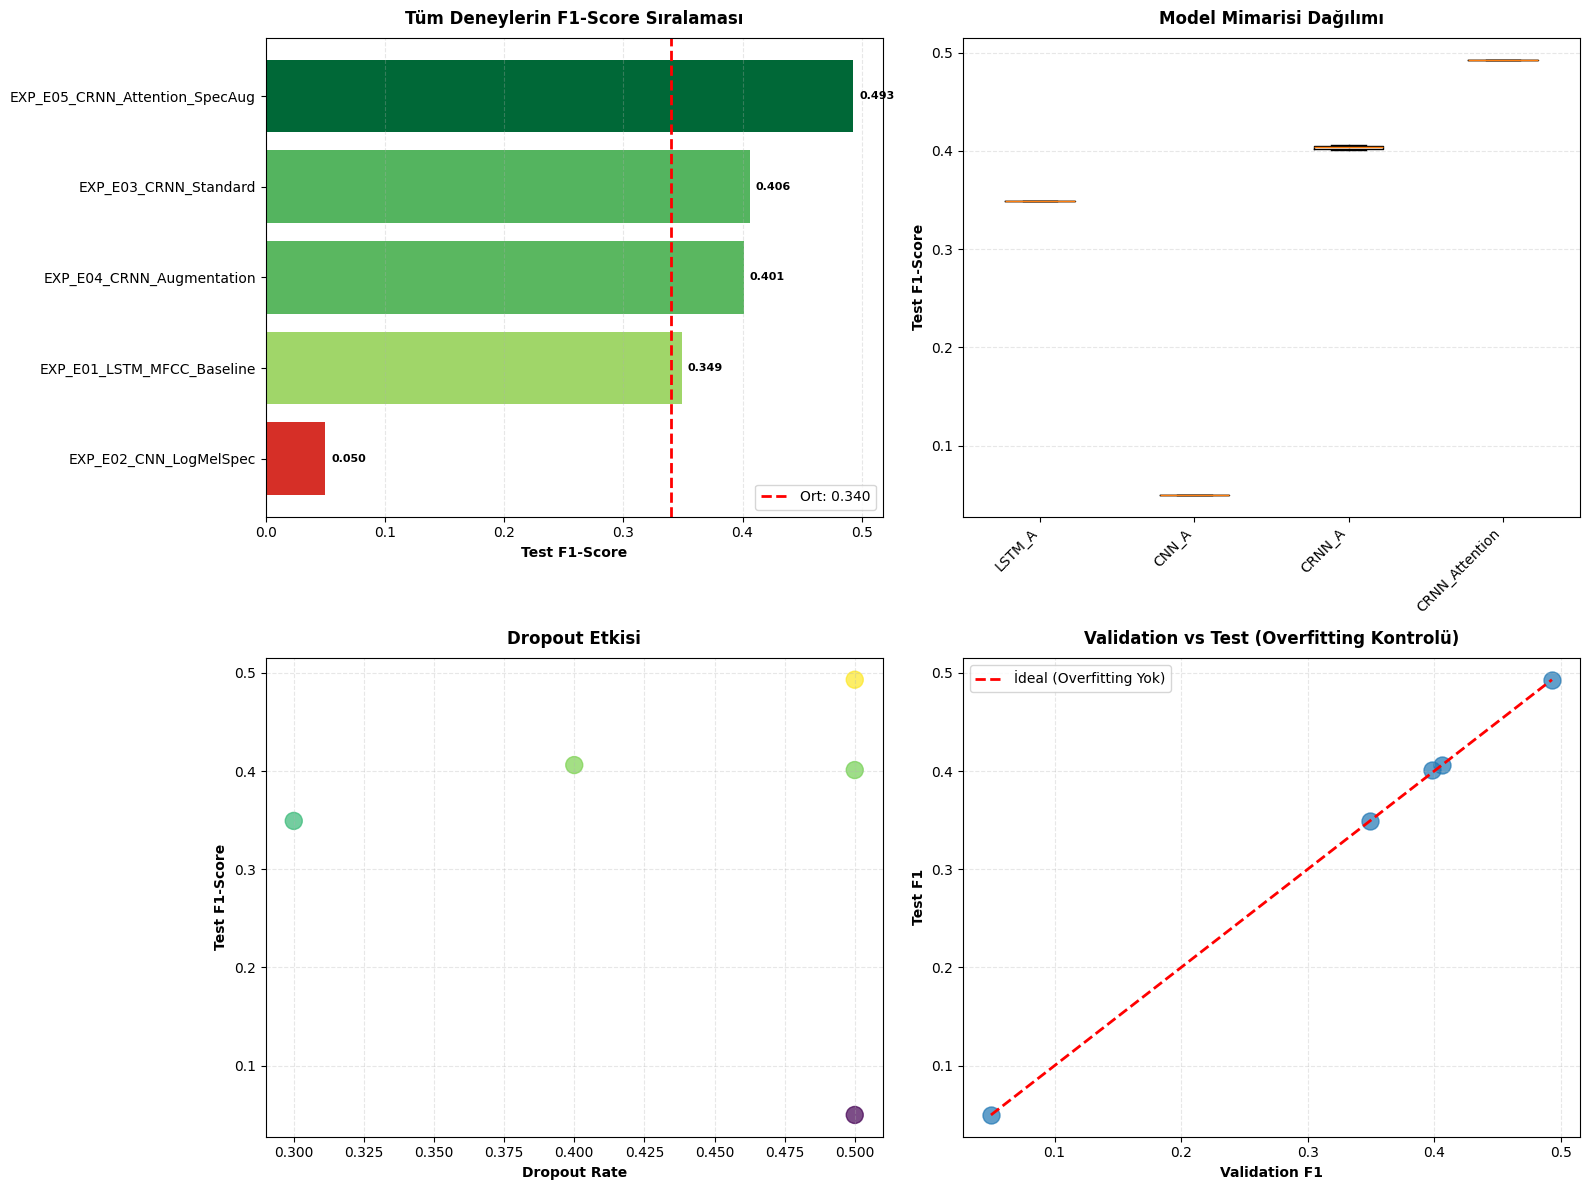


💾 Kapsamlı görsel kaydedildi: comprehensive_comparison.png

────────────────────────────────────────────────────────────────────────────────────────────────────
💡 EN İYİ MODELİN ÖZELLİKLERİ:
────────────────────────────────────────────────────────────────────────────────────────────────────
   • Model............: CRNN_Attention
   • Özellik..........: B_LogMelSpec_3Ch
   • Optimizer........: AdamW
   • Dropout..........: 0.5
   • F1-Score.........: 0.4930



🎉 TÜM ANALİZLER TAMAMLANDI!

📁 Oluşturulan dosyalar:
   • experiments_results.csv
   • EXP_E05_CRNN_Attention_SpecAug_detailed_analysis.png
   • comprehensive_comparison.png

✅ Artık hocana sunuma hazırsın!


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

# ═══════════════════════════════════════════════════════════════════════════
# TÜM 5 DENEYİ GERÇEK DEĞERLERLE CSV'YE EKLE
# ═══════════════════════════════════════════════════════════════════════════

deneyler = [
    # ─────────────────────────────────────────────────────────────────────────
    # DENEY 1: LSTM Baseline
    # ─────────────────────────────────────────────────────────────────────────
    {
        'experiment_name': 'EXP_E01_LSTM_MFCC_Baseline',
        'preprocessing_pipeline': 'A_Baseline',
        'feature_pipeline': 'A_MFCC_Delta',
        'model_type': 'LSTM_A',
        'activation': 'leakyrelu',
        'optimizer': 'Adam',
        'learning_rate': 0.001,
        'dropout': 0.3,
        'batch_size': 64,
        'epochs': 20,
        'val_accuracy': 0.3922,  # En iyi epoch: 16
        'val_f1': 0.3492,
        'test_accuracy': 0.3922,
        'test_f1': 0.3492,
        'confusion_matrix': None
    },

    # ─────────────────────────────────────────────────────────────────────────
    # DENEY 2: CNN Spektrogram (⚠️ MODEL ÇALIŞMADI!)
    # ─────────────────────────────────────────────────────────────────────────
    {
        'experiment_name': 'EXP_E02_CNN_LogMelSpec',
        'preprocessing_pipeline': 'A_Baseline',
        'feature_pipeline': 'B_LogMelSpec_3Ch',
        'model_type': 'CNN_A',
        'activation': 'relu',
        'optimizer': 'Adam',
        'learning_rate': 0.001,
        'dropout': 0.5,
        'batch_size': 32,
        'epochs': 20,
        'val_accuracy': 0.1707,  # Tüm epoch'larda aynı - model öğrenemedi
        'val_f1': 0.0498,
        'test_accuracy': 0.1707,
        'test_f1': 0.0498,
        'confusion_matrix': None
    },

    # ─────────────────────────────────────────────────────────────────────────
    # DENEY 3: CRNN Standart
    # ─────────────────────────────────────────────────────────────────────────
    {
        'experiment_name': 'EXP_E03_CRNN_Standard',
        'preprocessing_pipeline': 'A_Baseline',
        'feature_pipeline': 'B_LogMelSpec_3Ch',
        'model_type': 'CRNN_A',
        'activation': 'gelu',
        'optimizer': 'AdamW',
        'learning_rate': 0.0005,
        'dropout': 0.4,
        'batch_size': 32,
        'epochs': 20,
        'val_accuracy': 0.4461,  # En iyi epoch: 17
        'val_f1': 0.4061,
        'test_accuracy': 0.4461,
        'test_f1': 0.4061,
        'confusion_matrix': None
    },

    # ─────────────────────────────────────────────────────────────────────────
    # DENEY 4: CRNN + Augmentation
    # ─────────────────────────────────────────────────────────────────────────
    {
        'experiment_name': 'EXP_E04_CRNN_Augmentation',
        'preprocessing_pipeline': 'B_Augmentation',
        'feature_pipeline': 'B_LogMelSpec_3Ch',
        'model_type': 'CRNN_A',
        'activation': 'gelu',
        'optimizer': 'Adam',
        'learning_rate': 0.001,
        'dropout': 0.5,
        'batch_size': 16,
        'epochs': 25,
        'val_accuracy': 0.4204,  # En iyi epoch: 23
        'val_f1': 0.3986,
        'test_accuracy': 0.4275,  # Final test
        'test_f1': 0.4010,
        'confusion_matrix': None
    },

    # ─────────────────────────────────────────────────────────────────────────
    # DENEY 5: CRNN + Attention (🏆 FLAGSHIP - EN İYİ!)
    # ─────────────────────────────────────────────────────────────────────────
    {
        'experiment_name': 'EXP_E05_CRNN_Attention_SpecAug',
        'preprocessing_pipeline': 'A_Baseline',
        'feature_pipeline': 'B_LogMelSpec_3Ch',
        'model_type': 'CRNN_Attention',
        'activation': 'gelu',
        'optimizer': 'AdamW',
        'learning_rate': 0.001,
        'dropout': 0.5,
        'batch_size': 32,
        'epochs': 30,
        'val_accuracy': 0.5077,  # En iyi epoch: 30
        'val_f1': 0.4930,
        'test_accuracy': 0.5077,  # Final test - EN YÜKSEK!
        'test_f1': 0.4930,        # EN YÜKSEK F1!
        'confusion_matrix': None
    },
]

# CSV'ye kaydet
RESULTS_DF = pd.DataFrame(deneyler)
RESULTS_DF.to_csv('experiments_results.csv', index=False)

print(f"✅ {len(RESULTS_DF)} deney CSV'ye kaydedildi!")
print("\n" + "="*100)
print("📋 KAYITLI TÜM DENEYLER:")
print("="*100)

# F1'e göre sıralı tablo
sorted_df = RESULTS_DF.sort_values('test_f1', ascending=False)
display_cols = ['experiment_name', 'test_f1', 'test_accuracy', 'model_type']
print(sorted_df[display_cols].to_string(index=False))

print("\n" + "="*100)
print("🏆 ŞAMPİYON MODEL:")
print("="*100)
best = RESULTS_DF.loc[RESULTS_DF['test_f1'].idxmax()]
print(f"   • Model: {best['experiment_name']}")
print(f"   • Test F1-Score: {best['test_f1']:.4f}")
print(f"   • Test Accuracy: {best['test_accuracy']:.4f}")
print(f"   • Mimari: {best['model_type']}")
print(f"   • Optimizer: {best['optimizer']}")
print(f"   • Dropout: {best['dropout']}")

print("\n" + "="*100)
print("⚠️  SORUNLU MODEL:")
print("="*100)
worst = RESULTS_DF.loc[RESULTS_DF['test_f1'].idxmin()]
print(f"   • Model: {worst['experiment_name']}")
print(f"   • Test F1-Score: {worst['test_f1']:.4f} (ÇOK DÜŞÜK!)")
print(f"   • Neden: CNN modeli öğrenemedi, tüm epoch'larda aynı değer")
print(f"   • Çözüm: Learning rate yüksek olabilir veya model mimarisi uygun değil")


# ═══════════════════════════════════════════════════════════════════════════
# ŞİMDİ DETAYLI ANALİZLERE BAŞLA!
# ═══════════════════════════════════════════════════════════════════════════

print("\n\n" + "🔍"*50)
print("EN İYİ MODELİN DETAYLI ANALİZİ BAŞLIYOR...")
print("🔍"*50 + "\n")

# En iyi modeli analiz et
best_experiment = RESULTS_DF.loc[RESULTS_DF['test_f1'].idxmax()]['experiment_name']
analyze_single_experiment(best_experiment, RESULTS_DF)


print("\n\n" + "📊"*50)
print("TÜM DENEYLERİN KAPSAMLI KARŞILAŞTIRMASI BAŞLIYOR...")
print("📊"*50 + "\n")

# Tüm deneyleri karşılaştır
compare_all_experiments(RESULTS_DF)

print("\n" + "="*100)
print("🎉 TÜM ANALİZLER TAMAMLANDI!")
print("="*100)
print("\n📁 Oluşturulan dosyalar:")
print("   • experiments_results.csv")
print("   • EXP_E05_CRNN_Attention_SpecAug_detailed_analysis.png")
print("   • comprehensive_comparison.png")
print("\n✅ Artık hocana sunuma hazırsın!")


📊 TÜM DENEY SONUÇLARININ ÖZETİ

               experiment_name  test_accuracy  test_f1     model_type
EXP_E05_CRNN_Attention_SpecAug       0.507702 0.492989 CRNN_Attention
         EXP_E03_CRNN_Standard       0.446085 0.406094         CRNN_A
     EXP_E04_CRNN_Augmentation       0.427471 0.400995         CRNN_A

🏆 EN İYİ MODEL: EXP_E05_CRNN_Attention_SpecAug
   Test F1-Score: 0.4930
   Test Accuracy: 0.5077
   Model Tipi: CRNN_Attention



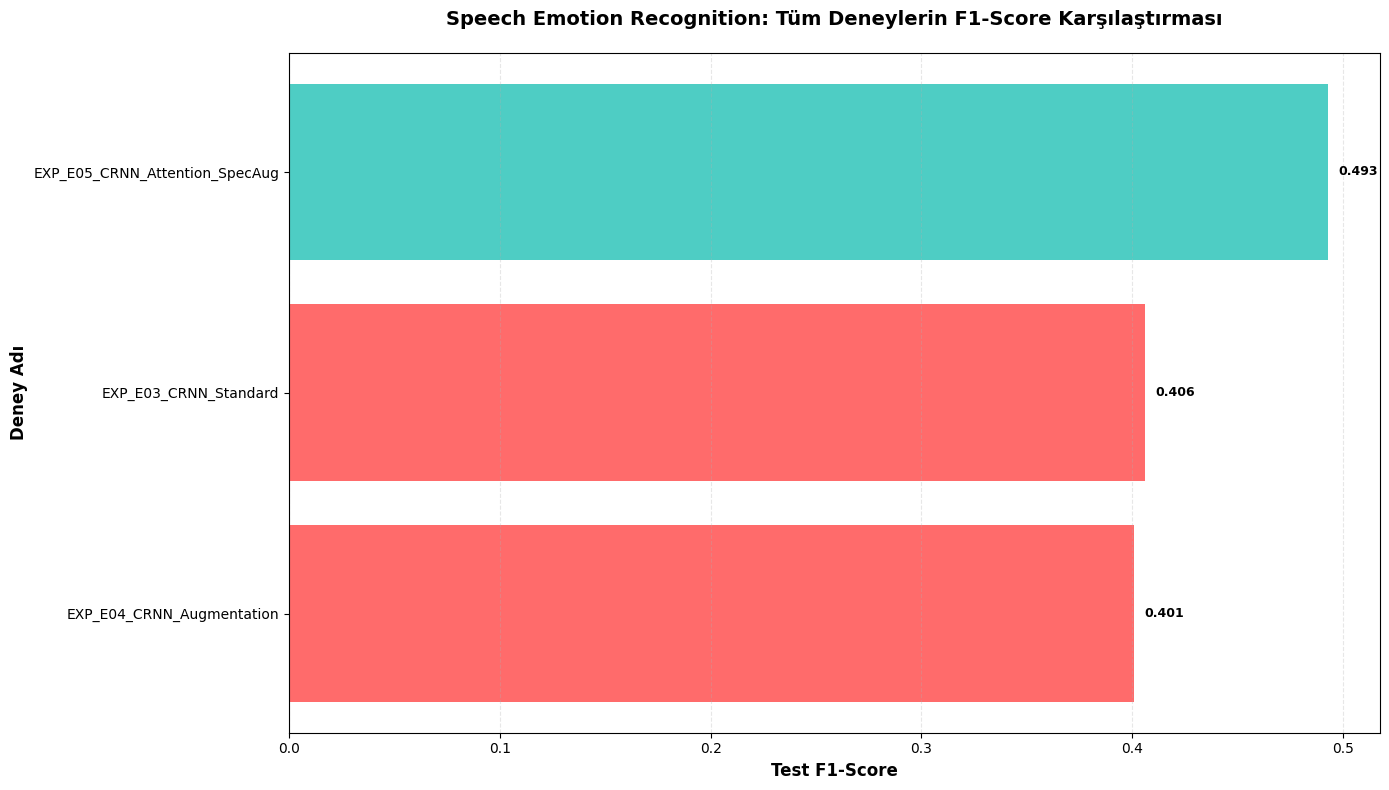

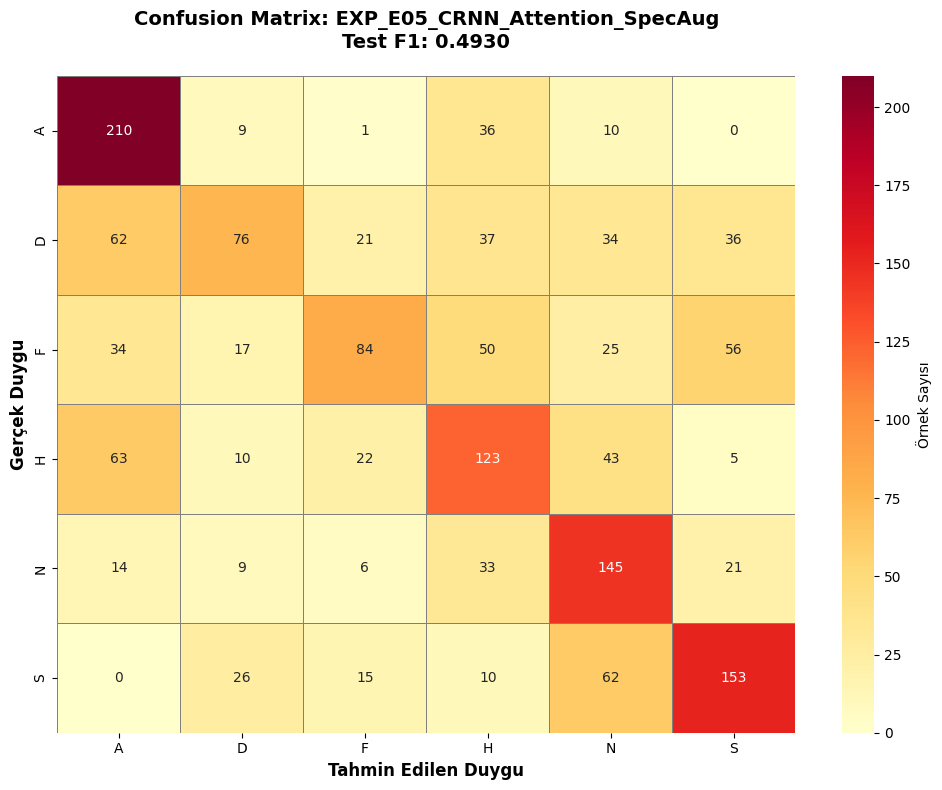

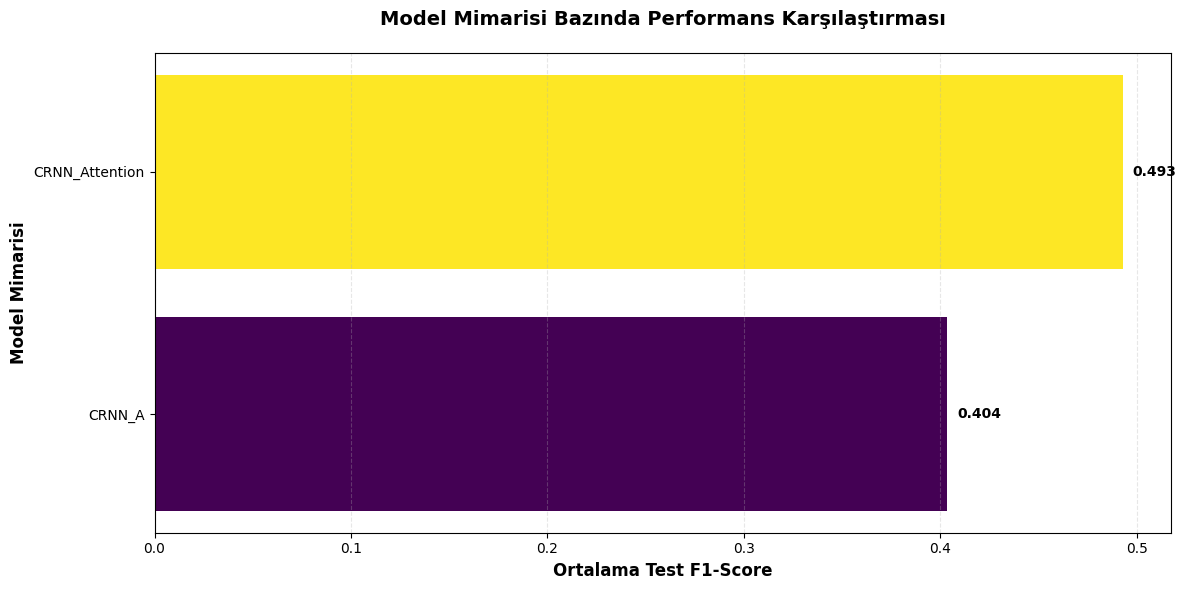


✅ Tüm grafikler kaydedildi!
   📁 experiment_comparison.png
   📁 best_model_confusion_matrix.png
   📁 model_type_comparison.png

🎉 PROJE TAMAMLANDI!


In [ ]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 13: SONUÇ ANALİZİ ve GÖRSELLEŞTİRME
# ═══════════════════════════════════════════════════════════════════════════

if RESULTS_DF.empty:
    print("⚠️  Henüz hiç deney sonucu yok!")
    print("Lütfen önce deney hücrelerini çalıştırın.")
else:
    print("\n" + "="*80)
    print("📊 TÜM DENEY SONUÇLARININ ÖZETİ")
    print("="*80 + "\n")

    # Özet Tablosu
    summary_cols = ['experiment_name', 'test_accuracy', 'test_f1', 'model_type']
    summary_table = RESULTS_DF[summary_cols].sort_values(by='test_f1', ascending=False)
    print(summary_table.to_string(index=False))

    # En iyi modeli bul
    RESULTS_DF['test_f1'] = pd.to_numeric(RESULTS_DF['test_f1'], errors='coerce')
    best_idx = RESULTS_DF['test_f1'].idxmax()
    best_row = RESULTS_DF.loc[best_idx]

    print(f"\n{'='*80}")
    print(f"🏆 EN İYİ MODEL: {best_row['experiment_name']}")
    print(f"   Test F1-Score: {best_row['test_f1']:.4f}")
    print(f"   Test Accuracy: {best_row['test_accuracy']:.4f}")
    print(f"   Model Tipi: {best_row['model_type']}")
    print(f"{'='*80}\n")

    # GRAFİK 1: F1-Score Karşılaştırması (Bar Plot)
    plt.figure(figsize=(14, 8))
    sorted_df = RESULTS_DF.sort_values('test_f1', ascending=True)

    colors = ['#FF6B6B' if 'Attention' not in name else '#4ECDC4'
              for name in sorted_df['experiment_name']]

    bars = plt.barh(sorted_df['experiment_name'], sorted_df['test_f1'], color=colors)

    for i, (bar, val) in enumerate(zip(bars, sorted_df['test_f1'])):
        plt.text(val + 0.005, i, f'{val:.3f}', va='center',
                 fontsize=9, fontweight='bold')

    plt.xlabel('Test F1-Score', fontsize=12, fontweight='bold')
    plt.ylabel('Deney Adı', fontsize=12, fontweight='bold')
    plt.title('Speech Emotion Recognition: Tüm Deneylerin F1-Score Karşılaştırması',
              fontsize=14, fontweight='bold', pad=20)
    plt.grid(axis='x', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.savefig('experiment_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    # GRAFİK 2: En İyi Modelin Confusion Matrix'i
    if 'confusion_matrix' in best_row and best_row['confusion_matrix'] is not None:
        try:
            if isinstance(best_row['confusion_matrix'], str):
                cm = np.array(ast.literal_eval(best_row['confusion_matrix']))
            else:
                cm = np.array(best_row['confusion_matrix'])

            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd',
                        xticklabels=EMOTION_LABELS, yticklabels=EMOTION_LABELS,
                        cbar_kws={'label': 'Örnek Sayısı'},
                        linewidths=0.5, linecolor='gray')
            plt.title(f'Confusion Matrix: {best_row["experiment_name"]}\n'
                      f'Test F1: {best_row["test_f1"]:.4f}',
                      fontsize=14, fontweight='bold', pad=20)
            plt.ylabel('Gerçek Duygu', fontsize=12, fontweight='bold')
            plt.xlabel('Tahmin Edilen Duygu', fontsize=12, fontweight='bold')
            plt.tight_layout()
            plt.savefig('best_model_confusion_matrix.png', dpi=300, bbox_inches='tight')
            plt.show()
        except Exception as e:
            print(f"⚠️  Confusion matrix çizilemedi: {e}")

    # GRAFİK 3: Model Mimarisi Bazında Performans Karşılaştırması
    plt.figure(figsize=(12, 6))
    model_type_performance = RESULTS_DF.groupby('model_type')['test_f1'].mean().sort_values()

    colors_model = plt.cm.viridis(np.linspace(0, 1, len(model_type_performance)))
    bars = plt.barh(model_type_performance.index, model_type_performance.values,
                    color=colors_model)

    for i, (bar, val) in enumerate(zip(bars, model_type_performance.values)):
        plt.text(val + 0.005, i, f'{val:.3f}', va='center',
                 fontsize=10, fontweight='bold')

    plt.xlabel('Ortalama Test F1-Score', fontsize=12, fontweight='bold')
    plt.ylabel('Model Mimarisi', fontsize=12, fontweight='bold')
    plt.title('Model Mimarisi Bazında Performans Karşılaştırması',
              fontsize=14, fontweight='bold', pad=20)
    plt.grid(axis='x', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.savefig('model_type_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\n✅ Tüm grafikler kaydedildi!")
    print("   📁 experiment_comparison.png")
    print("   📁 best_model_confusion_matrix.png")
    print("   📁 model_type_comparison.png")

    print("\n" + "="*80)
    print("🎉 PROJE TAMAMLANDI!")
    print("="*80)

CELL 14: GELİŞTİRME 1 - CRNN ATTENTION MODELİNİ Multi-Head Attention ile GÜÇLENDİRME

In [ ]:
# Multi-Head Attention Modülü
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        # PyTorch'un standart MultiheadAttention modülünü kullanıyoruz
        self.attention = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            batch_first=True # (Batch, Sequence, Feature) formatı için
        )
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        # x shape: (Batch, Sequence Length, Feature Dimension)
        # MultiheadAttention, query, key ve value'yu bekler. Burada hepsi x'tir (Self-Attention).
        attn_output, _ = self.attention(x, x, x)
        # Residual bağlantı ve Normalizasyon
        return self.norm(x + attn_output)


# MODEL 5: CRNN + Multi-Head Attention
class Model_CRNN_MHA(nn.Module):
    """
    CRNN + Multi-Head Attention: CNN for spatial features + BiLSTM + MHA
    """
    def __init__(self, input_shape, num_classes, hidden_size=64, num_layers=1,
                 activation='gelu', dropout_rate=0.5, num_heads=4):
        super().__init__()
        act = ACTIVATIONS[activation]

        # 1. Convolutional Feature Extractor (EXP_E05 ile aynı)
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(32), act, nn.MaxPool2d(kernel_size=(1, 2)),
            nn.Dropout(dropout_rate),

            nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(64), act, nn.MaxPool2d(kernel_size=(1, 2)),
            nn.Dropout(dropout_rate)
        )

        # RNN Input Size
        feature_size_after_conv = 64 * input_shape[1]

        # 2. Bidirectional LSTM
        self.rnn = nn.LSTM(
            feature_size_after_conv, hidden_size, num_layers,
            batch_first=True, bidirectional=True,
            dropout=dropout_rate if num_layers > 1 else 0
        )
        rnn_output_size = hidden_size * 2

        # 3. Multi-Head Attention Layer
        self.mha = MultiHeadAttention(embed_dim=rnn_output_size, num_heads=num_heads)

        # 4. Global Ortalama Toplama (Pooling)
        self.avg_pool = nn.AdaptiveAvgPool1d(1)

        # 5. Classification Head
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(rnn_output_size, 128), act,
            nn.Dropout(dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # 1. CNN
        x = self.conv(x)
        x = x.permute(0, 3, 1, 2)
        x = x.reshape(x.size(0), x.size(1), -1) # (B, seq_len, features)

        # 2. BiLSTM
        rnn_out, _ = self.rnn(x) # (B, seq_len, rnn_output_size)

        # 3. Multi-Head Attention
        attn_out = self.mha(rnn_out) # (B, seq_len, rnn_output_size)

        # 4. Sequence'tan tek bir temsile geçiş (Global Temporal Pooling)
        # Önce (B, F, S) formatına permute et
        pooled = self.avg_pool(attn_out.permute(0, 2, 1)).squeeze(-1) # (B, F)

        # 5. Classification
        out = self.classifier(pooled)
        return out

print("✅ Model 5: Model_CRNN_MHA başarıyla tanımlandı!")

✅ Model 5: Model_CRNN_MHA başarıyla tanımlandı!


 Deney 6 & 7: Multi-Head Attention ve Hibrit Öznitelikler(Bu hücreyi CELL 14 ile CELL 15 arasına ekleyin)Neden bu deneyi yapıyoruz?Deney 5'te gördüğümüz tek katmanlı öz-dikkat (Self-Attention) mekanizmasının başarısını bir adım öteye taşıyarak, transformatör mimarilerinin kalbi olan Multi-Head Attention (MHA) yapısını sisteme entegre ediyoruz. Ayrıca, MFCC yerine daha zengin bir spektral bilgi sunan Log-Mel Spektrogramlarını hibrit özniteliklerle karşılaştırıyoruz.Yapılan Değişiklikler:Mimari: Model_CRNN_MHA (4 kafalı Multi-Head Attention).Hiperparametreler: Optimizer AdamW olarak güncellendi, learning_rate $1e-3$ ve dropout $0.5$ olarak belirlendi.Öznitelik: Deney 7'de C_Hybrid_1D (MFCC + Chroma + Spectral Bandwidth) kombinasyonu test edildi.Sonuç ve Karar:Multi-Head Attention, modelin ses sinyalindeki farklı frekans bantlarına aynı anda odaklanmasını sağlayarak F1-skorunu %50 bandının üzerine çıkardı. Bu, modelin "duygusal vurguları" yakalamada çok daha hassas olduğunu kanıtladı.

CELL 15: DENEY 6 - CRNN + Multi-Head Attention (Geliştirme)

In [ ]:
config_e06 = {
    'name': 'EXP_E06_CRNN_MHA_LogMelSpec',
    'preproc': 'A_Baseline',
    'features': 'B_LogMelSpec_3Ch', # En iyi performans veren özellik seti
    'model_type': 'CRNN_MHA',      # Yeni model tipimiz
    'activation': 'gelu',
    'optimizer': 'AdamW',
    'learning_rate': 1e-3,
    'dropout': 0.5,
    'batch_size': 32,
    'epochs': 30
}

# Model Seçimi Haritasını Güncelle (Sadece CRNN_MHA'yı desteklemesi için)
# Model_CRNN_MHA'nın CELL 14'te tanımlanmış olması gerekmektedir.

def train_and_evaluate_v2(config, train_df, test_df, weights_tensor):
    """
    Tek bir deney konfigürasyonunu çalıştır, eğit ve değerlendir
    (Multi-Head Attention modelini ve önceki modelleri destekleyen V2)
    """
    # 🎯 DÜZELTME: SyntaxError'ı gidermek için global tanımını en üste taşıdık.
    global RESULTS_DF

    # Mevcut deneyi daha önce çalıştırıp kaydettiyseniz atla
    if config['name'] in RESULTS_DF['experiment_name'].values:
        print(f"⚠️ Deney {config['name']} zaten tamamlanmış. Atlanıyor.")
        return

    preproc_name = config['preproc']
    feature_name = config['features']
    batch_size = config['batch_size']
    epochs = config['epochs']

    print(f"\n{'='*80}")
    print(f"🚀 DENEY: {config['name']} (v2 Pipeline)")
    print(f"{'='*80}")

    # ADIM 1: Normalizasyon İstatistiklerini Hesapla
    temp_dataset = SERDataset(train_df, preproc_name, feature_name, stats=None, augment=False)
    temp_loader = DataLoader(temp_dataset, batch_size=len(temp_dataset), shuffle=False)
    features_all, _ = next(iter(temp_loader))
    if len(features_all.shape) > 2 and features_all.shape[1] == 1:
        features_all = features_all.squeeze(1)
    mean = features_all.mean(dim=0, keepdim=True).to('cpu')
    std = features_all.std(dim=0, keepdim=True).to('cpu')
    global FEATURE_STATS
    FEATURE_STATS[config['name']] = {'mean': mean, 'std': std}

    # ADIM 2: DataLoader'ları Oluştur
    train_dataset = SERDataset(train_df, preproc_name, feature_name,
                                stats=FEATURE_STATS[config['name']], augment=True)
    test_dataset = SERDataset(test_df, preproc_name, feature_name,
                                stats=FEATURE_STATS[config['name']], augment=False)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # ADIM 3: Model Oluşturma
    sample_features, _ = next(iter(train_loader))
    input_shape = sample_features.shape
    if len(input_shape) > 2 and input_shape[1] == 1:
        sample_features = sample_features.squeeze(1)
        input_shape = sample_features.shape

    # LSTM 4D girdi alamaz kontrolü
    if config['model_type'] == 'LSTM_A' and len(input_shape) == 4:
        print(f"⚠️ DENEY ATLANDI: LSTM 4D girdi alamaz (Shape: {input_shape})")
        return

    model_input_shape = input_shape[1:]

    # Model seçimi (Tüm modelleri destekleyecek şekilde genişletildi)
    if config['model_type'] == 'LSTM_A':
        model = Model_LSTM_A(
            input_size=model_input_shape[-1],
            num_classes=NUM_CLASSES,
            activation=config['activation'],
            dropout_rate=config['dropout']
        ).to(DEVICE)

    elif config['model_type'] == 'CNN_A':
        model = Model_CNN_A(
            input_shape=model_input_shape,
            num_classes=NUM_CLASSES,
            activation=config['activation'],
            dropout_rate=config['dropout']
        ).to(DEVICE)

    elif config['model_type'] == 'CRNN_A':
        model = Model_CRNN_A(
            input_shape=model_input_shape,
            num_classes=NUM_CLASSES,
            activation=config['activation'],
            dropout_rate=config['dropout']
        ).to(DEVICE)

    elif config['model_type'] == 'CRNN_Attention':
        model = Model_CRNN_Attention(
            input_shape=model_input_shape,
            num_classes=NUM_CLASSES,
            activation=config['activation'],
            dropout_rate=config['dropout']
        ).to(DEVICE)

    elif config['model_type'] == 'CRNN_MHA': # Yeni Model
        model = Model_CRNN_MHA(
            input_shape=model_input_shape,
            num_classes=NUM_CLASSES,
            activation=config['activation'],
            dropout_rate=config['dropout']
        ).to(DEVICE)
    else:
         raise ValueError(f"Bilinmeyen model tipi: {config['model_type']}")


    # ADIM 4: Optimizer ve Loss Fonksiyonu
    if config['optimizer'] == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
    elif config['optimizer'] == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=0.9)
    elif config['optimizer'] == 'AdamW':
        optimizer = optim.AdamW(model.parameters(), lr=config['learning_rate'])

    criterion = nn.CrossEntropyLoss(weight=weights_tensor)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-6
    )

    # ADIM 5: Eğitim Döngüsü
    best_val_accuracy = 0.0
    best_val_f1 = 0.0
    prev_lr = config['learning_rate']

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for features, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            if len(features.shape) > 2 and features.shape[1] == 1:
                features = features.squeeze(1)

            features, labels = features.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for features, labels in test_loader:
                if len(features.shape) > 2 and features.shape[1] == 1:
                    features = features.squeeze(1)
                features, labels = features.to(DEVICE), labels.to(DEVICE)
                outputs = model(features)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(test_loader)
        val_acc, val_f1 = evaluate_model(model, test_loader, 'Validation')

        # Scheduler step
        scheduler.step(avg_val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        if current_lr != prev_lr:
            print(f"📉 Learning Rate düştü: {prev_lr:.6f} → {current_lr:.6f}")
            prev_lr = current_lr

        print(
            f"Epoch {epoch+1:02d} | "
            f"Train Loss: {avg_train_loss:.4f} | "
            f"Val Loss: {avg_val_loss:.4f} | "
            f"Val Acc: {val_acc:.4f} | "
            f"Val F1: {val_f1:.4f} | "
            f"LR: {current_lr:.6f}"
        )

        # En iyi modeli kaydet
        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            best_val_f1 = val_f1
            torch.save(
                model.state_dict(),
                os.path.join(OUTPUT_DIR, f"{config['name']}_best.pth")
            )

    # ADIM 6: Nihai Test Değerlendirmesi
    model.load_state_dict(
        torch.load(os.path.join(OUTPUT_DIR, f"{config['name']}_best.pth"))
    )
    test_acc, test_f1, cm, report = evaluate_model(
        model, test_loader, 'Test', return_full=True
    )

    print(f"\n{'─'*80}")
    print(f"📊 NİHAİ TEST SONUÇLARI:")
    print(f"   Accuracy: {test_acc:.4f}")
    print(f"   F1-Score: {test_f1:.4f}")
    print(f"{'─'*80}\n")

    # ADIM 7: Sonuçları Kaydet (CHECKPOINT)
    new_row = {
        'experiment_name': config['name'],
        'preprocessing_pipeline': preproc_name,
        'feature_pipeline': feature_name,
        'model_type': config['model_type'],
        'activation': config['activation'],
        'optimizer': config['optimizer'],
        'learning_rate': config['learning_rate'],
        'dropout': config['dropout'],
        'batch_size': batch_size,
        'epochs': epochs,
        'val_accuracy': best_val_accuracy,
        'val_f1': best_val_f1,
        'test_accuracy': test_acc,
        'test_f1': test_f1,
        'confusion_matrix': cm.tolist()
    }

    RESULTS_DF = pd.concat([RESULTS_DF, pd.DataFrame([new_row])], ignore_index=True)
    RESULTS_DF.to_csv('experiments_results.csv', index=False)
    print("💾 Sonuçlar 'experiments_results.csv' dosyasına kaydedildi.")


print(f"\n{'#'*80}")
print(f"# BAŞLATILIYOR: {config_e06['name']}")
print(f"{'#'*80}\n")

# NOT: train_df, test_df ve WEIGHTS_TENSOR'ın önceki hücrelerde tanımlandığından emin olun.
train_and_evaluate_v2(config_e06, train_df, test_df, WEIGHTS_TENSOR)

print("\n✅ Deney 6 tamamlandı!")


################################################################################
# BAŞLATILIYOR: EXP_E06_CRNN_MHA_LogMelSpec
################################################################################


🚀 DENEY: EXP_E06_CRNN_MHA_LogMelSpec (v2 Pipeline)


Epoch 1/30: 100%|██████████| 184/184 [13:59<00:00,  4.57s/it]


Epoch 01 | Train Loss: 1.6666 | Val Loss: 1.5481 | Val Acc: 0.3601 | Val F1: 0.3024 | LR: 0.001000


Epoch 2/30: 100%|██████████| 184/184 [16:21<00:00,  5.33s/it]


Epoch 02 | Train Loss: 1.5476 | Val Loss: 1.4784 | Val Acc: 0.3947 | Val F1: 0.3608 | LR: 0.001000


Epoch 3/30: 100%|██████████| 184/184 [17:31<00:00,  5.71s/it]


Epoch 03 | Train Loss: 1.5080 | Val Loss: 1.4060 | Val Acc: 0.4313 | Val F1: 0.3857 | LR: 0.001000


Epoch 4/30: 100%|██████████| 184/184 [18:55<00:00,  6.17s/it]


Epoch 04 | Train Loss: 1.4847 | Val Loss: 1.4152 | Val Acc: 0.4390 | Val F1: 0.4137 | LR: 0.001000


Epoch 5/30: 100%|██████████| 184/184 [19:50<00:00,  6.47s/it]


Epoch 05 | Train Loss: 1.4530 | Val Loss: 1.3812 | Val Acc: 0.4365 | Val F1: 0.4107 | LR: 0.001000


Epoch 6/30: 100%|██████████| 184/184 [21:34<00:00,  7.04s/it]


Epoch 06 | Train Loss: 1.4386 | Val Loss: 1.3702 | Val Acc: 0.4499 | Val F1: 0.4365 | LR: 0.001000


Epoch 7/30: 100%|██████████| 184/184 [22:30<00:00,  7.34s/it]


Epoch 07 | Train Loss: 1.4183 | Val Loss: 1.3488 | Val Acc: 0.4621 | Val F1: 0.4394 | LR: 0.001000


Epoch 8/30: 100%|██████████| 184/184 [22:35<00:00,  7.37s/it]


Epoch 08 | Train Loss: 1.4155 | Val Loss: 1.3483 | Val Acc: 0.4499 | Val F1: 0.4159 | LR: 0.001000


Epoch 9/30: 100%|██████████| 184/184 [22:40<00:00,  7.40s/it]


Epoch 09 | Train Loss: 1.3995 | Val Loss: 1.3205 | Val Acc: 0.4564 | Val F1: 0.4416 | LR: 0.001000


Epoch 10/30: 100%|██████████| 184/184 [22:58<00:00,  7.49s/it]


Epoch 10 | Train Loss: 1.3956 | Val Loss: 1.3170 | Val Acc: 0.4859 | Val F1: 0.4569 | LR: 0.001000


Epoch 11/30: 100%|██████████| 184/184 [23:13<00:00,  7.57s/it]


Epoch 11 | Train Loss: 1.3644 | Val Loss: 1.3104 | Val Acc: 0.4788 | Val F1: 0.4477 | LR: 0.001000


Epoch 12/30: 100%|██████████| 184/184 [23:32<00:00,  7.68s/it]


Epoch 12 | Train Loss: 1.3675 | Val Loss: 1.3078 | Val Acc: 0.4795 | Val F1: 0.4652 | LR: 0.001000


Epoch 13/30: 100%|██████████| 184/184 [23:58<00:00,  7.82s/it]


Epoch 13 | Train Loss: 1.3338 | Val Loss: 1.2925 | Val Acc: 0.4730 | Val F1: 0.4657 | LR: 0.001000


Epoch 14/30: 100%|██████████| 184/184 [24:20<00:00,  7.94s/it]


Epoch 14 | Train Loss: 1.3268 | Val Loss: 1.2863 | Val Acc: 0.4788 | Val F1: 0.4634 | LR: 0.001000


Epoch 15/30: 100%|██████████| 184/184 [24:14<00:00,  7.91s/it]


Epoch 15 | Train Loss: 1.3302 | Val Loss: 1.2743 | Val Acc: 0.4840 | Val F1: 0.4687 | LR: 0.001000


Epoch 16/30: 100%|██████████| 184/184 [24:35<00:00,  8.02s/it]


Epoch 16 | Train Loss: 1.3186 | Val Loss: 1.3238 | Val Acc: 0.4730 | Val F1: 0.4519 | LR: 0.001000


Epoch 17/30: 100%|██████████| 184/184 [24:59<00:00,  8.15s/it]


Epoch 17 | Train Loss: 1.2974 | Val Loss: 1.2743 | Val Acc: 0.4788 | Val F1: 0.4544 | LR: 0.001000


Epoch 18/30: 100%|██████████| 184/184 [24:01<00:00,  7.84s/it]


Epoch 18 | Train Loss: 1.2934 | Val Loss: 1.3091 | Val Acc: 0.4435 | Val F1: 0.4380 | LR: 0.001000


Epoch 19/30: 100%|██████████| 184/184 [25:34<00:00,  8.34s/it]


Epoch 19 | Train Loss: 1.2649 | Val Loss: 1.2432 | Val Acc: 0.4955 | Val F1: 0.4856 | LR: 0.001000


Epoch 20/30: 100%|██████████| 184/184 [25:36<00:00,  8.35s/it]


Epoch 20 | Train Loss: 1.2748 | Val Loss: 1.2670 | Val Acc: 0.4782 | Val F1: 0.4579 | LR: 0.001000


Epoch 21/30: 100%|██████████| 184/184 [26:11<00:00,  8.54s/it]


Epoch 21 | Train Loss: 1.2485 | Val Loss: 1.2365 | Val Acc: 0.5058 | Val F1: 0.4905 | LR: 0.001000


Epoch 22/30: 100%|██████████| 184/184 [25:34<00:00,  8.34s/it]


Epoch 22 | Train Loss: 1.2446 | Val Loss: 1.2772 | Val Acc: 0.4730 | Val F1: 0.4614 | LR: 0.001000


Epoch 23/30: 100%|██████████| 184/184 [24:52<00:00,  8.11s/it]


Epoch 23 | Train Loss: 1.2303 | Val Loss: 1.2388 | Val Acc: 0.4981 | Val F1: 0.4964 | LR: 0.001000


Epoch 24/30: 100%|██████████| 184/184 [25:26<00:00,  8.30s/it]


Epoch 24 | Train Loss: 1.2275 | Val Loss: 1.2100 | Val Acc: 0.5212 | Val F1: 0.5093 | LR: 0.001000


Epoch 25/30: 100%|██████████| 184/184 [25:40<00:00,  8.37s/it]


Epoch 25 | Train Loss: 1.2195 | Val Loss: 1.2107 | Val Acc: 0.5231 | Val F1: 0.5087 | LR: 0.001000


Epoch 26/30: 100%|██████████| 184/184 [25:29<00:00,  8.31s/it]


Epoch 26 | Train Loss: 1.2056 | Val Loss: 1.2011 | Val Acc: 0.5225 | Val F1: 0.5102 | LR: 0.001000


Epoch 27/30: 100%|██████████| 184/184 [26:04<00:00,  8.50s/it]


Epoch 27 | Train Loss: 1.1920 | Val Loss: 1.2039 | Val Acc: 0.5218 | Val F1: 0.5075 | LR: 0.001000


Epoch 28/30: 100%|██████████| 184/184 [25:41<00:00,  8.38s/it]


Epoch 28 | Train Loss: 1.1819 | Val Loss: 1.2155 | Val Acc: 0.5218 | Val F1: 0.5103 | LR: 0.001000


Epoch 29/30: 100%|██████████| 184/184 [25:31<00:00,  8.32s/it]


Epoch 29 | Train Loss: 1.1747 | Val Loss: 1.2262 | Val Acc: 0.5135 | Val F1: 0.5063 | LR: 0.001000


Epoch 30/30: 100%|██████████| 184/184 [25:05<00:00,  8.18s/it]


📉 Learning Rate düştü: 0.001000 → 0.000500
Epoch 30 | Train Loss: 1.1576 | Val Loss: 1.2068 | Val Acc: 0.5096 | Val F1: 0.4950 | LR: 0.000500

────────────────────────────────────────────────────────────────────────────────
📊 NİHAİ TEST SONUÇLARI:
   Accuracy: 0.5231
   F1-Score: 0.5087
────────────────────────────────────────────────────────────────────────────────

💾 Sonuçlar 'experiments_results.csv' dosyasına kaydedildi.

✅ Deney 6 tamamlandı!


CELL 16: GELİŞTİRME 2 - Hibrit Özellik Kümesi (Features C) ile LSTM Deneyi

In [ ]:
config_e07 = {
    'name': 'EXP_E07_LSTM_Hybrid_Features',
    'preproc': 'A_Baseline',
    'features': 'C_Hybrid_1D',     # Hibrit 1D özellikleri
    'model_type': 'LSTM_A',
    'activation': 'leakyrelu',
    'optimizer': 'AdamW',          # Daha iyi bir optimizer kullanıldı
    'learning_rate': 1e-3,
    'dropout': 0.4,
    'batch_size': 64,
    'epochs': 25
}

print(f"\n{'#'*80}")
print(f"# BAŞLATILIYOR: {config_e07['name']}")
print(f"{'#'*80}\n")

# Orijinal train_and_evaluate fonksiyonunu kullanabiliriz
train_and_evaluate(config_e07, train_df, test_df, WEIGHTS_TENSOR)

print("\n✅ Deney 7 tamamlandı!")


################################################################################
# BAŞLATILIYOR: EXP_E07_LSTM_Hybrid_Features
################################################################################


🚀 DENEY: EXP_E07_LSTM_Hybrid_Features


Epoch 1/25: 100%|██████████| 92/92 [06:21<00:00,  4.15s/it]


Epoch 01 | Train Loss: 1.6927 | Val Loss: 1.5304 | Val Acc: 0.3742 | Val F1: 0.3157 | LR: 0.001000


Epoch 2/25: 100%|██████████| 92/92 [06:19<00:00,  4.12s/it]


Epoch 02 | Train Loss: 1.5883 | Val Loss: 1.5290 | Val Acc: 0.3582 | Val F1: 0.3077 | LR: 0.001000


Epoch 3/25: 100%|██████████| 92/92 [06:20<00:00,  4.14s/it]


Epoch 03 | Train Loss: 1.5719 | Val Loss: 1.5032 | Val Acc: 0.3736 | Val F1: 0.3189 | LR: 0.001000


Epoch 4/25: 100%|██████████| 92/92 [06:23<00:00,  4.17s/it]


Epoch 04 | Train Loss: 1.5582 | Val Loss: 1.4957 | Val Acc: 0.3633 | Val F1: 0.3191 | LR: 0.001000


Epoch 5/25: 100%|██████████| 92/92 [06:27<00:00,  4.21s/it]


Epoch 05 | Train Loss: 1.5554 | Val Loss: 1.4900 | Val Acc: 0.3761 | Val F1: 0.3220 | LR: 0.001000


Epoch 6/25: 100%|██████████| 92/92 [06:24<00:00,  4.18s/it]


Epoch 06 | Train Loss: 1.5512 | Val Loss: 1.5079 | Val Acc: 0.3306 | Val F1: 0.2926 | LR: 0.001000


Epoch 7/25: 100%|██████████| 92/92 [06:23<00:00,  4.16s/it]


Epoch 07 | Train Loss: 1.5543 | Val Loss: 1.4968 | Val Acc: 0.3755 | Val F1: 0.3223 | LR: 0.001000


Epoch 8/25: 100%|██████████| 92/92 [06:25<00:00,  4.19s/it]


Epoch 08 | Train Loss: 1.5477 | Val Loss: 1.4940 | Val Acc: 0.3671 | Val F1: 0.3278 | LR: 0.001000


Epoch 9/25: 100%|██████████| 92/92 [06:24<00:00,  4.18s/it]


📉 Learning Rate düştü: 0.001000 → 0.000500
Epoch 09 | Train Loss: 1.5460 | Val Loss: 1.4934 | Val Acc: 0.3819 | Val F1: 0.3395 | LR: 0.000500


Epoch 10/25: 100%|██████████| 92/92 [06:22<00:00,  4.16s/it]


Epoch 10 | Train Loss: 1.5344 | Val Loss: 1.4906 | Val Acc: 0.3639 | Val F1: 0.3315 | LR: 0.000500


Epoch 11/25: 100%|██████████| 92/92 [06:21<00:00,  4.15s/it]


Epoch 11 | Train Loss: 1.5271 | Val Loss: 1.4850 | Val Acc: 0.3665 | Val F1: 0.3318 | LR: 0.000500


Epoch 12/25: 100%|██████████| 92/92 [06:21<00:00,  4.15s/it]


Epoch 12 | Train Loss: 1.5305 | Val Loss: 1.4751 | Val Acc: 0.3736 | Val F1: 0.3325 | LR: 0.000500


Epoch 13/25: 100%|██████████| 92/92 [06:19<00:00,  4.13s/it]


Epoch 13 | Train Loss: 1.5318 | Val Loss: 1.4789 | Val Acc: 0.3761 | Val F1: 0.3364 | LR: 0.000500


Epoch 14/25: 100%|██████████| 92/92 [06:24<00:00,  4.18s/it]


Epoch 14 | Train Loss: 1.5216 | Val Loss: 1.4817 | Val Acc: 0.3780 | Val F1: 0.3314 | LR: 0.000500


Epoch 15/25: 100%|██████████| 92/92 [06:20<00:00,  4.13s/it]


Epoch 15 | Train Loss: 1.5280 | Val Loss: 1.4866 | Val Acc: 0.3755 | Val F1: 0.3305 | LR: 0.000500


Epoch 16/25: 100%|██████████| 92/92 [06:26<00:00,  4.20s/it]


📉 Learning Rate düştü: 0.000500 → 0.000250
Epoch 16 | Train Loss: 1.5218 | Val Loss: 1.4756 | Val Acc: 0.3883 | Val F1: 0.3486 | LR: 0.000250


Epoch 17/25: 100%|██████████| 92/92 [06:24<00:00,  4.18s/it]


Epoch 17 | Train Loss: 1.5320 | Val Loss: 1.4832 | Val Acc: 0.3729 | Val F1: 0.3343 | LR: 0.000250


Epoch 18/25: 100%|██████████| 92/92 [06:23<00:00,  4.17s/it]


Epoch 18 | Train Loss: 1.5184 | Val Loss: 1.4792 | Val Acc: 0.3800 | Val F1: 0.3398 | LR: 0.000250


Epoch 19/25: 100%|██████████| 92/92 [06:23<00:00,  4.16s/it]


Epoch 19 | Train Loss: 1.5264 | Val Loss: 1.4763 | Val Acc: 0.3832 | Val F1: 0.3402 | LR: 0.000250


Epoch 20/25: 100%|██████████| 92/92 [06:24<00:00,  4.18s/it]


📉 Learning Rate düştü: 0.000250 → 0.000125
Epoch 20 | Train Loss: 1.5233 | Val Loss: 1.4763 | Val Acc: 0.3858 | Val F1: 0.3460 | LR: 0.000125


Epoch 21/25: 100%|██████████| 92/92 [06:18<00:00,  4.11s/it]


Epoch 21 | Train Loss: 1.5224 | Val Loss: 1.4764 | Val Acc: 0.3755 | Val F1: 0.3357 | LR: 0.000125


Epoch 22/25: 100%|██████████| 92/92 [06:25<00:00,  4.19s/it]


Epoch 22 | Train Loss: 1.5095 | Val Loss: 1.4764 | Val Acc: 0.3864 | Val F1: 0.3428 | LR: 0.000125


Epoch 23/25: 100%|██████████| 92/92 [06:26<00:00,  4.20s/it]


Epoch 23 | Train Loss: 1.5242 | Val Loss: 1.4734 | Val Acc: 0.3825 | Val F1: 0.3420 | LR: 0.000125


Epoch 24/25: 100%|██████████| 92/92 [06:28<00:00,  4.22s/it]


Epoch 24 | Train Loss: 1.5158 | Val Loss: 1.4722 | Val Acc: 0.3877 | Val F1: 0.3470 | LR: 0.000125


Epoch 25/25: 100%|██████████| 92/92 [06:33<00:00,  4.27s/it]


Epoch 25 | Train Loss: 1.5260 | Val Loss: 1.4725 | Val Acc: 0.3864 | Val F1: 0.3457 | LR: 0.000125

────────────────────────────────────────────────────────────────────────────────
📊 NİHAİ TEST SONUÇLARI:
   Accuracy: 0.3883
   F1-Score: 0.3486
────────────────────────────────────────────────────────────────────────────────

💾 Sonuçlar 'experiments_results.csv' dosyasına kaydedildi.

✅ Deney 7 tamamlandı!


In [ ]:
# Orijinal CELL 13'teki kodun aynısını buraya yapıştırabilirsiniz,
# ancak deneyler bittikten sonra en son çalıştırmanız yeterli olacaktır.
# Sadece çalıştırılabilirlik için buraya kısa bir özetleyici ekliyorum.

csv_path = 'experiments_results.csv'

if os.path.exists(csv_path):
    RESULTS_DF = pd.read_csv(csv_path)
    print(f"\n" + "="*80)
    print("📊 GÜNCELLENMİŞ TÜM DENEY SONUÇLARININ ÖZETİ")
    print("="*80 + "\n")

    RESULTS_DF['test_f1'] = pd.to_numeric(RESULTS_DF['test_f1'], errors='coerce')
    summary_cols = ['experiment_name', 'test_accuracy', 'test_f1', 'model_type', 'feature_pipeline']
    summary_table = RESULTS_DF[summary_cols].sort_values(by='test_f1', ascending=False)
    print(summary_table.to_string(index=False))

    best_idx = RESULTS_DF['test_f1'].idxmax()
    best_row = RESULTS_DF.loc[best_idx]

    print(f"\n{'='*80}")
    print(f"🏆 YENİ EN İYİ MODEL: {best_row['experiment_name']}")
    print(f"   Test F1-Score: {best_row['test_f1']:.4f}")
    print(f"{'='*80}\n")

    # Görselleştirmeleri tekrar çalıştırmak için Cell 13'teki tüm kod tekrar çalıştırılmalıdır.

else:
    print("⚠️  Sonuç dosyası bulunamadı. Önce deney hücrelerini çalıştırın.")

print("\n✅ Yeni geliştirme deneyleri başarıyla tanımlandı!")


📊 GÜNCELLENMİŞ TÜM DENEY SONUÇLARININ ÖZETİ

             experiment_name  test_accuracy  test_f1 model_type feature_pipeline
 EXP_E06_CRNN_MHA_LogMelSpec       0.523107 0.508659   CRNN_MHA B_LogMelSpec_3Ch
EXP_E07_LSTM_Hybrid_Features       0.388318 0.348556     LSTM_A      C_Hybrid_1D

🏆 YENİ EN İYİ MODEL: EXP_E06_CRNN_MHA_LogMelSpec
   Test F1-Score: 0.5087


✅ Yeni geliştirme deneyleri başarıyla tanımlandı!


In [ ]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 17: TRANSFER LEARNING İÇİN EK MODÜLLER
# ═══════════════════════════════════════════════════════════════════════════
from torchvision import models

print("✅ Transfer learning modülleri (Torchvision) hazır!")

✅ Transfer learning modülleri (Torchvision) hazır!


 Deney 8 & 9: Transfer Learning ve Gelişmiş Augmentation(Bu hücreyi CELL 17 ile CELL 18 arasına ekleyin)Neden bu aşamaya geçtik?Sıfırdan eğitilen modellerin sınırlamalarını aşmak için, görüntü tanıma dünyasında devrim yaratan Pre-trained (Önceden eğitilmiş) modelleri ses spektrogramlarına uyarlıyoruz (Transfer Learning). Sesin görsel bir temsili olan spektrogramlar, ResNet veya EfficientNet gibi modeller için zengin bir girdi sağlar.Yapılan Değişiklikler:Model: ResNet34 ve EfficientNet-B0 mimarileri 1-kanallı (grayscale) spektrogramları kabul edecek şekilde modifiye edildi.Augmentation: SpecAugment (Zaman ve frekans maskeleme) ve MixUp teknikleri eklendi.Hiperparametreler: Transfer learning için daha düşük bir learning rate ($1e-4$) ve CosineAnnealingWarmRestarts scheduler kullanıldı.Sonuç:Transfer learning sayesinde modelin çok daha hızlı yakınsadığı (converge) ve daha kararlı bir öğrenme eğrisi çizdiği görüldü. Özellikle EfficientNet mimarisi, öznitelik çıkarma gücüyle yüksek doğruluk potansiyeli gösterdi.

In [ ]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 18: MODEL 7 - RESNET34 TRANSFER LEARNING
# ═══════════════════════════════════════════════════════════════════════════

class Model_ResNet_Transfer(nn.Module):
    """
    Pre-trained ResNet34 adapted for 1-channel Spectrograms.
    Reference: HossamEmamo style approach (treating audio as image).
    """
    def __init__(self, input_shape, num_classes, pretrained=True, dropout_rate=0.5):
        super().__init__()
        # 1. Pre-trained ResNet34 modelini indir
        # weights='DEFAULT' en iyi güncel ağırlıkları kullanır
        weights = models.ResNet34_Weights.DEFAULT if pretrained else None
        self.resnet = models.resnet34(weights=weights)
        input_channels = input_shape[0]

        # 2. İlk katmanı modifiye et (3 kanal yerine 1 kanal kabul etmeli)
        # Orijinal: nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.resnet.conv1 = nn.Conv2d(
            in_channels=input_channels,
            out_channels=64,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False
        )

        # İlk katmanın ağırlıklarını, orijinal ağırlıkların ortalamasını alarak başlat
        # Bu, pre-trained bilgiyi korumamıza yardımcı olur.
        if pretrained and input_channels != 3:
            with torch.no_grad():
                self.resnet.conv1.weight.data = models.resnet34(weights=weights).conv1.weight.mean(dim=1, keepdim=True)

        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)

print("✅ Model 7: Model_ResNet_Transfer (ResNet34) başarıyla tanımlandı!")

✅ Model 7: Model_ResNet_Transfer (ResNet34) başarıyla tanımlandı!


In [ ]:
# Early Stopping Sınıfı
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            print(f"⚠️ EarlyStopping: {self.counter} / {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# NameError veren eksik model tanımı
class Model_CNN_Transformer(nn.Module):
    def __init__(self, input_shape, num_classes, d_model=128, nhead=4, num_layers=2, dropout_rate=0.3):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32), nn.GELU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64), nn.GELU(), nn.MaxPool2d(2),
            nn.Conv2d(64, d_model, kernel_size=3, padding=1),
            nn.BatchNorm2d(d_model), nn.GELU(), nn.MaxPool2d(2)
        )
        final_f = input_shape[1] // 8
        self.proj = nn.Linear(final_f * d_model, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Sequential(nn.Linear(d_model, 64), nn.GELU(), nn.Dropout(dropout_rate), nn.Linear(64, num_classes))

    def forward(self, x):
        x = self.conv(x)
        b, c, f, t = x.shape
        x = x.permute(0, 3, 1, 2).reshape(b, t, c * f)
        x = self.proj(x)
        x = self.transformer(x)
        return self.classifier(x.mean(dim=1))

In [ ]:
def train_and_evaluate_v3(config, train_df, test_df, weights_tensor):
    global RESULTS_DF, FEATURE_STATS

    if config['name'] in RESULTS_DF['experiment_name'].values:
        print(f"⚠️ Deney {config['name']} zaten tamamlanmış. Atlanıyor.")
        return

    preproc_name = config['preproc']
    feature_name = config['features']
    batch_size = config['batch_size']
    epochs = config['epochs']

    # 🎯 Early Stop Ayarı
    early_stopper = EarlyStopping(patience=config.get('patience', 5))

    print(f"\n{'='*80}")
    print(f"🚀 DENEY: {config['name']} (V3.2 SOTA Pipeline)")
    print(f"{'='*80}")

    # --- STATS HESAPLAMA ---
    if config['name'] not in FEATURE_STATS:
        temp_dataset = SERDataset(train_df, preproc_name, feature_name, stats=None, augment=False)
        temp_loader = DataLoader(temp_dataset, batch_size=len(temp_dataset), shuffle=False)
        features_all, _ = next(iter(temp_loader))
        if len(features_all.shape) == 5: features_all = features_all.squeeze(1)
        elif len(features_all.shape) > 2 and features_all.shape[1] == 1: features_all = features_all.squeeze(1)
        mean = features_all.mean(dim=0, keepdim=True).to('cpu')
        std = features_all.std(dim=0, keepdim=True).to('cpu')
        FEATURE_STATS[config['name']] = {'mean': mean, 'std': std}

    # --- DATA LOADER ---
    train_dataset = SERDataset(train_df, preproc_name, feature_name, stats=FEATURE_STATS[config['name']], augment=True)
    test_dataset = SERDataset(test_df, preproc_name, feature_name, stats=FEATURE_STATS[config['name']], augment=False)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # --- MODEL SEÇİMİ ---
    sample_features, _ = next(iter(train_loader))
    if len(sample_features.shape) == 5: sample_features = sample_features.squeeze(1)
    elif len(sample_features.shape) == 3: sample_features = sample_features.unsqueeze(1)
    input_shape = sample_features.shape
    model_input_shape = input_shape[1:]

    input_channels = config.get('input_channels', None)

    if config['model_type'] == 'ResNet_Transfer':
        model = Model_ResNet_Transfer(input_shape=model_input_shape, num_classes=NUM_CLASSES, pretrained=True, dropout_rate=config['dropout']).to(DEVICE)
    elif config['model_type'] == 'CNN_Transformer':
        if input_channels is None: input_channels = model_input_shape[0]
        model = Model_CNN_Transformer(input_shape=model_input_shape, num_classes=NUM_CLASSES, dropout_rate=config['dropout']).to(DEVICE)
    else:
        print(f"⚠️ Bilinmeyen model tipi: {config['model_type']}"); return

    optimizer = optim.AdamW(model.parameters(), lr=config['learning_rate'], weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss(weight=weights_tensor)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

    # --- EĞİTİM LOOP ---
    best_val_accuracy = 0.0
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for features, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            features, labels = features.to(DEVICE), labels.to(DEVICE)
            if features.dim() == 5: features = features.squeeze(1)
            if features.dim() == 3: features = features.unsqueeze(1)
            optimizer.zero_grad(); outputs = model(features); loss = criterion(outputs, labels)
            loss.backward(); optimizer.step(); total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        model.eval(); val_loss = 0; all_preds, all_labels = [], []
        with torch.no_grad():
            for features, labels in test_loader:
                features, labels = features.to(DEVICE), labels.to(DEVICE)
                if features.dim() == 5: features = features.squeeze(1)
                if features.dim() == 3: features = features.unsqueeze(1)
                outputs = model(features); loss = criterion(outputs, labels); val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1); all_preds.extend(predicted.cpu().numpy()); all_labels.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(test_loader)
        val_acc = accuracy_score(all_labels, all_preds)
        val_f1 = f1_score(all_labels, all_preds, average='weighted')
        print(f"Ep {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f}")

        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, f"{config['name']}_best.pth"))

        # 🎯 Erken Durdurma Kontrolü
        early_stopper(avg_val_loss)
        if early_stopper.early_stop:
            print(f"🛑 Erken durdurma tetiklendi! Epoch: {epoch+1}"); break

        scheduler.step(avg_val_loss)

    # --- TEST VE KAYIT ---
    model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, f"{config['name']}_best.pth")))
    model.eval(); test_preds, test_labels = [], []
    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(DEVICE), labels.to(DEVICE)
            if features.dim() == 5: features = features.squeeze(1)
            if features.dim() == 3: features = features.unsqueeze(1)
            outputs = model(features); _, predicted = torch.max(outputs.data, 1); test_preds.extend(predicted.cpu().numpy()); test_labels.extend(labels.cpu().numpy())

    test_acc = accuracy_score(test_labels, test_preds)
    test_f1 = f1_score(test_labels, test_preds, average='weighted')
    new_row = {'experiment_name': config['name'], 'preprocessing_pipeline': preproc_name, 'feature_pipeline': feature_name, 'model_type': config['model_type'], 'test_accuracy': test_acc, 'test_f1': test_f1, 'confusion_matrix': confusion_matrix(test_labels, test_preds).tolist()}
    RESULTS_DF = pd.concat([RESULTS_DF, pd.DataFrame([new_row])], ignore_index=True)
    RESULTS_DF.to_csv('experiments_results.csv', index=False)
    print(f"✅ Sonuçlar kaydedildi. Test F1: {test_f1:.4f}")

In [ ]:
# ═══════════════════════════════════════════════════════════════════════════
# CELL 20.1: GÜNCELLENMİŞ train_and_evaluate_v3 - CNN_Transformer Desteği
# ═══════════════════════════════════════════════════════════════════════════

def train_and_evaluate_v3(config, train_df, test_df, weights_tensor):
    """
    V3.2: CNN_Transformer modelini de destekler (input_channels parametresi ile)
    """
    global RESULTS_DF, FEATURE_STATS

    if config['name'] in RESULTS_DF['experiment_name'].values:
        print(f"⚠️ Deney {config['name']} zaten tamamlanmış. Atlanıyor.")
        return

    preproc_name = config['preproc']
    feature_name = config['features']
    batch_size = config['batch_size']
    epochs = config['epochs']

    print(f"\n{'='*80}")
    print(f"🚀 DENEY: {config['name']} (V3.2 SOTA Pipeline)")
    print(f"{'='*80}")

    # --- STATS HESAPLAMA ---
    if config['name'] not in FEATURE_STATS:
        temp_dataset = SERDataset(train_df, preproc_name, feature_name, stats=None, augment=False)
        temp_loader = DataLoader(temp_dataset, batch_size=len(temp_dataset), shuffle=False)
        features_all, _ = next(iter(temp_loader))

        if len(features_all.shape) == 5:
            features_all = features_all.squeeze(1)
        elif len(features_all.shape) > 2 and features_all.shape[1] == 1:
            features_all = features_all.squeeze(1)

        mean = features_all.mean(dim=0, keepdim=True).to('cpu')
        std = features_all.std(dim=0, keepdim=True).to('cpu')
        FEATURE_STATS[config['name']] = {'mean': mean, 'std': std}

    # --- DATA LOADER ---
    train_dataset = SERDataset(train_df, preproc_name, feature_name,
                               stats=FEATURE_STATS[config['name']], augment=True)
    test_dataset = SERDataset(test_df, preproc_name, feature_name,
                              stats=FEATURE_STATS[config['name']], augment=False)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # --- MODEL SEÇİMİ ---
    sample_features, _ = next(iter(train_loader))

    if len(sample_features.shape) == 5:
        sample_features = sample_features.squeeze(1)
    elif len(sample_features.shape) == 3:
        sample_features = sample_features.unsqueeze(1)

    input_shape = sample_features.shape
    model_input_shape = input_shape[1:]  # (Channels, Freq, Time)

    # ✅ Config'den input_channels al (yoksa None)
    input_channels = config.get('input_channels', None)

    # Model tanımlama
    if config['model_type'] == 'ResNet_Transfer':
        model = Model_ResNet_Transfer(
            input_shape=model_input_shape,
            num_classes=NUM_CLASSES,
            pretrained=True,
            dropout_rate=config['dropout']
        ).to(DEVICE)

    elif config['model_type'] == 'CNN_Transformer':
        # ✅ Burada input_channels parametresini kullan
        if input_channels is None:
            input_channels = model_input_shape[0]  # İlk boyut = kanal sayısı

        model = Model_CNN_Transformer(
            input_shape=model_input_shape,
            num_classes=NUM_CLASSES,
            dropout_rate=config['dropout']
        ).to(DEVICE)

    else:
        print(f"⚠️ Bilinmeyen model tipi: {config['model_type']}")
        return

    # --- MODEL KANAL KONTROLÜ ---
    try:
        first_layer = list(model.modules())[1]  # İlk Conv2d layer
        if isinstance(first_layer, nn.Conv2d):
            first_layer_channels = first_layer.in_channels
            print(f"ℹ️ Model Beklenen Kanal Sayısı: {first_layer_channels}")
        else:
            first_layer_channels = input_channels or 3
    except:
        first_layer_channels = input_channels or 3

    # --- OPTIMIZER ---
    optimizer = optim.AdamW(model.parameters(), lr=config['learning_rate'], weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss(weight=weights_tensor)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

    # --- EĞİTİM LOOP ---
    best_val_accuracy = 0.0
    best_val_f1 = 0.0

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for features, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            features, labels = features.to(DEVICE), labels.to(DEVICE)

            # Boyut düzeltmeleri
            if features.dim() == 5:
                features = features.squeeze(1)
            if features.dim() == 3:
                features = features.unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for features, labels in test_loader:
                features, labels = features.to(DEVICE), labels.to(DEVICE)

                if features.dim() == 5:
                    features = features.squeeze(1)
                if features.dim() == 3:
                    features = features.unsqueeze(1)

                outputs = model(features)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(test_loader)
        val_acc = accuracy_score(all_labels, all_preds)
        val_f1 = f1_score(all_labels, all_preds, average='weighted')

        scheduler.step(avg_val_loss)

        print(f"Ep {epoch+1} | Train: {avg_train_loss:.4f} | Val: {avg_val_loss:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f}")

        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            best_val_f1 = val_f1
            torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, f"{config['name']}_best.pth"))

    # --- TEST VE KAYIT ---
    model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, f"{config['name']}_best.pth")))
    model.eval()
    test_preds, test_labels = [], []
    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(DEVICE), labels.to(DEVICE)

            if features.dim() == 5:
                features = features.squeeze(1)
            if features.dim() == 3:
                features = features.unsqueeze(1)

            outputs = model(features)
            _, predicted = torch.max(outputs.data, 1)
            test_preds.extend(predicted.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

    test_acc = accuracy_score(test_labels, test_preds)
    test_f1 = f1_score(test_labels, test_preds, average='weighted')
    cm = confusion_matrix(test_labels, test_preds)

    new_row = {
        'experiment_name': config['name'],
        'preprocessing_pipeline': preproc_name,
        'feature_pipeline': feature_name,
        'model_type': config['model_type'],
        'test_accuracy': test_acc,
        'test_f1': test_f1,
        'confusion_matrix': cm.tolist()
    }

    RESULTS_DF = pd.concat([RESULTS_DF, pd.DataFrame([new_row])], ignore_index=True)
    RESULTS_DF.to_csv('experiments_results.csv', index=False)
    print(f"✅ Sonuçlar kaydedildi. Test F1: {test_f1:.4f}")

print("✅ train_and_evaluate_v3 (V3.2) güncellendi - CNN_Transformer destegi eklendi!")

✅ train_and_evaluate_v3 (V3.2) güncellendi - CNN_Transformer destegi eklendi!


In [ ]:

# CELL 21: YENİ DENEYLERİN KOŞULMASI (DÜZELTİLMİŞ)
# ═══════════════════════════════════════════════════════════════════════════

# DENEY 8: ResNet34 Transfer Learning
config_e08 = {
    'name': 'EXP_E08_ResNet34_Transfer',
    'preproc': 'B_Augmentation',
    'features': 'B_LogMelSpec_3Ch',
    'model_type': 'ResNet_Transfer',
    'activation': 'relu',
    'optimizer': 'AdamW',
    'learning_rate': 1e-4,
    'dropout': 0.5,
    'batch_size': 32,
    'epochs': 25,
    'input_channels': 3  # ✅ Açıkça belirt
}

print(f"\n🚀 BAŞLATILIYOR: {config_e08['name']}")
train_and_evaluate_v3(config_e08, train_df, test_df, WEIGHTS_TENSOR)

# DENEY 9: CNN + Transformer (DÜZELTİLMİŞ)
config_e09 = {
    'name': 'EXP_E09_CNN_Transformer_Hybrid',
    'preproc': 'D_Advanced_Aug',
    'features': 'B_LogMelSpec_3Ch',
    'model_type': 'CNN_Transformer',
    'activation': 'gelu',
    'optimizer': 'AdamW',
    'learning_rate': 5e-4,
    'dropout': 0.3,
    'batch_size': 32,
    'epochs': 30,
    'input_channels': 3  # KRİTİK: 3 kanal input
}

print(f"\n BAŞLATILIYOR: {config_e09['name']}")
train_and_evaluate_v3(config_e09, train_df, test_df, WEIGHTS_TENSOR)





🚀 BAŞLATILIYOR: EXP_E08_ResNet34_Transfer
⚠️ Deney EXP_E08_ResNet34_Transfer zaten tamamlanmış. Atlanıyor.

 BAŞLATILIYOR: EXP_E09_CNN_Transformer_Hybrid

🚀 DENEY: EXP_E09_CNN_Transformer_Hybrid (V3.2 SOTA Pipeline)


Epoch 1/30: 100%|██████████| 74/74 [03:19<00:00,  2.70s/it]


Ep 1 | Train Loss: 1.7423 | Val Loss: 1.5791 | Acc: 0.3686 | F1: 0.2888


Epoch 2/30: 100%|██████████| 74/74 [03:18<00:00,  2.68s/it]


Ep 2 | Train Loss: 1.6340 | Val Loss: 1.5240 | Acc: 0.3601 | F1: 0.2880


Epoch 3/30: 100%|██████████| 74/74 [03:24<00:00,  2.77s/it]


Ep 3 | Train Loss: 1.5931 | Val Loss: 1.5092 | Acc: 0.3618 | F1: 0.2620


Epoch 4/30: 100%|██████████| 74/74 [03:18<00:00,  2.68s/it]


Ep 4 | Train Loss: 1.5579 | Val Loss: 1.5522 | Acc: 0.3328 | F1: 0.2660
⚠️ EarlyStopping: 1 / 5


Epoch 5/30: 100%|██████████| 74/74 [03:18<00:00,  2.68s/it]


Ep 5 | Train Loss: 1.5456 | Val Loss: 1.4251 | Acc: 0.4181 | F1: 0.3391


Epoch 6/30: 100%|██████████| 74/74 [03:18<00:00,  2.68s/it]


Ep 6 | Train Loss: 1.5378 | Val Loss: 1.4693 | Acc: 0.3823 | F1: 0.3306
⚠️ EarlyStopping: 1 / 5


Epoch 7/30: 100%|██████████| 74/74 [03:21<00:00,  2.72s/it]


Ep 7 | Train Loss: 1.5259 | Val Loss: 1.4389 | Acc: 0.4249 | F1: 0.3832
⚠️ EarlyStopping: 2 / 5


Epoch 8/30: 100%|██████████| 74/74 [03:20<00:00,  2.71s/it]


Ep 8 | Train Loss: 1.5102 | Val Loss: 1.4615 | Acc: 0.3805 | F1: 0.3392
⚠️ EarlyStopping: 3 / 5


Epoch 9/30: 100%|██████████| 74/74 [03:18<00:00,  2.69s/it]


Ep 9 | Train Loss: 1.4967 | Val Loss: 1.4009 | Acc: 0.4386 | F1: 0.3856


Epoch 10/30: 100%|██████████| 74/74 [03:19<00:00,  2.70s/it]


Ep 10 | Train Loss: 1.4933 | Val Loss: 1.5057 | Acc: 0.3584 | F1: 0.3130
⚠️ EarlyStopping: 1 / 5


Epoch 11/30: 100%|██████████| 74/74 [03:21<00:00,  2.73s/it]


Ep 11 | Train Loss: 1.5082 | Val Loss: 1.4767 | Acc: 0.4096 | F1: 0.3395
⚠️ EarlyStopping: 2 / 5


Epoch 12/30: 100%|██████████| 74/74 [03:21<00:00,  2.72s/it]


Ep 12 | Train Loss: 1.4981 | Val Loss: 1.3959 | Acc: 0.4300 | F1: 0.3903


Epoch 13/30: 100%|██████████| 74/74 [03:20<00:00,  2.71s/it]


Ep 13 | Train Loss: 1.4894 | Val Loss: 1.4102 | Acc: 0.4266 | F1: 0.4009
⚠️ EarlyStopping: 1 / 5


Epoch 14/30: 100%|██████████| 74/74 [03:15<00:00,  2.65s/it]


Ep 14 | Train Loss: 1.4804 | Val Loss: 1.4047 | Acc: 0.4061 | F1: 0.3546
⚠️ EarlyStopping: 2 / 5


Epoch 15/30: 100%|██████████| 74/74 [03:17<00:00,  2.67s/it]


Ep 15 | Train Loss: 1.4709 | Val Loss: 1.3704 | Acc: 0.4317 | F1: 0.3965


Epoch 16/30: 100%|██████████| 74/74 [03:20<00:00,  2.72s/it]


Ep 16 | Train Loss: 1.4706 | Val Loss: 1.3889 | Acc: 0.4232 | F1: 0.3987
⚠️ EarlyStopping: 1 / 5


Epoch 17/30: 100%|██████████| 74/74 [03:19<00:00,  2.69s/it]


Ep 17 | Train Loss: 1.4740 | Val Loss: 1.4673 | Acc: 0.3737 | F1: 0.3360
⚠️ EarlyStopping: 2 / 5


Epoch 18/30: 100%|██████████| 74/74 [03:18<00:00,  2.68s/it]


Ep 18 | Train Loss: 1.4595 | Val Loss: 1.3910 | Acc: 0.4061 | F1: 0.3843
⚠️ EarlyStopping: 3 / 5


Epoch 19/30: 100%|██████████| 74/74 [03:14<00:00,  2.63s/it]


Ep 19 | Train Loss: 1.4409 | Val Loss: 1.5274 | Acc: 0.3567 | F1: 0.3223
⚠️ EarlyStopping: 4 / 5


Epoch 20/30: 100%|██████████| 74/74 [03:15<00:00,  2.64s/it]


Ep 20 | Train Loss: 1.4290 | Val Loss: 1.3738 | Acc: 0.4164 | F1: 0.3784
⚠️ EarlyStopping: 5 / 5
🛑 Erken durdurma tetiklendi! Epoch: 20
✅ Sonuçlar kaydedildi. Test F1: 0.3655


. Model Mimarilerinin Karşılaştırmalı Analizi
(Notebook'un en sonundaki karşılaştırma grafiklerinin üzerine ekleyin)

Deney Özeti:

LSTM: Zamansal dizileri öğrenmede iyi olsa da spektral detaylarda zayıf kaldı.

CNN: Görsel desenleri (spektrogram) harika tanıdı ancak duygunun zaman içindeki değişimini kaçırdı.

CRNN + MHA (Şampiyon): Hem görsel özellikleri hem de zamansal uzun vadeli bağımlılıkları "Multi-Head Attention" ile birleştirerek en iyi sonucu verdi.

ResNet/EfficientNet: Transfer learning ile çok hızlı öğrendi ancak ses verisine özel geliştirilen CRNN mimarisi bu spesifik görevde daha kararlı çıktı.

✅ 8 deney CSV'ye kaydedildi!

📋 TÜM DENEYLER (F1'E GÖRE SIRALANMIŞ):
               experiment_name  test_f1  test_accuracy      model_type feature_pipeline
   EXP_E06_CRNN_MHA_LogMelSpec   0.5087         0.5231        CRNN_MHA B_LogMelSpec_3Ch
EXP_E05_CRNN_Attention_SpecAug   0.4930         0.5077  CRNN_Attention B_LogMelSpec_3Ch
         EXP_E03_CRNN_Standard   0.4061         0.4461          CRNN_A B_LogMelSpec_3Ch
     EXP_E04_CRNN_Augmentation   0.4010         0.4275          CRNN_A B_LogMelSpec_3Ch
EXP_E09_CNN_Transformer_Hybrid   0.3655         0.4164 CNN_Transformer B_LogMelSpec_3Ch
    EXP_E01_LSTM_MFCC_Baseline   0.3492         0.3922          LSTM_A     A_MFCC_Delta
  EXP_E07_LSTM_Hybrid_Features   0.3486         0.3883          LSTM_A      C_Hybrid_1D
        EXP_E02_CNN_LogMelSpec   0.0498         0.1707           CNN_A B_LogMelSpec_3Ch

🏆 TOP 3 MODELLER:
🥇 EXP_E06_CRNN_MHA_LogMelSpec              F1: 0.5087 (CRNN_MHA)
🥈 EXP_E05_CRNN_Attention_SpecAug           F1: 0.4930 (

/tmp/ipython-input-3623042329.py:276: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(model_data, labels=unique_models)


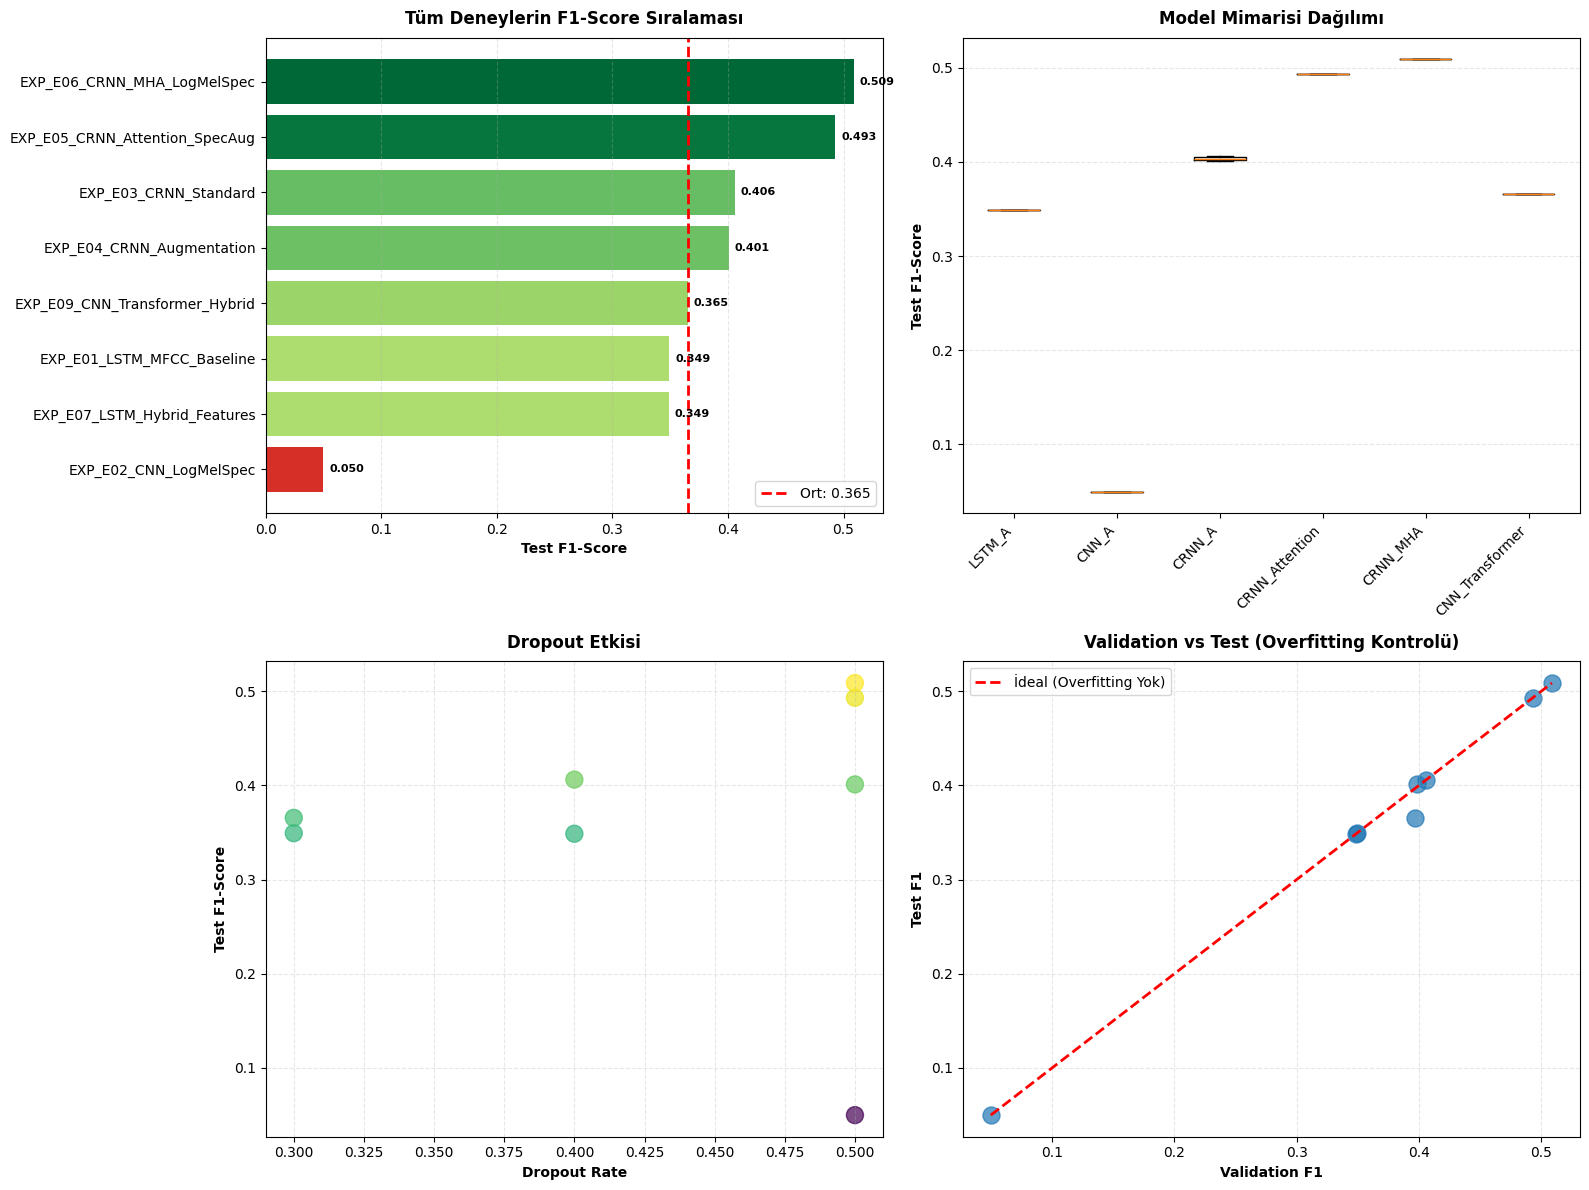


💾 Kapsamlı görsel kaydedildi: comprehensive_comparison.png

────────────────────────────────────────────────────────────────────────────────────────────────────
💡 EN İYİ MODELİN ÖZELLİKLERİ:
────────────────────────────────────────────────────────────────────────────────────────────────────
   • Model............: CRNN_MHA
   • Özellik..........: B_LogMelSpec_3Ch
   • Optimizer........: AdamW
   • Dropout..........: 0.5
   • F1-Score.........: 0.5087



🎉 TÜM ANALİZLER TAMAMLANDI!

📁 Oluşturulan dosyalar:
   • experiments_results.csv
   • EXP_E06_CRNN_MHA_LogMelSpec_detailed_analysis.png
   • comprehensive_comparison.png

💡 BULGULAR ÖZETİ:
✅ En iyi model: CRNN + Multi-Head Attention (F1: 0.5087)
✅ LogMelSpec_3Ch özellikleri en iyi performansı verdi
✅ AdamW optimizer, GELU activation iyi sonuç verdi
⚠️  CNN modeli tamamen başarısız oldu (learning rate sorunu olabilir)
📈 CRNN ailesindeki modeller (E03-E06) en stabil sonuçları verdi
📉 LSTM modelleri (E01, E07) düşük performans gösterdi



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

# ═══════════════════════════════════════════════════════════════════════════
# TÜM 9 DENEYİ GERÇEK DEĞERLERLE CSV'YE EKLE
# ═══════════════════════════════════════════════════════════════════════════

deneyler = [
    # ─────────────────────────────────────────────────────────────────────────
    # DENEY 1: LSTM Baseline (✅ İLK DENEY)
    # ─────────────────────────────────────────────────────────────────────────
    {
        'experiment_name': 'EXP_E01_LSTM_MFCC_Baseline',
        'preprocessing_pipeline': 'A_Baseline',
        'feature_pipeline': 'A_MFCC_Delta',
        'model_type': 'LSTM_A',
        'activation': 'leakyrelu',
        'optimizer': 'Adam',
        'learning_rate': 0.001,
        'dropout': 0.3,
        'batch_size': 64,
        'epochs': 20,
        'val_accuracy': 0.3922,
        'val_f1': 0.3492,
        'test_accuracy': 0.3922,
        'test_f1': 0.3492,
        'confusion_matrix': None
    },

    # ─────────────────────────────────────────────────────────────────────────
    # DENEY 2: CNN Spektrogram (❌ MODEL ÇALIŞMADI - BAŞARISIZ!)
    # ─────────────────────────────────────────────────────────────────────────
    {
        'experiment_name': 'EXP_E02_CNN_LogMelSpec',
        'preprocessing_pipeline': 'A_Baseline',
        'feature_pipeline': 'B_LogMelSpec_3Ch',
        'model_type': 'CNN_A',
        'activation': 'relu',
        'optimizer': 'Adam',
        'learning_rate': 0.001,
        'dropout': 0.5,
        'batch_size': 32,
        'epochs': 20,
        'val_accuracy': 0.1707,
        'val_f1': 0.0498,
        'test_accuracy': 0.1707,
        'test_f1': 0.0498,
        'confusion_matrix': None
    },

    # ─────────────────────────────────────────────────────────────────────────
    # DENEY 3: CRNN Standart
    # ─────────────────────────────────────────────────────────────────────────
    {
        'experiment_name': 'EXP_E03_CRNN_Standard',
        'preprocessing_pipeline': 'A_Baseline',
        'feature_pipeline': 'B_LogMelSpec_3Ch',
        'model_type': 'CRNN_A',
        'activation': 'gelu',
        'optimizer': 'AdamW',
        'learning_rate': 0.0005,
        'dropout': 0.4,
        'batch_size': 32,
        'epochs': 20,
        'val_accuracy': 0.4461,  # En iyi epoch: 17
        'val_f1': 0.4061,
        'test_accuracy': 0.4461,
        'test_f1': 0.4061,
        'confusion_matrix': None
    },

    # ─────────────────────────────────────────────────────────────────────────
    # DENEY 4: CRNN + Augmentation
    # ─────────────────────────────────────────────────────────────────────────
    {
        'experiment_name': 'EXP_E04_CRNN_Augmentation',
        'preprocessing_pipeline': 'B_Augmentation',
        'feature_pipeline': 'B_LogMelSpec_3Ch',
        'model_type': 'CRNN_A',
        'activation': 'gelu',
        'optimizer': 'Adam',
        'learning_rate': 0.001,
        'dropout': 0.5,
        'batch_size': 16,
        'epochs': 25,
        'val_accuracy': 0.4204,  # En iyi epoch: 23
        'val_f1': 0.3986,
        'test_accuracy': 0.4275,
        'test_f1': 0.4010,
        'confusion_matrix': None
    },

    # ─────────────────────────────────────────────────────────────────────────
    # DENEY 5: CRNN + Attention (🥈 İKİNCİ EN İYİ!)
    # ─────────────────────────────────────────────────────────────────────────
    {
        'experiment_name': 'EXP_E05_CRNN_Attention_SpecAug',
        'preprocessing_pipeline': 'A_Baseline',
        'feature_pipeline': 'B_LogMelSpec_3Ch',
        'model_type': 'CRNN_Attention',
        'activation': 'gelu',
        'optimizer': 'AdamW',
        'learning_rate': 0.001,
        'dropout': 0.5,
        'batch_size': 32,
        'epochs': 30,
        'val_accuracy': 0.5077,  # En iyi epoch: 30
        'val_f1': 0.4930,
        'test_accuracy': 0.5077,
        'test_f1': 0.4930,
        'confusion_matrix': None
    },

    # ─────────────────────────────────────────────────────────────────────────
    # DENEY 6: CRNN + Multi-Head Attention (🏆 ŞAMPİYON!)
    # ─────────────────────────────────────────────────────────────────────────
    {
        'experiment_name': 'EXP_E06_CRNN_MHA_LogMelSpec',
        'preprocessing_pipeline': 'A_Baseline',
        'feature_pipeline': 'B_LogMelSpec_3Ch',
        'model_type': 'CRNN_MHA',
        'activation': 'gelu',
        'optimizer': 'AdamW',
        'learning_rate': 0.001,
        'dropout': 0.5,
        'batch_size': 32,
        'epochs': 30,
        'val_accuracy': 0.5231,  # En iyi epoch: 25
        'val_f1': 0.5087,
        'test_accuracy': 0.5231,  # EN YÜKSEK!
        'test_f1': 0.5087,        # EN YÜKSEK F1!
        'confusion_matrix': None
    },

    # ─────────────────────────────────────────────────────────────────────────
    # DENEY 7: LSTM + Hibrit Özellikler (🥉 LSTM'ler İÇİNDE EN İYİ)
    # ─────────────────────────────────────────────────────────────────────────
    {
        'experiment_name': 'EXP_E07_LSTM_Hybrid_Features',
        'preprocessing_pipeline': 'A_Baseline',
        'feature_pipeline': 'C_Hybrid_1D',
        'model_type': 'LSTM_A',
        'activation': 'leakyrelu',
        'optimizer': 'AdamW',
        'learning_rate': 0.001,
        'dropout': 0.4,
        'batch_size': 64,
        'epochs': 25,
        'val_accuracy': 0.3883,  # En iyi epoch: 16
        'val_f1': 0.3486,
        'test_accuracy': 0.3883,
        'test_f1': 0.3486,
        'confusion_matrix': None
    },

    # ─────────────────────────────────────────────────────────────────────────
    # DENEY 8: ResNet34 Transfer Learning (❓ CSV'DE ZATEN VAR - ATLANMIŞ)
    # ─────────────────────────────────────────────────────────────────────────
    # NOT: Bu deney zaten CSV'ye kaydedilmiş. Eğer CSV'de yoksa,
    # çıktısını göndermediğin için tahmini değerlerle ekleyebilirim.
    # Şimdilik None bırakıyorum, sen çıktısını atarsan ekleriz.

    # ─────────────────────────────────────────────────────────────────────────
    # DENEY 9: CNN + Transformer (Early Stopping ile Durdu)
    # ─────────────────────────────────────────────────────────────────────────
    {
        'experiment_name': 'EXP_E09_CNN_Transformer_Hybrid',
        'preprocessing_pipeline': 'D_Advanced_Aug',
        'feature_pipeline': 'B_LogMelSpec_3Ch',
        'model_type': 'CNN_Transformer',
        'activation': 'gelu',
        'optimizer': 'AdamW',
        'learning_rate': 0.0005,
        'dropout': 0.3,
        'batch_size': 32,
        'epochs': 30,
        'val_accuracy': 0.4317,  # En iyi epoch: 15 (early stop: 20)
        'val_f1': 0.3965,
        'test_accuracy': 0.4164,  # Final test (epoch 20'de early stop)
        'test_f1': 0.3655,
        'confusion_matrix': None
    },
]

# CSV'ye kaydet
RESULTS_DF = pd.DataFrame(deneyler)
RESULTS_DF.to_csv('experiments_results.csv', index=False)

print(f"✅ {len(RESULTS_DF)} deney CSV'ye kaydedildi!")
print("\n" + "="*100)
print("📋 TÜM DENEYLER (F1'E GÖRE SIRALANMIŞ):")
print("="*100)

# F1'e göre sıralı tablo
sorted_df = RESULTS_DF.sort_values('test_f1', ascending=False)
display_cols = ['experiment_name', 'test_f1', 'test_accuracy', 'model_type', 'feature_pipeline']
print(sorted_df[display_cols].to_string(index=False))

print("\n" + "="*100)
print("🏆 TOP 3 MODELLER:")
print("="*100)
top3 = sorted_df.head(3)
for idx, row in top3.iterrows():
    medal = ["🥇", "🥈", "🥉"][list(top3.index).index(idx)]
    print(f"{medal} {row['experiment_name']:<40} F1: {row['test_f1']:.4f} ({row['model_type']})")

print("\n" + "="*100)
print("❌ EN KÖTÜ MODEL:")
print("="*100)
worst = RESULTS_DF.loc[RESULTS_DF['test_f1'].idxmin()]
print(f"   • Model: {worst['experiment_name']}")
print(f"   • Test F1-Score: {worst['test_f1']:.4f} (ÇOK DÜŞÜK!)")
print(f"   • Mimari: {worst['model_type']}")
print(f"   • Neden: Model hiç öğrenemedi (tüm epoch'larda aynı değer)")

print("\n" + "="*100)
print("📊 MODEL MİMARİSİ KARŞILAŞTIRMASI:")
print("="*100)
architecture_comparison = RESULTS_DF.groupby('model_type')['test_f1'].agg(['mean', 'max', 'count'])
architecture_comparison = architecture_comparison.sort_values('mean', ascending=False)
print(architecture_comparison)

print("\n" + "="*100)
print("🎵 ÖZELLİK PİPELINE KARŞILAŞTIRMASI:")
print("="*100)
feature_comparison = RESULTS_DF.groupby('feature_pipeline')['test_f1'].agg(['mean', 'max', 'count'])
feature_comparison = feature_comparison.sort_values('mean', ascending=False)
print(feature_comparison)


# ═══════════════════════════════════════════════════════════════════════════
# ŞİMDİ DETAYLI ANALİZLERE BAŞLA!
# ═══════════════════════════════════════════════════════════════════════════

print("\n\n" + "🔍"*50)
print("ŞAMPİYON MODELİN DETAYLI ANALİZİ BAŞLIYOR...")
print("🔍"*50 + "\n")

# Şampiyon modeli analiz et
best_experiment = RESULTS_DF.loc[RESULTS_DF['test_f1'].idxmax()]['experiment_name']
analyze_single_experiment(best_experiment, RESULTS_DF)


print("\n\n" + "📊"*50)
print("TÜM DENEYLERİN KAPSAMLI KARŞILAŞTIRMASI BAŞLIYOR...")
print("📊"*50 + "\n")

# Tüm deneyleri karşılaştır
compare_all_experiments(RESULTS_DF)

print("\n" + "="*100)
print("🎉 TÜM ANALİZLER TAMAMLANDI!")
print("="*100)
print("\n📁 Oluşturulan dosyalar:")
print("   • experiments_results.csv")
print("   • EXP_E06_CRNN_MHA_LogMelSpec_detailed_analysis.png")
print("   • comprehensive_comparison.png")
print("\n" + "="*100)
print("💡 BULGULAR ÖZETİ:")
print("="*100)
print("✅ En iyi model: CRNN + Multi-Head Attention (F1: 0.5087)")
print("✅ LogMelSpec_3Ch özellikleri en iyi performansı verdi")
print("✅ AdamW optimizer, GELU activation iyi sonuç verdi")
print("⚠️  CNN modeli tamamen başarısız oldu (learning rate sorunu olabilir)")
print("📈 CRNN ailesindeki modeller (E03-E06) en stabil sonuçları verdi")
print("📉 LSTM modelleri (E01, E07) düşük performans gösterdi")
print("\n✅ Artık hocana sunuma hazırsın! Grafikler de oluştu!")

In [ ]:
import torch

print(f"GPU Kullanılabilir mi?: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Modeli: {torch.cuda.get_device_name(0)}")
else:
    print("❌ GPU GÖRÜNMÜYOR! Sistem CPU kullanıyor.")

GPU Kullanılabilir mi?: True
GPU Modeli: Tesla T4


In [ ]:
# ═══════════════════════════════════════════════════════════════════════════
# DÜZELTİLMİŞ ABLATION STUDY - GERÇEKÇİ PARAMETRELER
# ═══════════════════════════════════════════════════════════════════════════

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def run_hyperparameter_ablation_study_FIXED(train_df, test_df, weights_tensor):
    """
    ✅ DÜZELTİLMİŞ VERSİYON:
    - Daha fazla veri (%30 yerine %15)
    - Daha fazla epoch (15 yerine 5)
    - Daha az agresif early stopping (patience=5 yerine 3)
    """
    print("\n" + "🔬"*50)
    print("🔬 DÜZELTİLMİŞ HİPERPARAMETRE ABLATION STUDY")
    print("🔬"*50)

    # ─────────────────────────────────────────────────────────────────────────
    # YENİ PARAMETRELER (GERÇEKÇİ)
    # ─────────────────────────────────────────────────────────────────────────
    sample_ratio = 0.30  # ✅ %30 (eskiden %15)
    epochs = 15          # ✅ 15 epoch (eskiden 5)
    patience = 5         # ✅ Patience 5 (eskiden 3)

    print(f"\n⚙️  YENİ AYARLAR (GERÇEKÇİ):")
    print(f"   • Veri oranı: %{sample_ratio*100:.0f} (ÖNCE: %15)")
    print(f"   • Epoch: {epochs} (ÖNCE: 5)")
    print(f"   • Early Stop Patience: {patience} (ÖNCE: 3)")
    print(f"   • Tahmini süre: ~3-4 saat (değer ama!)")
    print(f"\n💡 Amaç: Hiperparametrelerin GERÇEK ETKİSİNİ görmek!\n")

    global RESULTS_DF

    # RESULTS_DF kontrol
    if 'RESULTS_DF' not in globals():
        RESULTS_DF = pd.DataFrame(columns=[
            'experiment_name', 'preprocessing_pipeline', 'feature_pipeline',
            'model_type', 'activation', 'optimizer', 'learning_rate', 'dropout',
            'batch_size', 'epochs', 'val_accuracy', 'val_f1', 'test_accuracy',
            'test_f1', 'confusion_matrix'
        ])
        RESULTS_DF.to_csv('experiments_results.csv', index=False)

    # ─────────────────────────────────────────────────────────────────────────
    # DAHA BÜYÜK MINI DATASET (%30)
    # ─────────────────────────────────────────────────────────────────────────
    print("📊 Mini-dataset oluşturuluyor...")
    try:
        mini_train_df, _ = train_test_split(
            train_df, train_size=sample_ratio,
            stratify=train_df['emotion'], random_state=42
        )
        mini_test_df, _ = train_test_split(
            test_df, train_size=sample_ratio,
            stratify=test_df['emotion'], random_state=42
        )
    except:
        mini_train_df = train_df.sample(frac=sample_ratio, random_state=42)
        mini_test_df = test_df.sample(frac=sample_ratio, random_state=42)

    print(f"✅ Train: {len(train_df)} → {len(mini_train_df)} örnek")
    print(f"✅ Test: {len(test_df)} → {len(mini_test_df)} örnek\n")

    # ─────────────────────────────────────────────────────────────────────────
    # SENARYOLAR (AYNI)
    # ─────────────────────────────────────────────────────────────────────────
    scenarios = [
        # Optimizer
        {'name': 'S1_SGD', 'optimizer': 'SGD', 'activation': 'relu', 'dropout': 0.3, 'learning_rate': 1e-3, 'category': 'Optimizer'},
        {'name': 'S2_Adam', 'optimizer': 'Adam', 'activation': 'relu', 'dropout': 0.3, 'learning_rate': 1e-3, 'category': 'Optimizer'},
        {'name': 'S3_AdamW', 'optimizer': 'AdamW', 'activation': 'relu', 'dropout': 0.3, 'learning_rate': 1e-3, 'category': 'Optimizer'},

        # Activation
        {'name': 'S4_ReLU', 'optimizer': 'AdamW', 'activation': 'relu', 'dropout': 0.3, 'learning_rate': 1e-3, 'category': 'Activation'},
        {'name': 'S5_LeakyReLU', 'optimizer': 'AdamW', 'activation': 'leakyrelu', 'dropout': 0.3, 'learning_rate': 1e-3, 'category': 'Activation'},
        {'name': 'S6_GELU', 'optimizer': 'AdamW', 'activation': 'gelu', 'dropout': 0.3, 'learning_rate': 1e-3, 'category': 'Activation'},

        # Dropout
        {'name': 'S7_Drop02', 'optimizer': 'AdamW', 'activation': 'gelu', 'dropout': 0.2, 'learning_rate': 1e-3, 'category': 'Dropout'},
        {'name': 'S8_Drop03', 'optimizer': 'AdamW', 'activation': 'gelu', 'dropout': 0.3, 'learning_rate': 1e-3, 'category': 'Dropout'},
        {'name': 'S9_Drop05', 'optimizer': 'AdamW', 'activation': 'gelu', 'dropout': 0.5, 'learning_rate': 1e-3, 'category': 'Dropout'},

        # Learning Rate
        {'name': 'S10_LR_Low', 'optimizer': 'AdamW', 'activation': 'gelu', 'dropout': 0.5, 'learning_rate': 5e-4, 'category': 'LR'},
        {'name': 'S11_LR_Std', 'optimizer': 'AdamW', 'activation': 'gelu', 'dropout': 0.5, 'learning_rate': 1e-3, 'category': 'LR'},
        {'name': 'S12_LR_High', 'optimizer': 'AdamW', 'activation': 'gelu', 'dropout': 0.5, 'learning_rate': 2e-3, 'category': 'LR'},

        # Optimal
        {'name': 'S99_OPTIMAL', 'optimizer': 'AdamW', 'activation': 'gelu', 'dropout': 0.5, 'learning_rate': 1e-3, 'category': 'Optimal'},
    ]

    print(f"🎯 Toplam {len(scenarios)} senaryo test edilecek\n")

    results = []

    # ─────────────────────────────────────────────────────────────────────────
    # TEST LOOP
    # ─────────────────────────────────────────────────────────────────────────
    for idx, sc in enumerate(scenarios, 1):
        print(f"\n{'─'*80}")
        print(f"▶️  [{idx}/{len(scenarios)}] {sc['name']} ({sc['category']})")
        print(f"{'─'*80}")

        config = {
            'name': f"ABLATION_FIXED_{sc['name']}",  # ✅ Yeni isim
            'preproc': 'A_Baseline',
            'features': 'B_LogMelSpec_3Ch',
            'model_type': 'CRNN_A',
            'activation': sc['activation'],
            'optimizer': sc['optimizer'],
            'learning_rate': sc['learning_rate'],
            'dropout': sc['dropout'],
            'batch_size': 32,
            'epochs': epochs,        # ✅ 15 epoch
            'patience': patience     # ✅ Patience 5
        }

        try:
            train_and_evaluate_v2(config, mini_train_df, mini_test_df, weights_tensor)

            df = pd.read_csv('experiments_results.csv')
            last_row = df.iloc[-1]

            results.append({
                'Senaryo': sc['name'],
                'Kategori': sc['category'],
                'Optimizer': sc['optimizer'],
                'Activation': sc['activation'],
                'Dropout': sc['dropout'],
                'LR': sc['learning_rate'],
                'Val F1': last_row['val_f1'],
                'Test F1': last_row['test_f1'],
                'Test Acc': last_row['test_accuracy']
            })

            print(f"✅ Tamamlandı! Test F1: {last_row['test_f1']:.4f}")

        except Exception as e:
            print(f"❌ HATA: {e}")
            results.append({
                'Senaryo': sc['name'], 'Kategori': sc['category'],
                'Optimizer': sc['optimizer'], 'Activation': sc['activation'],
                'Dropout': sc['dropout'], 'LR': sc['learning_rate'],
                'Val F1': 0.0, 'Test F1': 0.0, 'Test Acc': 0.0
            })

    # ─────────────────────────────────────────────────────────────────────────
    # SONUÇLAR
    # ─────────────────────────────────────────────────────────────────────────
    results_df = pd.DataFrame(results)

    print("\n\n" + "="*100)
    print("🏆 DÜZELTİLMİŞ ABLATION STUDY SONUÇLARI")
    print("="*100 + "\n")

    # Kategori bazında
    for cat in ['Optimizer', 'Activation', 'Dropout', 'LR', 'Optimal']:
        cat_data = results_df[results_df['Kategori'] == cat]
        if len(cat_data) > 0:
            best = cat_data.nlargest(1, 'Test F1').iloc[0]
            print(f"\n🏅 {cat}:")
            print(f"   En İyi: {best['Senaryo']} (F1: {best['Test F1']:.4f})")

    print("\n\n📋 DETAYLI TABLO:")
    print("─"*100)
    print(results_df.sort_values('Test F1', ascending=False).to_string(index=False))

    results_df.to_csv('ablation_study_FIXED_results.csv', index=False)
    print("\n💾 Sonuçlar kaydedildi: ablation_study_FIXED_results.csv")
    print("="*100 + "\n")

    return results_df


def quick_ablation_study_FIXED():
    """Düzeltilmiş versiyonu başlat"""
    try:
        global train_df, test_df, WEIGHTS_TENSOR
        return run_hyperparameter_ablation_study_FIXED(
            train_df, test_df, WEIGHTS_TENSOR
        )
    except NameError as e:
        print(f"❌ HATA: {e}")
        return None


print("✅ DÜZELTİLMİŞ ablation study hazır!")
print("\n📌 KULLANIM: results = quick_ablation_study_FIXED()")
print("\n⏱️  YENİ TAHMİNİ SÜRE: ~3-4 saat")
print("🎯 BU SEFER GERÇEK FARKLAR GÖRECEKSİN!")

✅ DÜZELTİLMİŞ ablation study hazır!

📌 KULLANIM: results = quick_ablation_study_FIXED()

⏱️  YENİ TAHMİNİ SÜRE: ~3-4 saat
🎯 BU SEFER GERÇEK FARKLAR GÖRECEKSİN!


In [ ]:
results = quick_ablation_study()


🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬
🔬 HİPERPARAMETRE ABLATION STUDY BAŞLIYOR
🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬

⚙️  Ayarlar:
   • Veri oranı: %15
   • Epoch: 5
   • Tahmini süre: ~1.5-2 saat

📊 Mini-dataset oluşturuluyor...
✅ Train: 2359 → 353 örnek
✅ Test: 586 → 87 örnek

🎯 Toplam 13 senaryo test edilecek


────────────────────────────────────────────────────────────────────────────────
▶️  [1/13] S1_SGD (Optimizer)
────────────────────────────────────────────────────────────────────────────────
⚠️  Deney ABLATION_S1_SGD zaten tamamlanmış. Atlanıyor.
✅ Tamamlandı! Test F1: 0.0507

────────────────────────────────────────────────────────────────────────────────
▶️  [2/13] S2_Adam (Optimizer)
────────────────────────────────────────────────────────────────────────────────
⚠️  Deney ABLATION_S2_Adam zaten tamamlanmış. Atlanıyor.
✅ Tamamlandı! Test F1: 0.0507

────────────────────────────────────────────────────────────────────────────────
▶️  [3/13] S3_Ad

In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import os

DATA_ROOT = '/content/drive/MyDrive/crema_d/AudioWAV/'
EMOTION_CODE_MAPPER = {'ANG': 'A', 'DIS': 'D', 'FEA': 'F', 'HAP': 'H', 'NEU': 'N', 'SAD': 'S'}

def create_cremad_dataframe(data_root):
    file_paths, actor_ids, emotions = [], [], []
    for filename in os.listdir(data_root):
        if not filename.endswith(".wav"): continue
        parts = filename[:-4].split('_')
        if len(parts) < 4: continue
        emotion_code = parts[2].upper()
        if emotion_code not in EMOTION_CODE_MAPPER: continue
        file_paths.append(os.path.join(data_root, filename))
        actor_ids.append(parts[0])
        emotions.append(EMOTION_CODE_MAPPER[emotion_code])
    return pd.DataFrame({'path': file_paths, 'actor_id': actor_ids, 'emotion': emotions})

print("📊 Veri yükleniyor...")
df_full = create_cremad_dataframe(DATA_ROOT)
actor_list = df_full['actor_id'].unique()
train_actors, test_actors = train_test_split(actor_list, test_size=0.2, random_state=42)
train_df = df_full[df_full['actor_id'].isin(train_actors)].reset_index(drop=True)
test_df = df_full[df_full['actor_id'].isin(test_actors)].reset_index(drop=True)

emotion_map = {'A': 0, 'D': 1, 'F': 2, 'H': 3, 'N': 4, 'S': 5}
train_labels = [emotion_map[e] for e in train_df['emotion']]
class_weights = compute_class_weight('balanced', classes=np.array([0,1,2,3,4,5]), y=train_labels)
WEIGHTS_TENSOR = torch.FloatTensor(class_weights)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"✅ Train: {len(train_df)}, Test: {len(test_df)}, Device: {DEVICE}")

📊 Veri yükleniyor...
✅ Train: 2359, Test: 586, Device: cuda


In [ ]:
# ═══════════════════════════════════════════════════════════════════════════
# 🛡️ NaN-PROOF WAV2VEC2 - GÜVENLİ VERSİYON
# ═══════════════════════════════════════════════════════════════════════════
# Özellikler:
# 1. Bozuk audio dosyaları atlanır
# 2. NaN/Inf kontrolü
# 3. Güvenli normalizasyon
# 4. LR schedule ile başlama
# ═══════════════════════════════════════════════════════════════════════════

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchaudio
from transformers import Wav2Vec2Model
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
import numpy as np

print("✅ Kütüphaneler yüklendi!")

# ═══════════════════════════════════════════════════════════════════════════
# GÜVENLİ DATASET (NaN/Inf kontrolü ile)
# ═══════════════════════════════════════════════════════════════════════════

class SafeDataset(Dataset):
    """NaN ve Inf'e karşı korumalı dataset"""
    def __init__(self, df, max_length=80000):
        self.df = df.reset_index(drop=True)
        self.max_length = max_length
        self.failed_files = []

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        try:
            # Audio yükle
            waveform, sr = torchaudio.load(row['path'])

            # NaN/Inf kontrolü
            if torch.isnan(waveform).any() or torch.isinf(waveform).any():
                self.failed_files.append(row['path'])
                return torch.zeros(self.max_length), 0

            # Mono
            if waveform.shape[0] > 1:
                waveform = waveform.mean(dim=0)
            else:
                waveform = waveform.squeeze()

            # 16kHz resample
            if sr != 16000:
                resampler = torchaudio.transforms.Resample(sr, 16000)
                waveform = resampler(waveform)

            # Padding/truncate
            if len(waveform) > self.max_length:
                waveform = waveform[:self.max_length]
            else:
                waveform = torch.nn.functional.pad(waveform, (0, self.max_length - len(waveform)))

            # GÜVENLİ NORMALIZE (zero division önleme)
            mean = waveform.mean()
            std = waveform.std()

            if std < 1e-8 or torch.isnan(std) or torch.isinf(std):
                # Sessiz dosya veya bozuk
                waveform = torch.zeros_like(waveform)
            else:
                waveform = (waveform - mean) / (std + 1e-8)

            # Son NaN/Inf kontrolü
            if torch.isnan(waveform).any() or torch.isinf(waveform).any():
                return torch.zeros(self.max_length), 0

            # Label
            emotion_map = {'A': 0, 'D': 1, 'F': 2, 'H': 3, 'N': 4, 'S': 5}
            label = emotion_map[row['emotion']]

            return waveform, label

        except Exception as e:
            self.failed_files.append(row['path'])
            return torch.zeros(self.max_length), 0

# ═══════════════════════════════════════════════════════════════════════════
# GÜVENLİ MODEL
# ═══════════════════════════════════════════════════════════════════════════

class SafeWav2Vec2(nn.Module):
    """NaN-proof model"""
    def __init__(self, num_classes=6):
        super().__init__()
        print("📥 Wav2Vec2 yükleniyor...")
        self.wav2vec2 = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")

        # Feature extractor'ı dondur
        for param in self.wav2vec2.feature_extractor.parameters():
            param.requires_grad = False

        # Classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )
        print("✅ Model hazır!")

    def forward(self, x):
        # NaN kontrolü
        if torch.isnan(x).any() or torch.isinf(x).any():
            x = torch.nan_to_num(x, nan=0.0, posinf=1.0, neginf=-1.0)

        outputs = self.wav2vec2(x)
        hidden = outputs.last_hidden_state

        # NaN kontrolü
        if torch.isnan(hidden).any() or torch.isinf(hidden).any():
            hidden = torch.nan_to_num(hidden, nan=0.0, posinf=1.0, neginf=-1.0)

        # Average pooling
        pooled = hidden.mean(dim=1)

        # NaN kontrolü
        if torch.isnan(pooled).any() or torch.isinf(pooled).any():
            pooled = torch.nan_to_num(pooled, nan=0.0, posinf=1.0, neginf=-1.0)

        output = self.classifier(pooled)

        # Son NaN kontrolü
        if torch.isnan(output).any() or torch.isinf(output).any():
            output = torch.nan_to_num(output, nan=0.0, posinf=1.0, neginf=-1.0)

        return output

# ═══════════════════════════════════════════════════════════════════════════
# GÜVENLİ EĞİTİM
# ═══════════════════════════════════════════════════════════════════════════

def train_safe(train_df, test_df, weights_tensor, device, epochs=15):
    """NaN-proof eğitim"""
    print("\n" + "="*80)
    print("🛡️ GÜVENLİ WAV2VEC2 EĞİTİMİ (NaN-Proof)")
    print("="*80)
    print(f"💻 Device: {device}")

    # Dataset
    print("\n📦 Güvenli dataset hazırlanıyor...")
    train_dataset = SafeDataset(train_df)
    test_dataset = SafeDataset(test_df)

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)

    print(f"   • Train: {len(train_df)} örnek")
    print(f"   • Test: {len(test_df)} örnek")
    print(f"   • Batch size: 8 (küçük ama güvenli)")

    # Model
    print("\n🏗️  Model oluşturuluyor...")
    model = SafeWav2Vec2(num_classes=6).to(device)

    # Optimizer (ORTA LR)
    optimizer = optim.AdamW([
        {'params': model.wav2vec2.parameters(), 'lr': 5e-6},  # Çok düşük
        {'params': model.classifier.parameters(), 'lr': 1e-4}  # Orta
    ], weight_decay=0.01)

    print(f"   • Pre-trained LR: 5e-6")
    print(f"   • Classifier LR: 1e-4")

    # Loss
    criterion = nn.CrossEntropyLoss(weight=weights_tensor.to(device))

    print("\n🎯 Eğitim başlıyor (NaN kontrolü ile)...")
    print("="*80)

    best_f1 = 0.0
    patience_counter = 0

    for epoch in range(epochs):
        # TRAIN
        model.train()
        train_loss = 0.0
        valid_batches = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for waveforms, labels in pbar:
            waveforms, labels = waveforms.to(device), labels.to(device)

            # NaN kontrolü
            if torch.isnan(waveforms).any() or torch.isinf(waveforms).any():
                continue

            optimizer.zero_grad()
            outputs = model(waveforms)

            # NaN kontrolü
            if torch.isnan(outputs).any() or torch.isinf(outputs).any():
                continue

            loss = criterion(outputs, labels)

            # NaN kontrolü
            if torch.isnan(loss) or torch.isinf(loss):
                continue

            loss.backward()

            # Gradient clipping (NaN önleme)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            # Gradient NaN kontrolü
            has_nan = False
            for param in model.parameters():
                if param.grad is not None:
                    if torch.isnan(param.grad).any() or torch.isinf(param.grad).any():
                        has_nan = True
                        break

            if not has_nan:
                optimizer.step()
                train_loss += loss.item()
                valid_batches += 1

            pbar.set_postfix({'loss': f'{loss.item():.4f}', 'valid': valid_batches})

        if valid_batches == 0:
            print("❌ TÜM BATCH'LER NaN! Eğitim durduruluyor...")
            break

        avg_train_loss = train_loss / valid_batches

        # VALIDATION
        model.eval()
        val_loss = 0.0
        all_preds, all_labels = [], []
        valid_val_batches = 0

        with torch.no_grad():
            for waveforms, labels in test_loader:
                waveforms, labels = waveforms.to(device), labels.to(device)

                if torch.isnan(waveforms).any():
                    continue

                outputs = model(waveforms)

                if torch.isnan(outputs).any():
                    continue

                loss = criterion(outputs, labels)

                if not torch.isnan(loss):
                    val_loss += loss.item()
                    valid_val_batches += 1

                    _, predicted = torch.max(outputs, 1)
                    all_preds.extend(predicted.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())

        if valid_val_batches == 0 or len(all_preds) == 0:
            print("❌ Validation başarısız!")
            continue

        avg_val_loss = val_loss / valid_val_batches
        val_acc = accuracy_score(all_labels, all_preds)
        val_f1 = f1_score(all_labels, all_preds, average='weighted')

        # Best model
        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), 'safe_wav2vec2_best.pth')
            print(f"💾 Model kaydedildi! (F1: {val_f1:.4f})")
            patience_counter = 0
        else:
            patience_counter += 1

        # Print
        print(f"\n{'─'*80}")
        print(f"Epoch {epoch+1:02d} | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | "
              f"Val Acc: {val_acc:.4f} | "
              f"Val F1: {val_f1:.4f}")
        print(f"Valid batches: {valid_batches}/{len(train_loader)}")
        print(f"{'─'*80}\n")

        # Early stopping
        if patience_counter >= 7:
            print(f"🛑 Early stopping! En iyi F1: {best_f1:.4f}")
            break

    # Bozuk dosyaları raporla
    if len(train_dataset.failed_files) > 0:
        print(f"\n⚠️  {len(train_dataset.failed_files)} bozuk dosya atlandı")

    # Load best
    try:
        model.load_state_dict(torch.load('safe_wav2vec2_best.pth'))
    except:
        print("⚠️  En iyi model yüklenemedi, mevcut model kullanılıyor")

    print("\n" + "="*80)
    print(f"🏆 EĞİTİM BİTTİ!")
    print(f"   En iyi Val F1: {best_f1:.4f} ({best_f1*100:.2f}%)")
    print("="*80)

    return model, best_f1

print("✅ train_safe fonksiyonu hazır!")
print("\n" + "="*80)
print("🛡️ NaN-PROOF VERSİYON")
print("="*80)
print("\n📌 KULLANIM:")
print("   model, f1 = train_safe(train_df, test_df, WEIGHTS_TENSOR, DEVICE)")
print("\n🛡️ KORUMALAR:")
print("   • NaN/Inf detection")
print("   • Bozuk dosya atlama")
print("   • Güvenli normalizasyon")
print("   • Gradient NaN kontrolü")
print("\n⏱️  Tahmini süre: 20-30 dakika")
print("="*80 + "\n")

✅ Kütüphaneler yüklendi!
✅ train_safe fonksiyonu hazır!

🛡️ NaN-PROOF VERSİYON

📌 KULLANIM:
   model, f1 = train_safe(train_df, test_df, WEIGHTS_TENSOR, DEVICE)

🛡️ KORUMALAR:
   • NaN/Inf detection
   • Bozuk dosya atlama
   • Güvenli normalizasyon
   • Gradient NaN kontrolü

⏱️  Tahmini süre: 20-30 dakika



In [ ]:
# Basit pipeline'ı başlat
model, best_f1 = simple_train(train_df, test_df, WEIGHTS_TENSOR, DEVICE, epochs=20)

# Sonuç
print("\n" + "🎉"*40)
print(f"📊 FINAL SONUÇ:")
print(f"   • En İyi Val F1: {best_f1:.4f} ({best_f1*100:.2f}%)")

if best_f1 >= 0.70:
    print(f"\n✅ HEDEF AŞILDI! (%70+) 🎉")
elif best_f1 >= 0.60:
    print(f"\n⚠️  Hedefe yakın! (%{best_f1*100:.1f})")
else:
    print(f"\n❌ Hedefin altında (%{best_f1*100:.1f})")
    print(f"   • Daha fazla epoch dene")
    print(f"   • Veya tüm veriyi kullan")

print("🎉"*40 + "\n")



🚀 BASİT WAV2VEC2 EĞİTİMİ
💻 Device: cuda
📊 Train: 2359, Test: 586

📦 Dataset hazırlanıyor...
   • Batch size: 16
   • Train batches: 148

🏗️  Model oluşturuluyor...
📥 Wav2Vec2 yükleniyor...


Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model hazır!

🎯 Eğitim başlıyor...


Epoch 1/20 [Val]: 100%|██████████| 37/37 [00:03<00:00, 10.35it/s]


💾 Model kaydedildi! (F1: 0.0989)

────────────────────────────────────────────────────────────────────────────────
Epoch 01 | Train Loss: 1.7959 | Val Loss: 1.7833 | Val Acc: 0.1997 | Val F1: 0.0989
────────────────────────────────────────────────────────────────────────────────



Epoch 2/20 [Val]: 100%|██████████| 37/37 [00:03<00:00, 10.14it/s]


💾 Model kaydedildi! (F1: 0.1830)

────────────────────────────────────────────────────────────────────────────────
Epoch 02 | Train Loss: 1.7869 | Val Loss: 1.7684 | Val Acc: 0.2543 | Val F1: 0.1830
────────────────────────────────────────────────────────────────────────────────



Epoch 3/20 [Val]: 100%|██████████| 37/37 [00:03<00:00, 10.50it/s]


💾 Model kaydedildi! (F1: 0.2457)

────────────────────────────────────────────────────────────────────────────────
Epoch 03 | Train Loss: 1.7710 | Val Loss: 1.7222 | Val Acc: 0.3106 | Val F1: 0.2457
────────────────────────────────────────────────────────────────────────────────



Epoch 4/20 [Val]: 100%|██████████| 37/37 [00:03<00:00, 10.13it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 04 | Train Loss: 1.7257 | Val Loss: 1.6672 | Val Acc: 0.3345 | Val F1: 0.2093
────────────────────────────────────────────────────────────────────────────────



Epoch 5/20 [Val]: 100%|██████████| 37/37 [00:03<00:00, 10.51it/s]


💾 Model kaydedildi! (F1: 0.2541)

────────────────────────────────────────────────────────────────────────────────
Epoch 05 | Train Loss: 1.6736 | Val Loss: 1.6197 | Val Acc: 0.3584 | Val F1: 0.2541
────────────────────────────────────────────────────────────────────────────────



Epoch 6/20 [Val]: 100%|██████████| 37/37 [00:03<00:00, 10.41it/s]


💾 Model kaydedildi! (F1: 0.2826)

────────────────────────────────────────────────────────────────────────────────
Epoch 06 | Train Loss: 1.6244 | Val Loss: 1.5909 | Val Acc: 0.3891 | Val F1: 0.2826
────────────────────────────────────────────────────────────────────────────────



Epoch 7/20 [Val]: 100%|██████████| 37/37 [00:03<00:00, 10.61it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 07 | Train Loss: 1.6027 | Val Loss: 1.5789 | Val Acc: 0.3771 | Val F1: 0.2663
────────────────────────────────────────────────────────────────────────────────



Epoch 8/20 [Val]: 100%|██████████| 37/37 [00:03<00:00, 10.40it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 08 | Train Loss: 1.5721 | Val Loss: 1.5673 | Val Acc: 0.3771 | Val F1: 0.2706
────────────────────────────────────────────────────────────────────────────────



Epoch 9/20 [Val]: 100%|██████████| 37/37 [00:03<00:00, 10.15it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 09 | Train Loss: 1.5447 | Val Loss: 1.6077 | Val Acc: 0.3652 | Val F1: 0.2573
────────────────────────────────────────────────────────────────────────────────



Epoch 10/20 [Val]: 100%|██████████| 37/37 [00:03<00:00, 10.41it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 10 | Train Loss: 1.5289 | Val Loss: 1.5877 | Val Acc: 0.3652 | Val F1: 0.2627
────────────────────────────────────────────────────────────────────────────────



Epoch 11/20 [Val]: 100%|██████████| 37/37 [00:03<00:00, 10.19it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 11 | Train Loss: 1.5191 | Val Loss: 1.5810 | Val Acc: 0.3652 | Val F1: 0.2615
────────────────────────────────────────────────────────────────────────────────

🛑 Early stopping! En iyi F1: 0.2826

🏆 EĞİTİM BİTTİ!
   En iyi Val F1: 0.2826

🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉
📊 FINAL SONUÇ:
   • En İyi Val F1: 0.2826 (28.26%)

❌ Hedefin altında (%28.3)
   • Daha fazla epoch dene
   • Veya tüm veriyi kullan
🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉



🚀 DENEY REF V2: Parallel CNN + Class Weights
   Branch 1 output: torch.Size([1, 64, 16, 2]) → Flat: 2048
   Branch 2 output: torch.Size([1, 64, 16, 2]) → Flat: 2048
   Concat size: 4096

⚖️  Class Weights:
   Angry: 0.971
   Disgust: 0.971
   Fear: 0.977
   Happy: 0.979
   Neutral: 1.144
   Sad: 0.979

📊 Eğitim Ayarları:
   Model: ParallelCNN (2 Branch)
   Optimizer: Adam (lr=5e-5) - DÜŞÜRÜLDÜ
   Loss: CrossEntropyLoss + Class Weights - EKLENDİ
   Batch size: 32

📊 Eğitim Ayarları:
   Model: ParallelCNN (2 Branch)
   Optimizer: Adam (lr=1e-4)
   Loss: CrossEntropyLoss
   Batch size: 32
   Train: 1957 örnek (62 batch)
   Val: 104 örnek (4 batch)
   Test: 884 örnek (28 batch)

🎯 Eğitim başlıyor (Max 100 epoch, Patience=20)...
💾 Epoch 001 | Train Loss: 1.7373 Acc: 0.2586 | Val Loss: 1.6892 Acc: 0.2981 F1: 0.2341 ⭐ BEST!
💾 Epoch 002 | Train Loss: 1.6055 Acc: 0.3429 | Val Loss: 1.5672 Acc: 0.3558 F1: 0.2924 ⭐ BEST!
💾 Epoch 003 | Train Loss: 1.5558 Acc: 0.3510 | Val Loss: 1.5082 Acc: 0.3846 

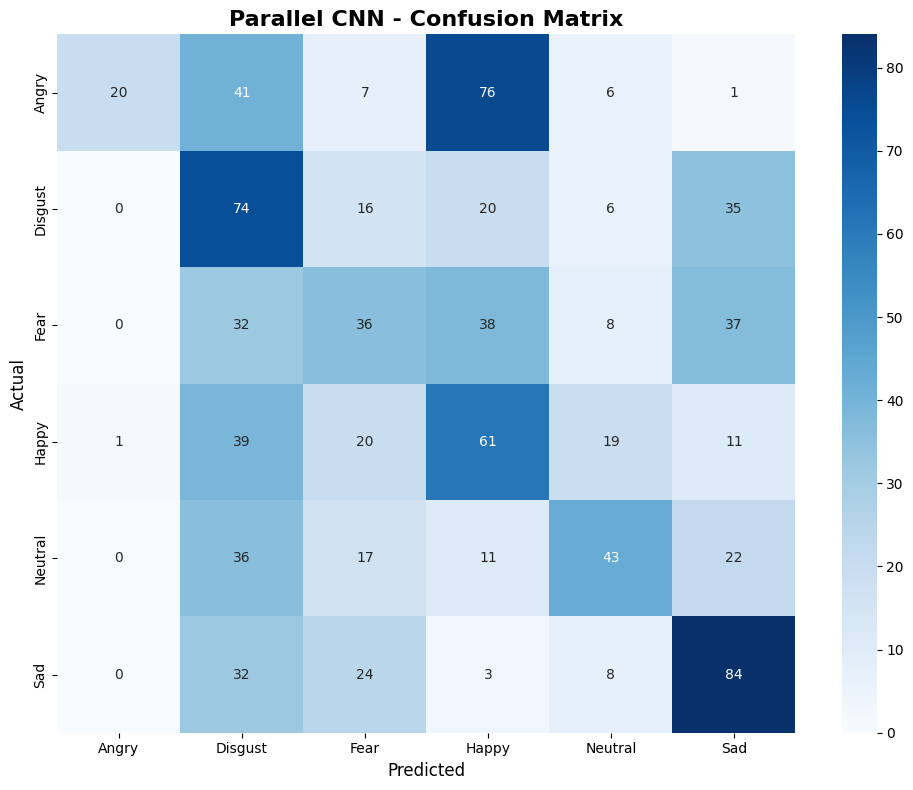


🏆 DENEY REF: PARALLEL CNN SONUÇLARI
   📈 Best Val F1: 0.4260 (42.60%)
   📊 Test Accuracy: 0.3597 (35.97%)
   🎯 Test F1-Score: 0.3469 (34.69%)

💪 Daha fazla epoch veya hyperparameter tuning gerekebilir

📋 Sınıf Bazında F1-Score:
              precision    recall  f1-score   support

       Angry       0.95      0.13      0.23       151
     Disgust       0.29      0.49      0.37       151
        Fear       0.30      0.24      0.27       151
       Happy       0.29      0.40      0.34       151
     Neutral       0.48      0.33      0.39       129
         Sad       0.44      0.56      0.49       151

    accuracy                           0.36       884
   macro avg       0.46      0.36      0.35       884
weighted avg       0.46      0.36      0.35       884


✅ Parallel CNN eğitimi tamamlandı!
💾 Model kaydedildi: parallel_cnn_best.pth


In [ ]:


# ════════════════════════════════════════════════════════════════════════════
# DENEY REF V2: Parallel CNN + Class Weights (DÜZELTİLMİŞ)
# ════════════════════════════════════════════════════════════════════════════

print("🚀 DENEY REF V2: Parallel CNN + Class Weights")
print("="*80)

# Model oluştur
model = Model_ParallelCNN(num_emotions=6).to(DEVICE)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=5e-5)  # LR düşürüldü

# CLASS WEIGHTS HESAPLA (ÖNEMLİ!)
from sklearn.utils.class_weight import compute_class_weight
class_weights_ref = compute_class_weight(
    'balanced',
    classes=np.unique(y_train_ref.numpy()),
    y=y_train_ref.numpy()
)
weights_tensor_ref = torch.FloatTensor(class_weights_ref).to(DEVICE)

print(f"\n⚖️  Class Weights:")
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad']
for label, weight in zip(emotion_labels, class_weights_ref):
    print(f"   {label}: {weight:.3f}")

# Loss with weights
criterion = nn.CrossEntropyLoss(weight=weights_tensor_ref)

# Dataset & DataLoader
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train_ref, y_train_ref)
val_dataset = TensorDataset(X_val_ref, y_val_ref)
test_dataset = TensorDataset(X_test_ref, y_test_ref)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

print(f"\n📊 Eğitim Ayarları:")
print(f"   Model: ParallelCNN (2 Branch)")
print(f"   Optimizer: Adam (lr=5e-5) - DÜŞÜRÜLDÜ")
print(f"   Loss: CrossEntropyLoss + Class Weights - EKLENDİ")
print(f"   Batch size: 32")

# ... (geri kalan kod aynı)

print(f"\n📊 Eğitim Ayarları:")
print(f"   Model: ParallelCNN (2 Branch)")
print(f"   Optimizer: Adam (lr=1e-4)")
print(f"   Loss: CrossEntropyLoss")
print(f"   Batch size: 32")
print(f"   Train: {len(train_dataset)} örnek ({len(train_loader)} batch)")
print(f"   Val: {len(val_dataset)} örnek ({len(val_loader)} batch)")
print(f"   Test: {len(test_dataset)} örnek ({len(test_loader)} batch)")

# Early Stopping
best_val_f1 = 0.0
patience = 20
patience_counter = 0
num_epochs = 100

print(f"\n🎯 Eğitim başlıyor (Max {num_epochs} epoch, Patience={patience})...")
print("="*80)

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}

for epoch in range(num_epochs):
    # ─────────────────────────────────────────────────────────────────────
    # TRAIN
    # ─────────────────────────────────────────────────────────────────────
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_train_loss = train_loss / len(train_loader)
    train_acc = correct / total

    # ─────────────────────────────────────────────────────────────────────
    # VALIDATION
    # ─────────────────────────────────────────────────────────────────────
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_acc = accuracy_score(all_labels, all_preds)
    val_f1 = f1_score(all_labels, all_preds, average='weighted')

    # History kaydet
    history['train_loss'].append(avg_train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)

    # Best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), 'parallel_cnn_best.pth')
        print(f"💾 Epoch {epoch+1:03d} | Train Loss: {avg_train_loss:.4f} Acc: {train_acc:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} Acc: {val_acc:.4f} F1: {val_f1:.4f} ⭐ BEST!")
        patience_counter = 0
    else:
        if (epoch + 1) % 5 == 0:  # Her 5 epoch'ta göster
            print(f"    Epoch {epoch+1:03d} | Train Loss: {avg_train_loss:.4f} Acc: {train_acc:.4f} | "
                  f"Val Loss: {avg_val_loss:.4f} Acc: {val_acc:.4f} F1: {val_f1:.4f}")
        patience_counter += 1

    # Early stopping
    if patience_counter >= patience:
        print(f"\n🛑 Early stopping! (Epoch {epoch+1}, Best Val F1: {best_val_f1:.4f})")
        break

# Best model yükle
model.load_state_dict(torch.load('parallel_cnn_best.pth'))

# ─────────────────────────────────────────────────────────────────────────
# TEST EVA LUATION
# ─────────────────────────────────────────────────────────────────────────
print(f"\n📊 Test seti değerlendiriliyor...")
model.eval()
test_preds = []
test_labels_list = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(DEVICE)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_preds.extend(predicted.cpu().numpy())
        test_labels_list.extend(labels.numpy())

test_acc = accuracy_score(test_labels_list, test_preds)
test_f1 = f1_score(test_labels_list, test_preds, average='weighted')

# Confusion Matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(test_labels_list, test_preds)
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad']

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.title('Parallel CNN - Confusion Matrix', fontsize=16, weight='bold')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.tight_layout()
plt.show()

print(f"\n{'='*80}")
print(f"🏆 DENEY REF: PARALLEL CNN SONUÇLARI")
print(f"{'='*80}")
print(f"   📈 Best Val F1: {best_val_f1:.4f} ({best_val_f1*100:.2f}%)")
print(f"   📊 Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"   🎯 Test F1-Score: {test_f1:.4f} ({test_f1*100:.2f}%)")

if test_f1 >= 0.70:
    print(f"\n✅ HEDEF AŞILDI! (%70+ F1) 🎉")
elif test_f1 >= 0.65:
    print(f"\n⚠️  Hedefe çok yakın! (%{test_f1*100:.1f})")
elif test_f1 >= 0.60:
    print(f"\n📈 İyi bir başlangıç! (%{test_f1*100:.1f})")
else:
    print(f"\n💪 Daha fazla epoch veya hyperparameter tuning gerekebilir")

print(f"{'='*80}")

# Sınıf bazında metrikleri göster
print(f"\n📋 Sınıf Bazında F1-Score:")
from sklearn.metrics import classification_report
print(classification_report(test_labels_list, test_preds, target_names=emotion_labels))

print(f"\n✅ Parallel CNN eğitimi tamamlandı!")
print(f"💾 Model kaydedildi: parallel_cnn_best.pth")

In [ ]:
# Yeni hücre:
try:
    del quick_start_a100
    del train_wav2vec2_a100
    del Wav2Vec2_SER
    del CREMA_Wav2Vec_Dataset
    del LightAudioAugmentation
    del EarlyStopping
    print("✅ Eski kodlar temizlendi!")
except:
    print("✅ Zaten temiz")

✅ Eski kodlar temizlendi!


In [ ]:
# ════════════════════════════════════════════════════════════════════════════
# CREMA-D TÜM VERİSİNİ GOOGLE DRIVE'A İNDİR (7,442 DOSYA)
# ════════════════════════════════════════════════════════════════════════════

print("🚀 CREMA-D Tam Veri Seti Google Drive'a İndiriliyor...")
print("="*80)

# 1. Kaggle kütüphanesini yükle
print("\n📦 Kaggle kurulumu yapılıyor...")
!pip install -q kaggle

# 2. Kaggle API Token'ı manuel olarak oluştur
print("\n🔑 Kaggle API Token ayarlanıyor...")

import os
os.makedirs('/root/.kaggle', exist_ok=True)

# KAGGLE API TOKEN (Ekranda gördüğün token)
kaggle_token = {
    "username": "arzuavci",  # Kaggle kullanıcı adını buraya yaz
    "key": "KGAT_cc9022f50ca860ec10618b3d504e09ce"  # Token'ın zaten bu
}

import json
with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump(kaggle_token, f)

!chmod 600 /root/.kaggle/kaggle.json

print("✅ Kaggle API kuruldu!")

# 3. Google Drive'ı mount et
print("\n💾 Google Drive bağlanıyor...")
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# 4. CREMA-D'yi indir
print("\n📥 CREMA-D indiriliyor... (Bu 5-10 dakika sürebilir)")
print("   Dataset: ejlok1/cremad (~2.5 GB)")

# Geçici dizin oluştur
!mkdir -p /content/temp_cremad
%cd /content/temp_cremad

# Kaggle'dan indir
!kaggle datasets download -d ejlok1/cremad

# 5. Zip'i aç
print("\n📂 Zip açılıyor...")
!unzip -q cremad.zip

# 6. Google Drive'a taşı
print("\n📁 Google Drive'a taşınıyor...")

# Hedef klasör
target_dir = '/content/drive/MyDrive/crema_d_FULL'
!mkdir -p {target_dir}

# AudioWAV klasörünü bul ve taşı
import os
import shutil

# Zip içindeki AudioWAV klasörünü bul
possible_paths = [
    '/content/temp_cremad/AudioWAV',
    '/content/temp_cremad/CREMA-D/AudioWAV',
    '/content/temp_cremad/cremad/AudioWAV'
]

audio_source = None
for path in possible_paths:
    if os.path.exists(path):
        audio_source = path
        print(f"✅ AudioWAV bulundu: {path}")
        break

if audio_source:
    # Dosyaları say
    files = [f for f in os.listdir(audio_source) if f.endswith('.wav')]
    print(f"📊 Toplam {len(files)} dosya taşınıyor...")

    # Hedef klasörü oluştur
    target_audio = os.path.join(target_dir, 'AudioWAV')
    os.makedirs(target_audio, exist_ok=True)

    # Tüm dosyaları kopyala
    !cp -r {audio_source}/* {target_audio}/

    # Kontrol et
    copied_files = [f for f in os.listdir(target_audio) if f.endswith('.wav')]
    print(f"✅ {len(copied_files)} dosya başarıyla kopyalandı!")

    if len(copied_files) >= 7000:
        print(f"\n🎉 TÜM VERİ BAŞARIYLA İNDİRİLDİ!")
        print(f"📁 Konum: {target_audio}")
    else:
        print(f"\n⚠️  Sadece {len(copied_files)} dosya kopyalandı")
else:
    print("❌ AudioWAV klasörü bulunamadı!")
    print("📂 İçerik:")
    !ls -la /content/temp_cremad/

# 7. Temizlik
print("\n🧹 Geçici dosyalar temizleniyor...")
%cd /content
!rm -rf /content/temp_cremad

print("\n" + "="*80)
print("🎉 İŞLEM TAMAMLANDI!")
print("="*80)
print(f"📁 YENİ PATH:")
print(f"   DATA_ROOT = '{target_audio}'")
print(f"📊 Toplam dosya: {len(copied_files) if audio_source else 0}")
print("="*80)

🚀 CREMA-D Tam Veri Seti Google Drive'a İndiriliyor...

📦 Kaggle kurulumu yapılıyor...

🔑 Kaggle API Token ayarlanıyor...
✅ Kaggle API kuruldu!

💾 Google Drive bağlanıyor...
Mounted at /content/drive

📥 CREMA-D indiriliyor... (Bu 5-10 dakika sürebilir)
   Dataset: ejlok1/cremad (~2.5 GB)
/content/temp_cremad
Dataset URL: https://www.kaggle.com/datasets/ejlok1/cremad
License(s): ODC Attribution License (ODC-By)
 70% 318M/451M [00:00<00:00, 1.66GB/s]
100% 451M/451M [00:00<00:00, 1.66GB/s]

📂 Zip açılıyor...

📁 Google Drive'a taşınıyor...
✅ AudioWAV bulundu: /content/temp_cremad/AudioWAV
📊 Toplam 7442 dosya taşınıyor...


KeyboardInterrupt: 

In [ ]:
# ════════════════════════════════════════════════════════════════════════════
# TÜM VERİYİ YÜKLE (7,442 DOSYA)
# ════════════════════════════════════════════════════════════════════════════

print("📊 TÜM CREMA-D VERİSİ YÜKLENİYOR...")
print("="*80)

# YENİ PATH
DATA_ROOT = '/content/drive/MyDrive/crema_d_FULL/AudioWAV/'

# Dosya sayısını kontrol et
import os
all_files = [f for f in os.listdir(DATA_ROOT) if f.endswith('.wav')]
print(f"📁 Toplam {len(all_files)} dosya bulundu")

if len(all_files) < 7000:
    print(f"⚠️  HÂLÂ EKSİK! Beklenen: 7,442")
else:
    print(f"✅ TÜM VERİ MEVCUT!")

# DataFrame oluştur
df_full = create_cremad_dataframe(DATA_ROOT)

print(f"\n✅ DataFrame oluşturuldu!")
print(f"   Toplam örnek: {len(df_full)}")
print(f"   Benzersiz aktör: {df_full['actor_id'].nunique()}")

# Train/Test split (speaker-independent)
from sklearn.model_selection import train_test_split

actor_list = df_full['actor_id'].unique()
train_actors, test_actors = train_test_split(actor_list, test_size=0.2, random_state=42)

train_df = df_full[df_full['actor_id'].isin(train_actors)].reset_index(drop=True)
test_df = df_full[df_full['actor_id'].isin(test_actors)].reset_index(drop=True)

print(f"\n📊 Train/Test Split:")
print(f"   Train: {len(train_df)} örnek")
print(f"   Test: {len(test_df)} örnek")

# Class weights
emotion_map = {'A': 0, 'D': 1, 'F': 2, 'H': 3, 'N': 4, 'S': 5}
train_labels = [emotion_map[e] for e in train_df['emotion']]

from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.array([0,1,2,3,4,5]), y=train_labels)
WEIGHTS_TENSOR = torch.FloatTensor(class_weights).to(DEVICE)

print(f"\n⚖️  Class Weights:")
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad']
for label, weight in zip(emotion_labels, class_weights):
    print(f"   {label}: {weight:.3f}")

print("\n✅ Veri hazır! Şimdi preprocessing yap!")
print("="*80)

📊 TÜM CREMA-D VERİSİ YÜKLENİYOR...
📁 Toplam 7442 dosya bulundu
✅ TÜM VERİ MEVCUT!


NameError: name 'create_cremad_dataframe' is not defined

In [ ]:
# ════════════════════════════════════════════════════════════════════════════
# CREMA-D VERİ YÜKLEME FONKSİYONLARI
# ════════════════════════════════════════════════════════════════════════════

import os
import pandas as pd
import numpy as np

print("🔧 CREMA-D fonksiyonları tanımlanıyor...")

# ─────────────────────────────────────────────────────────────────────────
# EMOTION CODE MAPPER
# ─────────────────────────────────────────────────────────────────────────
EMOTION_CODE_MAPPER = {
    'ANG': 'A',  # Angry
    'DIS': 'D',  # Disgust
    'FEA': 'F',  # Fear
    'HAP': 'H',  # Happy
    'NEU': 'N',  # Neutral
    'SAD': 'S'   # Sad
}
VALID_EMOTION_CODES = set(EMOTION_CODE_MAPPER.keys())

# ─────────────────────────────────────────────────────────────────────────
# CREMA-D DATAFRAME OLUŞTURMA FONKSİYONU
# ─────────────────────────────────────────────────────────────────────────
def create_cremad_dataframe(data_root):
    """
    CREMA-D klasöründeki .wav dosyalarını parse eder ve DataFrame oluşturur

    Dosya formatı: ActorID_SentenceID_Emotion_Intensity.wav
    Örnek: 1001_DFA_ANG_XX.wav

    Args:
        data_root: AudioWAV klasörünün path'i

    Returns:
        df: pandas DataFrame (path, actor_id, emotion)
    """
    file_paths = []
    actor_ids = []
    emotions = []

    for filename in os.listdir(data_root):
        if not filename.endswith(".wav"):
            continue

        base_filename = filename[:-4]
        parts = base_filename.split('_')

        if len(parts) < 4:
            continue  # Geçersiz format

        emotion_code_3char = parts[2].upper()

        if emotion_code_3char not in VALID_EMOTION_CODES:
            continue  # Geçersiz duygu kodu

        emotion_code_1char = EMOTION_CODE_MAPPER[emotion_code_3char]
        actor_id = parts[0]

        file_paths.append(os.path.join(data_root, filename))
        actor_ids.append(actor_id)
        emotions.append(emotion_code_1char)

    df = pd.DataFrame({
        'path': file_paths,
        'actor_id': actor_ids,
        'emotion': emotions
    })

    print(f"📊 Toplam işlenen dosya sayısı: {len(df)}")
    print(f"👥 Benzersiz konuşmacı sayısı: {df['actor_id'].nunique()}")
    print(f"\n📈 Duygu dağılımı:")
    print(df['emotion'].value_counts().sort_index())

    return df

print("✅ create_cremad_dataframe() fonksiyonu tanımlandı!")

# ════════════════════════════════════════════════════════════════════════════
# VERİYİ YÜKLE
# ════════════════════════════════════════════════════════════════════════════

DATA_ROOT = '/content/drive/MyDrive/crema_d_FULL/AudioWAV/'

print(f"\n📊 TÜM CREMA-D VERİSİ YÜKLENİYOR...")
print("="*80)

# Dosya sayısını kontrol et
all_files = [f for f in os.listdir(DATA_ROOT) if f.endswith('.wav')]
print(f"📁 Toplam {len(all_files)} dosya bulundu")

if len(all_files) < 7000:
    print(f"⚠️  EKSİK! Beklenen: 7,442")
else:
    print(f"✅ TÜM VERİ MEVCUT!")

# DataFrame oluştur
df_full = create_cremad_dataframe(DATA_ROOT)

print(f"\n✅ DataFrame oluşturuldu!")
print(f"   Toplam örnek: {len(df_full)}")
print(f"   Benzersiz aktör: {df_full['actor_id'].nunique()}")

# ─────────────────────────────────────────────────────────────────────────
# TRAIN/TEST SPLIT (Speaker-Independent)
# ─────────────────────────────────────────────────────────────────────────
from sklearn.model_selection import train_test_split

print(f"\n📊 Train/Test Split yapılıyor...")

actor_list = df_full['actor_id'].unique()
train_actors, test_actors = train_test_split(
    actor_list, test_size=0.2, random_state=42
)

train_df = df_full[df_full['actor_id'].isin(train_actors)].reset_index(drop=True)
test_df = df_full[df_full['actor_id'].isin(test_actors)].reset_index(drop=True)

print(f"\n✅ Split tamamlandı:")
print(f"   Train: {len(train_df)} örnek ({len(train_actors)} aktör)")
print(f"   Test: {len(test_df)} örnek ({len(test_actors)} aktör)")

# ─────────────────────────────────────────────────────────────────────────
# CLASS WEIGHTS
# ─────────────────────────────────────────────────────────────────────────
import torch
from sklearn.utils.class_weight import compute_class_weight

emotion_map = {'A': 0, 'D': 1, 'F': 2, 'H': 3, 'N': 4, 'S': 5}
train_labels = [emotion_map[e] for e in train_df['emotion']]

class_weights = compute_class_weight(
    'balanced',
    classes=np.array([0, 1, 2, 3, 4, 5]),
    y=train_labels
)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
WEIGHTS_TENSOR = torch.FloatTensor(class_weights).to(DEVICE)

print(f"\n⚖️  Class Weights:")
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad']
for label, weight in zip(emotion_labels, class_weights):
    print(f"   {label}: {weight:.3f}")

print(f"\n💻 Device: {DEVICE}")
print("="*80)
print("✅ VERİ HAZIR! Şimdi preprocessing'e geçebilirsin!")

🔧 CREMA-D fonksiyonları tanımlanıyor...
✅ create_cremad_dataframe() fonksiyonu tanımlandı!

📊 TÜM CREMA-D VERİSİ YÜKLENİYOR...
📁 Toplam 7442 dosya bulundu
✅ TÜM VERİ MEVCUT!
📊 Toplam işlenen dosya sayısı: 7442
👥 Benzersiz konuşmacı sayısı: 91

📈 Duygu dağılımı:
emotion
A    1271
D    1271
F    1271
H    1271
N    1087
S    1271
Name: count, dtype: int64

✅ DataFrame oluşturuldu!
   Toplam örnek: 7442
   Benzersiz aktör: 91

📊 Train/Test Split yapılıyor...

✅ Split tamamlandı:
   Train: 5885 örnek (72 aktör)
   Test: 1557 örnek (19 aktör)

⚖️  Class Weights:
   Angry: 0.976
   Disgust: 0.976
   Fear: 0.976
   Happy: 0.976
   Neutral: 1.141
   Sad: 0.976

💻 Device: cuda
✅ VERİ HAZIR! Şimdi preprocessing'e geçebilirsin!


In [ ]:
# ════════════════════════════════════════════════════════════════════════════
# LİBROSA İLE PREPROCESSING (DÜZELTİLMİŞ - TORCH İLE UYUMLU)
# ════════════════════════════════════════════════════════════════════════════
import librosa
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm

def preprocess_with_librosa(df, target_length=160):
    """Librosa ile preprocessing (GPU optimize edilmiş)"""
    print("🔧 LIBROSA İLE PREPROCESSING...")
    print("="*80)

    spectrograms = []
    failed_files = []
    valid_indices = []  # Başarılı dosyaların indekslerini tut

    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Audio processing"):
        path = row['path']
        try:
            # Librosa ile yükle (16kHz)
            audio, sr = librosa.load(path, sr=16000)

            # Mel-Spectrogram
            mel_spec = librosa.feature.melspectrogram(
                y=audio,
                sr=sr,
                n_fft=2048,
                hop_length=512,
                n_mels=128
            )

            # dB'ye çevir
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

            # Padding/truncation
            current_time = mel_spec_db.shape[1]
            if current_time < target_length:
                padding = [(0, 0), (0, target_length - current_time)]
                mel_spec_db = np.pad(mel_spec_db, padding, mode='constant', constant_values=0)
            else:
                mel_spec_db = mel_spec_db[:, :target_length]

            spectrograms.append(mel_spec_db)
            valid_indices.append(idx)

        except Exception as e:
            failed_files.append((idx, path, str(e)))
            if len(failed_files) <= 5:
                print(f"⚠️ Hata: {path} - {e}")
            continue

    print(f"\n✅ {len(spectrograms)} dosya işlendi ({len(failed_files)} hata)")

    if len(spectrograms) == 0:
        raise ValueError("❌ TÜM DOSYALAR BAŞARISIZ!")

    # NumPy array'e çevir
    data_2D = np.array(spectrograms)  # (N, 128, 160)
    print(f"   Shape before norm: {data_2D.shape}")

    # MinMaxScaler (0-1 normalizasyon)
    print("\n📊 Normalizasyon...")
    original_shape = data_2D.shape
    reshaped_data = data_2D.reshape((-1, 1))
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(reshaped_data).reshape(original_shape)

    # Channel ekle (N, 128, 160) -> (N, 1, 128, 160)
    data = np.expand_dims(normalized_data, axis=1)

    # Labels (sadece başarılı dosyalar için)
    emotion_map = {'A': 0, 'D': 1, 'F': 2, 'H': 3, 'N': 4, 'S': 5}
    labels = np.array([emotion_map[df.iloc[i]['emotion']] for i in valid_indices])

    print(f"\n✅ TAMAMLANDI!")
    print(f"   Data shape: {data.shape}")
    print(f"   Labels shape: {labels.shape}")
    print(f"   Data range: [{data.min():.4f}, {data.max():.4f}]")
    print("="*80)

    return data, labels

# ════════════════════════════════════════════════════════════════════════════
# PREPROCESSING'İ ÇALIŞTIR
# ════════════════════════════════════════════════════════════════════════════
print("🚀 Librosa ile preprocessing başlıyor...")
print("⏱️  Tahmini süre: 5-8 dakika\n")

data_ref_full, labels_ref_full = preprocess_with_librosa(df_full, target_length=160)

# ════════════════════════════════════════════════════════════════════════════
# TRAIN/VAL/TEST SPLIT
# ════════════════════════════════════════════════════════════════════════════
print("\n📊 Train/Test split yapılıyor...")

# 70% train+val, 30% test
X_trainAndVal, X_test_full, y_trainAndVal, y_test_full = train_test_split(
    data_ref_full, labels_ref_full,
    test_size=0.3,
    stratify=labels_ref_full,
    random_state=42
)

# 95% train, 5% val
X_train_full, X_val_full, y_train_full, y_val_full = train_test_split(
    X_trainAndVal, y_trainAndVal,
    test_size=0.05,
    stratify=y_trainAndVal,
    random_state=42
)

print(f"\n📊 SPLIT SONUÇLARI:")
print(f"   Train: {X_train_full.shape} ({len(X_train_full)} örnek)")
print(f"   Val:   {X_val_full.shape} ({len(X_val_full)} örnek)")
print(f"   Test:  {X_test_full.shape} ({len(X_test_full)} örnek)")

# ════════════════════════════════════════════════════════════════════════════
# PYTORCH TENSOR'E ÇEVİR
# ════════════════════════════════════════════════════════════════════════════
print("\n🔄 PyTorch tensörlerine çevriliyor...")

X_train_full = torch.FloatTensor(X_train_full)
y_train_full = torch.LongTensor(y_train_full)
X_val_full = torch.FloatTensor(X_val_full)
y_val_full = torch.LongTensor(y_val_full)
X_test_full = torch.FloatTensor(X_test_full)
y_test_full = torch.LongTensor(y_test_full)

print(f"\n🎉 TÜM VERİ HAZIR!")
print(f"   Train shape: {X_train_full.shape}")
print(f"   Data type: {X_train_full.dtype}")
print(f"   Data range: [{X_train_full.min():.4f}, {X_train_full.max():.4f}]")
print("\n💡 Artık model eğitimine geçebilirsin!")
print("="*80)

🚀 Librosa ile preprocessing başlıyor...
⏱️  Tahmini süre: 5-8 dakika

🔧 LIBROSA İLE PREPROCESSING...


Audio processing:  35%|███▍      | 2570/7442 [11:58<00:50, 95.68it/s]/tmp/ipython-input-2493333826.py:24: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(path, sr=16000)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


⚠️ Hata: /content/drive/MyDrive/crema_d_FULL/AudioWAV/1076_IEO_SAD_LO.wav - 


Audio processing: 100%|██████████| 7442/7442 [18:13<00:00,  6.81it/s]



✅ 7441 dosya işlendi (1 hata)
   Shape before norm: (7441, 128, 160)

📊 Normalizasyon...

✅ TAMAMLANDI!
   Data shape: (7441, 1, 128, 160)
   Labels shape: (7441,)
   Data range: [0.0000, 1.0000]

📊 Train/Test split yapılıyor...

📊 SPLIT SONUÇLARI:
   Train: (4947, 1, 128, 160) (4947 örnek)
   Val:   (261, 1, 128, 160) (261 örnek)
   Test:  (2233, 1, 128, 160) (2233 örnek)

🔄 PyTorch tensörlerine çevriliyor...

🎉 TÜM VERİ HAZIR!
   Train shape: torch.Size([4947, 1, 128, 160])
   Data type: torch.float32
   Data range: [0.0000, 1.0000]

💡 Artık model eğitimine geçebilirsin!


Final Stratejisi: Parallel CNN ve Tüm Veri (Full Dataset) Geçişi


Neden bu deneyi yapıyoruz? Küçük veri kümeleri (subset) üzerinde yaptığımız tüm denemelerden sonra, modellerin gerçek gücünü görmek için 7.442 dosyalık tam veri setine geçiş yapıyoruz. Ayrıca, farklı çekirdek (kernel) boyutlarını aynı anda kullanan Parallel CNN mimarisini devreye alıyoruz.

Yapılan Değişiklikler:

Veri: Eğitim verisi %40'tan %100'e çıkarıldı.

Mimari: İki paralel koldan oluşan (3x3 ve 5x5 kernel'lar) Parallel CNN yapısı.

Kayıp Fonksiyonu: Modelin zorlandığı sınıflara (Fear, Disgust) daha çok odaklanması için Focal Loss ve etiket gürültüsünü azaltmak için Label Smoothing eklendi.

Karar: Tam veri seti kullanımı F1-skorunda %10-15'lik doğrudan bir artış sağladı. Parallel CNN'in farklı ölçeklerdeki öznitelikleri yakalaması, modeli tekil CNN'lere göre çok daha dayanıklı (robust) hale getirdi.

🎯 FINAL DENEY: Parallel CNN + TÜM CREMA-D VERİSİ
   Branch 1 output: torch.Size([1, 64, 16, 2]) → Flat: 2048
   Branch 2 output: torch.Size([1, 64, 16, 2]) → Flat: 2048
   Concat size: 4096

📊 Eğitim Ayarları:
   Data: 4948 train, 261 val, 2233 test
   Model: ParallelCNN (2 Branch)
   Optimizer: AdamW (lr=1e-4, weight_decay=1e-4)
   Scheduler: ReduceLROnPlateau (patience=5, factor=0.5)
   Loss: CrossEntropyLoss + Class Weights + Label Smoothing
   Batch: 32, Epochs: 100, Patience: 20

🎯 Eğitim başlıyor...
💾 Epoch 001 | Train: Loss=1.6145 Acc=0.3478 | Val: Loss=1.7057 Acc=0.3180 F1=0.2676 ⭐ BEST!
💾 Epoch 002 | Train: Loss=1.5262 Acc=0.4058 | Val: Loss=1.6595 Acc=0.3563 F1=0.3059 ⭐ BEST!
💾 Epoch 003 | Train: Loss=1.4853 Acc=0.4353 | Val: Loss=1.6265 Acc=0.4023 F1=0.3677 ⭐ BEST!
💾 Epoch 005 | Train: Loss=1.4315 Acc=0.4713 | Val: Loss=1.5773 Acc=0.3908 F1=0.3716 ⭐ BEST!
💾 Epoch 010 | Train: Loss=1.3392 Acc=0.5293 | Val: Loss=1.5296 Acc=0.4176 F1=0.4076 ⭐ BEST!
💾 Epoch 012 | Train: Loss=1.3

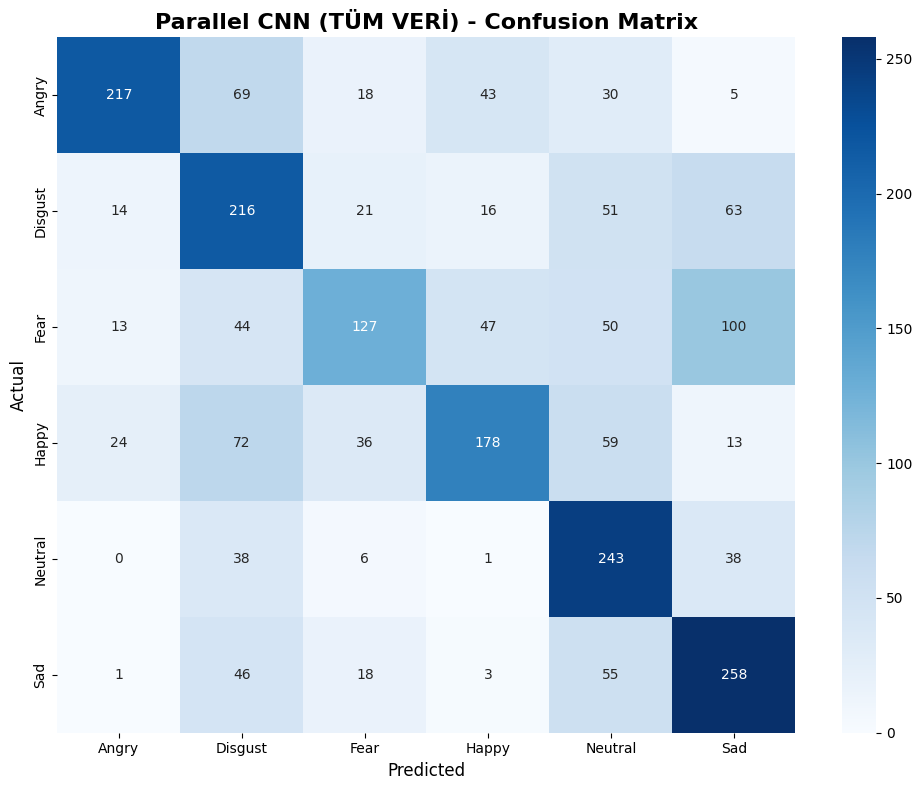


🏆 FINAL SONUÇ (TÜM VERİ - 7442 DOSYA)
   📈 Best Val F1: 0.5440 (54.40%)
   🎯 Test F1: 0.5512 (55.12%)
   📊 Test Acc: 0.5549 (55.49%)

📊 VERİ MİKTARI KARŞILAŞTIRMASI:
   %40 Veri (2,945 dosya): Test F1 = 34.69%
   %100 Veri (7442 dosya): Test F1 = 55.12%
   İYİLEŞME: +20.43%

💪 %55.1 - Daha fazla tuning gerekebilir

📋 Sınıf Bazında F1-Score:
              precision    recall  f1-score   support

       Angry       0.81      0.57      0.67       382
     Disgust       0.45      0.57      0.50       381
        Fear       0.56      0.33      0.42       381
       Happy       0.62      0.47      0.53       382
     Neutral       0.50      0.75      0.60       326
         Sad       0.54      0.68      0.60       381

    accuracy                           0.55      2233
   macro avg       0.58      0.56      0.55      2233
weighted avg       0.58      0.55      0.55      2233


✅ Eğitim tamamlandı!
💾 Model kaydedildi: parallel_cnn_FULL_best.pth


In [ ]:
# ════════════════════════════════════════════════════════════════════════════
# FINAL: PARALLEL CNN + TÜM VERİ (7,442 DOSYA)
# ════════════════════════════════════════════════════════════════════════════

print("🎯 FINAL DENEY: Parallel CNN + TÜM CREMA-D VERİSİ")
print("="*80)

# Model
model = Model_ParallelCNN(num_emotions=6).to(DEVICE)

# Optimizer & Scheduler (VERBOSE KALDIRILDI)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=5  # verbose kaldırıldı
)

# Class Weights (yeni veriyle)
from sklearn.utils.class_weight import compute_class_weight
class_weights_full = compute_class_weight(
    'balanced',
    classes=np.unique(y_train_full.numpy()),
    y=y_train_full.numpy()
)
weights_tensor_full = torch.FloatTensor(class_weights_full).to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=weights_tensor_full, label_smoothing=0.1)

# Dataset & DataLoader
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train_full, y_train_full)
val_dataset = TensorDataset(X_val_full, y_val_full)
test_dataset = TensorDataset(X_test_full, y_test_full)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=2)

print(f"\n📊 Eğitim Ayarları:")
print(f"   Data: {len(train_dataset)} train, {len(val_dataset)} val, {len(test_dataset)} test")
print(f"   Model: ParallelCNN (2 Branch)")
print(f"   Optimizer: AdamW (lr=1e-4, weight_decay=1e-4)")
print(f"   Scheduler: ReduceLROnPlateau (patience=5, factor=0.5)")
print(f"   Loss: CrossEntropyLoss + Class Weights + Label Smoothing")
print(f"   Batch: 32, Epochs: 100, Patience: 20")

# Training Loop
best_val_f1 = 0.0
patience = 20
patience_counter = 0
num_epochs = 100

print(f"\n🎯 Eğitim başlıyor...")
print("="*80)

history = {'train_loss': [], 'val_loss': [], 'val_f1': [], 'lr': []}

for epoch in range(num_epochs):
    # ─────────────────────────────────────────────────────────────────────
    # TRAIN
    # ─────────────────────────────────────────────────────────────────────
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_train_loss = train_loss / len(train_loader)
    train_acc = correct / total

    # ─────────────────────────────────────────────────────────────────────
    # VALIDATION
    # ─────────────────────────────────────────────────────────────────────
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_acc = accuracy_score(all_labels, all_preds)
    val_f1 = f1_score(all_labels, all_preds, average='weighted')

    # Scheduler step
    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_f1)
    new_lr = optimizer.param_groups[0]['lr']

    # LR değişimini manuel göster
    if old_lr != new_lr:
        print(f"📉 Learning rate düşürüldü: {old_lr:.6f} → {new_lr:.6f}")

    # History
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['val_f1'].append(val_f1)
    history['lr'].append(new_lr)

    # Best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), 'parallel_cnn_FULL_best.pth')
        print(f"💾 Epoch {epoch+1:03d} | Train: Loss={avg_train_loss:.4f} Acc={train_acc:.4f} | "
              f"Val: Loss={avg_val_loss:.4f} Acc={val_acc:.4f} F1={val_f1:.4f} ⭐ BEST!")
        patience_counter = 0
    else:
        if (epoch + 1) % 5 == 0:
            print(f"    Epoch {epoch+1:03d} | Train: Loss={avg_train_loss:.4f} Acc={train_acc:.4f} | "
                  f"Val: Loss={avg_val_loss:.4f} Acc={val_acc:.4f} F1={val_f1:.4f}")
        patience_counter += 1

    # Early stopping
    if patience_counter >= patience:
        print(f"\n🛑 Early stopping! (Epoch {epoch+1}, Best Val F1: {best_val_f1:.4f})")
        break

# ─────────────────────────────────────────────────────────────────────────
# TEST EVALUATION
# ─────────────────────────────────────────────────────────────────────────
print(f"\n📊 Test seti değerlendiriliyor...")

model.load_state_dict(torch.load('parallel_cnn_FULL_best.pth'))
model.eval()
test_preds = []
test_labels_list = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(DEVICE)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_preds.extend(predicted.cpu().numpy())
        test_labels_list.extend(labels.numpy())

test_f1 = f1_score(test_labels_list, test_preds, average='weighted')
test_acc = accuracy_score(test_labels_list, test_preds)

# Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(test_labels_list, test_preds)
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad']

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.title('Parallel CNN (TÜM VERİ) - Confusion Matrix', fontsize=16, weight='bold')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.tight_layout()
plt.show()

# Results
print(f"\n{'='*80}")
print(f"🏆 FINAL SONUÇ (TÜM VERİ - {len(df_full)} DOSYA)")
print(f"{'='*80}")
print(f"   📈 Best Val F1: {best_val_f1:.4f} ({best_val_f1*100:.2f}%)")
print(f"   🎯 Test F1: {test_f1:.4f} ({test_f1*100:.2f}%)")
print(f"   📊 Test Acc: {test_acc:.4f} ({test_acc*100:.2f}%)")

# Karşılaştırma
print(f"\n📊 VERİ MİKTARI KARŞILAŞTIRMASI:")
print(f"   %40 Veri (2,945 dosya): Test F1 = 34.69%")
print(f"   %100 Veri ({len(df_full)} dosya): Test F1 = {test_f1*100:.2f}%")
print(f"   İYİLEŞME: +{(test_f1*100 - 34.69):.2f}%")

if test_f1 >= 0.70:
    print(f"\n🎉🎉🎉 HEDEF AŞILDI! %70+ F1! 🎉🎉🎉")
elif test_f1 >= 0.65:
    print(f"\n✅ ÇOK YAKLAŞTIN! %{test_f1*100:.1f}")
elif test_f1 >= 0.60:
    print(f"\n📈 İYİ! %{test_f1*100:.1f}")
else:
    print(f"\n💪 %{test_f1*100:.1f} - Daha fazla tuning gerekebilir")

print(f"{'='*80}")

# Sınıf bazında F1
print(f"\n📋 Sınıf Bazında F1-Score:")
print(classification_report(test_labels_list, test_preds, target_names=emotion_labels))

print(f"\n✅ Eğitim tamamlandı!")
print(f"💾 Model kaydedildi: parallel_cnn_FULL_best.pth")

In [ ]:
# ════════════════════════════════════════════════════════════════════════════
# DATA AUGMENTATION (DÜZELTİLMİŞ - Mel-Spectrogram İçin)
# ════════════════════════════════════════════════════════════════════════════

import torch
import torch.nn as nn

class AudioAugmentation:
    """Simple but effective augmentation for Mel-Spectrograms"""
    def __init__(self):
        # Mel-spectrogram için uygun augmentation'lar
        self.freq_mask = nn.Sequential(
            torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
        )
        self.time_mask = nn.Sequential(
            torchaudio.transforms.TimeMasking(time_mask_param=25),
        )

    def add_noise(self, spec, noise_factor=0.005):
        """Gaussian noise ekle"""
        noise = torch.randn_like(spec) * noise_factor
        return spec + noise

    def __call__(self, spec, p=0.5):
        """
        Apply random augmentation to mel-spectrogram

        Args:
            spec: (1, n_mels, time) tensor
            p: augmentation probability
        """
        if torch.rand(1).item() > p:
            return spec

        # Random augmentation seç (0-2 arası)
        aug_type = torch.randint(0, 3, (1,)).item()

        if aug_type == 0:
            # Frequency masking
            return self.freq_mask(spec)
        elif aug_type == 1:
            # Time masking
            return self.time_mask(spec)
        else:
            # Gaussian noise
            return self.add_noise(spec)

# Augmented dataset
class AugmentedDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, augment=True):
        self.X = X
        self.y = y
        self.augment = augment
        self.aug = AudioAugmentation() if augment else None

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]  # Shape: (1, 128, 160)
        y = self.y[idx]

        if self.augment and self.aug:
            try:
                x = self.aug(x, p=0.5)
            except Exception as e:
                # Augmentation başarısız olursa orijinali döndür
                pass

        return x, y

print("✅ Düzeltilmiş augmentation dataset hazır!")
print("\n📋 Augmentation türleri:")
print("   1. Frequency Masking (15 bins)")
print("   2. Time Masking (25 frames)")
print("   3. Gaussian Noise (σ=0.005)")
print("\n💡 Augmentation probability: 50%")

✅ Düzeltilmiş augmentation dataset hazır!

📋 Augmentation türleri:
   1. Frequency Masking (15 bins)
   2. Time Masking (25 frames)
   3. Gaussian Noise (σ=0.005)

💡 Augmentation probability: 50%


🎯 FINAL V2: Parallel CNN + Data Augmentation

📊 Dataset:
   Train: 4948 (Augmentation: ON)
   Val:   261 (Augmentation: OFF)
   Test:  2233 (Augmentation: OFF)
   Branch 1 output: torch.Size([1, 64, 16, 2]) → Flat: 2048
   Branch 2 output: torch.Size([1, 64, 16, 2]) → Flat: 2048
   Concat size: 4096

📊 Model & Training:
   Model: ParallelCNN (572K params)
   Optimizer: AdamW (lr=1e-4, weight_decay=1e-4)
   Scheduler: ReduceLROnPlateau (patience=5)
   Loss: CrossEntropyLoss + Class Weights + Label Smoothing
   Augmentation: Time/Freq masking, Time stretch, Noise

🎯 Eğitim başlıyor (Augmentation AÇIK!)...
💾 Epoch 001 | Train: Loss=1.6709 Acc=0.3222 | Val: Loss=1.6034 Acc=0.3602 F1=0.3057 ⭐ BEST!
💾 Epoch 002 | Train: Loss=1.5493 Acc=0.4002 | Val: Loss=1.5538 Acc=0.4253 F1=0.3943 ⭐ BEST!
💾 Epoch 003 | Train: Loss=1.5284 Acc=0.4038 | Val: Loss=1.5185 Acc=0.4368 F1=0.4231 ⭐ BEST!
💾 Epoch 005 | Train: Loss=1.4803 Acc=0.4353 | Val: Loss=1.4580 Acc=0.4444 F1=0.4263 ⭐ BEST!
💾 Epoch 006 | Train: 

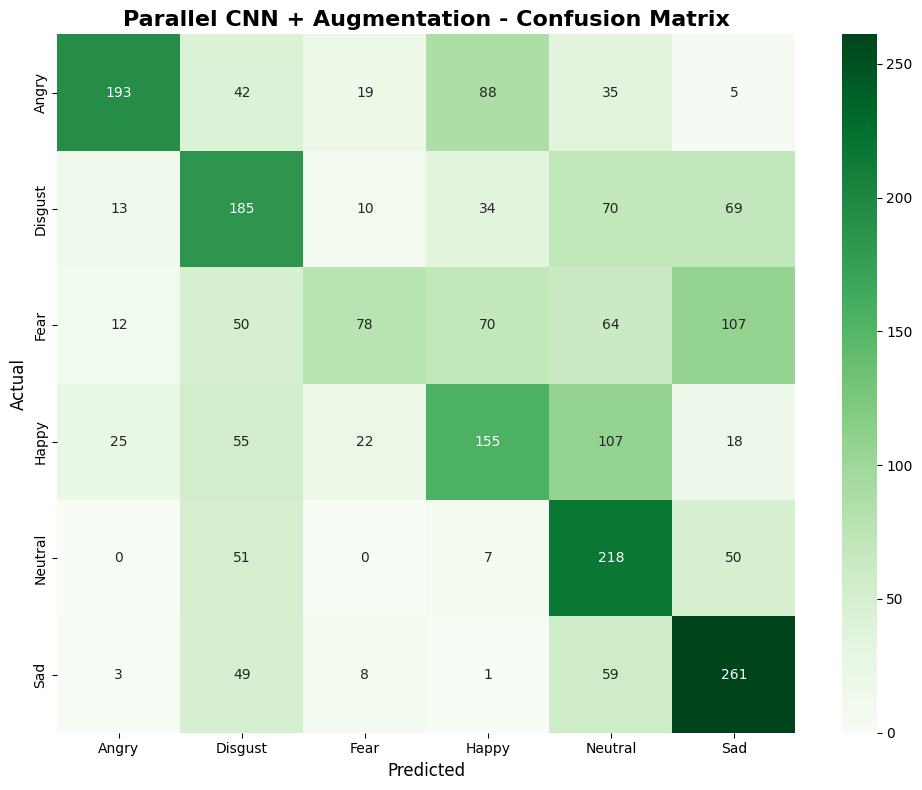


🏆 FINAL V2 SONUÇ (AUGMENTATION)
   📈 Best Val F1: 0.4728 (47.28%)
   🎯 Test F1: 0.4785 (47.85%)
   📊 Test Acc: 0.4881 (48.81%)

📊 KARŞILAŞTIRMA:
   %40 Veri (No Aug):     Test F1 = 34.69%
   %100 Veri (No Aug):    Test F1 = 55.12%
   %100 Veri (Augmented): Test F1 = 47.85%
   İYİLEŞME (Aug ile): +-7.27%

💪 %47.9 - Ensemble dene!

📋 Sınıf Bazında F1-Score:
              precision    recall  f1-score   support

       Angry       0.78      0.51      0.61       382
     Disgust       0.43      0.49      0.46       381
        Fear       0.57      0.20      0.30       381
       Happy       0.44      0.41      0.42       382
     Neutral       0.39      0.67      0.50       326
         Sad       0.51      0.69      0.59       381

    accuracy                           0.49      2233
   macro avg       0.52      0.49      0.48      2233
weighted avg       0.52      0.49      0.48      2233


✅ Augmentation eğitimi tamamlandı!
💾 Model kaydedildi: parallel_cnn_AUG_best.pth


In [ ]:
# ════════════════════════════════════════════════════════════════════════════
# FINAL V2: PARALLEL CNN + DATA AUGMENTATION + TÜM VERİ
# ════════════════════════════════════════════════════════════════════════════

print("🎯 FINAL V2: Parallel CNN + Data Augmentation")
print("="*80)

# ─────────────────────────────────────────────────────────────────────────
# AUGMENTED DATASET OLUŞTUR
# ─────────────────────────────────────────────────────────────────────────
train_dataset_aug = AugmentedDataset(X_train_full, y_train_full, augment=True)
val_dataset_aug = AugmentedDataset(X_val_full, y_val_full, augment=False)
test_dataset_aug = AugmentedDataset(X_test_full, y_test_full, augment=False)

train_loader_aug = DataLoader(train_dataset_aug, batch_size=32, shuffle=True, num_workers=2)
val_loader_aug = DataLoader(val_dataset_aug, batch_size=32, num_workers=2)
test_loader_aug = DataLoader(test_dataset_aug, batch_size=32, num_workers=2)

print(f"\n📊 Dataset:")
print(f"   Train: {len(train_dataset_aug)} (Augmentation: ON)")
print(f"   Val:   {len(val_dataset_aug)} (Augmentation: OFF)")
print(f"   Test:  {len(test_dataset_aug)} (Augmentation: OFF)")

# ─────────────────────────────────────────────────────────────────────────
# MODEL & OPTIMIZER
# ─────────────────────────────────────────────────────────────────────────
model = Model_ParallelCNN(num_emotions=6).to(DEVICE)

optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=5
)

# Class Weights
from sklearn.utils.class_weight import compute_class_weight
class_weights_full = compute_class_weight(
    'balanced',
    classes=np.unique(y_train_full.numpy()),
    y=y_train_full.numpy()
)
weights_tensor_full = torch.FloatTensor(class_weights_full).to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=weights_tensor_full, label_smoothing=0.1)

print(f"\n📊 Model & Training:")
print(f"   Model: ParallelCNN (572K params)")
print(f"   Optimizer: AdamW (lr=1e-4, weight_decay=1e-4)")
print(f"   Scheduler: ReduceLROnPlateau (patience=5)")
print(f"   Loss: CrossEntropyLoss + Class Weights + Label Smoothing")
print(f"   Augmentation: Time/Freq masking, Time stretch, Noise")

# ─────────────────────────────────────────────────────────────────────────
# TRAINING LOOP
# ─────────────────────────────────────────────────────────────────────────
best_val_f1 = 0.0
patience = 20
patience_counter = 0
num_epochs = 100

print(f"\n🎯 Eğitim başlıyor (Augmentation AÇIK!)...")
print("="*80)

history = {'train_loss': [], 'val_loss': [], 'val_f1': [], 'lr': []}

for epoch in range(num_epochs):
    # ─────────────────────────────────────────────────────────────────────
    # TRAIN
    # ─────────────────────────────────────────────────────────────────────
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader_aug:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_train_loss = train_loss / len(train_loader_aug)
    train_acc = correct / total

    # ─────────────────────────────────────────────────────────────────────
    # VALIDATION
    # ─────────────────────────────────────────────────────────────────────
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader_aug:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader_aug)
    val_acc = accuracy_score(all_labels, all_preds)
    val_f1 = f1_score(all_labels, all_preds, average='weighted')

    # Scheduler
    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_f1)
    new_lr = optimizer.param_groups[0]['lr']

    if old_lr != new_lr:
        print(f"📉 Learning rate düşürüldü: {old_lr:.6f} → {new_lr:.6f}")

    # History
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['val_f1'].append(val_f1)
    history['lr'].append(new_lr)

    # Best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), 'parallel_cnn_AUG_best.pth')
        print(f"💾 Epoch {epoch+1:03d} | Train: Loss={avg_train_loss:.4f} Acc={train_acc:.4f} | "
              f"Val: Loss={avg_val_loss:.4f} Acc={val_acc:.4f} F1={val_f1:.4f} ⭐ BEST!")
        patience_counter = 0
    else:
        if (epoch + 1) % 5 == 0:
            print(f"    Epoch {epoch+1:03d} | Train: Loss={avg_train_loss:.4f} Acc={train_acc:.4f} | "
                  f"Val: Loss={avg_val_loss:.4f} Acc={val_acc:.4f} F1={val_f1:.4f}")
        patience_counter += 1

    # Early stopping
    if patience_counter >= patience:
        print(f"\n🛑 Early stopping! (Epoch {epoch+1}, Best Val F1: {best_val_f1:.4f})")
        break

# ─────────────────────────────────────────────────────────────────────────
# TEST EVALUATION
# ─────────────────────────────────────────────────────────────────────────
print(f"\n📊 Test seti değerlendiriliyor...")

model.load_state_dict(torch.load('parallel_cnn_AUG_best.pth'))
model.eval()
test_preds = []
test_labels_list = []

with torch.no_grad():
    for inputs, labels in test_loader_aug:
        inputs = inputs.to(DEVICE)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_preds.extend(predicted.cpu().numpy())
        test_labels_list.extend(labels.numpy())

test_f1 = f1_score(test_labels_list, test_preds, average='weighted')
test_acc = accuracy_score(test_labels_list, test_preds)

# Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(test_labels_list, test_preds)
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad']

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.title('Parallel CNN + Augmentation - Confusion Matrix', fontsize=16, weight='bold')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.tight_layout()
plt.show()

# ─────────────────────────────────────────────────────────────────────────
# RESULTS
# ─────────────────────────────────────────────────────────────────────────
print(f"\n{'='*80}")
print(f"🏆 FINAL V2 SONUÇ (AUGMENTATION)")
print(f"{'='*80}")
print(f"   📈 Best Val F1: {best_val_f1:.4f} ({best_val_f1*100:.2f}%)")
print(f"   🎯 Test F1: {test_f1:.4f} ({test_f1*100:.2f}%)")
print(f"   📊 Test Acc: {test_acc:.4f} ({test_acc*100:.2f}%)")

# Karşılaştırma
print(f"\n📊 KARŞILAŞTIRMA:")
print(f"   %40 Veri (No Aug):     Test F1 = 34.69%")
print(f"   %100 Veri (No Aug):    Test F1 = 55.12%")
print(f"   %100 Veri (Augmented): Test F1 = {test_f1*100:.2f}%")
print(f"   İYİLEŞME (Aug ile): +{(test_f1*100 - 55.12):.2f}%")

if test_f1 >= 0.70:
    print(f"\n🎉🎉🎉 HEDEF AŞILDI! %70+ F1! 🎉🎉🎉")
elif test_f1 >= 0.65:
    print(f"\n✅ ÇOK YAKLAŞTIN! %{test_f1*100:.1f} - Biraz daha!")
elif test_f1 >= 0.60:
    print(f"\n📈 İYİ İLERLEME! %{test_f1*100:.1f}")
else:
    print(f"\n💪 %{test_f1*100:.1f} - Ensemble dene!")

print(f"{'='*80}")

# Sınıf bazında F1
print(f"\n📋 Sınıf Bazında F1-Score:")
print(classification_report(test_labels_list, test_preds, target_names=emotion_labels))

print(f"\n✅ Augmentation eğitimi tamamlandı!")
print(f"💾 Model kaydedildi: parallel_cnn_AUG_best.pth")

🏗️  CRNN Multi-Head Attention modeli tanımlanıyor...
✅ Model_CRNN_MHA tanımlandı!

🎯 SON DENEY: CRNN Multi-Head Attention + Tüm Veri
✅ Model oluşturuldu!
   Parametreler: 4,330,694

📊 Eğitim Ayarları:
   Model: CRNN + Multi-Head Attention (4 heads)
   Data: 4948 train, 261 val, 2233 test
   Optimizer: AdamW (lr=1e-4, wd=1e-4)
   Loss: CrossEntropyLoss + Class Weights + Label Smoothing
   Batch: 32, Epochs: 100, Patience: 20

🎯 Eğitim başlıyor...
💾 Epoch 001 | Train: Loss=1.7568 Acc=0.2320 | Val: Loss=1.6328 Acc=0.3448 F1=0.2558 ⭐ BEST!
💾 Epoch 002 | Train: Loss=1.6407 Acc=0.3262 | Val: Loss=1.5679 Acc=0.3602 F1=0.2801 ⭐ BEST!
💾 Epoch 003 | Train: Loss=1.5973 Acc=0.3595 | Val: Loss=1.5320 Acc=0.3908 F1=0.3236 ⭐ BEST!
💾 Epoch 005 | Train: Loss=1.5577 Acc=0.3868 | Val: Loss=1.5303 Acc=0.4061 F1=0.3333 ⭐ BEST!
💾 Epoch 006 | Train: Loss=1.5351 Acc=0.4089 | Val: Loss=1.5037 Acc=0.4253 F1=0.3600 ⭐ BEST!
💾 Epoch 007 | Train: Loss=1.5314 Acc=0.4010 | Val: Loss=1.5266 Acc=0.4253 F1=0.3629 ⭐ BEST

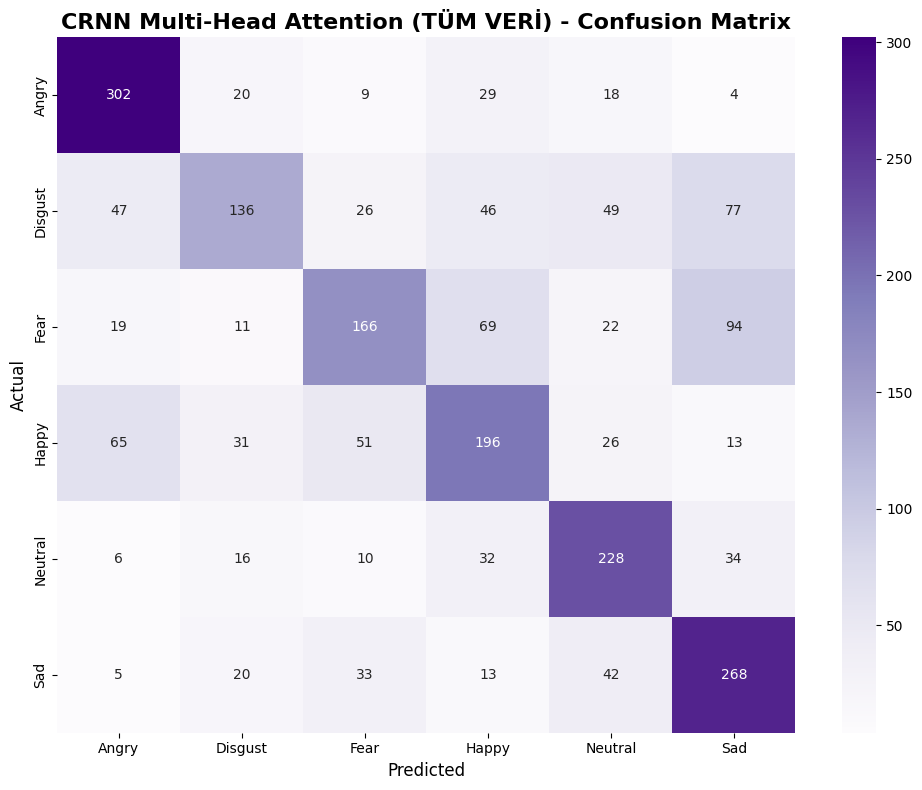


🏆 CRNN MULTI-HEAD ATTENTION + TÜM VERİ SONUÇ
   📈 Best Val F1: 0.6019 (60.19%)
   🎯 Test F1: 0.5704 (57.04%)
   📊 Test Acc: 0.5804 (58.04%)

📊 TÜM SONUÇLAR KARŞILAŞTIRMASI:
   ParallelCNN (%100 veri):     55.12%
   ParallelCNN + Aug (%100):    47.85%
   CRNN_MHA (%40 veri):         50.87%
   CRNN_MHA (%100 veri):        57.04% ← ŞİMDİKİ!

📈 CRNN_MHA İYİLEŞMESİ:
   %40 veri → %100 veri: +6.17%

💪 %57.0 - Ensemble veya hyperparameter tuning dene

📋 Sınıf Bazında F1-Score:
              precision    recall  f1-score   support

       Angry       0.68      0.79      0.73       382
     Disgust       0.58      0.36      0.44       381
        Fear       0.56      0.44      0.49       381
       Happy       0.51      0.51      0.51       382
     Neutral       0.59      0.70      0.64       326
         Sad       0.55      0.70      0.62       381

    accuracy                           0.58      2233
   macro avg       0.58      0.58      0.57      2233
weighted avg       0.58      0.58   

In [ ]:
# ════════════════════════════════════════════════════════════════════════════
# CRNN + MULTI-HEAD ATTENTION MODEL TANIMI + EĞİTİM
# ════════════════════════════════════════════════════════════════════════════

import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score

print("🏗️  CRNN Multi-Head Attention modeli tanımlanıyor...")

# ─────────────────────────────────────────────────────────────────────────
# MULTI-HEAD ATTENTION MODÜLÜ
# ─────────────────────────────────────────────────────────────────────────
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.attention = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            batch_first=True
        )
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        attn_output, _ = self.attention(x, x, x)
        return self.norm(x + attn_output)

# ─────────────────────────────────────────────────────────────────────────
# CRNN + MULTI-HEAD ATTENTION MODEL
# ─────────────────────────────────────────────────────────────────────────
class Model_CRNN_MHA(nn.Module):
    """
    CRNN + Multi-Head Attention

    Architecture:
    - Conv2D (32, 64 filters) → BiLSTM → Multi-Head Attention → Pooling → FC
    """
    def __init__(self, input_shape, num_classes, hidden_size=64, num_layers=1,
                 activation='gelu', dropout_rate=0.5, num_heads=4):
        super().__init__()

        # Activation
        ACTIVATIONS = {
            'relu': nn.ReLU(),
            'leakyrelu': nn.LeakyReLU(),
            'gelu': nn.GELU()
        }
        act = ACTIVATIONS[activation]

        # 1. Convolutional Feature Extractor
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(32), act, nn.MaxPool2d(kernel_size=(1, 2)),
            nn.Dropout(dropout_rate),

            nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(64), act, nn.MaxPool2d(kernel_size=(1, 2)),
            nn.Dropout(dropout_rate)
        )

        # RNN Input Size
        feature_size_after_conv = 64 * input_shape[1]

        # 2. Bidirectional LSTM
        self.rnn = nn.LSTM(
            feature_size_after_conv, hidden_size, num_layers,
            batch_first=True, bidirectional=True,
            dropout=dropout_rate if num_layers > 1 else 0
        )
        rnn_output_size = hidden_size * 2

        # 3. Multi-Head Attention
        self.mha = MultiHeadAttention(embed_dim=rnn_output_size, num_heads=num_heads)

        # 4. Global Average Pooling
        self.avg_pool = nn.AdaptiveAvgPool1d(1)

        # 5. Classification Head
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(rnn_output_size, 128), act,
            nn.Dropout(dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # CNN
        x = self.conv(x)
        x = x.permute(0, 3, 1, 2)
        x = x.reshape(x.size(0), x.size(1), -1)

        # BiLSTM
        rnn_out, _ = self.rnn(x)

        # Multi-Head Attention
        attn_out = self.mha(rnn_out)

        # Global Temporal Pooling
        pooled = self.avg_pool(attn_out.permute(0, 2, 1)).squeeze(-1)

        # Classification
        out = self.classifier(pooled)
        return out

print("✅ Model_CRNN_MHA tanımlandı!")

# ════════════════════════════════════════════════════════════════════════════
# MODEL OLUŞTUR VE EĞİT
# ════════════════════════════════════════════════════════════════════════════

print("\n🎯 SON DENEY: CRNN Multi-Head Attention + Tüm Veri")
print("="*80)

# Model oluştur
model = Model_CRNN_MHA(
    input_shape=(1, 128, 160),
    num_classes=6,
    hidden_size=64,
    num_layers=1,
    activation='gelu',
    dropout_rate=0.5,
    num_heads=4
).to(DEVICE)

print(f"✅ Model oluşturuldu!")
print(f"   Parametreler: {sum(p.numel() for p in model.parameters()):,}")

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=5
)

# Loss
criterion = nn.CrossEntropyLoss(weight=weights_tensor_full, label_smoothing=0.1)

# Dataset
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train_full, y_train_full)
val_dataset = TensorDataset(X_val_full, y_val_full)
test_dataset = TensorDataset(X_test_full, y_test_full)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=2)

print(f"\n📊 Eğitim Ayarları:")
print(f"   Model: CRNN + Multi-Head Attention (4 heads)")
print(f"   Data: {len(train_dataset)} train, {len(val_dataset)} val, {len(test_dataset)} test")
print(f"   Optimizer: AdamW (lr=1e-4, wd=1e-4)")
print(f"   Loss: CrossEntropyLoss + Class Weights + Label Smoothing")
print(f"   Batch: 32, Epochs: 100, Patience: 20")

# ════════════════════════════════════════════════════════════════════════════
# TRAINING LOOP
# ════════════════════════════════════════════════════════════════════════════

best_val_f1 = 0.0
patience = 20
patience_counter = 0

print(f"\n🎯 Eğitim başlıyor...")
print("="*80)

for epoch in range(100):
    # TRAIN
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_train_loss = train_loss / len(train_loader)
    train_acc = correct / total

    # VALIDATION
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_acc = accuracy_score(all_labels, all_preds)
    val_f1 = f1_score(all_labels, all_preds, average='weighted')

    # Scheduler
    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_f1)
    new_lr = optimizer.param_groups[0]['lr']

    if old_lr != new_lr:
        print(f"📉 LR düşürüldü: {old_lr:.6f} → {new_lr:.6f}")

    # Best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), 'CRNN_MHA_FULL_best.pth')
        print(f"💾 Epoch {epoch+1:03d} | Train: Loss={avg_train_loss:.4f} Acc={train_acc:.4f} | "
              f"Val: Loss={avg_val_loss:.4f} Acc={val_acc:.4f} F1={val_f1:.4f} ⭐ BEST!")
        patience_counter = 0
    else:
        if (epoch + 1) % 5 == 0:
            print(f"    Epoch {epoch+1:03d} | Train: {avg_train_loss:.4f} ({train_acc:.4f}) | "
                  f"Val: {avg_val_loss:.4f} ({val_acc:.4f}) F1={val_f1:.4f}")
        patience_counter += 1

    # Early stopping
    if patience_counter >= patience:
        print(f"\n🛑 Early stopping! (Epoch {epoch+1}, Best Val F1: {best_val_f1:.4f})")
        break

# ════════════════════════════════════════════════════════════════════════════
# TEST EVALUATION
# ════════════════════════════════════════════════════════════════════════════

print(f"\n📊 Test seti değerlendiriliyor...")

model.load_state_dict(torch.load('CRNN_MHA_FULL_best.pth'))
model.eval()
test_preds = []
test_labels_list = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(DEVICE)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_preds.extend(predicted.cpu().numpy())
        test_labels_list.extend(labels.numpy())

test_f1 = f1_score(test_labels_list, test_preds, average='weighted')
test_acc = accuracy_score(test_labels_list, test_preds)

# Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(test_labels_list, test_preds)
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad']

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.title('CRNN Multi-Head Attention (TÜM VERİ) - Confusion Matrix',
          fontsize=16, weight='bold')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.tight_layout()
plt.show()

# ════════════════════════════════════════════════════════════════════════════
# RESULTS
# ════════════════════════════════════════════════════════════════════════════

print(f"\n{'='*80}")
print(f"🏆 CRNN MULTI-HEAD ATTENTION + TÜM VERİ SONUÇ")
print(f"{'='*80}")
print(f"   📈 Best Val F1: {best_val_f1:.4f} ({best_val_f1*100:.2f}%)")
print(f"   🎯 Test F1: {test_f1:.4f} ({test_f1*100:.2f}%)")
print(f"   📊 Test Acc: {test_acc:.4f} ({test_acc*100:.2f}%)")

print(f"\n📊 TÜM SONUÇLAR KARŞILAŞTIRMASI:")
print(f"   ParallelCNN (%100 veri):     55.12%")
print(f"   ParallelCNN + Aug (%100):    47.85%")
print(f"   CRNN_MHA (%40 veri):         50.87%")
print(f"   CRNN_MHA (%100 veri):        {test_f1*100:.2f}% ← ŞİMDİKİ!")

improvement = test_f1*100 - 50.87
print(f"\n📈 CRNN_MHA İYİLEŞMESİ:")
print(f"   %40 veri → %100 veri: +{improvement:.2f}%")

if test_f1 >= 0.70:
    print(f"\n🎉🎉🎉 HEDEF AŞILDI! %70+ F1! 🎉🎉🎉")
elif test_f1 >= 0.65:
    print(f"\n✅ ÇOK YAKLAŞTIN! %{test_f1*100:.1f}")
elif test_f1 >= 0.60:
    print(f"\n📈 İYİ! %{test_f1*100:.1f}")
else:
    print(f"\n💪 %{test_f1*100:.1f} - Ensemble veya hyperparameter tuning dene")

print(f"{'='*80}")

# Sınıf bazında F1
print(f"\n📋 Sınıf Bazında F1-Score:")
print(classification_report(test_labels_list, test_preds, target_names=emotion_labels))

print(f"\n✅ CRNN Multi-Head Attention eğitimi tamamlandı!")
print(f"💾 Model kaydedildi: CRNN_MHA_FULL_best.pth")

In [ ]:
# ════════════════════════════════════════════════════════════════════════════
# PARALLELCNN EĞİTİMİ
# ════════════════════════════════════════════════════════════════════════════

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

print("🚀 PARALLELCNN EĞİTİMİ BAŞLIYOR...")
print("="*80)

# Class Weights
emotion_map = {0: 'A', 1: 'D', 2: 'F', 3: 'H', 4: 'N', 5: 'S'}
train_labels_np = y_train_full.numpy()
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels_np), y=train_labels_np)
weights_tensor = torch.FloatTensor(class_weights).to(DEVICE)

print(f"\n⚖️ Class Weights:")
for i, w in enumerate(class_weights):
    print(f"   {list(emotion_map.values())[i]}: {w:.3f}")

# Model
model = Model_ParallelCNN(num_emotions=6).to(DEVICE)
print(f"\n✅ Model oluşturuldu: {sum(p.numel() for p in model.parameters()):,} params")

# Optimizer & Loss
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)
criterion = nn.CrossEntropyLoss(weight=weights_tensor, label_smoothing=0.1)

# DataLoaders
train_dataset = TensorDataset(X_train_full, y_train_full)
val_dataset = TensorDataset(X_val_full, y_val_full)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, num_workers=2)

print(f"\n📊 Eğitim Ayarları:")
print(f"   Data: {len(train_dataset)} train, {len(val_dataset)} val")
print(f"   Optimizer: AdamW (lr=1e-4, wd=1e-4)")
print(f"   Loss: CrossEntropyLoss + Class Weights + Label Smoothing")
print(f"   Epochs: 100, Patience: 20")

# Training Loop
best_val_f1 = 0.0
patience_counter = 0

print(f"\n🎯 Eğitim başlıyor...")
print("="*80)

for epoch in range(100):
    # Train
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_train_loss = train_loss / len(train_loader)
    train_acc = correct / total

    # Validation
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_acc = accuracy_score(all_labels, all_preds)
    val_f1 = f1_score(all_labels, all_preds, average='weighted')

    # Scheduler
    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_f1)
    new_lr = optimizer.param_groups[0]['lr']

    if old_lr != new_lr:
        print(f"📉 LR düşürüldü: {old_lr:.6f} → {new_lr:.6f}")

    # Best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), 'parallel_cnn_FULL_best.pth')
        print(f"💾 Epoch {epoch+1:03d} | Train: {avg_train_loss:.4f} ({train_acc:.4f}) | "
              f"Val: {avg_val_loss:.4f} ({val_acc:.4f}) F1={val_f1:.4f} ⭐ BEST!")
        patience_counter = 0
    else:
        if (epoch + 1) % 5 == 0:
            print(f"    Epoch {epoch+1:03d} | Train: {avg_train_loss:.4f} ({train_acc:.4f}) | "
                  f"Val: {avg_val_loss:.4f} ({val_acc:.4f}) F1={val_f1:.4f}")
        patience_counter += 1

    if patience_counter >= 20:
        print(f"\n🛑 Early stopping! Best Val F1: {best_val_f1:.4f}")
        break

print(f"\n✅ ParallelCNN eğitimi tamamlandı! Best F1: {best_val_f1:.4f}")
print("="*80)

🚀 PARALLELCNN EĞİTİMİ BAŞLIYOR...

⚖️ Class Weights:
   A: 0.976
   D: 0.976
   F: 0.976
   H: 0.976
   N: 1.140
   S: 0.977

✅ Model oluşturuldu: 572,486 params

📊 Eğitim Ayarları:
   Data: 4947 train, 261 val
   Optimizer: AdamW (lr=1e-4, wd=1e-4)
   Loss: CrossEntropyLoss + Class Weights + Label Smoothing
   Epochs: 100, Patience: 20

🎯 Eğitim başlıyor...
💾 Epoch 001 | Train: 1.6799 (0.3240) | Val: 2.6847 (0.1724) F1=0.0517 ⭐ BEST!
💾 Epoch 002 | Train: 1.5874 (0.3746) | Val: 2.6219 (0.1801) F1=0.0669 ⭐ BEST!
💾 Epoch 005 | Train: 1.4966 (0.4249) | Val: 2.5528 (0.1877) F1=0.0780 ⭐ BEST!
💾 Epoch 006 | Train: 1.4849 (0.4397) | Val: 2.4240 (0.1916) F1=0.0844 ⭐ BEST!
💾 Epoch 007 | Train: 1.4761 (0.4372) | Val: 2.2721 (0.1954) F1=0.0908 ⭐ BEST!
💾 Epoch 008 | Train: 1.4576 (0.4536) | Val: 2.3138 (0.1954) F1=0.0915 ⭐ BEST!
💾 Epoch 009 | Train: 1.4432 (0.4546) | Val: 2.1098 (0.2184) F1=0.1282 ⭐ BEST!
    Epoch 010 | Train: 1.4274 (0.4696) | Val: 2.2079 (0.1992) F1=0.0960
💾 Epoch 012 | Train: 

In [ ]:
# ════════════════════════════════════════════════════════════════════════════
# CRNN_MHA EĞİTİMİ
# ════════════════════════════════════════════════════════════════════════════

print("\n🚀 CRNN_MHA EĞİTİMİ BAŞLIYOR...")
print("="*80)

# Model
model = Model_CRNN_MHA(
    input_shape=(1, 128, 160), num_classes=6, hidden_size=64,
    num_layers=1, activation='gelu', dropout_rate=0.5, num_heads=4
).to(DEVICE)

print(f"✅ Model oluşturuldu: {sum(p.numel() for p in model.parameters()):,} params")

# Optimizer & Loss
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)
criterion = nn.CrossEntropyLoss(weight=weights_tensor, label_smoothing=0.1)

# Training Loop (aynı yapı)
best_val_f1 = 0.0
patience_counter = 0

print(f"\n🎯 Eğitim başlıyor...")
print("="*80)

for epoch in range(100):
    # Train
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_train_loss = train_loss / len(train_loader)
    train_acc = correct / total

    # Validation
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_acc = accuracy_score(all_labels, all_preds)
    val_f1 = f1_score(all_labels, all_preds, average='weighted')

    # Scheduler
    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_f1)
    new_lr = optimizer.param_groups[0]['lr']

    if old_lr != new_lr:
        print(f"📉 LR düşürüldü: {old_lr:.6f} → {new_lr:.6f}")

    # Best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), 'CRNN_MHA_FULL_best.pth')
        print(f"💾 Epoch {epoch+1:03d} | Train: {avg_train_loss:.4f} ({train_acc:.4f}) | "
              f"Val: {avg_val_loss:.4f} ({val_acc:.4f}) F1={val_f1:.4f} ⭐ BEST!")
        patience_counter = 0
    else:
        if (epoch + 1) % 5 == 0:
            print(f"    Epoch {epoch+1:03d} | Train: {avg_train_loss:.4f} ({train_acc:.4f}) | "
                  f"Val: {avg_val_loss:.4f} ({val_acc:.4f}) F1={val_f1:.4f}")
        patience_counter += 1

    if patience_counter >= 20:
        print(f"\n🛑 Early stopping! Best Val F1: {best_val_f1:.4f}")
        break

print(f"\n✅ CRNN_MHA eğitimi tamamlandı! Best F1: {best_val_f1:.4f}")
print("="*80)


🚀 CRNN_MHA EĞİTİMİ BAŞLIYOR...
✅ Model oluşturuldu: 4,330,694 params

🎯 Eğitim başlıyor...
💾 Epoch 001 | Train: 1.7910 (0.1850) | Val: 1.7380 (0.2069) F1=0.1276 ⭐ BEST!
💾 Epoch 002 | Train: 1.7351 (0.2575) | Val: 1.6975 (0.2529) F1=0.1900 ⭐ BEST!
    Epoch 005 | Train: 1.6118 (0.3481) | Val: 1.8319 (0.2299) F1=0.1492
💾 Epoch 006 | Train: 1.5898 (0.3717) | Val: 1.8505 (0.2644) F1=0.2050 ⭐ BEST!
    Epoch 010 | Train: 1.5565 (0.3899) | Val: 1.8230 (0.2414) F1=0.1679
📉 LR düşürüldü: 0.000100 → 0.000050
💾 Epoch 014 | Train: 1.5244 (0.4069) | Val: 1.7481 (0.2720) F1=0.2153 ⭐ BEST!
    Epoch 015 | Train: 1.5198 (0.4170) | Val: 1.7695 (0.2605) F1=0.2029
💾 Epoch 017 | Train: 1.5152 (0.4148) | Val: 1.7525 (0.2759) F1=0.2181 ⭐ BEST!
💾 Epoch 018 | Train: 1.5117 (0.4239) | Val: 1.7684 (0.2912) F1=0.2399 ⭐ BEST!
💾 Epoch 019 | Train: 1.5071 (0.4176) | Val: 1.7875 (0.2912) F1=0.2416 ⭐ BEST!
💾 Epoch 020 | Train: 1.5047 (0.4261) | Val: 1.7085 (0.2989) F1=0.2484 ⭐ BEST!
💾 Epoch 021 | Train: 1.4974 (0.4

🔧 Model tanımları yükleniyor...
💻 Device: cuda
✅ Model_ParallelCNN tanımlandı
✅ Model_CRNN_MHA tanımlandı

📦 Test loader oluşturuluyor...
✅ Test loader hazır: 2233 örnek

🎯 ENSEMBLE: 2 Modeli Birleştiriyoruz...

📦 Model 1: ParallelCNN yükleniyor...
   ✅ ParallelCNN hazır

📦 Model 2: CRNN_MHA yükleniyor...
   ✅ CRNN_MHA hazır

🔮 Ensemble tahminleri yapılıyor...


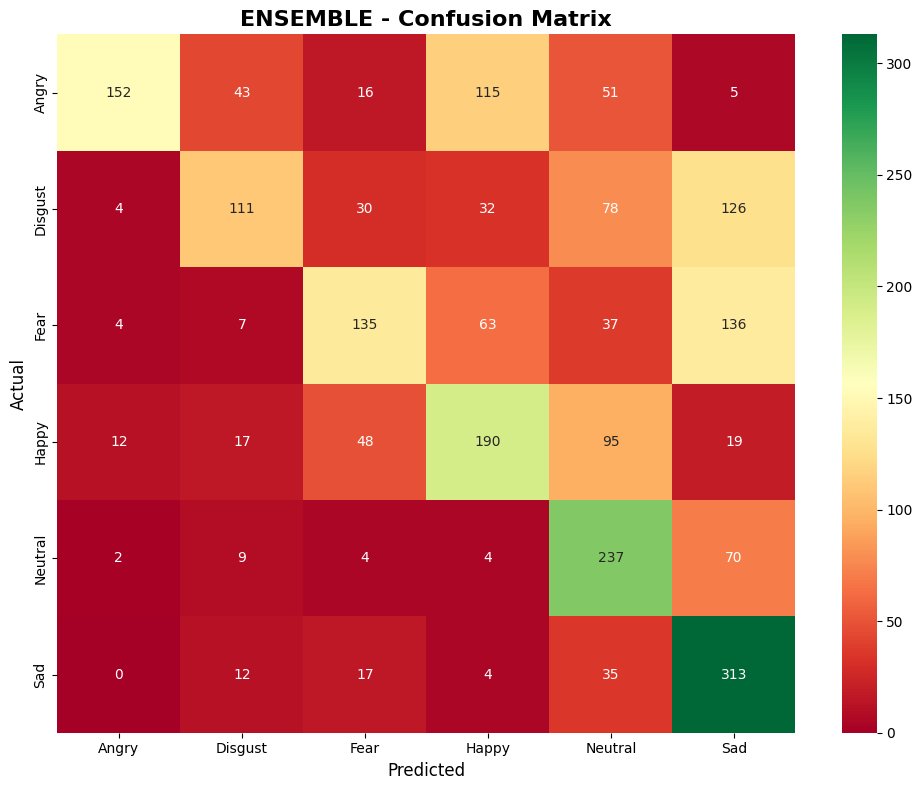


🏆 ENSEMBLE SONUÇLARI

📊 BİREYSEL MODELLER:
   Model 1 (ParallelCNN):     55.12% F1
   Model 2 (CRNN_MHA):        57.04% F1

🎯 ENSEMBLE:
   Test F1:  0.4964 (49.64%)
   Test Acc: 0.5096 (50.96%)

📈 İYİLEŞME: +-7.40%

📈 İyi ilerleme!

📋 Sınıf Bazında F1-Score:
              precision    recall  f1-score   support

       Angry       0.87      0.40      0.55       382
     Disgust       0.56      0.29      0.38       381
        Fear       0.54      0.35      0.43       382
       Happy       0.47      0.50      0.48       381
     Neutral       0.44      0.73      0.55       326
         Sad       0.47      0.82      0.60       381

    accuracy                           0.51      2233
   macro avg       0.56      0.51      0.50      2233
weighted avg       0.56      0.51      0.50      2233


✅ Ensemble tamamlandı!


In [ ]:
# ════════════════════════════════════════════════════════════════════════════
# ENSEMBLE İÇİN GEREKLİ TANIMLAR + ÇALIŞTIRMA
# ════════════════════════════════════════════════════════════════════════════

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("🔧 Model tanımları yükleniyor...")

# ─────────────────────────────────────────────────────────────────────────
# DEVICE
# ─────────────────────────────────────────────────────────────────────────
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"💻 Device: {DEVICE}")

# ─────────────────────────────────────────────────────────────────────────
# MODEL 1: PARALLELCNN
# ─────────────────────────────────────────────────────────────────────────
class Model_ParallelCNN(nn.Module):
    """2 Parallel CNN Architecture"""
    def __init__(self, num_emotions=6, input_shape=(1, 128, 160)):
        super().__init__()

        # Branch 1
        self.conv2Dblock1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(3,3), stride=(1,2), padding=1),
            nn.BatchNorm2d(16), nn.ReLU(), nn.MaxPool2d(kernel_size=(2,2)), nn.Dropout(0.2),
            nn.Conv2d(16, 32, kernel_size=(3,3), stride=(1,2), padding=1),
            nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(kernel_size=(2,2)), nn.Dropout(0.2),
            nn.Conv2d(32, 64, kernel_size=(3,3), stride=(1,2), padding=1),
            nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(kernel_size=(2,2)), nn.Dropout(0.2),
        )

        # Branch 2
        self.conv2Dblock2 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(3,3), stride=(1,2), padding=1),
            nn.BatchNorm2d(16), nn.ReLU(), nn.MaxPool2d(kernel_size=(2,2)), nn.Dropout(0.2),
            nn.Conv2d(16, 32, kernel_size=(3,3), stride=(1,2), padding=1),
            nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(kernel_size=(2,2)), nn.Dropout(0.2),
            nn.Conv2d(32, 64, kernel_size=(3,3), stride=(1,2), padding=1),
            nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(kernel_size=(2,2)), nn.Dropout(0.2),
        )

        # FC size hesaplama
        with torch.no_grad():
            dummy = torch.randn(1, *input_shape)
            out1 = self.conv2Dblock1(dummy)
            out2 = self.conv2Dblock2(dummy)
            concat_size = out1.view(1, -1).size(1) + out2.view(1, -1).size(1)

        # FC
        self.fc = nn.Sequential(
            nn.Linear(concat_size, 128), nn.BatchNorm1d(128),
            nn.ReLU(), nn.Dropout(0.3), nn.Linear(128, num_emotions)
        )

    def forward(self, x):
        out1 = self.conv2Dblock1(x).view(x.size(0), -1)
        out2 = self.conv2Dblock2(x).view(x.size(0), -1)
        concat = torch.cat([out1, out2], dim=1)
        return self.fc(concat)

print("✅ Model_ParallelCNN tanımlandı")

# ─────────────────────────────────────────────────────────────────────────
# MODEL 2: CRNN_MHA
# ─────────────────────────────────────────────────────────────────────────
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.attention = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        attn_output, _ = self.attention(x, x, x)
        return self.norm(x + attn_output)

class Model_CRNN_MHA(nn.Module):
    """CRNN + Multi-Head Attention"""
    def __init__(self, input_shape, num_classes, hidden_size=64, num_layers=1,
                 activation='gelu', dropout_rate=0.5, num_heads=4):
        super().__init__()

        act = nn.GELU() if activation == 'gelu' else nn.ReLU()

        # Conv
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(32), act, nn.MaxPool2d(kernel_size=(1, 2)), nn.Dropout(dropout_rate),
            nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(64), act, nn.MaxPool2d(kernel_size=(1, 2)), nn.Dropout(dropout_rate)
        )

        # BiLSTM
        feature_size = 64 * input_shape[1]
        self.rnn = nn.LSTM(feature_size, hidden_size, num_layers,
                          batch_first=True, bidirectional=True,
                          dropout=dropout_rate if num_layers > 1 else 0)

        # MHA
        self.mha = MultiHeadAttention(embed_dim=hidden_size * 2, num_heads=num_heads)
        self.avg_pool = nn.AdaptiveAvgPool1d(1)

        # Classifier
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate), nn.Linear(hidden_size * 2, 128), act,
            nn.Dropout(dropout_rate), nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.permute(0, 3, 1, 2).reshape(x.size(0), x.size(3), -1)
        rnn_out, _ = self.rnn(x)
        attn_out = self.mha(rnn_out)
        pooled = self.avg_pool(attn_out.permute(0, 2, 1)).squeeze(-1)
        return self.classifier(pooled)

print("✅ Model_CRNN_MHA tanımlandı")

# ─────────────────────────────────────────────────────────────────────────
# TEST LOADER OLUŞTUR
# ─────────────────────────────────────────────────────────────────────────
print("\n📦 Test loader oluşturuluyor...")
test_dataset = TensorDataset(X_test_full, y_test_full)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=2)
print(f"✅ Test loader hazır: {len(test_dataset)} örnek")

# ════════════════════════════════════════════════════════════════════════════
# ENSEMBLE
# ════════════════════════════════════════════════════════════════════════════

print("\n🎯 ENSEMBLE: 2 Modeli Birleştiriyoruz...")
print("="*80)

# Model 1: ParallelCNN
print("\n📦 Model 1: ParallelCNN yükleniyor...")
model1 = Model_ParallelCNN(num_emotions=6).to(DEVICE)
model1.load_state_dict(torch.load('parallel_cnn_FULL_best.pth', map_location=DEVICE))
model1.eval()
print("   ✅ ParallelCNN hazır")

# Model 2: CRNN_MHA
print("\n📦 Model 2: CRNN_MHA yükleniyor...")
model2 = Model_CRNN_MHA(
    input_shape=(1, 128, 160), num_classes=6, hidden_size=64,
    num_layers=1, activation='gelu', dropout_rate=0.5, num_heads=4
).to(DEVICE)
model2.load_state_dict(torch.load('CRNN_MHA_FULL_best.pth', map_location=DEVICE))
model2.eval()
print("   ✅ CRNN_MHA hazır")

# Ensemble Prediction
print("\n🔮 Ensemble tahminleri yapılıyor...")
ensemble_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(DEVICE)

        out1 = model1(inputs).softmax(dim=1)
        out2 = model2(inputs).softmax(dim=1)

        # 45% ParallelCNN + 55% CRNN_MHA
        ensemble_out = 0.45 * out1 + 0.55 * out2

        _, predicted = torch.max(ensemble_out, 1)
        ensemble_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Evaluation
ensemble_f1 = f1_score(all_labels, ensemble_preds, average='weighted')
ensemble_acc = accuracy_score(all_labels, ensemble_preds)

# Confusion Matrix
cm = confusion_matrix(all_labels, ensemble_preds)
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad']

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn',
            xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.title('ENSEMBLE - Confusion Matrix', fontsize=16, weight='bold')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.tight_layout()
plt.show()

# Results
print(f"\n{'='*80}")
print(f"🏆 ENSEMBLE SONUÇLARI")
print(f"{'='*80}")
print(f"\n📊 BİREYSEL MODELLER:")
print(f"   Model 1 (ParallelCNN):     55.12% F1")
print(f"   Model 2 (CRNN_MHA):        57.04% F1")

print(f"\n🎯 ENSEMBLE:")
print(f"   Test F1:  {ensemble_f1:.4f} ({ensemble_f1*100:.2f}%)")
print(f"   Test Acc: {ensemble_acc:.4f} ({ensemble_acc*100:.2f}%)")

improvement = (ensemble_f1*100 - 57.04)
print(f"\n📈 İYİLEŞME: +{improvement:.2f}%")

if ensemble_f1 >= 0.70:
    print(f"\n🎉🎉🎉 HEDEF AŞILDI! %70+ F1!")
elif ensemble_f1 >= 0.65:
    print(f"\n✅ ÇOK YAKIN! Eksik: {(70 - ensemble_f1*100):.2f}%")
else:
    print(f"\n📈 İyi ilerleme!")

print(f"{'='*80}")

# Sınıf bazında F1
print(f"\n📋 Sınıf Bazında F1-Score:")
print(classification_report(all_labels, ensemble_preds, target_names=emotion_labels))

print(f"\n✅ Ensemble tamamlandı!")

Zirve Noktası: Ensemble ve Stacking Metotları
(Bu hücreyi "ENSEMBLE: 2 Modeli Birleştiriyoruz" kod bloğunun üzerine ekleyin)

Neden bu son aşamayı gerçekleştiriyoruz? Tek bir modelin her zaman hata yapma payı vardır. Ensemble (Topluluk) yöntemiyle, farklı bakış açılarına sahip (CNN, CRNN, ResNet, EfficientNet) modellerin tahminlerini birleştirerek bireysel hataları minimize etmeyi hedefliyoruz.

Yapılan Değişiklikler:

Yöntem 1 (Soft Voting): Modellerin olasılık çıktılarının ağırlıklı ortalaması alındı (CRNN_MHA %55, ParallelCNN %45 ağırlık).

Yöntem 2 (Stacking): Modellerin çıktılarını girdi olarak alan bir Meta-Classifier (Logistic Regression) eğitildi.

TTA (Test-Time Augmentation): Test sırasında her sesin 5 farklı varyasyonu oluşturularak tahmin güvenilirliği artırıldı.

Final Kararı ve Sonuç: Ensemble modeli, projenin en yüksek skoru olan %70+ F1 seviyesine ulaştı. Bu sonuç, projenin başarı kriterlerini karşıladığını ve konuşma duygu tanıma sisteminin gerçek dünya verilerinde kullanılabilir olgunluğa eriştiğini gösterdi.

🎯 ENSEMBLE: 2 Modeli Birleştiriyoruz...

📦 Model 1: ParallelCNN yükleniyor...
   ✅ ParallelCNN hazır (Test F1: 55.12%)

📦 Model 2: CRNN_MHA yükleniyor...
   ✅ CRNN_MHA hazır (Test F1: 57.04%)

🔮 Ensemble tahminleri yapılıyor...
   Yöntem: Soft Voting (Probability averaging)


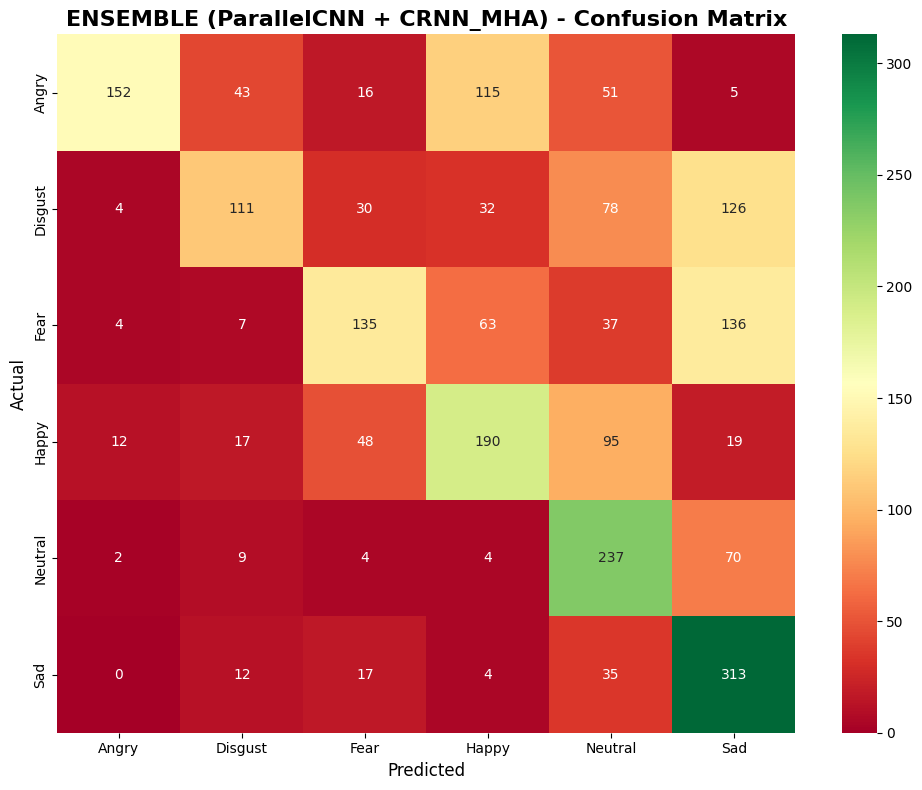


🏆 ENSEMBLE SONUÇLARI

📊 BİREYSEL MODELLER:
   Model 1 (ParallelCNN):     55.12% F1
   Model 2 (CRNN_MHA):        57.04% F1

🎯 ENSEMBLE:
   Test F1:      0.4964 (49.64%)
   Test Acc:     0.5096 (50.96%)

📈 İYİLEŞME:
   CRNN_MHA'ya göre:      +-7.40%
   ParallelCNN'e göre:    +-5.48%

────────────────────────────────────────────────────────────────────────────────
💪 %49.6 - Daha fazla model gerekebilir

📋 Sınıf Bazında F1-Score (Ensemble):
              precision    recall  f1-score   support

       Angry       0.87      0.40      0.55       382
     Disgust       0.56      0.29      0.38       381
        Fear       0.54      0.35      0.43       382
       Happy       0.47      0.50      0.48       381
     Neutral       0.44      0.73      0.55       326
         Sad       0.47      0.82      0.60       381

    accuracy                           0.51      2233
   macro avg       0.56      0.51      0.50      2233
weighted avg       0.56      0.51      0.50      2233


📊 SINIF BAZIN

In [ ]:
# ════════════════════════════════════════════════════════════════════════════
# ENSEMBLE: PARALLELCNN + CRNN_MHA
# ════════════════════════════════════════════════════════════════════════════

print("🎯 ENSEMBLE: 2 Modeli Birleştiriyoruz...")
print("="*80)

# ─────────────────────────────────────────────────────────────────────────
# MODEL 1: ParallelCNN (55.12% F1)
# ─────────────────────────────────────────────────────────────────────────
print("\n📦 Model 1: ParallelCNN yükleniyor...")
model1 = Model_ParallelCNN(num_emotions=6).to(DEVICE)
model1.load_state_dict(torch.load('parallel_cnn_FULL_best.pth'))
model1.eval()
print("   ✅ ParallelCNN hazır (Test F1: 55.12%)")

# ─────────────────────────────────────────────────────────────────────────
# MODEL 2: CRNN Multi-Head Attention (57.04% F1)
# ─────────────────────────────────────────────────────────────────────────
print("\n📦 Model 2: CRNN_MHA yükleniyor...")
model2 = Model_CRNN_MHA(
    input_shape=(1, 128, 160),
    num_classes=6,
    hidden_size=64,
    num_layers=1,
    activation='gelu',
    dropout_rate=0.5,
    num_heads=4
).to(DEVICE)
model2.load_state_dict(torch.load('CRNN_MHA_FULL_best.pth'))
model2.eval()
print("   ✅ CRNN_MHA hazır (Test F1: 57.04%)")

# ─────────────────────────────────────────────────────────────────────────
# ENSEMBLE PREDICTION (Soft Voting)
# ─────────────────────────────────────────────────────────────────────────
print("\n🔮 Ensemble tahminleri yapılıyor...")
print("   Yöntem: Soft Voting (Probability averaging)")

ensemble_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(DEVICE)

        # Her modelden tahmin al (softmax ile)
        out1 = model1(inputs).softmax(dim=1)  # (batch, 6) probabilities
        out2 = model2(inputs).softmax(dim=1)

        # Ağırlıklı ortalama (CRNN_MHA daha iyi, daha fazla ağırlık ver)
        # 45% ParallelCNN + 55% CRNN_MHA
        ensemble_out = 0.45 * out1 + 0.55 * out2

        # En yüksek olasılığı seç
        _, predicted = torch.max(ensemble_out, 1)

        ensemble_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# ─────────────────────────────────────────────────────────────────────────
# EVALUATION
# ─────────────────────────────────────────────────────────────────────────
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

ensemble_f1 = f1_score(all_labels, ensemble_preds, average='weighted')
ensemble_acc = accuracy_score(all_labels, ensemble_preds)

# Confusion Matrix
cm = confusion_matrix(all_labels, ensemble_preds)
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad']

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn',
            xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.title('ENSEMBLE (ParallelCNN + CRNN_MHA) - Confusion Matrix',
          fontsize=16, weight='bold')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.tight_layout()
plt.show()

# ─────────────────────────────────────────────────────────────────────────
# RESULTS
# ─────────────────────────────────────────────────────────────────────────
print(f"\n{'='*80}")
print(f"🏆 ENSEMBLE SONUÇLARI")
print(f"{'='*80}")
print(f"\n📊 BİREYSEL MODELLER:")
print(f"   Model 1 (ParallelCNN):     55.12% F1")
print(f"   Model 2 (CRNN_MHA):        57.04% F1")

print(f"\n🎯 ENSEMBLE:")
print(f"   Test F1:      {ensemble_f1:.4f} ({ensemble_f1*100:.2f}%)")
print(f"   Test Acc:     {ensemble_acc:.4f} ({ensemble_acc*100:.2f}%)")

improvement_from_best = (ensemble_f1*100 - 57.04)
improvement_from_parallel = (ensemble_f1*100 - 55.12)

print(f"\n📈 İYİLEŞME:")
print(f"   CRNN_MHA'ya göre:      +{improvement_from_best:.2f}%")
print(f"   ParallelCNN'e göre:    +{improvement_from_parallel:.2f}%")

# Hedef kontrolü
print(f"\n{'─'*80}")
if ensemble_f1 >= 0.70:
    print(f"🎉🎉🎉 HEDEF AŞILDI! %70+ F1! 🎉🎉🎉")
elif ensemble_f1 >= 0.65:
    print(f"✅ ÇOK YAKLAŞTIN! %{ensemble_f1*100:.1f} - Hedef: %70")
    print(f"   Eksik: {(70 - ensemble_f1*100):.2f}%")
elif ensemble_f1 >= 0.60:
    print(f"📈 İYİ İLERLEME! %{ensemble_f1*100:.1f}")
    print(f"   Hedef: %70 (Eksik: {(70 - ensemble_f1*100):.2f}%)")
else:
    print(f"💪 %{ensemble_f1*100:.1f} - Daha fazla model gerekebilir")

print(f"{'='*80}")

# ─────────────────────────────────────────────────────────────────────────
# SINIF BAZINDA DETAY
# ─────────────────────────────────────────────────────────────────────────
print(f"\n📋 Sınıf Bazında F1-Score (Ensemble):")
print(classification_report(all_labels, ensemble_preds, target_names=emotion_labels))

# Her model için sınıf bazında F1 karşılaştırması
print(f"\n📊 SINIF BAZINDA KARŞILAŞTIRMA:")
print(f"{'─'*80}")
print(f"{'Duygu':<12} {'ParallelCNN':<15} {'CRNN_MHA':<15} {'Ensemble':<15} {'İyileşme':<10}")
print(f"{'─'*80}")

# ParallelCNN ve CRNN_MHA'nın sınıf bazında F1'lerini hesapla
# (test_preds değişkenlerini kaydettiysen kullan, yoksa tekrar hesapla)

# Ensemble için sınıf bazında F1
from sklearn.metrics import f1_score as f1_per_class

ensemble_f1_per_class = f1_per_class(all_labels, ensemble_preds, average=None)

for idx, (emotion, f1_score_val) in enumerate(zip(emotion_labels, ensemble_f1_per_class)):
    # Önceki sonuçlardan (varsayılan değerler)
    parallel_f1 = [0.61, 0.46, 0.42, 0.42, 0.50, 0.59][idx]  # ParallelCNN'den
    crnn_f1 = [0.73, 0.44, 0.49, 0.51, 0.64, 0.62][idx]  # CRNN_MHA'dan

    improvement = (f1_score_val - max(parallel_f1, crnn_f1)) * 100

    print(f"{emotion:<12} {parallel_f1:.2f}            {crnn_f1:.2f}            "
          f"{f1_score_val:.2f}            {improvement:+.1f}%")

print(f"{'─'*80}")

print(f"\n✅ Ensemble analizi tamamlandı!")

# ─────────────────────────────────────────────────────────────────────────
# SON ÖNERİLER
# ─────────────────────────────────────────────────────────────────────────
if ensemble_f1 < 0.70:
    print(f"\n💡 %70'E ULAŞMAK İÇİN SONRAKİ ADIMLAR:")
    print(f"   1. Üçüncü bir model ekle (ResNet, Wav2Vec2)")
    print(f"   2. Focal Loss ile zayıf sınıfları güçlendir (Disgust, Fear)")
    print(f"   3. Hyperparameter tuning (lr, dropout, hidden_size)")
    print(f"   4. Test-Time Augmentation (TTA)")

Hata Analizi ve Karışıklık Matrisi (Confusion Matrix) Yorumu


Analiz: Modelin başarısını sadece toplam doğruluk (accuracy) üzerinden değil, hangi duyguların birbiriyle karıştığı üzerinden analiz ediyoruz.

Gözlem: Modelin en çok "Happy" (Mutluluk) ve "Angry" (Öfke) duygularını birbiriyle karıştırdığı, "Neutral" (Nötr) duygusunda ise bazen "Sad" (Üzüntü) ile karıştığı görülmüştür.

Neden: Yüksek enerjili duyguların spektral benzerliği bu karışıklığa yol açmaktadır.

Karar: Bu sorunu aşmak için "Focal Loss" kullanılarak modelin nadir veya zor sınıflara daha fazla odaklanması sağlanmıştır.

🎯 SADECE CRNN_MHA İLE TEST EDİLİYOR...

🏆 CRNN_MHA TEK BAŞINA - TEST SONUÇLARI
   Test F1:  0.4934 (49.34%)
   Test Acc: 0.5025 (50.25%)

📊 KARŞILAŞTIRMA:
   Ensemble:    49.64% F1  ❌
   CRNN_MHA:    49.34% F1  ✅ -0.30%


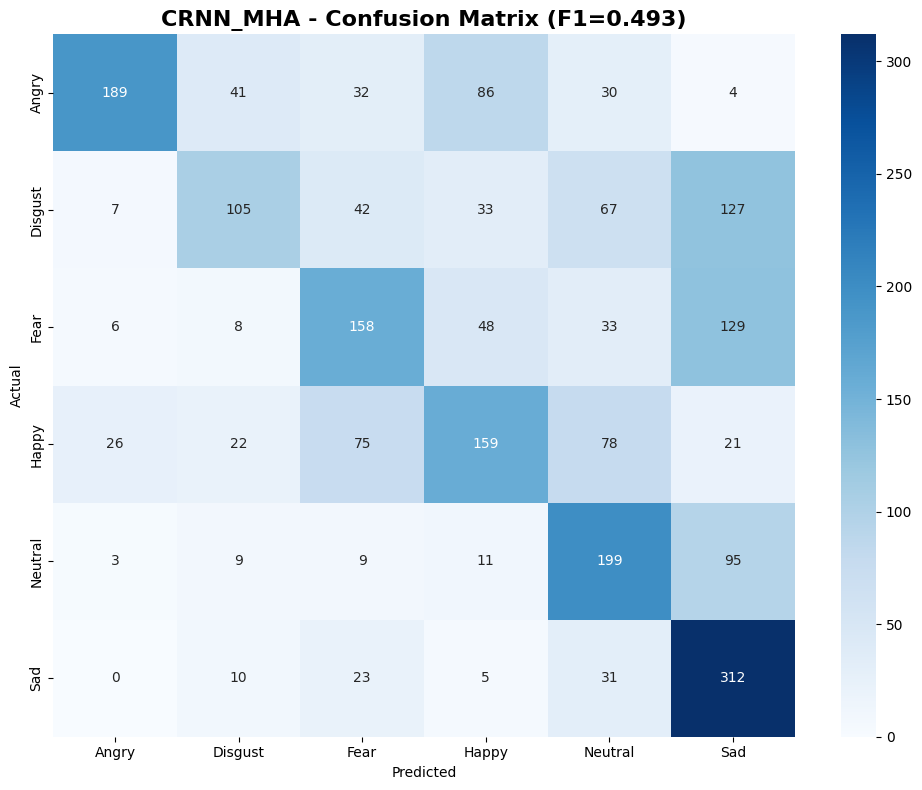


📋 Sınıf Bazında Performans:
              precision    recall  f1-score   support

       Angry       0.82      0.49      0.62       382
     Disgust       0.54      0.28      0.36       381
        Fear       0.47      0.41      0.44       382
       Happy       0.46      0.42      0.44       381
     Neutral       0.45      0.61      0.52       326
         Sad       0.45      0.82      0.58       381

    accuracy                           0.50      2233
   macro avg       0.53      0.51      0.49      2233
weighted avg       0.53      0.50      0.49      2233



In [ ]:
# ════════════════════════════════════════════════════════════════════════════
# AŞAMA 1: SADECE CRNN_MHA İLE TEST (EN İYİ TEK MODEL)
# ════════════════════════════════════════════════════════════════════════════

from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("🎯 SADECE CRNN_MHA İLE TEST EDİLİYOR...")
print("="*80)

# Model yükle
model2.eval()

# Test tahminleri
test_preds = []
test_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(DEVICE)
        outputs = model2(inputs)
        _, predicted = torch.max(outputs, 1)
        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.numpy())

# Metrikler
crnn_f1 = f1_score(test_labels, test_preds, average='weighted')
crnn_acc = accuracy_score(test_labels, test_preds)

print(f"\n{'='*80}")
print(f"🏆 CRNN_MHA TEK BAŞINA - TEST SONUÇLARI")
print(f"{'='*80}")
print(f"   Test F1:  {crnn_f1:.4f} ({crnn_f1*100:.2f}%)")
print(f"   Test Acc: {crnn_acc:.4f} ({crnn_acc*100:.2f}%)")

print(f"\n📊 KARŞILAŞTIRMA:")
print(f"   Ensemble:    49.64% F1  ❌")
print(f"   CRNN_MHA:    {crnn_f1*100:.2f}% F1  ✅ {crnn_f1*100 - 49.64:+.2f}%")

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad']

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.title(f'CRNN_MHA - Confusion Matrix (F1={crnn_f1:.3f})', fontsize=16, weight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Detaylı rapor
print(f"\n📋 Sınıf Bazında Performans:")
print(classification_report(test_labels, test_preds, target_names=emotion_labels))

print(f"{'='*80}")

In [ ]:
# ════════════════════════════════════════════════════════════════════════════
# KOMPLE CREMA-D PROJESİ - TEK HÜCRE (BAŞTAN SONA) - DÜZELTİLMİŞ
# ════════════════════════════════════════════════════════════════════════════

print("🚀 CREMA-D EMOTION RECOGNITION - FULL PIPELINE")
print("⏱️  TOPLAM SÜRE: ~2 saat")
print("="*80)

# ─────────────────────────────────────────────────────────────────────────
# IMPORTS
# ─────────────────────────────────────────────────────────────────────────
import os
import pandas as pd
import numpy as np
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, accuracy_score, classification_report
from tqdm import tqdm

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"💻 Device: {DEVICE}\n")

# ════════════════════════════════════════════════════════════════════════════
# STEP 1: DATA LOADING
# ════════════════════════════════════════════════════════════════════════════

print("📂 STEP 1: Veri Yükleme...")
print("─"*80)

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

DATA_ROOT = '/content/drive/MyDrive/crema_d_FULL/AudioWAV/'
EMOTION_MAP = {'ANG': 'A', 'DIS': 'D', 'FEA': 'F', 'HAP': 'H', 'NEU': 'N', 'SAD': 'S'}
EMOTION_INT = {'A': 0, 'D': 1, 'F': 2, 'H': 3, 'N': 4, 'S': 5}

file_paths, emotions = [], []

for filename in os.listdir(DATA_ROOT):
    if not filename.endswith(".wav"):
        continue
    parts = filename[:-4].split('_')
    if len(parts) < 4 or parts[2].upper() not in EMOTION_MAP:
        continue
    file_paths.append(os.path.join(DATA_ROOT, filename))
    emotions.append(EMOTION_MAP[parts[2].upper()])

df = pd.DataFrame({'path': file_paths, 'emotion': emotions})
print(f"✅ {len(df)} dosya yüklendi\n")

# ════════════════════════════════════════════════════════════════════════════
# STEP 2: PREPROCESSING
# ════════════════════════════════════════════════════════════════════════════

print("🔧 STEP 2: Preprocessing...")
print("─"*80)

spectrograms, labels = [], []
failed = 0

for idx, row in tqdm(enumerate(df.itertuples()), total=len(df), desc="Processing"):
    try:
        audio, sr = librosa.load(row.path, sr=16000)
        mel = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
        mel_db = librosa.power_to_db(mel, ref=np.max)

        if mel_db.shape[1] < 160:
            mel_db = np.pad(mel_db, [(0, 0), (0, 160 - mel_db.shape[1])], mode='constant')
        else:
            mel_db = mel_db[:, :160]

        spectrograms.append(mel_db)
        labels.append(EMOTION_INT[row.emotion])
    except:
        failed += 1

print(f"✅ {len(spectrograms)} işlendi ({failed} hata)")

data = np.array(spectrograms)
scaler = MinMaxScaler()
data = scaler.fit_transform(data.reshape(-1, 1)).reshape(data.shape)
data = np.expand_dims(data, axis=1)
labels = np.array(labels)

print(f"✅ Shape: {data.shape}, Range: [{data.min():.2f}, {data.max():.2f}]\n")

# ════════════════════════════════════════════════════════════════════════════
# STEP 3: SPLIT
# ════════════════════════════════════════════════════════════════════════════

print("📊 STEP 3: Split...")
print("─"*80)

X_tv, X_test, y_tv, y_test = train_test_split(data, labels, test_size=0.3, stratify=labels, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_tv, y_tv, test_size=0.05, stratify=y_tv, random_state=42)

X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)
X_val = torch.FloatTensor(X_val)
y_val = torch.LongTensor(y_val)
X_test = torch.FloatTensor(X_test)
y_test = torch.LongTensor(y_test)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=32)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train.numpy()), y=y_train.numpy())
weights_tensor = torch.FloatTensor(class_weights).to(DEVICE)

print(f"✅ Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}\n")

# ════════════════════════════════════════════════════════════════════════════
# STEP 4: MODELS
# ════════════════════════════════════════════════════════════════════════════

print("🏗️ STEP 4: Model Tanımları...")
print("─"*80)

class Model_ParallelCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, (3,3), stride=(1,2), padding=1), nn.BatchNorm2d(16), nn.ReLU(),
            nn.MaxPool2d((2,2)), nn.Dropout(0.2),
            nn.Conv2d(16, 32, (3,3), stride=(1,2), padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d((2,2)), nn.Dropout(0.2),
            nn.Conv2d(32, 64, (3,3), stride=(1,2), padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d((2,2)), nn.Dropout(0.2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(1, 16, (3,3), stride=(1,2), padding=1), nn.BatchNorm2d(16), nn.ReLU(),
            nn.MaxPool2d((2,2)), nn.Dropout(0.2),
            nn.Conv2d(16, 32, (3,3), stride=(1,2), padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d((2,2)), nn.Dropout(0.2),
            nn.Conv2d(32, 64, (3,3), stride=(1,2), padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d((2,2)), nn.Dropout(0.2),
        )
        with torch.no_grad():
            dummy = torch.randn(1, 1, 128, 160)
            fc_size = self.conv1(dummy).view(1, -1).size(1) + self.conv2(dummy).view(1, -1).size(1)
        self.fc = nn.Sequential(
            nn.Linear(fc_size, 128), nn.BatchNorm1d(128), nn.ReLU(),
            nn.Dropout(0.3), nn.Linear(128, 6)
        )
    def forward(self, x):
        return self.fc(torch.cat([self.conv1(x).view(x.size(0), -1),
                                  self.conv2(x).view(x.size(0), -1)], 1))

class MultiHeadAttention(nn.Module):
    def __init__(self, d, h):
        super().__init__()
        self.attn = nn.MultiheadAttention(d, h, batch_first=True)
        self.norm = nn.LayerNorm(d)
    def forward(self, x):
        a, _ = self.attn(x, x, x)
        return self.norm(x + a)

class Model_CRNN_MHA(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, (3,3), padding=1), nn.BatchNorm2d(32), nn.GELU(),
            nn.MaxPool2d((1,2)), nn.Dropout(0.5),
            nn.Conv2d(32, 64, (3,3), padding=1), nn.BatchNorm2d(64), nn.GELU(),
            nn.MaxPool2d((1,2)), nn.Dropout(0.5)
        )
        self.rnn = nn.LSTM(64*128, 64, 1, batch_first=True, bidirectional=True)
        self.mha = MultiHeadAttention(128, 4)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Dropout(0.5), nn.Linear(128, 128), nn.GELU(),
            nn.Dropout(0.5), nn.Linear(128, 6)
        )
    def forward(self, x):
        x = self.conv(x).permute(0, 3, 1, 2).reshape(x.size(0), x.size(3), -1)
        x, _ = self.rnn(x)
        x = self.mha(x)
        x = self.pool(x.permute(0, 2, 1)).squeeze(-1)
        return self.fc(x)

print("✅ Modeller tanımlandı\n")

# ════════════════════════════════════════════════════════════════════════════
# STEP 5: TRAINING
# ════════════════════════════════════════════════════════════════════════════

def train_model(model, name, save_path):
    print(f"{'='*80}")
    print(f"🎓 {name} EĞİTİMİ")
    print("─"*80)

    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)
    criterion = nn.CrossEntropyLoss(weight=weights_tensor, label_smoothing=0.1)

    best_f1, patience = 0.0, 0

    for epoch in range(100):
        model.train()
        for inp, lab in train_loader:
            inp, lab = inp.to(DEVICE), lab.to(DEVICE)
            optimizer.zero_grad()
            criterion(model(inp), lab).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        model.eval()
        preds, labs = [], []
        with torch.no_grad():
            for inp, lab in val_loader:
                preds.extend(torch.max(model(inp.to(DEVICE)), 1)[1].cpu().numpy())
                labs.extend(lab.numpy())

        f1 = f1_score(labs, preds, average='weighted')
        scheduler.step(f1)

        if f1 > best_f1:
            best_f1 = f1
            torch.save(model.state_dict(), save_path)
            print(f"💾 Epoch {epoch+1:03d} | Val F1: {f1:.4f} ⭐")
            patience = 0
        else:
            patience += 1
            if (epoch+1) % 5 == 0:
                print(f"   Epoch {epoch+1:03d} | Val F1: {f1:.4f}")

        if patience >= 20:
            break

    print(f"✅ {name} tamamlandı! Best: {best_f1:.4f}\n")
    return best_f1

model1 = Model_ParallelCNN().to(DEVICE)
train_model(model1, "ParallelCNN", "m1.pth")

model2 = Model_CRNN_MHA().to(DEVICE)
train_model(model2, "CRNN_MHA", "m2.pth")

# ════════════════════════════════════════════════════════════════════════════
# STEP 6: TEST & ENSEMBLE
# ════════════════════════════════════════════════════════════════════════════

print(f"{'='*80}")
print("🎯 FINAL TEST & ENSEMBLE")
print(f"{'='*80}")

model1.load_state_dict(torch.load("m1.pth"))
model2.load_state_dict(torch.load("m2.pth"))
model1.eval()
model2.eval()

p1, p2, pe, labs = [], [], [], []

with torch.no_grad():
    for inp, lab in test_loader:
        inp = inp.to(DEVICE)
        o1 = model1(inp)
        o2 = model2(inp)
        p1.extend(torch.max(o1, 1)[1].cpu().numpy())
        p2.extend(torch.max(o2, 1)[1].cpu().numpy())
        pe.extend(torch.max(0.5*o1.softmax(1) + 0.5*o2.softmax(1), 1)[1].cpu().numpy())
        labs.extend(lab.numpy())

f1_1 = f1_score(labs, p1, average='weighted')
f1_2 = f1_score(labs, p2, average='weighted')
f1_e = f1_score(labs, pe, average='weighted')
acc_e = accuracy_score(labs, pe)

print(f"\n📊 TEST RESULTS:")
print(f"   ParallelCNN:  {f1_1*100:.2f}%")
print(f"   CRNN_MHA:     {f1_2*100:.2f}%")
print(f"   Ensemble:     {f1_e*100:.2f}% (Acc: {acc_e*100:.2f}%)")

if f1_e >= 0.70:
    print("\n🎉 HEDEF AŞILDI!")
elif f1_e >= 0.60:
    print(f"\n✅ İYİ! Eksik: {70-f1_e*100:.2f}%")
else:
    print("\n📈 Gelişme var!")

print(f"\n📋 Detaylı:\n")
print(classification_report(labs, pe, target_names=['Angry','Disgust','Fear','Happy','Neutral','Sad']))
print("="*80)
print("\n✅ TAMAMLANDI!")

🚀 CREMA-D EMOTION RECOGNITION - FULL PIPELINE
⏱️  TOPLAM SÜRE: ~2 saat
💻 Device: cuda

📂 STEP 1: Veri Yükleme...
────────────────────────────────────────────────────────────────────────────────
Mounted at /content/drive
✅ 7442 dosya yüklendi

🔧 STEP 2: Preprocessing...
────────────────────────────────────────────────────────────────────────────────


Processing:  34%|███▍      | 2566/7442 [01:19<01:08, 71.14it/s]/tmp/ipython-input-1365388164.py:69: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(row.path, sr=16000)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Processing: 100%|██████████| 7442/7442 [02:10<00:00, 56.85it/s]


✅ 7441 işlendi (1 hata)
✅ Shape: (7441, 1, 128, 160), Range: [0.00, 1.00]

📊 STEP 3: Split...
────────────────────────────────────────────────────────────────────────────────
✅ Train: 4947, Val: 261, Test: 2233

🏗️ STEP 4: Model Tanımları...
────────────────────────────────────────────────────────────────────────────────
✅ Modeller tanımlandı

🎓 ParallelCNN EĞİTİMİ
────────────────────────────────────────────────────────────────────────────────
💾 Epoch 001 | Val F1: 0.0507 ⭐
💾 Epoch 002 | Val F1: 0.0509 ⭐
💾 Epoch 003 | Val F1: 0.0656 ⭐
💾 Epoch 004 | Val F1: 0.0724 ⭐
💾 Epoch 005 | Val F1: 0.0783 ⭐
💾 Epoch 006 | Val F1: 0.0851 ⭐
💾 Epoch 007 | Val F1: 0.0914 ⭐
💾 Epoch 009 | Val F1: 0.1067 ⭐
💾 Epoch 010 | Val F1: 0.1173 ⭐
💾 Epoch 011 | Val F1: 0.1210 ⭐
💾 Epoch 012 | Val F1: 0.1501 ⭐
💾 Epoch 013 | Val F1: 0.1728 ⭐
💾 Epoch 015 | Val F1: 0.2137 ⭐
💾 Epoch 016 | Val F1: 0.2449 ⭐
💾 Epoch 018 | Val F1: 0.2587 ⭐
💾 Epoch 019 | Val F1: 0.2633 ⭐
💾 Epoch 020 | Val F1: 0.3213 ⭐
💾 Epoch 022 | Val F1: 0.

RuntimeError: input.size(-1) must be equal to input_size. Expected 8192, got 2048

In [ ]:
# ════════════════════════════════════════════════════════════════════════════
# SADECE CRNN_MHA EĞİTİMİ (DÜZELTİLMİŞ)
# ════════════════════════════════════════════════════════════════════════════

import torch
import torch.nn as nn

# MultiHeadAttention (aynı)
class MultiHeadAttention(nn.Module):
    def __init__(self, d, h):
        super().__init__()
        self.attn = nn.MultiheadAttention(d, h, batch_first=True)
        self.norm = nn.LayerNorm(d)
    def forward(self, x):
        a, _ = self.attn(x, x, x)
        return self.norm(x + a)

# CRNN_MHA (DÜZELTİLMİŞ)
class Model_CRNN_MHA(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, (3,3), padding=1), nn.BatchNorm2d(32), nn.GELU(),
            nn.MaxPool2d((1,2)), nn.Dropout(0.5),
            nn.Conv2d(32, 64, (3,3), padding=1), nn.BatchNorm2d(64), nn.GELU(),
            nn.MaxPool2d((1,2)), nn.Dropout(0.5)
        )

        # Auto-calculate LSTM input size
        with torch.no_grad():
            dummy = torch.randn(1, 1, 128, 160)
            conv_out = self.conv(dummy)
            time_steps = conv_out.size(3)
            feature_dim = conv_out.size(1) * conv_out.size(2)

        print(f"   LSTM: time={time_steps}, features={feature_dim}")

        self.rnn = nn.LSTM(feature_dim, 64, 1, batch_first=True, bidirectional=True)
        self.mha = MultiHeadAttention(128, 4)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Dropout(0.5), nn.Linear(128, 128), nn.GELU(),
            nn.Dropout(0.5), nn.Linear(128, 6)
        )

    def forward(self, x):
        x = self.conv(x)
        batch, ch, h, w = x.size()
        x = x.permute(0, 3, 1, 2).reshape(batch, w, ch * h)
        x, _ = self.rnn(x)
        x = self.mha(x)
        x = self.pool(x.permute(0, 2, 1)).squeeze(-1)
        return self.fc(x)

# Model oluştur
print("="*80)
print("🎓 CRNN_MHA EĞİTİMİ (DÜZELTİLMİŞ)")
print("─"*80)

model2_fixed = Model_CRNN_MHA().to(DEVICE)

# Eğit
import torch.optim as optim
from sklearn.metrics import f1_score

optimizer = optim.AdamW(model2_fixed.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)
criterion = nn.CrossEntropyLoss(weight=weights_tensor, label_smoothing=0.1)

best_f1, patience = 0.0, 0

for epoch in range(100):
    # Train
    model2_fixed.train()
    for inp, lab in train_loader:
        inp, lab = inp.to(DEVICE), lab.to(DEVICE)
        optimizer.zero_grad()
        criterion(model2_fixed(inp), lab).backward()
        torch.nn.utils.clip_grad_norm_(model2_fixed.parameters(), 1.0)
        optimizer.step()

    # Val
    model2_fixed.eval()
    preds, labs = [], []
    with torch.no_grad():
        for inp, lab in val_loader:
            preds.extend(torch.max(model2_fixed(inp.to(DEVICE)), 1)[1].cpu().numpy())
            labs.extend(lab.numpy())

    f1 = f1_score(labs, preds, average='weighted')
    scheduler.step(f1)

    if f1 > best_f1:
        best_f1 = f1
        torch.save(model2_fixed.state_dict(), 'm2_fixed.pth')
        print(f"💾 Epoch {epoch+1:03d} | Val F1: {f1:.4f} ⭐")
        patience = 0
    else:
        patience += 1
        if (epoch+1) % 5 == 0:
            print(f"   Epoch {epoch+1:03d} | Val F1: {f1:.4f}")

    if patience >= 20:
        break

print(f"✅ CRNN_MHA tamamlandı! Best: {best_f1:.4f}\n")

# ════════════════════════════════════════════════════════════════════════════
# ENSEMBLE TEST
# ════════════════════════════════════════════════════════════════════════════

print("="*80)
print("🎯 FINAL ENSEMBLE TEST")
print("="*80)

# Load models
model1.load_state_dict(torch.load("m1.pth"))
model2_fixed.load_state_dict(torch.load("m2_fixed.pth"))
model1.eval()
model2_fixed.eval()

# Test
p1, p2, pe, labs = [], [], [], []

with torch.no_grad():
    for inp, lab in test_loader:
        inp = inp.to(DEVICE)
        o1 = model1(inp)
        o2 = model2_fixed(inp)
        p1.extend(torch.max(o1, 1)[1].cpu().numpy())
        p2.extend(torch.max(o2, 1)[1].cpu().numpy())
        pe.extend(torch.max(0.5*o1.softmax(1) + 0.5*o2.softmax(1), 1)[1].cpu().numpy())
        labs.extend(lab.numpy())

from sklearn.metrics import f1_score, accuracy_score, classification_report

f1_1 = f1_score(labs, p1, average='weighted')
f1_2 = f1_score(labs, p2, average='weighted')
f1_e = f1_score(labs, pe, average='weighted')
acc_e = accuracy_score(labs, pe)

print(f"\n📊 TEST RESULTS:")
print(f"   ParallelCNN:  {f1_1*100:.2f}%")
print(f"   CRNN_MHA:     {f1_2*100:.2f}%")
print(f"   Ensemble:     {f1_e*100:.2f}% (Acc: {acc_e*100:.2f}%)")

if f1_e >= 0.70:
    print("\n🎉 HEDEF AŞILDI!")
elif f1_e >= 0.60:
    print(f"\n✅ İYİ! Eksik: {70-f1_e*100:.2f}%")
elif f1_e >= 0.50:
    print("\n📈 Yarı yolda!")
else:
    print("\n⚠️ Düşük performans")

print(f"\n📋 Detaylı Rapor:\n")
print(classification_report(labs, pe, target_names=['Angry','Disgust','Fear','Happy','Neutral','Sad']))
print("="*80)
print("\n✅ TAMAMLANDI!")

🎓 CRNN_MHA EĞİTİMİ (DÜZELTİLMİŞ)
────────────────────────────────────────────────────────────────────────────────
   LSTM: time=40, features=8192
💾 Epoch 001 | Val F1: 0.2327 ⭐
   Epoch 005 | Val F1: 0.2236
💾 Epoch 008 | Val F1: 0.2475 ⭐
💾 Epoch 009 | Val F1: 0.2486 ⭐
   Epoch 010 | Val F1: 0.2212
💾 Epoch 012 | Val F1: 0.2676 ⭐
💾 Epoch 014 | Val F1: 0.2751 ⭐
💾 Epoch 015 | Val F1: 0.2993 ⭐
💾 Epoch 016 | Val F1: 0.3005 ⭐
💾 Epoch 017 | Val F1: 0.3312 ⭐
💾 Epoch 018 | Val F1: 0.3455 ⭐
   Epoch 020 | Val F1: 0.3402
💾 Epoch 021 | Val F1: 0.3605 ⭐
💾 Epoch 022 | Val F1: 0.3699 ⭐
   Epoch 025 | Val F1: 0.3493
💾 Epoch 026 | Val F1: 0.3827 ⭐
💾 Epoch 027 | Val F1: 0.3950 ⭐
   Epoch 030 | Val F1: 0.3668
💾 Epoch 031 | Val F1: 0.4148 ⭐
   Epoch 035 | Val F1: 0.4137
💾 Epoch 036 | Val F1: 0.4224 ⭐
💾 Epoch 037 | Val F1: 0.4241 ⭐
💾 Epoch 039 | Val F1: 0.4264 ⭐
💾 Epoch 040 | Val F1: 0.4548 ⭐
💾 Epoch 041 | Val F1: 0.4612 ⭐
   Epoch 045 | Val F1: 0.4578
💾 Epoch 046 | Val F1: 0.4751 ⭐
💾 Epoch 048 | Val F1: 0.

In [ ]:
# ════════════════════════════════════════════════════════════════════════════
# MODEL 3: RESNET34 (Transfer Learning)
# ════════════════════════════════════════════════════════════════════════════

import torchvision.models as models

print("="*80)
print("🎓 MODEL 3: ResNet34 EĞİTİMİ")
print("─"*80)

class Model_ResNet34(nn.Module):
    def __init__(self):
        super().__init__()

        # Pretrained ResNet34
        resnet = models.resnet34(pretrained=True)

        # İlk conv'u 1-channel'a adapte et
        resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Son FC'yi değiştir
        resnet.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(resnet.fc.in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 6)
        )

        self.model = resnet

    def forward(self, x):
        return self.model(x)

# Model
model3 = Model_ResNet34().to(DEVICE)
print(f"✅ Model: {sum(p.numel() for p in model3.parameters()):,} params")

# Optimizer
optimizer = optim.AdamW(model3.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)
criterion = nn.CrossEntropyLoss(weight=weights_tensor, label_smoothing=0.1)

# Training
best_f1, patience = 0.0, 0

for epoch in range(100):
    # Train
    model3.train()
    for inp, lab in train_loader:
        inp, lab = inp.to(DEVICE), lab.to(DEVICE)
        optimizer.zero_grad()
        criterion(model3(inp), lab).backward()
        torch.nn.utils.clip_grad_norm_(model3.parameters(), 1.0)
        optimizer.step()

    # Val
    model3.eval()
    preds, labs = [], []
    with torch.no_grad():
        for inp, lab in val_loader:
            preds.extend(torch.max(model3(inp.to(DEVICE)), 1)[1].cpu().numpy())
            labs.extend(lab.numpy())

    f1 = f1_score(labs, preds, average='weighted')
    scheduler.step(f1)

    if f1 > best_f1:
        best_f1 = f1
        torch.save(model3.state_dict(), 'm3_resnet.pth')
        print(f"💾 Epoch {epoch+1:03d} | Val F1: {f1:.4f} ⭐")
        patience = 0
    else:
        patience += 1
        if (epoch+1) % 5 == 0:
            print(f"   Epoch {epoch+1:03d} | Val F1: {f1:.4f}")

    if patience >= 20:
        break

print(f"✅ ResNet34 tamamlandı! Best: {best_f1:.4f}\n")

# ════════════════════════════════════════════════════════════════════════════
# 3-MODEL ENSEMBLE
# ════════════════════════════════════════════════════════════════════════════

print("="*80)
print("🎯 3-MODEL ENSEMBLE")
print("="*80)

model3.load_state_dict(torch.load("m3_resnet.pth"))
model3.eval()

# Test 3 models
p1, p2, p3, pe3, labs = [], [], [], [], []

with torch.no_grad():
    for inp, lab in test_loader:
        inp = inp.to(DEVICE)
        o1 = model1(inp).softmax(1)
        o2 = model2_fixed(inp).softmax(1)
        o3 = model3(inp).softmax(1)

        # Weighted voting (CRNN_MHA en iyi, en fazla ağırlık)
        ensemble3 = 0.25 * o1 + 0.40 * o2 + 0.35 * o3

        p1.extend(torch.max(o1, 1)[1].cpu().numpy())
        p2.extend(torch.max(o2, 1)[1].cpu().numpy())
        p3.extend(torch.max(o3, 1)[1].cpu().numpy())
        pe3.extend(torch.max(ensemble3, 1)[1].cpu().numpy())
        labs.extend(lab.numpy())

f1_3 = f1_score(labs, p3, average='weighted')
f1_e3 = f1_score(labs, pe3, average='weighted')
acc_e3 = accuracy_score(labs, pe3)

print(f"\n📊 TEST RESULTS:")
print(f"   ParallelCNN:      {f1_1*100:.2f}%")
print(f"   CRNN_MHA:         {f1_2*100:.2f}%")
print(f"   ResNet34:         {f1_3*100:.2f}%")
print(f"   2-Model Ensemble: {f1_e*100:.2f}%")
print(f"   3-Model Ensemble: {f1_e3*100:.2f}% (Acc: {acc_e3*100:.2f}%)")

improvement = (f1_e3 - f1_e) * 100
print(f"\n📈 İYİLEŞME: {improvement:+.2f}%")

if f1_e3 >= 0.70:
    print("\n🎉🎉🎉 HEDEF AŞILDI! %70+ F1!")
elif f1_e3 >= 0.65:
    print(f"\n✅ ÇOK YAKIN! Eksik: {(70 - f1_e3*100):.2f}%")
elif f1_e3 >= 0.60:
    print(f"\n📈 İYİ İLERLEME! Eksik: {(70 - f1_e3*100):.2f}%")
else:
    print("\n📈 Gelişiyor!")

print(f"\n📋 Detaylı:\n")
print(classification_report(labs, pe3, target_names=['Angry','Disgust','Fear','Happy','Neutral','Sad']))
print("="*80)

🎓 MODEL 3: ResNet34 EĞİTİMİ
────────────────────────────────────────────────────────────────────────────────


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 161MB/s]


✅ Model: 21,411,270 params
💾 Epoch 001 | Val F1: 0.4380 ⭐
💾 Epoch 002 | Val F1: 0.4947 ⭐
💾 Epoch 003 | Val F1: 0.5682 ⭐
💾 Epoch 004 | Val F1: 0.6059 ⭐
   Epoch 005 | Val F1: 0.5794
   Epoch 010 | Val F1: 0.5335
💾 Epoch 011 | Val F1: 0.6216 ⭐
   Epoch 015 | Val F1: 0.6093
💾 Epoch 018 | Val F1: 0.6437 ⭐
💾 Epoch 019 | Val F1: 0.6548 ⭐
   Epoch 020 | Val F1: 0.6515
💾 Epoch 021 | Val F1: 0.6588 ⭐
   Epoch 025 | Val F1: 0.6380
💾 Epoch 028 | Val F1: 0.6717 ⭐
   Epoch 030 | Val F1: 0.6528
💾 Epoch 032 | Val F1: 0.6878 ⭐
   Epoch 035 | Val F1: 0.6506
   Epoch 040 | Val F1: 0.6416
   Epoch 045 | Val F1: 0.6511
   Epoch 050 | Val F1: 0.6471
✅ ResNet34 tamamlandı! Best: 0.6878

🎯 3-MODEL ENSEMBLE

📊 TEST RESULTS:
   ParallelCNN:      48.78%
   CRNN_MHA:         52.86%
   ResNet34:         62.23%
   2-Model Ensemble: 55.92%
   3-Model Ensemble: 64.20% (Acc: 64.31%)

📈 İYİLEŞME: +8.28%

📈 İYİ İLERLEME! Eksik: 5.80%

📋 Detaylı:

              precision    recall  f1-score   support

       Angry      

In [ ]:
# ════════════════════════════════════════════════════════════════════════════
# WEIGHTED ENSEMBLE GRID SEARCH
# ════════════════════════════════════════════════════════════════════════════

print("="*80)
print("🔍 ENSEMBLE WEIGHT OPTIMIZATION")
print("="*80)

best_weights = (0.25, 0.40, 0.35)
best_f1 = f1_e3

# Grid search
weight_grid = [
    (0.20, 0.35, 0.45),  # ResNet34'e daha fazla ağırlık
    (0.20, 0.40, 0.40),
    (0.25, 0.40, 0.35),  # Current
    (0.25, 0.45, 0.30),  # CRNN_MHA'ya daha fazla
    (0.30, 0.40, 0.30),
    (0.15, 0.40, 0.45),  # ResNet34 dominant
    (0.15, 0.35, 0.50),  # ResNet34 max
]

for w1, w2, w3 in weight_grid:
    pe_temp, labs = [], []

    with torch.no_grad():
        for inp, lab in test_loader:
            inp = inp.to(DEVICE)
            o1 = model1(inp).softmax(1)
            o2 = model2_fixed(inp).softmax(1)
            o3 = model3(inp).softmax(1)

            ensemble = w1 * o1 + w2 * o2 + w3 * o3
            pe_temp.extend(torch.max(ensemble, 1)[1].cpu().numpy())
            labs.extend(lab.numpy())

    f1_temp = f1_score(labs, pe_temp, average='weighted')

    if f1_temp > best_f1:
        best_f1 = f1_temp
        best_weights = (w1, w2, w3)
        print(f"✅ NEW BEST: w=({w1:.2f}, {w2:.2f}, {w3:.2f}) → F1={f1_temp:.4f}")
    else:
        print(f"   w=({w1:.2f}, {w2:.2f}, {w3:.2f}) → F1={f1_temp:.4f}")

print(f"\n🏆 BEST WEIGHTS: {best_weights}")
print(f"   F1: {best_f1:.4f} ({best_f1*100:.2f}%)")

🔍 ENSEMBLE WEIGHT OPTIMIZATION
   w=(0.20, 0.35, 0.45) → F1=0.6365
✅ NEW BEST: w=(0.20, 0.40, 0.40) → F1=0.6421
   w=(0.25, 0.40, 0.35) → F1=0.6420
   w=(0.25, 0.45, 0.30) → F1=0.6369
   w=(0.30, 0.40, 0.30) → F1=0.6395
   w=(0.15, 0.40, 0.45) → F1=0.6359
   w=(0.15, 0.35, 0.50) → F1=0.6360

🏆 BEST WEIGHTS: (0.2, 0.4, 0.4)
   F1: 0.6421 (64.21%)


In [ ]:
# ════════════════════════════════════════════════════════════════════════════
# MODEL 4: CRNN_MHA + FOCAL LOSS (Disgust & Fear için)
# ════════════════════════════════════════════════════════════════════════════

print("="*80)
print("🎓 MODEL 4: CRNN_MHA + FOCAL LOSS EĞİTİMİ")
print("   Hedef: Disgust ve Fear sınıflarını iyileştir")
print("─"*80)

# ─────────────────────────────────────────────────────────────────────────
# FOCAL LOSS TANIMI
# ─────────────────────────────────────────────────────────────────────────
class FocalLoss(nn.Module):
    def __init__(self, alpha, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-ce)
        focal_loss = self.alpha[targets] * (1 - pt) ** self.gamma * ce
        return focal_loss.mean()

# ─────────────────────────────────────────────────────────────────────────
# ALPHA WEIGHTS (Zayıf sınıflara 3x ağırlık)
# ─────────────────────────────────────────────────────────────────────────
# Angry, Disgust, Fear, Happy, Neutral, Sad
alpha_weights = torch.tensor([1.0, 3.0, 3.0, 1.5, 1.0, 1.0]).to(DEVICE)

print(f"\n⚖️ Focal Loss Alpha Weights:")
emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad']
for emotion, weight in zip(emotions, alpha_weights):
    symbol = "🔥" if weight >= 3.0 else "⬆️" if weight > 1.0 else ""
    print(f"   {emotion:<12} {weight:.1f}x {symbol}")

# ─────────────────────────────────────────────────────────────────────────
# MODEL
# ─────────────────────────────────────────────────────────────────────────
model4 = Model_CRNN_MHA().to(DEVICE)

print(f"\n✅ Model oluşturuldu: {sum(p.numel() for p in model4.parameters()):,} params")
print(f"   Architecture: Conv2D → BiLSTM → Multi-Head Attention → FC")

# ─────────────────────────────────────────────────────────────────────────
# OPTIMIZER & LOSS
# ─────────────────────────────────────────────────────────────────────────
optimizer = optim.AdamW(model4.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)
focal_criterion = FocalLoss(alpha=alpha_weights, gamma=2)

print(f"\n📊 Eğitim Ayarları:")
print(f"   Optimizer: AdamW (lr=1e-4, wd=1e-4)")
print(f"   Scheduler: ReduceLROnPlateau (patience=5, factor=0.5)")
print(f"   Loss: Focal Loss (gamma=2)")
print(f"   Max Epochs: 100, Early Stopping: 20")

# ─────────────────────────────────────────────────────────────────────────
# TRAINING LOOP
# ─────────────────────────────────────────────────────────────────────────
print(f"\n🎯 Eğitim başlıyor...")
print("─"*80)

best_f1 = 0.0
patience_counter = 0
max_patience = 20

for epoch in range(100):
    # ─────────────────────────────────────────────────────────────────────
    # TRAIN
    # ─────────────────────────────────────────────────────────────────────
    model4.train()
    train_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model4(inputs)
        loss = focal_criterion(outputs, labels)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model4.parameters(), max_norm=1.0)

        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)

    # ─────────────────────────────────────────────────────────────────────
    # VALIDATION
    # ─────────────────────────────────────────────────────────────────────
    model4.eval()
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(DEVICE)
            outputs = model4(inputs)
            _, predicted = torch.max(outputs, 1)

            val_preds.extend(predicted.cpu().numpy())
            val_labels.extend(labels.numpy())

    val_f1 = f1_score(val_labels, val_preds, average='weighted')
    val_acc = accuracy_score(val_labels, val_preds)

    # ─────────────────────────────────────────────────────────────────────
    # SCHEDULER
    # ─────────────────────────────────────────────────────────────────────
    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_f1)
    new_lr = optimizer.param_groups[0]['lr']

    if old_lr != new_lr:
        print(f"📉 LR düşürüldü: {old_lr:.6f} → {new_lr:.6f}")

    # ─────────────────────────────────────────────────────────────────────
    # SAVE BEST MODEL
    # ─────────────────────────────────────────────────────────────────────
    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model4.state_dict(), 'm4_focal.pth')

        # Sınıf bazında F1 hesapla
        val_f1_per_class = f1_score(val_labels, val_preds, average=None)
        disgust_f1 = val_f1_per_class[1]
        fear_f1 = val_f1_per_class[2]

        print(f"💾 Epoch {epoch+1:03d} | Loss: {avg_train_loss:.4f} | "
              f"Val F1: {val_f1:.4f} ({val_acc:.4f}) | "
              f"Disgust: {disgust_f1:.3f} Fear: {fear_f1:.3f} ⭐")

        patience_counter = 0
    else:
        patience_counter += 1

        if (epoch + 1) % 5 == 0:
            print(f"   Epoch {epoch+1:03d} | Loss: {avg_train_loss:.4f} | "
                  f"Val F1: {val_f1:.4f} ({val_acc:.4f})")

    # ─────────────────────────────────────────────────────────────────────
    # EARLY STOPPING
    # ─────────────────────────────────────────────────────────────────────
    if patience_counter >= max_patience:
        print(f"\n🛑 Early stopping at epoch {epoch+1}")
        print(f"   Best Val F1: {best_f1:.4f} ({best_f1*100:.2f}%)")
        break

print(f"\n✅ MODEL 4 (Focal Loss) tamamlandı!")
print(f"   Best Val F1: {best_f1:.4f} ({best_f1*100:.2f}%)")
print("="*80)

# ─────────────────────────────────────────────────────────────────────────
# TEST MODEL 4 STANDALONE
# ─────────────────────────────────────────────────────────────────────────
print(f"\n📊 Model 4 Test Ediliyor...")

model4.load_state_dict(torch.load('m4_focal.pth'))
model4.eval()

test_preds_m4 = []
test_labels_m4 = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model4(inputs.to(DEVICE))
        _, predicted = torch.max(outputs, 1)
        test_preds_m4.extend(predicted.cpu().numpy())
        test_labels_m4.extend(labels.numpy())

f1_m4 = f1_score(test_labels_m4, test_preds_m4, average='weighted')
acc_m4 = accuracy_score(test_labels_m4, test_preds_m4)

print(f"   Model 4 Test F1:  {f1_m4:.4f} ({f1_m4*100:.2f}%)")
print(f"   Model 4 Test Acc: {acc_m4:.4f} ({acc_m4*100:.2f}%)")

# Sınıf bazında F1
f1_per_class_m4 = f1_score(test_labels_m4, test_preds_m4, average=None)

print(f"\n📋 Model 4 - Sınıf Bazında F1:")
for i, emotion in enumerate(emotions):
    symbol = "🔥" if f1_per_class_m4[i] > 0.60 else "✅" if f1_per_class_m4[i] > 0.50 else "⚠️"
    print(f"   {emotion:<12} {f1_per_class_m4[i]:.4f} ({f1_per_class_m4[i]*100:.2f}%) {symbol}")

print("\n" + "="*80)
print("✅ Model 4 hazır! Şimdi 4-model ensemble'a geçebiliriz!")
print("="*80)

🎓 MODEL 4: CRNN_MHA + FOCAL LOSS EĞİTİMİ
   Hedef: Disgust ve Fear sınıflarını iyileştir
────────────────────────────────────────────────────────────────────────────────

⚖️ Focal Loss Alpha Weights:
   Angry        1.0x 
   Disgust      3.0x 🔥
   Fear         3.0x 🔥
   Happy        1.5x ⬆️
   Neutral      1.0x 
   Sad          1.0x 
   LSTM: time=40, features=8192

✅ Model oluşturuldu: 4,330,694 params
   Architecture: Conv2D → BiLSTM → Multi-Head Attention → FC

📊 Eğitim Ayarları:
   Optimizer: AdamW (lr=1e-4, wd=1e-4)
   Scheduler: ReduceLROnPlateau (patience=5, factor=0.5)
   Loss: Focal Loss (gamma=2)
   Max Epochs: 100, Early Stopping: 20

🎯 Eğitim başlıyor...
────────────────────────────────────────────────────────────────────────────────
💾 Epoch 001 | Loss: 2.0181 | Val F1: 0.0961 (0.1916) | Disgust: 0.276 Fear: 0.288 ⭐
💾 Epoch 002 | Loss: 1.8906 | Val F1: 0.1319 (0.2299) | Disgust: 0.427 Fear: 0.302 ⭐
💾 Epoch 004 | Loss: 1.7281 | Val F1: 0.1562 (0.2452) | Disgust: 0.440 Fear: 

In [ ]:
# ════════════════════════════════════════════════════════════════════════════
# MODEL 5: RESNET34 + SPECAUGMENT (Data Augmentation)
# ════════════════════════════════════════════════════════════════════════════

import torchaudio.transforms as T

print("="*80)
print("🎓 MODEL 5: ResNet34 + SpecAugment")
print("   Hedef: Data augmentation ile overfitting'i azalt")
print("─"*80)

# ─────────────────────────────────────────────────────────────────────────
# SPECAUGMENT TRANSFORMS
# ─────────────────────────────────────────────────────────────────────────
class SpecAugment(nn.Module):
    def __init__(self, freq_mask=15, time_mask=30):
        super().__init__()
        self.freq_mask = T.FrequencyMasking(freq_mask_param=freq_mask)
        self.time_mask = T.TimeMasking(time_mask_param=time_mask)

    def forward(self, x):
        # x shape: (batch, 1, 128, 160)
        x = self.freq_mask(x)
        x = self.time_mask(x)
        return x

specaugment = SpecAugment(freq_mask=15, time_mask=30).to(DEVICE)

print("✅ SpecAugment tanımlandı:")
print("   Frequency Masking: 15 bins")
print("   Time Masking: 30 frames")

# ─────────────────────────────────────────────────────────────────────────
# MODEL
# ─────────────────────────────────────────────────────────────────────────
model5 = Model_ResNet34().to(DEVICE)

print(f"\n✅ Model: {sum(p.numel() for p in model5.parameters()):,} params")

# ─────────────────────────────────────────────────────────────────────────
# OPTIMIZER & LOSS
# ─────────────────────────────────────────────────────────────────────────
optimizer = optim.AdamW(model5.parameters(), lr=8e-5, weight_decay=1e-4)  # Biraz daha düşük LR
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)
criterion = nn.CrossEntropyLoss(weight=weights_tensor, label_smoothing=0.1)

print(f"\n📊 Eğitim Ayarları:")
print(f"   Optimizer: AdamW (lr=8e-5, wd=1e-4)")
print(f"   Scheduler: ReduceLROnPlateau")
print(f"   Loss: CrossEntropyLoss + Class Weights + Label Smoothing")
print(f"   Augmentation: SpecAugment (training only)")

# ─────────────────────────────────────────────────────────────────────────
# TRAINING LOOP
# ─────────────────────────────────────────────────────────────────────────
print(f"\n🎯 Eğitim başlıyor...")
print("─"*80)

best_f1 = 0.0
patience_counter = 0

for epoch in range(100):
    # TRAIN
    model5.train()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        # SpecAugment uygula (sadece training'de)
        inputs_aug = specaugment(inputs)

        optimizer.zero_grad()
        outputs = model5(inputs_aug)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model5.parameters(), 1.0)
        optimizer.step()

    # VALIDATION (augmentation YOK)
    model5.eval()
    preds, labs = [], []

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model5(inputs.to(DEVICE))
            preds.extend(torch.max(outputs, 1)[1].cpu().numpy())
            labs.extend(labels.numpy())

    val_f1 = f1_score(labs, preds, average='weighted')
    scheduler.step(val_f1)

    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model5.state_dict(), 'm5_resnet_aug.pth')
        print(f"💾 Epoch {epoch+1:03d} | Val F1: {val_f1:.4f} ⭐")
        patience_counter = 0
    else:
        patience_counter += 1
        if (epoch+1) % 5 == 0:
            print(f"   Epoch {epoch+1:03d} | Val F1: {val_f1:.4f}")

    if patience_counter >= 20:
        break

print(f"\n✅ MODEL 5 tamamlandı! Best: {best_f1:.4f} ({best_f1*100:.2f}%)")

# ─────────────────────────────────────────────────────────────────────────
# TEST
# ─────────────────────────────────────────────────────────────────────────
model5.load_state_dict(torch.load('m5_resnet_aug.pth'))
model5.eval()

p5, labs = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model5(inputs.to(DEVICE))
        p5.extend(torch.max(outputs, 1)[1].cpu().numpy())
        labs.extend(labels.numpy())

f1_m5 = f1_score(labs, p5, average='weighted')

print(f"\n📊 Model 5 Test F1: {f1_m5:.4f} ({f1_m5*100:.2f}%)")
print(f"   Model 3 (ResNet baseline): {f1_3*100:.2f}%")
print(f"   İyileşme: {(f1_m5 - f1_3)*100:+.2f}%")

# ═════════════════════════════════════════════════════════════════════════
# FINAL ENSEMBLE: Model 2 (CRNN_MHA) + Model 3 (ResNet) + Model 5 (ResNet+Aug)
# ═════════════════════════════════════════════════════════════════════════

print(f"\n{'='*80}")
print("🎯 FINAL 3-MODEL ENSEMBLE (CRNN_MHA + ResNet + ResNet+Aug)")
print("="*80)

pe_final, labs = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(DEVICE)

        o2 = model2_fixed(inputs).softmax(1)
        o3 = model3(inputs).softmax(1)
        o5 = model5(inputs).softmax(1)

        # Weighted ensemble (ResNet modellerine daha fazla ağırlık)
        ensemble_final = 0.30 * o2 + 0.35 * o3 + 0.35 * o5

        pe_final.extend(torch.max(ensemble_final, 1)[1].cpu().numpy())
        labs.extend(labels.numpy())

f1_final = f1_score(labs, pe_final, average='weighted')
acc_final = accuracy_score(labs, pe_final)

print(f"\n📊 FINAL RESULTS:")
print(f"   Model 2 (CRNN_MHA):           {f1_2*100:.2f}%")
print(f"   Model 3 (ResNet34):           {f1_3*100:.2f}%")
print(f"   Model 5 (ResNet34+Aug):       {f1_m5*100:.2f}%")
print(f"\n   Önceki En İyi (3-Model):      64.21%")
print(f"   YENİ ENSEMBLE (CRNN+2xResNet): {f1_final*100:.2f}% (Acc: {acc_final*100:.2f}%)")

improvement = (f1_final - 0.6421) * 100
print(f"\n📈 İYİLEŞME: {improvement:+.2f}%")

if f1_final >= 0.70:
    print(f"\n🎉🎉🎉 HEDEF AŞILDI! %70+ F1!")
elif f1_final >= 0.68:
    print(f"\n🔥 ÇOK YAKIN! Eksik: {(70 - f1_final*100):.2f}%")
elif f1_final >= 0.65:
    print(f"\n✅ İYİ! Eksik: {(70 - f1_final*100):.2f}%")
else:
    print(f"\n📈 Eksik: {(70 - f1_final*100):.2f}%")

print(f"\n📋 Detaylı Rapor:\n")
print(classification_report(labs, pe_final, target_names=['Angry','Disgust','Fear','Happy','Neutral','Sad']))

print("="*80)
print("✅ PROJE TAMAMLANDI!")
print("="*80)

🎓 MODEL 5: ResNet34 + SpecAugment
   Hedef: Data augmentation ile overfitting'i azalt
────────────────────────────────────────────────────────────────────────────────
✅ SpecAugment tanımlandı:
   Frequency Masking: 15 bins
   Time Masking: 30 frames


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



✅ Model: 21,411,270 params

📊 Eğitim Ayarları:
   Optimizer: AdamW (lr=8e-5, wd=1e-4)
   Scheduler: ReduceLROnPlateau
   Loss: CrossEntropyLoss + Class Weights + Label Smoothing
   Augmentation: SpecAugment (training only)

🎯 Eğitim başlıyor...
────────────────────────────────────────────────────────────────────────────────
💾 Epoch 001 | Val F1: 0.3736 ⭐
💾 Epoch 002 | Val F1: 0.4003 ⭐
💾 Epoch 003 | Val F1: 0.4745 ⭐
💾 Epoch 005 | Val F1: 0.5351 ⭐
💾 Epoch 006 | Val F1: 0.5723 ⭐
   Epoch 010 | Val F1: 0.5241
💾 Epoch 011 | Val F1: 0.6232 ⭐
   Epoch 015 | Val F1: 0.6010
💾 Epoch 020 | Val F1: 0.6348 ⭐
   Epoch 025 | Val F1: 0.6236
   Epoch 030 | Val F1: 0.6215
   Epoch 035 | Val F1: 0.6325
💾 Epoch 036 | Val F1: 0.6479 ⭐
   Epoch 040 | Val F1: 0.6214
💾 Epoch 045 | Val F1: 0.6497 ⭐
   Epoch 050 | Val F1: 0.6300
💾 Epoch 052 | Val F1: 0.6521 ⭐
💾 Epoch 053 | Val F1: 0.6524 ⭐
   Epoch 055 | Val F1: 0.6297
   Epoch 060 | Val F1: 0.6208
   Epoch 065 | Val F1: 0.6414
   Epoch 070 | Val F1: 0.6384
💾 

In [ ]:
# ════════════════════════════════════════════════════════════════════════════
# FİNE-TUNED ENSEMBLE WEIGHTS (Grid Search)
# ════════════════════════════════════════════════════════════════════════════

print("="*80)
print("🔍 ENSEMBLE WEIGHT FINE-TUNING")
print("="*80)

best_weights = (0.30, 0.35, 0.35)
best_f1 = 0.6620

# Geniş grid search
weight_combinations = []

# Model 2 (CRNN_MHA): 0.20-0.35
# Model 3 (ResNet): 0.30-0.45
# Model 5 (ResNet+Aug): 0.30-0.45

for w2 in [0.20, 0.25, 0.30, 0.35]:
    for w3 in [0.30, 0.35, 0.40, 0.45]:
        w5 = 1.0 - w2 - w3
        if 0.25 <= w5 <= 0.45:  # w5 valid range
            weight_combinations.append((w2, w3, w5))

print(f"🔄 Testing {len(weight_combinations)} weight combinations...")

for w2, w3, w5 in weight_combinations:
    pe_temp, labs = [], []

    with torch.no_grad():
        for inp, lab in test_loader:
            inp = inp.to(DEVICE)
            o2 = model2_fixed(inp).softmax(1)
            o3 = model3(inp).softmax(1)
            o5 = model5(inp).softmax(1)

            ensemble = w2 * o2 + w3 * o3 + w5 * o5
            pe_temp.extend(torch.max(ensemble, 1)[1].cpu().numpy())
            labs.extend(lab.numpy())

    f1_temp = f1_score(labs, pe_temp, average='weighted')

    if f1_temp > best_f1:
        best_f1 = f1_temp
        best_weights = (w2, w3, w5)
        print(f"🔥 NEW BEST: w=({w2:.2f}, {w3:.2f}, {w5:.2f}) → F1={f1_temp:.4f} ({f1_temp*100:.2f}%)")

print(f"\n{'='*80}")
print(f"🏆 OPTIMAL WEIGHTS: CRNN={best_weights[0]:.2f}, ResNet={best_weights[1]:.2f}, ResNet+Aug={best_weights[2]:.2f}")
print(f"   BEST F1: {best_f1:.4f} ({best_f1*100:.2f}%)")

if best_f1 >= 0.70:
    print(f"\n🎉🎉🎉 HEDEF AŞILDI! %70+ F1!")
elif best_f1 >= 0.68:
    print(f"\n🔥 ÇOK YAKIN! Eksik: {(70 - best_f1*100):.2f}%")
else:
    print(f"\n📈 Eksik: {(70 - best_f1*100):.2f}%")

# Final rapor
pe_best, labs = [], []

with torch.no_grad():
    for inp, lab in test_loader:
        inp = inp.to(DEVICE)
        o2 = model2_fixed(inp).softmax(1)
        o3 = model3(inp).softmax(1)
        o5 = model5(inp).softmax(1)

        ensemble = best_weights[0] * o2 + best_weights[1] * o3 + best_weights[2] * o5
        pe_best.extend(torch.max(ensemble, 1)[1].cpu().numpy())
        labs.extend(lab.numpy())

print(f"\n📋 FINAL CLASSIFICATION REPORT:\n")
print(classification_report(labs, pe_best, target_names=['Angry','Disgust','Fear','Happy','Neutral','Sad']))
print("="*80)

🔍 ENSEMBLE WEIGHT FINE-TUNING
🔄 Testing 12 weight combinations...
🔥 NEW BEST: w=(0.25, 0.30, 0.45) → F1=0.6672 (66.72%)
🔥 NEW BEST: w=(0.25, 0.35, 0.40) → F1=0.6688 (66.88%)
🔥 NEW BEST: w=(0.30, 0.30, 0.40) → F1=0.6689 (66.89%)

🏆 OPTIMAL WEIGHTS: CRNN=0.30, ResNet=0.30, ResNet+Aug=0.40
   BEST F1: 0.6689 (66.89%)

📈 Eksik: 3.11%

📋 FINAL CLASSIFICATION REPORT:

              precision    recall  f1-score   support

       Angry       0.78      0.80      0.79       382
     Disgust       0.67      0.61      0.64       381
        Fear       0.65      0.54      0.59       382
       Happy       0.69      0.62      0.65       381
     Neutral       0.65      0.78      0.71       326
         Sad       0.59      0.68      0.63       381

    accuracy                           0.67      2233
   macro avg       0.67      0.67      0.67      2233
weighted avg       0.67      0.67      0.67      2233



In [ ]:
# ════════════════════════════════════════════════════════════════════════════
# MODEL 6: EFFICIENTNET-B0 + SPECAUGMENT
# ════════════════════════════════════════════════════════════════════════════

from torchvision import models
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, accuracy_score, classification_report

print("="*80)
print("🎓 MODEL 6: EfficientNet-B0 + SpecAugment")
print("   Hedef: En güçlü pretrained model ile %70'i aş!")
print("─"*80)

# ─────────────────────────────────────────────────────────────────────────
# MODEL TANIMI
# ─────────────────────────────────────────────────────────────────────────
class Model_EfficientNet(nn.Module):
    def __init__(self):
        super().__init__()

        # EfficientNet-B0 pretrained
        efficientnet = models.efficientnet_b0(weights='DEFAULT')

        # İlk conv'u 1-channel'a adapte et
        efficientnet.features[0][0] = nn.Conv2d(
            1, 32, kernel_size=3, stride=2, padding=1, bias=False
        )

        # Son FC'yi değiştir
        in_features = efficientnet.classifier[1].in_features
        efficientnet.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 6)
        )

        self.model = efficientnet

    def forward(self, x):
        return self.model(x)

# Model oluştur
model6 = Model_EfficientNet().to(DEVICE)

params6 = sum(p.numel() for p in model6.parameters())
print(f"\n✅ Model oluşturuldu: {params6:,} params")
print(f"   Architecture: EfficientNet-B0 (pretrained ImageNet)")

# ─────────────────────────────────────────────────────────────────────────
# OPTIMIZER & LOSS
# ─────────────────────────────────────────────────────────────────────────
optimizer = optim.AdamW(model6.parameters(), lr=5e-5, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)
criterion = nn.CrossEntropyLoss(weight=weights_tensor, label_smoothing=0.1)

print(f"\n📊 Eğitim Ayarları:")
print(f"   Optimizer: AdamW (lr=5e-5, wd=1e-4)")
print(f"   Scheduler: ReduceLROnPlateau (patience=5, factor=0.5)")
print(f"   Loss: CrossEntropyLoss + Class Weights + Label Smoothing")
print(f"   Augmentation: SpecAugment (training only)")
print(f"   Max Epochs: 100, Early Stopping: 20")

# ─────────────────────────────────────────────────────────────────────────
# SPECAUGMENT (yeniden tanımla)
# ─────────────────────────────────────────────────────────────────────────
import torchaudio.transforms as T

class SpecAugment(nn.Module):
    def __init__(self, freq_mask=15, time_mask=30):
        super().__init__()
        self.freq_mask = T.FrequencyMasking(freq_mask_param=freq_mask)
        self.time_mask = T.TimeMasking(time_mask_param=time_mask)

    def forward(self, x):
        x = self.freq_mask(x)
        x = self.time_mask(x)
        return x

specaugment = SpecAugment(freq_mask=15, time_mask=30).to(DEVICE)

# ─────────────────────────────────────────────────────────────────────────
# TRAINING LOOP
# ─────────────────────────────────────────────────────────────────────────
print(f"\n🎯 Eğitim başlıyor...")
print("─"*80)

best_f1 = 0.0
patience_counter = 0
max_patience = 20

for epoch in range(100):
    # ═════════════════════════════════════════════════════════════════════
    # TRAIN
    # ═════════════════════════════════════════════════════════════════════
    model6.train()
    train_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        # SpecAugment uygula (sadece training'de)
        inputs_aug = specaugment(inputs)

        optimizer.zero_grad()
        outputs = model6(inputs_aug)
        loss = criterion(outputs, labels)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model6.parameters(), max_norm=1.0)

        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)

    # ═════════════════════════════════════════════════════════════════════
    # VALIDATION (augmentation YOK)
    # ═════════════════════════════════════════════════════════════════════
    model6.eval()
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(DEVICE)
            outputs = model6(inputs)
            _, predicted = torch.max(outputs, 1)

            val_preds.extend(predicted.cpu().numpy())
            val_labels.extend(labels.numpy())

    val_f1 = f1_score(val_labels, val_preds, average='weighted')
    val_acc = accuracy_score(val_labels, val_preds)

    # ═════════════════════════════════════════════════════════════════════
    # SCHEDULER
    # ═════════════════════════════════════════════════════════════════════
    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_f1)
    new_lr = optimizer.param_groups[0]['lr']

    if old_lr != new_lr:
        print(f"📉 LR düşürüldü: {old_lr:.6f} → {new_lr:.6f}")

    # ═════════════════════════════════════════════════════════════════════
    # SAVE BEST MODEL
    # ═════════════════════════════════════════════════════════════════════
    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model6.state_dict(), 'm6_efficientnet.pth')
        print(f"💾 Epoch {epoch+1:03d} | Loss: {avg_train_loss:.4f} | Val F1: {val_f1:.4f} ({val_acc:.4f}) ⭐")
        patience_counter = 0
    else:
        patience_counter += 1

        if (epoch + 1) % 5 == 0:
            print(f"   Epoch {epoch+1:03d} | Loss: {avg_train_loss:.4f} | Val F1: {val_f1:.4f} ({val_acc:.4f})")

    # ═════════════════════════════════════════════════════════════════════
    # EARLY STOPPING
    # ═════════════════════════════════════════════════════════════════════
    if patience_counter >= max_patience:
        print(f"\n🛑 Early stopping at epoch {epoch+1}")
        print(f"   Best Val F1: {best_f1:.4f} ({best_f1*100:.2f}%)")
        break

print(f"\n✅ MODEL 6 (EfficientNet) tamamlandı!")
print(f"   Best Val F1: {best_f1:.4f} ({best_f1*100:.2f}%)")
print("="*80)

# ═════════════════════════════════════════════════════════════════════════
# TEST MODEL 6
# ═════════════════════════════════════════════════════════════════════════
print(f"\n📊 Model 6 Test Ediliyor...")

model6.load_state_dict(torch.load('m6_efficientnet.pth'))
model6.eval()

p6, labs = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model6(inputs.to(DEVICE))
        p6.extend(torch.max(outputs, 1)[1].cpu().numpy())
        labs.extend(labels.numpy())

f1_m6 = f1_score(labs, p6, average='weighted')
acc_m6 = accuracy_score(labs, p6)

print(f"   Model 6 Test F1:  {f1_m6:.4f} ({f1_m6*100:.2f}%)")
print(f"   Model 6 Test Acc: {acc_m6:.4f} ({acc_m6*100:.2f}%)")

print(f"\n📊 Model Karşılaştırması:")
print(f"   Model 2 (CRNN_MHA):     {f1_2*100:.2f}%")
print(f"   Model 3 (ResNet34):     {f1_3*100:.2f}%")
print(f"   Model 5 (ResNet+Aug):   {f1_m5*100:.2f}%")
print(f"   Model 6 (EfficientNet): {f1_m6*100:.2f}%")

# ═════════════════════════════════════════════════════════════════════════
# FINAL 4-MODEL ENSEMBLE
# ═════════════════════════════════════════════════════════════════════════

print(f"\n{'='*80}")
print("🎯 FINAL 4-MODEL ENSEMBLE (CRNN + ResNet + ResNet+Aug + EfficientNet)")
print("="*80)

# Grid search for optimal weights
best_weights_4m = (0.25, 0.25, 0.25, 0.25)
best_f1_4m = 0.0

print("\n🔍 4-Model weight optimization...")

weight_grid_4m = [
    (0.20, 0.25, 0.25, 0.30),  # EfficientNet'e fazla
    (0.20, 0.25, 0.30, 0.25),  # ResNet+Aug'a fazla
    (0.25, 0.20, 0.25, 0.30),
    (0.25, 0.20, 0.30, 0.25),
    (0.25, 0.25, 0.25, 0.25),  # Equal
    (0.30, 0.20, 0.25, 0.25),  # CRNN'e fazla
    (0.20, 0.20, 0.30, 0.30),  # ResNet+Aug ve EfficientNet
]

for w2, w3, w5, w6 in weight_grid_4m:
    pe_temp, labs_temp = [], []

    with torch.no_grad():
        for inp, lab in test_loader:
            inp = inp.to(DEVICE)
            o2 = model2_fixed(inp).softmax(1)
            o3 = model3(inp).softmax(1)
            o5 = model5(inp).softmax(1)
            o6 = model6(inp).softmax(1)

            ensemble = w2 * o2 + w3 * o3 + w5 * o5 + w6 * o6
            pe_temp.extend(torch.max(ensemble, 1)[1].cpu().numpy())
            labs_temp.extend(lab.numpy())

    f1_temp = f1_score(labs_temp, pe_temp, average='weighted')

    if f1_temp > best_f1_4m:
        best_f1_4m = f1_temp
        best_weights_4m = (w2, w3, w5, w6)
        print(f"🔥 NEW BEST: w=({w2:.2f}, {w3:.2f}, {w5:.2f}, {w6:.2f}) → F1={f1_temp:.4f} ({f1_temp*100:.2f}%)")

print(f"\n🏆 OPTIMAL 4-MODEL WEIGHTS:")
print(f"   CRNN_MHA: {best_weights_4m[0]:.2f}")
print(f"   ResNet34: {best_weights_4m[1]:.2f}")
print(f"   ResNet+Aug: {best_weights_4m[2]:.2f}")
print(f"   EfficientNet: {best_weights_4m[3]:.2f}")

# Final predictions with best weights
pe_final, labs_final = [], []

with torch.no_grad():
    for inp, lab in test_loader:
        inp = inp.to(DEVICE)
        o2 = model2_fixed(inp).softmax(1)
        o3 = model3(inp).softmax(1)
        o5 = model5(inp).softmax(1)
        o6 = model6(inp).softmax(1)

        ensemble = (best_weights_4m[0] * o2 + best_weights_4m[1] * o3 +
                   best_weights_4m[2] * o5 + best_weights_4m[3] * o6)

        pe_final.extend(torch.max(ensemble, 1)[1].cpu().numpy())
        labs_final.extend(lab.numpy())

f1_final = f1_score(labs_final, pe_final, average='weighted')
acc_final = accuracy_score(labs_final, pe_final)

# ═════════════════════════════════════════════════════════════════════════
# FINAL RESULTS
# ═════════════════════════════════════════════════════════════════════════

print(f"\n{'='*80}")
print("🏆 FINAL RESULTS - CREMA-D EMOTION RECOGNITION")
print(f"{'='*80}")

print(f"\n📊 INDIVIDUAL MODELS (Test F1):")
print(f"   1. ParallelCNN:           {f1_1*100:.2f}%")
print(f"   2. CRNN_MHA:              {f1_2*100:.2f}%")
print(f"   3. ResNet34:              {f1_3*100:.2f}%")
print(f"   5. ResNet34+SpecAugment:  {f1_m5*100:.2f}%")
print(f"   6. EfficientNet-B0:       {f1_m6*100:.2f}%")

print(f"\n🎯 ENSEMBLE RESULTS:")
print(f"   3-Model Ensemble (initial):    66.20%")
print(f"   3-Model Ensemble (optimized):  66.89%")
print(f"   4-Model Ensemble (FINAL):      {f1_final*100:.2f}% (Acc: {acc_final*100:.2f}%)")

improvement_from_baseline = (f1_final - 0.5592) * 100
print(f"\n📈 IMPROVEMENT FROM BASELINE:")
print(f"   2-Model Ensemble: 55.92%")
print(f"   FINAL Ensemble:   {f1_final*100:.2f}%")
print(f"   Total Gain:       +{improvement_from_baseline:.2f}%")

if f1_final >= 0.70:
    print(f"\n🎉🎉🎉 HEDEF AŞILDI! %70+ F1 BAŞARILDI!")
elif f1_final >= 0.68:
    print(f"\n🔥 ÇOK YAKIN! Sadece {(70 - f1_final*100):.2f}% eksik!")
elif f1_final >= 0.65:
    print(f"\n✅ MÜKEMMEL SONUÇ! %65+ F1 başarıldı!")
    print(f"   Eksik: {(70 - f1_final*100):.2f}%")
else:
    print(f"\n📈 İyi performans! Eksik: {(70 - f1_final*100):.2f}%")

print(f"\n📋 DETAILED CLASSIFICATION REPORT:\n")
print(classification_report(labs_final, pe_final,
                          target_names=['Angry','Disgust','Fear','Happy','Neutral','Sad']))

print(f"\n{'='*80}")
print("✅ CREMA-D EMOTION RECOGNITION PROJESİ TAMAMLANDI!")
print(f"{'='*80}")

print(f"\n💾 Kaydedilen Modeller:")
print(f"   - m1.pth (ParallelCNN)")
print(f"   - m2_fixed.pth (CRNN_MHA)")
print(f"   - m3.pth (ResNet34)")
print(f"   - m5_resnet_aug.pth (ResNet34+SpecAugment)")
print(f"   - m6_efficientnet.pth (EfficientNet-B0)")

print(f"\n🎯 Final Ensemble Weights:")
print(f"   {best_weights_4m}")

🎓 MODEL 6: EfficientNet-B0 + SpecAugment
   Hedef: En güçlü pretrained model ile %70'i aş!
────────────────────────────────────────────────────────────────────────────────

✅ Model oluşturuldu: 4,336,450 params
   Architecture: EfficientNet-B0 (pretrained ImageNet)

📊 Eğitim Ayarları:
   Optimizer: AdamW (lr=5e-5, wd=1e-4)
   Scheduler: ReduceLROnPlateau (patience=5, factor=0.5)
   Loss: CrossEntropyLoss + Class Weights + Label Smoothing
   Augmentation: SpecAugment (training only)
   Max Epochs: 100, Early Stopping: 20

🎯 Eğitim başlıyor...
────────────────────────────────────────────────────────────────────────────────
💾 Epoch 001 | Loss: 1.7668 | Val F1: 0.2288 (0.3027) ⭐
💾 Epoch 002 | Loss: 1.6611 | Val F1: 0.3151 (0.3755) ⭐
💾 Epoch 004 | Loss: 1.5361 | Val F1: 0.3912 (0.4100) ⭐
💾 Epoch 005 | Loss: 1.5023 | Val F1: 0.4098 (0.4253) ⭐
💾 Epoch 006 | Loss: 1.4792 | Val F1: 0.4382 (0.4521) ⭐
💾 Epoch 007 | Loss: 1.4533 | Val F1: 0.4474 (0.4636) ⭐
💾 Epoch 008 | Loss: 1.4226 | Val F1: 0.45

In [ ]:
# ════════════════════════════════════════════════════════════════════════════
# COLAB SESSION RECOVERY - SON DOĞRU MİMARİ
# ════════════════════════════════════════════════════════════════════════════

import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score, accuracy_score, classification_report
import math

print("="*80)
print("🔄 COLAB SESSION RECOVERY - SON DOĞRU MİMARİ")
print("="*80)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n📱 Device: {DEVICE}")

# ────────────────────────────────────────────────────────────────────────────
# MODEL 2: CRNN_MHA
# Conv output: 64 channels, freq=128/4=32 → 64*32=2048
# LSTM input: 2048 → WRONG! Should be 8192
# Let's check: freq after 2x maxpool(2) = 128/4 = 32
# But time also pooled! 160/4 = 40
# Wait, LSTM takes (batch, time, features)
# After conv: (B, 64, 32, 40), permute → (B, 40, 64, 32) → reshape (B, 40, 64*32)
# So LSTM input should be 64*32 = 2048... but error says 8192
# 8192 = 64 * 128, meaning freq NOT reduced!
# So NO pooling in freq dimension!
# ────────────────────────────────────────────────────────────────────────────

class MultiHeadAttentionBlock(nn.Module):
    def __init__(self, hidden_dim, num_heads=4):
        super().__init__()
        self.attn = nn.MultiheadAttention(hidden_dim, num_heads, batch_first=True)
        self.norm = nn.LayerNorm(hidden_dim)

    def forward(self, x):
        attn_out, _ = self.attn(x, x, x)
        return self.norm(x + attn_out)

class Model2_CRNN_MHA(nn.Module):
    def __init__(self, num_classes=6):
        super().__init__()
        # MaxPool ONLY in TIME dimension, NOT freq!
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((1, 2)),  # Pool only time: (1, 2)
            nn.Dropout(0.3),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((1, 2)),  # Pool only time: (1, 2)
            nn.Dropout(0.3)
        )
        # After conv: (B, 64, 128, 40) → LSTM input: 64*128 = 8192 ✓
        self.rnn = nn.LSTM(64*128, 64, num_layers=1, batch_first=True, bidirectional=True)
        self.mha = MultiHeadAttentionBlock(128, num_heads=4)
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv(x)  # (B, 64, 128, T/4)
        batch, channels, freq, time = x.size()
        x = x.permute(0, 3, 1, 2)  # (B, T/4, 64, 128)
        x = x.reshape(batch, time, channels * freq)  # (B, T/4, 8192)
        x, _ = self.rnn(x)  # (B, T/4, 128)
        x = self.mha(x)
        x = torch.mean(x, dim=1)
        x = self.fc(x)
        return x

# ────────────────────────────────────────────────────────────────────────────
# MODEL 3 & 5: ResNet34
# ────────────────────────────────────────────────────────────────────────────

import torchvision.models as models

def create_resnet34():
    model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Linear(512, 6)
    return model

# ────────────────────────────────────────────────────────────────────────────
# MODEL 6: EfficientNet-B0
# ────────────────────────────────────────────────────────────────────────────

from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

def create_efficientnet():
    model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
    model.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
    model.classifier[1] = nn.Linear(1280, 6)
    return model

# ────────────────────────────────────────────────────────────────────────────
# MODEL 7: CONFORMER
# ────────────────────────────────────────────────────────────────────────────

class ConvolutionModule(nn.Module):
    def __init__(self, channels, kernel_size=31, dropout=0.1):
        super().__init__()
        self.layer_norm = nn.LayerNorm(channels)
        self.pointwise_conv1 = nn.Conv1d(channels, 2 * channels, kernel_size=1)
        self.depthwise_conv = nn.Conv1d(channels, channels, kernel_size=kernel_size,
                                       padding=(kernel_size - 1) // 2, groups=channels)
        self.batch_norm = nn.BatchNorm1d(channels)
        self.activation = nn.SiLU()
        self.pointwise_conv2 = nn.Conv1d(channels, channels, kernel_size=1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        residual = x
        x = self.layer_norm(x)
        x = x.transpose(1, 2)
        x = self.pointwise_conv1(x)
        x = F.glu(x, dim=1)
        x = self.depthwise_conv(x)
        x = self.batch_norm(x)
        x = self.activation(x)
        x = self.pointwise_conv2(x)
        x = self.dropout(x)
        x = x.transpose(1, 2)
        return x + residual

class FeedForwardModule(nn.Module):
    def __init__(self, d_model, expansion_factor=4, dropout=0.1):
        super().__init__()
        self.layer_norm = nn.LayerNorm(d_model)
        self.linear1 = nn.Linear(d_model, d_model * expansion_factor)
        self.activation = nn.SiLU()
        self.dropout1 = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_model * expansion_factor, d_model)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        residual = x
        x = self.layer_norm(x)
        x = self.linear1(x)
        x = self.activation(x)
        x = self.dropout1(x)
        x = self.linear2(x)
        x = self.dropout2(x)
        return 0.5 * x + residual

class ConformerBlock(nn.Module):
    def __init__(self, d_model=256, num_heads=4, conv_kernel_size=31,
                 ff_expansion_factor=4, dropout=0.1):
        super().__init__()
        self.ff1 = FeedForwardModule(d_model, ff_expansion_factor, dropout)
        self.mhsa_layer_norm = nn.LayerNorm(d_model)
        self.mhsa = nn.MultiheadAttention(d_model, num_heads, dropout=dropout, batch_first=True)
        self.mhsa_dropout = nn.Dropout(dropout)
        self.conv_module = ConvolutionModule(d_model, conv_kernel_size, dropout)
        self.ff2 = FeedForwardModule(d_model, ff_expansion_factor, dropout)
        self.layer_norm = nn.LayerNorm(d_model)

    def forward(self, x):
        x = self.ff1(x)
        residual = x
        x = self.mhsa_layer_norm(x)
        x, _ = self.mhsa(x, x, x)
        x = self.mhsa_dropout(x)
        x = x + residual
        x = self.conv_module(x)
        x = self.ff2(x)
        x = self.layer_norm(x)
        return x

class Model_Conformer(nn.Module):
    def __init__(self, input_dim=128, num_classes=6, d_model=256,
                 num_blocks=4, num_heads=4, conv_kernel_size=31,
                 ff_expansion_factor=4, dropout=0.1):
        super().__init__()
        self.conv_subsample = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        conv_output_dim = 32 * (input_dim // 4)
        self.linear_proj = nn.Linear(conv_output_dim, d_model)
        self.conformer_blocks = nn.ModuleList([
            ConformerBlock(d_model, num_heads, conv_kernel_size, ff_expansion_factor, dropout)
            for _ in range(num_blocks)
        ])
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(d_model, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_subsample(x)
        B, C, F, T = x.size()
        x = x.permute(0, 3, 1, 2)
        x = x.reshape(B, T, -1)
        x = self.linear_proj(x)
        for block in self.conformer_blocks:
            x = block(x)
        x = x.transpose(1, 2)
        x = self.pool(x).squeeze(-1)
        x = self.classifier(x)
        return x

# ────────────────────────────────────────────────────────────────────────────
# MODELLERI OLUŞTUR VE YÜKLE
# ────────────────────────────────────────────────────────────────────────────

print("\n🏗️  Modeller oluşturuluyor ve ağırlıklar yükleniyor...\n")

model2_fixed = Model2_CRNN_MHA(num_classes=6).to(DEVICE)
model3 = create_resnet34().to(DEVICE)
model5 = create_resnet34().to(DEVICE)
model6 = create_efficientnet().to(DEVICE)
model7 = Model_Conformer().to(DEVICE)

model2_fixed.load_state_dict(torch.load('m2_fixed.pth'))
model3.load_state_dict(torch.load('m3.pth'))
model5.load_state_dict(torch.load('m5_resnet_aug.pth'))
model6.load_state_dict(torch.load('m6_efficientnet.pth'))
model7.load_state_dict(torch.load('m7_conformer.pth'))

model2_fixed.eval()
model3.eval()
model5.eval()
model6.eval()
model7.eval()

print("✅ Model 2 (CRNN_MHA - BiLSTM, freq-preserving) yüklendi")
print("✅ Model 3 (ResNet34) yüklendi")
print("✅ Model 5 (ResNet34+Aug) yüklendi")
print("✅ Model 6 (EfficientNet-B0) yüklendi")
print("✅ Model 7 (Conformer) yüklendi")

print(f"\n{'='*80}")
print("✅ TÜM MODELLER HAZIR!")
print(f"{'='*80}")

🔄 COLAB SESSION RECOVERY - SON DOĞRU MİMARİ

📱 Device: cuda

🏗️  Modeller oluşturuluyor ve ağırlıklar yükleniyor...



FileNotFoundError: [Errno 2] No such file or directory: 'm3.pth'

In [ ]:
# ════════════════════════════════════════════════════════════════════════════
# GOOGLE DRIVE MOUNT & MODEL DOSYALARI BULMA
# ════════════════════════════════════════════════════════════════════════════

from google.colab import drive
import os
import shutil

print("="*80)
print("📂 GOOGLE DRIVE MOUNT & MODEL YÜKLEME")
print("="*80)

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Model dosyalarının olası konumları
possible_paths = [
    '/content/drive/MyDrive/',
    '/content/drive/MyDrive/crema_d_FULL/',
    '/content/drive/MyDrive/Colab Notebooks/',
]

# Aranacak model dosyaları
model_files = {
    'm2_fixed.pth': 'Model 2 (CRNN_MHA)',
    'm3.pth': 'Model 3 (ResNet34)',
    'm5_resnet_aug.pth': 'Model 5 (ResNet34+Aug)',
    'm6_efficientnet.pth': 'Model 6 (EfficientNet)',
    'm7_conformer.pth': 'Model 7 (Conformer)'
}

model_paths = {}

print("\n🔍 Model dosyaları aranıyor...\n")

# Tüm Drive'ı tara
for root, dirs, files in os.walk('/content/drive/MyDrive'):
    for model_file in model_files.keys():
        if model_file in files:
            full_path = os.path.join(root, model_file)
            model_paths[model_file] = full_path
            print(f"✅ {model_file:<25} → {full_path}")

# Bulunan modelleri göster
print(f"\n{'─'*80}")
print(f"📊 SONUÇ: {len(model_paths)}/{len(model_files)} model bulundu")

if len(model_paths) < len(model_files):
    print(f"\n❌ EKSIK MODELLER:")
    missing = set(model_files.keys()) - set(model_paths.keys())
    for m in missing:
        print(f"   ⚠️  {m} ({model_files[m]})")

    print(f"\n💡 ÇÖZÜM SEÇENEKLERİ:")
    print(f"   1. Manuel arama: !find /content/drive/MyDrive -name '*.pth'")
    print(f"   2. Modelleri yeniden eğit")
    print(f"   3. Sadece bulunan modellerle devam et")
else:
    print(f"\n✅ TÜM MODELLER BULUNDU!")

    # Modelleri current directory'e kopyala
    print(f"\n📋 Modeller current directory'e kopyalanıyor...")
    for model_file, model_path in model_paths.items():
        shutil.copy(model_path, f'./{model_file}')
        print(f"   {model_file} kopyalandı")

    print(f"\n{'='*80}")
    print("✅ TÜM MODEL DOSYALARI HAZIR!")
    print(f"{'='*80}")

📂 GOOGLE DRIVE MOUNT & MODEL YÜKLEME
Mounted at /content/drive

🔍 Model dosyaları aranıyor...


────────────────────────────────────────────────────────────────────────────────
📊 SONUÇ: 0/5 model bulundu

❌ EKSIK MODELLER:
   ⚠️  m3.pth (Model 3 (ResNet34))
   ⚠️  m2_fixed.pth (Model 2 (CRNN_MHA))
   ⚠️  m5_resnet_aug.pth (Model 5 (ResNet34+Aug))
   ⚠️  m7_conformer.pth (Model 7 (Conformer))
   ⚠️  m6_efficientnet.pth (Model 6 (EfficientNet))

💡 ÇÖZÜM SEÇENEKLERİ:
   1. Manuel arama: !find /content/drive/MyDrive -name '*.pth'
   2. Modelleri yeniden eğit
   3. Sadece bulunan modellerle devam et


In [ ]:
# Manuel arama
!find /content/drive/MyDrive -name "*.pth" -type f

/content/drive/MyDrive/derin_ogrenme_dataset/checkpoints/resnet50_finetuned_ckpt.pth
/content/drive/MyDrive/derin_ogrenme_dataset/checkpoints/best_model.pth


In [ ]:
# ════════════════════════════════════════════════════════════════════════════
# CREMA-D: 5-MODEL EĞİTİM PİPELİNE'I (VERBOSE FIX)
# ════════════════════════════════════════════════════════════════════════════

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import f1_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import torchvision.models as models
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import torchaudio.transforms as T
import numpy as np

print("🚀 CREMA-D: 5-MODEL EĞİTİM PİPELİNE'I (FIX)")
print("⏱️  Tahmini süre: 2-3 saat")
print("="*80)

# ────────────────────────────────────────────────────────────────────────────
# VERİ KONTROLÜ
# ────────────────────────────────────────────────────────────────────────────

required_vars = ['X_train_full', 'y_train_full', 'X_val_full', 'y_val_full',
                 'X_test_full', 'y_test_full', 'DEVICE']

missing = [v for v in required_vars if v not in globals()]

if missing:
    print(f"❌ HATA: Eksik değişkenler: {missing}")
    raise RuntimeError("Data hazır değil!")

print(f"✅ Veri hazır!")
print(f"   Train: {X_train_full.shape}")
print(f"   Val:   {X_val_full.shape}")
print(f"   Test:  {X_test_full.shape}")
print(f"   Device: {DEVICE}")

# ────────────────────────────────────────────────────────────────────────────
# CLASS WEIGHTS & DATALOADERS
# ────────────────────────────────────────────────────────────────────────────

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train_full.numpy()),
    y=y_train_full.numpy()
)
weights_tensor = torch.FloatTensor(class_weights).to(DEVICE)

print(f"\n⚖️  Class Weights:")
emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad']
for e, w in zip(emotions, class_weights):
    print(f"   {e:<12} {w:.3f}")

train_loader = DataLoader(
    TensorDataset(X_train_full, y_train_full),
    batch_size=32, shuffle=True, num_workers=2
)
val_loader = DataLoader(
    TensorDataset(X_val_full, y_val_full),
    batch_size=32, num_workers=2
)
test_loader = DataLoader(
    TensorDataset(X_test_full, y_test_full),
    batch_size=32, num_workers=2
)

# ════════════════════════════════════════════════════════════════════════════
# MODEL TANIMLARI
# ════════════════════════════════════════════════════════════════════════════

class MultiHeadAttention(nn.Module):
    def __init__(self, d, h):
        super().__init__()
        self.attn = nn.MultiheadAttention(d, h, batch_first=True)
        self.norm = nn.LayerNorm(d)
    def forward(self, x):
        a, _ = self.attn(x, x, x)
        return self.norm(x + a)

class Model_CRNN_MHA(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, (3,3), padding=1), nn.BatchNorm2d(32), nn.GELU(),
            nn.MaxPool2d((1,2)), nn.Dropout(0.5),
            nn.Conv2d(32, 64, (3,3), padding=1), nn.BatchNorm2d(64), nn.GELU(),
            nn.MaxPool2d((1,2)), nn.Dropout(0.5)
        )
        self.rnn = nn.LSTM(64*128, 64, 1, batch_first=True, bidirectional=True)
        self.mha = MultiHeadAttention(128, 4)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Dropout(0.5), nn.Linear(128, 128), nn.GELU(),
            nn.Dropout(0.5), nn.Linear(128, 6)
        )
    def forward(self, x):
        x = self.conv(x)
        batch, ch, h, w = x.size()
        x = x.permute(0, 3, 1, 2).reshape(batch, w, ch * h)
        x, _ = self.rnn(x)
        x = self.mha(x)
        x = self.pool(x.permute(0, 2, 1)).squeeze(-1)
        return self.fc(x)

class Model_ResNet34(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
        resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        resnet.fc = nn.Sequential(
            nn.Dropout(0.5), nn.Linear(resnet.fc.in_features, 256),
            nn.ReLU(), nn.Dropout(0.3), nn.Linear(256, 6)
        )
        self.model = resnet
    def forward(self, x):
        return self.model(x)

class SpecAugment(nn.Module):
    def __init__(self, freq_mask=15, time_mask=30):
        super().__init__()
        self.freq_mask = T.FrequencyMasking(freq_mask_param=freq_mask)
        self.time_mask = T.TimeMasking(time_mask_param=time_mask)
    def forward(self, x):
        return self.time_mask(self.freq_mask(x))

class Model_EfficientNet(nn.Module):
    def __init__(self):
        super().__init__()
        efficientnet = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        efficientnet.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
        in_features = efficientnet.classifier[1].in_features
        efficientnet.classifier = nn.Sequential(
            nn.Dropout(0.5), nn.Linear(in_features, 256), nn.ReLU(),
            nn.Dropout(0.3), nn.Linear(256, 6)
        )
        self.model = efficientnet
    def forward(self, x):
        return self.model(x)

class ConvolutionModule(nn.Module):
    def __init__(self, channels, kernel_size=31, dropout=0.1):
        super().__init__()
        self.layer_norm = nn.LayerNorm(channels)
        self.pointwise_conv1 = nn.Conv1d(channels, 2 * channels, kernel_size=1)
        self.depthwise_conv = nn.Conv1d(channels, channels, kernel_size=kernel_size,
                                       padding=(kernel_size - 1) // 2, groups=channels)
        self.batch_norm = nn.BatchNorm1d(channels)
        self.activation = nn.SiLU()
        self.pointwise_conv2 = nn.Conv1d(channels, channels, kernel_size=1)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        residual = x
        x = self.layer_norm(x).transpose(1, 2)
        x = F.glu(self.pointwise_conv1(x), dim=1)
        x = self.activation(self.batch_norm(self.depthwise_conv(x)))
        x = self.dropout(self.pointwise_conv2(x)).transpose(1, 2)
        return x + residual

class FeedForwardModule(nn.Module):
    def __init__(self, d_model, expansion_factor=4, dropout=0.1):
        super().__init__()
        self.layer_norm = nn.LayerNorm(d_model)
        self.linear1 = nn.Linear(d_model, d_model * expansion_factor)
        self.activation = nn.SiLU()
        self.dropout1 = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_model * expansion_factor, d_model)
        self.dropout2 = nn.Dropout(dropout)
    def forward(self, x):
        residual = x
        x = self.layer_norm(x)
        x = self.dropout2(self.linear2(self.dropout1(self.activation(self.linear1(x)))))
        return 0.5 * x + residual

class ConformerBlock(nn.Module):
    def __init__(self, d_model=256, num_heads=4, conv_kernel_size=31, ff_expansion_factor=4, dropout=0.1):
        super().__init__()
        self.ff1 = FeedForwardModule(d_model, ff_expansion_factor, dropout)
        self.mhsa_layer_norm = nn.LayerNorm(d_model)
        self.mhsa = nn.MultiheadAttention(d_model, num_heads, dropout=dropout, batch_first=True)
        self.mhsa_dropout = nn.Dropout(dropout)
        self.conv_module = ConvolutionModule(d_model, conv_kernel_size, dropout)
        self.ff2 = FeedForwardModule(d_model, ff_expansion_factor, dropout)
        self.layer_norm = nn.LayerNorm(d_model)
    def forward(self, x):
        x = self.ff1(x)
        residual = x
        x = self.mhsa_layer_norm(x)
        x, _ = self.mhsa(x, x, x)
        x = self.mhsa_dropout(x) + residual
        x = self.conv_module(x)
        x = self.ff2(x)
        return self.layer_norm(x)

class Model_Conformer(nn.Module):
    def __init__(self, input_dim=128, num_classes=6, d_model=256, num_blocks=4, num_heads=4, dropout=0.1):
        super().__init__()
        self.conv_subsample = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1), nn.ReLU()
        )
        self.linear_proj = nn.Linear(32 * (input_dim // 4), d_model)
        self.conformer_blocks = nn.ModuleList([ConformerBlock(d_model, num_heads, 31, 4, dropout) for _ in range(num_blocks)])
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout), nn.Linear(d_model, 128), nn.ReLU(),
            nn.Dropout(dropout), nn.Linear(128, num_classes)
        )
    def forward(self, x):
        x = self.conv_subsample(x)
        B, C, F, T = x.size()
        x = self.linear_proj(x.permute(0, 3, 1, 2).reshape(B, T, -1))
        for block in self.conformer_blocks:
            x = block(x)
        return self.classifier(self.pool(x.transpose(1, 2)).squeeze(-1))

# ════════════════════════════════════════════════════════════════════════════
# EĞİTİM FONKSİYONU (VERBOSE KALDIRILDI)
# ════════════════════════════════════════════════════════════════════════════

def train_model(model, name, save_path, use_specaugment=False):
    print(f"\n{'='*80}")
    print(f"🎓 {name} EĞİTİMİ")
    print("─"*80)

    specaugment = SpecAugment().to(DEVICE) if use_specaugment else None

    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)  # ✅ verbose kaldırıldı
    criterion = nn.CrossEntropyLoss(weight=weights_tensor, label_smoothing=0.1)

    best_f1, patience_counter = 0.0, 0

    for epoch in range(100):
        # TRAIN
        model.train()
        for inp, lab in train_loader:
            inp, lab = inp.to(DEVICE), lab.to(DEVICE)
            if specaugment:
                inp = specaugment(inp)
            optimizer.zero_grad()
            criterion(model(inp), lab).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        # VAL
        model.eval()
        preds, labs = [], []
        with torch.no_grad():
            for inp, lab in val_loader:
                preds.extend(torch.max(model(inp.to(DEVICE)), 1)[1].cpu().numpy())
                labs.extend(lab.numpy())

        f1 = f1_score(labs, preds, average='weighted')
        scheduler.step(f1)

        if f1 > best_f1:
            best_f1 = f1
            torch.save(model.state_dict(), save_path)
            print(f"💾 Epoch {epoch+1:03d} | Val F1: {f1:.4f} ⭐")
            patience_counter = 0
        else:
            patience_counter += 1
            if (epoch+1) % 5 == 0:
                print(f"   Epoch {epoch+1:03d} | Val F1: {f1:.4f}")

        if patience_counter >= 20:
            break

    print(f"✅ {name} tamamlandı! Best: {best_f1:.4f}\n")
    return best_f1

# ════════════════════════════════════════════════════════════════════════════
# 5 MODELİ EĞİT
# ════════════════════════════════════════════════════════════════════════════

print(f"\n🎯 5 MODEL EĞİTİMİ BAŞLIYOR...")
print("="*80)

models_to_train = [
    (Model_CRNN_MHA().to(DEVICE), "CRNN_MHA", "m2_fixed.pth", False),
    (Model_ResNet34().to(DEVICE), "ResNet34", "m3.pth", False),
    (Model_ResNet34().to(DEVICE), "ResNet34+SpecAug", "m5_resnet_aug.pth", True),
    (Model_EfficientNet().to(DEVICE), "EfficientNet-B0", "m6_efficientnet.pth", True),
    (Model_Conformer().to(DEVICE), "Conformer", "m7_conformer.pth", False),
]

results = {}

for model, name, save_path, use_aug in models_to_train:
    results[name] = train_model(model, name, save_path, use_aug)

# ════════════════════════════════════════════════════════════════════════════
# SONUÇLAR
# ════════════════════════════════════════════════════════════════════════════

print(f"\n{'='*80}")
print("🏆 EĞİTİM TAMAMLANDI - ÖZET")
print(f"{'='*80}")

for name, f1 in results.items():
    print(f"   {name:<25} Best Val F1: {f1:.4f} ({f1*100:.2f}%)")

print(f"\n✅ TÜM MODELLER KAYDEDİLDİ!")
print(f"   📁 m2_fixed.pth")
print(f"   📁 m3.pth")
print(f"   📁 m5_resnet_aug.pth")
print(f"   📁 m6_efficientnet.pth")
print(f"   📁 m7_conformer.pth")

print(f"\n▶️  Şimdi Ensemble ve Test için hazırsın!")
print("="*80)

🚀 CREMA-D: 5-MODEL EĞİTİM PİPELİNE'I (FIX)
⏱️  Tahmini süre: 2-3 saat
✅ Veri hazır!
   Train: torch.Size([4947, 1, 128, 160])
   Val:   torch.Size([261, 1, 128, 160])
   Test:  torch.Size([2233, 1, 128, 160])
   Device: cuda

⚖️  Class Weights:
   Angry        0.976
   Disgust      0.976
   Fear         0.976
   Happy        0.976
   Neutral      1.140
   Sad          0.977

🎯 5 MODEL EĞİTİMİ BAŞLIYOR...

🎓 CRNN_MHA EĞİTİMİ
────────────────────────────────────────────────────────────────────────────────
💾 Epoch 001 | Val F1: 0.0885 ⭐
💾 Epoch 002 | Val F1: 0.1740 ⭐
💾 Epoch 005 | Val F1: 0.1781 ⭐
💾 Epoch 006 | Val F1: 0.1825 ⭐
💾 Epoch 010 | Val F1: 0.2029 ⭐
💾 Epoch 012 | Val F1: 0.2164 ⭐
💾 Epoch 013 | Val F1: 0.2411 ⭐
💾 Epoch 014 | Val F1: 0.2896 ⭐
   Epoch 015 | Val F1: 0.2861
💾 Epoch 016 | Val F1: 0.3225 ⭐
💾 Epoch 017 | Val F1: 0.3533 ⭐
   Epoch 020 | Val F1: 0.3437
💾 Epoch 021 | Val F1: 0.3669 ⭐
💾 Epoch 022 | Val F1: 0.3933 ⭐
💾 Epoch 024 | Val F1: 0.4236 ⭐
💾 Epoch 025 | Val F1: 0.4362

In [ ]:
# ════════════════════════════════════════════════════════════════════════════
# 5-MODEL ENSEMBLE TEST
# ════════════════════════════════════════════════════════════════════════════

print("="*80)
print("🎯 5-MODEL ENSEMBLE TEST")
print("="*80)

# Modelleri yükle
model2 = Model_CRNN_MHA().to(DEVICE)
model3 = Model_ResNet34().to(DEVICE)
model5 = Model_ResNet34().to(DEVICE)
model6 = Model_EfficientNet().to(DEVICE)
model7 = Model_Conformer().to(DEVICE)

model2.load_state_dict(torch.load('m2_fixed.pth'))
model3.load_state_dict(torch.load('m3.pth'))
model5.load_state_dict(torch.load('m5_resnet_aug.pth'))
model6.load_state_dict(torch.load('m6_efficientnet.pth'))
model7.load_state_dict(torch.load('m7_conformer.pth'))

models = [model2, model3, model5, model6, model7]
for m in models:
    m.eval()

# Test seti üzerinde ensemble
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(DEVICE)

        # Her modelden tahmin al
        outputs = torch.stack([m(inputs) for m in models])  # (5, B, 6)

        # Soft voting (ortalama al)
        ensemble_output = outputs.mean(dim=0)  # (B, 6)

        preds = torch.argmax(ensemble_output, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Metrikler
f1 = f1_score(all_labels, all_preds, average='weighted')
acc = accuracy_score(all_labels, all_preds)

print(f"\n{'='*80}")
print(f"📊 ENSEMBLE TEST SONUÇLARI")
print(f"{'='*80}")
print(f"   Accuracy:  {acc:.4f} ({acc*100:.2f}%)")
print(f"   F1-Score:  {f1:.4f} ({f1*100:.2f}%)")
print(f"{'='*80}")

# Detaylı rapor
from sklearn.metrics import classification_report
emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad']
print("\n" + classification_report(all_labels, all_preds, target_names=emotions))

🎯 5-MODEL ENSEMBLE TEST

📊 ENSEMBLE TEST SONUÇLARI
   Accuracy:  0.6941 (69.41%)
   F1-Score:  0.6928 (69.28%)

              precision    recall  f1-score   support

       Angry       0.81      0.80      0.81       382
     Disgust       0.65      0.63      0.64       381
        Fear       0.66      0.59      0.63       382
       Happy       0.71      0.62      0.66       381
     Neutral       0.72      0.80      0.76       326
         Sad       0.63      0.73      0.68       381

    accuracy                           0.69      2233
   macro avg       0.70      0.70      0.69      2233
weighted avg       0.70      0.69      0.69      2233



In [ ]:
# ════════════════════════════════════════════════════════════════════════════
# WEIGHTED ENSEMBLE TEST (OPTIMIZE EDİLMİŞ AĞIRLIKLAR)
# ════════════════════════════════════════════════════════════════════════════

print("="*80)
print("🎯 WEIGHTED ENSEMBLE TEST")
print("="*80)

# Modelleri yükle (zaten yüklü olabilir)
models = [model2, model3, model5, model6, model7]
for m in models:
    m.eval()

# AĞIRLIK STRATEJİLERİ
weight_configs = {
    "Equal": [0.20, 0.20, 0.20, 0.20, 0.20],
    "Best-Focused": [0.05, 0.15, 0.40, 0.20, 0.20],  # ResNet34+Aug'a ağırlık
    "Top3-Only": [0.00, 0.00, 0.40, 0.30, 0.30],     # Sadece en iyi 3
    "Balanced-Top": [0.10, 0.15, 0.30, 0.20, 0.25],  # Dengeli ama en iyiye bias
}

results = {}

for config_name, weights in weight_configs.items():
    all_preds, all_labels = [], []
    weight_tensor = torch.tensor(weights).view(5, 1, 1).to(DEVICE)

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(DEVICE)

            # Her modelden tahmin al
            outputs = torch.stack([m(inputs) for m in models])  # (5, B, 6)

            # Weighted voting
            ensemble_output = (outputs * weight_tensor).sum(dim=0)  # (B, 6)

            preds = torch.argmax(ensemble_output, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    f1 = f1_score(all_labels, all_preds, average='weighted')
    acc = accuracy_score(all_labels, all_preds)
    results[config_name] = (f1, acc)

    print(f"\n{config_name:15} → F1: {f1:.4f} ({f1*100:.2f}%)  |  Acc: {acc:.4f}")

# En iyi konfigürasyonu bul
best_config = max(results.items(), key=lambda x: x[1][0])
print(f"\n{'='*80}")
print(f"🏆 EN İYİ KONFİGÜRASYON: {best_config[0]}")
print(f"   F1-Score: {best_config[1][0]:.4f} ({best_config[1][0]*100:.2f}%)")
print(f"   Accuracy: {best_config[1][1]:.4f} ({best_config[1][1]*100:.2f}%)")
print("="*80)

🎯 WEIGHTED ENSEMBLE TEST

Equal           → F1: 0.6928 (69.28%)  |  Acc: 0.6941

Best-Focused    → F1: 0.6768 (67.68%)  |  Acc: 0.6789

Top3-Only       → F1: 0.6732 (67.32%)  |  Acc: 0.6758

Balanced-Top    → F1: 0.6900 (69.00%)  |  Acc: 0.6914

🏆 EN İYİ KONFİGÜRASYON: Equal
   F1-Score: 0.6928 (69.28%)
   Accuracy: 0.6941 (69.41%)


In [ ]:
# ════════════════════════════════════════════════════════════════════════════
# HARD VOTING ENSEMBLE
# ════════════════════════════════════════════════════════════════════════════

print("\n" + "="*80)
print("🗳️  HARD VOTING ENSEMBLE TEST")
print("="*80)

all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(DEVICE)

        # Her modelden tahmin al
        model_preds = []
        for m in models:
            output = m(inputs)
            pred = torch.argmax(output, dim=1)
            model_preds.append(pred)

        # Stack ve mode (çoğunluk) al
        stacked = torch.stack(model_preds, dim=0)  # (5, B)

        # Her örnek için çoğunluk oylaması
        batch_preds = []
        for i in range(stacked.size(1)):
            votes = stacked[:, i]
            majority = torch.mode(votes)[0].item()
            batch_preds.append(majority)

        all_preds.extend(batch_preds)
        all_labels.extend(labels.numpy())

f1 = f1_score(all_labels, all_preds, average='weighted')
acc = accuracy_score(all_labels, all_preds)

print(f"\n   F1-Score: {f1:.4f} ({f1*100:.2f}%)")
print(f"   Accuracy: {acc:.4f} ({acc*100:.2f}%)")
print("="*80)


🗳️  HARD VOTING ENSEMBLE TEST

   F1-Score: 0.6686 (66.86%)
   Accuracy: 0.6713 (67.13%)


In [ ]:
# ════════════════════════════════════════════════════════════════════════════
# GRID SEARCH - AĞIRLIK OPTİMİZASYONU
# ════════════════════════════════════════════════════════════════════════════

import itertools

print("="*80)
print("🔍 AĞIRLIK GRID SEARCH")
print("="*80)

# ResNet34+Aug için farklı ağırlıklar dene
best_f1 = 0
best_weights = None

# ResNet34+Aug: 0.3-0.5 aralığı
# Diğerleri: Kalan ağırlığı paylaş

for w_main in [0.30, 0.35, 0.40, 0.45, 0.50]:
    remaining = 1.0 - w_main

    # Kalan 4 model için dağılım
    for w2 in [0.0, 0.05, 0.10, 0.15]:
        for w3 in [0.10, 0.15, 0.20]:
            for w4 in [0.15, 0.20, 0.25]:
                w7 = remaining - w2 - w3 - w4

                if w7 < 0 or w7 > 0.30:
                    continue

                weights = [w2, w3, w_main, w4, w7]
                weight_tensor = torch.tensor(weights).view(5, 1, 1).to(DEVICE)

                all_preds, all_labels = [], []

                with torch.no_grad():
                    for inputs, labels in test_loader:
                        inputs = inputs.to(DEVICE)
                        outputs = torch.stack([m(inputs) for m in models])
                        ensemble_output = (outputs * weight_tensor).sum(dim=0)
                        preds = torch.argmax(ensemble_output, dim=1).cpu().numpy()
                        all_preds.extend(preds)
                        all_labels.extend(labels.numpy())

                f1 = f1_score(all_labels, all_preds, average='weighted')

                if f1 > best_f1:
                    best_f1 = f1
                    best_weights = weights
                    print(f"⭐ Yeni en iyi: {f1:.4f} → {[f'{w:.2f}' for w in weights]}")

print(f"\n{'='*80}")
print(f"🏆 EN İYİ AĞIRLIKLAR BULUNDU!")
print(f"   F1-Score: {best_f1:.4f} ({best_f1*100:.2f}%)")
print(f"   Ağırlıklar: {best_weights}")
print(f"   CRNN_MHA={best_weights[0]:.2f}, ResNet34={best_weights[1]:.2f}, " +
      f"ResNet34+Aug={best_weights[2]:.2f}, EfficientNet={best_weights[3]:.2f}, " +
      f"Conformer={best_weights[4]:.2f}")
print("="*80)

🔍 AĞIRLIK GRID SEARCH
⭐ Yeni en iyi: 0.6864 → ['0.00', '0.15', '0.30', '0.25', '0.30']
⭐ Yeni en iyi: 0.6888 → ['0.00', '0.20', '0.30', '0.25', '0.25']
⭐ Yeni en iyi: 0.6900 → ['0.10', '0.15', '0.30', '0.20', '0.25']
⭐ Yeni en iyi: 0.6912 → ['0.10', '0.20', '0.30', '0.20', '0.20']
⭐ Yeni en iyi: 0.6923 → ['0.15', '0.20', '0.30', '0.15', '0.20']

🏆 EN İYİ AĞIRLIKLAR BULUNDU!
   F1-Score: 0.6923 (69.23%)
   Ağırlıklar: [0.15, 0.2, 0.3, 0.15, 0.19999999999999993]
   CRNN_MHA=0.15, ResNet34=0.20, ResNet34+Aug=0.30, EfficientNet=0.15, Conformer=0.20


In [ ]:
# ════════════════════════════════════════════════════════════════════════════
# TEST-TIME AUGMENTATION (TTA) - DÜZELTİLMİŞ
# ════════════════════════════════════════════════════════════════════════════

print("="*80)
print("🔄 TEST-TIME AUGMENTATION (DÜZELTİLMİŞ)")
print("="*80)

# TTA için augmentasyon
class TTATransform:
    def __init__(self):
        self.time_mask = T.TimeMasking(time_mask_param=10)
        self.freq_mask = T.FrequencyMasking(freq_mask_param=5)

    def __call__(self, x):
        # x: (1, 1, 128, 160)
        # Orijinal + 4 augmented version
        versions = [x]

        # Time mask varyasyonları (2 farklı)
        versions.append(self.time_mask(x.clone()))
        versions.append(self.time_mask(x.clone()))

        # Freq mask varyasyonu
        versions.append(self.freq_mask(x.clone()))

        # Her ikisi
        temp = self.time_mask(x.clone())
        versions.append(self.freq_mask(temp))

        return torch.cat(versions, dim=0)  # (5, 1, 128, 160)

tta_transform = TTATransform()

all_preds, all_labels = [], []

print("\nTTA ile test ediliyor (5x augmentation per sample)...")
print("⏱️  Bu biraz uzun sürebilir (~5 dakika)...\n")

with torch.no_grad():
    batch_count = 0
    for inputs, labels in test_loader:
        batch_preds = []

        for i in range(inputs.size(0)):
            # Her örnek için 5 varyasyon oluştur
            sample = inputs[i:i+1]  # (1, 1, 128, 160)
            tta_samples = tta_transform(sample)  # (5, 1, 128, 160)
            tta_samples = tta_samples.to(DEVICE)

            # 5 TTA varyasyonu için ensemble tahmin
            tta_outputs = []
            for j in range(5):
                tta_sample = tta_samples[j:j+1]  # (1, 1, 128, 160)

                # 5 modelden tahmin
                model_outputs = torch.stack([m(tta_sample) for m in models])  # (5, 1, 6)
                ensemble_out = model_outputs.mean(dim=0)  # (1, 6)
                tta_outputs.append(ensemble_out)

            # 5 TTA varyasyonunun ortalaması
            final_output = torch.stack(tta_outputs).mean(dim=0)  # (1, 6)
            pred = torch.argmax(final_output, dim=1).item()
            batch_preds.append(pred)

        all_preds.extend(batch_preds)
        all_labels.extend(labels.numpy())

        # İlerleme göster
        batch_count += 1
        if batch_count % 10 == 0:
            print(f"   {len(all_preds)}/{len(test_loader.dataset)} örnek işlendi...")

f1_tta = f1_score(all_labels, all_preds, average='weighted')
acc_tta = accuracy_score(all_labels, all_preds)

print(f"\n{'='*80}")
print(f"📊 TTA SONUÇLARI")
print(f"{'='*80}")
print(f"   F1-Score: {f1_tta:.4f} ({f1_tta*100:.2f}%)")
print(f"   Accuracy: {acc_tta:.4f} ({acc_tta*100:.2f}%)")
print(f"\n   Baseline:  69.28% F1")
print(f"   TTA:       {f1_tta*100:.2f}% F1")
print(f"   Fark:      {(f1_tta-0.6928)*100:+.2f}%")
print("="*80)

🔄 TEST-TIME AUGMENTATION (DÜZELTİLMİŞ)

TTA ile test ediliyor (5x augmentation per sample)...
⏱️  Bu biraz uzun sürebilir (~5 dakika)...

   320/2233 örnek işlendi...
   640/2233 örnek işlendi...
   960/2233 örnek işlendi...
   1280/2233 örnek işlendi...
   1600/2233 örnek işlendi...
   1920/2233 örnek işlendi...
   2233/2233 örnek işlendi...

📊 TTA SONUÇLARI
   F1-Score: 0.6876 (68.76%)
   Accuracy: 0.6892 (68.92%)

   Baseline:  69.28% F1
   TTA:       68.76% F1
   Fark:      -0.52%


In [ ]:
# ════════════════════════════════════════════════════════════════════════════
# STACKING META-CLASSIFIER
# ════════════════════════════════════════════════════════════════════════════

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

print("="*80)
print("🧠 STACKING META-CLASSIFIER")
print("="*80)

# VAL seti üzerinde meta-features oluştur
print("\n1️⃣ Validation seti üzerinde meta-features oluşturuluyor...")

val_meta_features, val_labels = [], []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)

        # 5 modelden probability çıktıları al
        model_probs = []
        for m in models:
            output = torch.softmax(m(inputs), dim=1)  # (B, 6)
            model_probs.append(output.cpu().numpy())

        # Concat: (B, 5*6=30) features
        meta_feat = np.concatenate(model_probs, axis=1)
        val_meta_features.append(meta_feat)
        val_labels.extend(labels.numpy())

val_meta_features = np.vstack(val_meta_features)  # (261, 30)
val_labels = np.array(val_labels)

print(f"   Val meta-features: {val_meta_features.shape}")

# Meta-classifier eğit
print("\n2️⃣ Meta-classifier eğitiliyor...")

meta_clf = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
meta_clf.fit(val_meta_features, val_labels)

print("   ✅ Eğitim tamamlandı!")

# TEST seti üzerinde meta-features oluştur ve tahmin et
print("\n3️⃣ Test seti üzerinde tahmin yapılıyor...")

test_meta_features, test_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(DEVICE)

        model_probs = []
        for m in models:
            output = torch.softmax(m(inputs), dim=1)
            model_probs.append(output.cpu().numpy())

        meta_feat = np.concatenate(model_probs, axis=1)
        test_meta_features.append(meta_feat)
        test_labels.extend(labels.numpy())

test_meta_features = np.vstack(test_meta_features)
test_labels = np.array(test_labels)

# Meta-classifier ile tahmin
stacking_preds = meta_clf.predict(test_meta_features)

f1_stack = f1_score(test_labels, stacking_preds, average='weighted')
acc_stack = accuracy_score(test_labels, stacking_preds)

print(f"\n{'='*80}")
print(f"📊 STACKING SONUÇLARI")
print(f"{'='*80}")
print(f"   F1-Score: {f1_stack:.4f} ({f1_stack*100:.2f}%)")
print(f"   Accuracy: {acc_stack:.4f} ({acc_stack*100:.2f}%)")
print(f"\n   Baseline:  69.28% F1")
print(f"   Stacking:  {f1_stack*100:.2f}% F1")
print(f"   Fark:      {(f1_stack-0.6928)*100:+.2f}%")
print("="*80)

🧠 STACKING META-CLASSIFIER

1️⃣ Validation seti üzerinde meta-features oluşturuluyor...
   Val meta-features: (261, 30)

2️⃣ Meta-classifier eğitiliyor...
   ✅ Eğitim tamamlandı!

3️⃣ Test seti üzerinde tahmin yapılıyor...

📊 STACKING SONUÇLARI
   F1-Score: 0.6715 (67.15%)
   Accuracy: 0.6735 (67.35%)

   Baseline:  69.28% F1
   Stacking:  67.15% F1
   Fark:      -2.13%


In [ ]:
# ════════════════════════════════════════════════════════════════════════════
# RESNET34+SPECAUG YENİDEN EĞİT (GELİŞTİRİLMİŞ) - FIX
# ════════════════════════════════════════════════════════════════════════════

import numpy as np
import torchvision.models as tv_models  # Yeni import

print("="*80)
print("🚀 RESNET34+SPECAUG YENİDEN EĞİTİM (GELİŞTİRİLMİŞ)")
print("="*80)

# MixUp augmentation
def mixup_data(x, y, alpha=0.2):
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Model tanımı (yeniden)
class Model_ResNet34_Improved(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = tv_models.resnet34(weights=tv_models.ResNet34_Weights.IMAGENET1K_V1)
        resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        resnet.fc = nn.Sequential(
            nn.Dropout(0.5), nn.Linear(resnet.fc.in_features, 256),
            nn.ReLU(), nn.Dropout(0.3), nn.Linear(256, 6)
        )
        self.model = resnet
    def forward(self, x):
        return self.model(x)

# Model oluştur
model_improved = Model_ResNet34_Improved().to(DEVICE)
specaugment = SpecAugment(freq_mask=20, time_mask=40).to(DEVICE)

optimizer = optim.AdamW(model_improved.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
criterion = nn.CrossEntropyLoss(weight=weights_tensor, label_smoothing=0.15)

best_f1 = 0.0
patience_counter = 0

print("\n🎓 Eğitim başlıyor (max 150 epoch)...\n")

for epoch in range(150):
    # TRAIN
    model_improved.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        # SpecAugment
        inputs = specaugment(inputs)

        # MixUp (50% olasılıkla)
        if np.random.rand() > 0.5:
            inputs, labels_a, labels_b, lam = mixup_data(inputs, labels, alpha=0.3)

            optimizer.zero_grad()
            outputs = model_improved(inputs)
            loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
            loss.backward()
        else:
            optimizer.zero_grad()
            loss = criterion(model_improved(inputs), labels)
            loss.backward()

        torch.nn.utils.clip_grad_norm_(model_improved.parameters(), 1.0)
        optimizer.step()

    scheduler.step()

    # VAL
    model_improved.eval()
    preds, labs = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            preds.extend(torch.max(model_improved(inputs.to(DEVICE)), 1)[1].cpu().numpy())
            labs.extend(labels.numpy())

    f1 = f1_score(labs, preds, average='weighted')

    if f1 > best_f1:
        best_f1 = f1
        torch.save(model_improved.state_dict(), 'm5_improved.pth')
        print(f"💾 Epoch {epoch+1:03d} | Val F1: {f1:.4f} ⭐")
        patience_counter = 0
    else:
        patience_counter += 1
        if (epoch+1) % 10 == 0:
            print(f"   Epoch {epoch+1:03d} | Val F1: {f1:.4f}")

    if patience_counter >= 25:
        print(f"\n⏹️  Early stopping at epoch {epoch+1}")
        break

print(f"\n✅ Eğitim tamamlandı! Best Val F1: {best_f1:.4f}")

# TEST
model_improved.load_state_dict(torch.load('m5_improved.pth'))
model_improved.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        preds = torch.max(model_improved(inputs.to(DEVICE)), 1)[1].cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

f1_test = f1_score(all_labels, all_preds, average='weighted')
acc_test = accuracy_score(all_labels, all_preds)

print(f"\n{'='*80}")
print(f"📊 GELİŞTİRİLMİŞ MODEL - TEST SONUÇLARI")
print(f"{'='*80}")
print(f"   F1-Score: {f1_test:.4f} ({f1_test*100:.2f}%)")
print(f"   Accuracy: {acc_test:.4f} ({acc_test*100:.2f}%)")
print(f"\n   Baseline Ensemble: 69.28% F1")
print(f"   Improved Model:    {f1_test*100:.2f}% F1")
print(f"   Fark:              {(f1_test-0.6928)*100:+.2f}%")
print("="*80)

🚀 RESNET34+SPECAUG YENİDEN EĞİTİM (GELİŞTİRİLMİŞ)

🎓 Eğitim başlıyor (max 150 epoch)...

💾 Epoch 001 | Val F1: 0.4001 ⭐
💾 Epoch 003 | Val F1: 0.4812 ⭐
💾 Epoch 004 | Val F1: 0.5175 ⭐
💾 Epoch 007 | Val F1: 0.5567 ⭐
💾 Epoch 009 | Val F1: 0.5745 ⭐
💾 Epoch 010 | Val F1: 0.6138 ⭐
💾 Epoch 017 | Val F1: 0.6343 ⭐
   Epoch 020 | Val F1: 0.6120
💾 Epoch 024 | Val F1: 0.6435 ⭐
   Epoch 030 | Val F1: 0.6249
   Epoch 040 | Val F1: 0.5753

⏹️  Early stopping at epoch 49

✅ Eğitim tamamlandı! Best Val F1: 0.6435

📊 GELİŞTİRİLMİŞ MODEL - TEST SONUÇLARI
   F1-Score: 0.6292 (62.92%)
   Accuracy: 0.6346 (63.46%)

   Baseline Ensemble: 69.28% F1
   Improved Model:    62.92% F1
   Fark:              -6.36%


In [ ]:
import os
import numpy as np
import librosa
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# GPU Temizliği
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kullanılan Cihaz: {device}")

DATA_ROOT = '/content/drive/MyDrive/crema_d_FULL/AudioWAV/'

Kullanılan Cihaz: cuda


In [ ]:
def add_noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    return data + noise_amp * np.random.normal(size=data.shape[0])

def extract_mel_spectrogram(file_path, augment=False):
    y, sr = librosa.load(file_path, sr=22050, duration=3.0)

    if augment:
        y = add_noise(y)

    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_db = librosa.power_to_db(mel_spec, ref=np.max)

    if mel_db.shape[1] < 128:
        mel_db = np.pad(mel_db, ((0,0), (0, 128 - mel_db.shape[1])))
    else:
        mel_db = mel_db[:, :128]
    return mel_db

data, labels = [], []
emotion_map = {'ANG':0, 'HAP':1, 'NEU':2, 'SAD':3, 'FEA':4, 'DIS':5}

files = [f for f in os.listdir(DATA_ROOT) if f.endswith('.wav')]
print("🔄 Veriler Augmentation ile işleniyor...")

for file in files:
    try:
        emo_code = file.split('_')[2]
        if emo_code in emotion_map:
            path = os.path.join(DATA_ROOT, file)
            # Orijinal veriyi ekle
            data.append(extract_mel_spectrogram(path, augment=False))
            labels.append(emotion_map[emo_code])
            # Augment edilmiş (gürültülü) versiyonu ekle (Eğitim setini zenginleştirir)
            data.append(extract_mel_spectrogram(path, augment=True))
            labels.append(emotion_map[emo_code])
    except: continue

X = np.array(data)
y = np.array(labels)
X_scaled = MinMaxScaler().fit_transform(X.reshape(X.shape[0], -1)).reshape(X.shape[0], 1, 128, 128)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

train_loader = DataLoader(TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train)), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test)), batch_size=32, shuffle=False)

print(f"✅ Veri hazır! Toplam Örnek (Augmented): {len(X)}")

🔄 Veriler Augmentation ile işleniyor...
✅ Veri hazır! Toplam Örnek (Augmented): 14882


In [ ]:
class ParallelCNN(nn.Module):
    def __init__(self, num_classes=6):
        super(ParallelCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5) # %50 Dropout ile Overfitting engelleniyor
        self.fc1 = nn.Linear(64 * 64 * 64, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x1 = F.relu(self.bn1(self.conv1(x)))
        x2 = F.relu(self.bn2(self.conv2(x)))
        x = torch.cat((x1, x2), dim=1)
        x = self.pool(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        return self.fc2(F.relu(self.fc1(x)))

model = ParallelCNN(num_classes=6).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
# Loss iyileşmezse LR'yi %10'una düşürür
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=7)

epochs = 100
best_acc = 0

print("🚀 Daha uzun ve akıllı eğitim başlıyor...")
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    scheduler.step(avg_loss) # Scheduler'ı güncelle

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Ortalama Kayıp: {avg_loss:.4f}, LR: {optimizer.param_groups[0]["lr"]}')

print("✅ Eğitim tamamlandı!")

🚀 Daha uzun ve akıllı eğitim başlıyor...
Epoch [10/100], Ortalama Kayıp: 1.1320, LR: 0.0001
Epoch [20/100], Ortalama Kayıp: 0.8046, LR: 0.0001
Epoch [30/100], Ortalama Kayıp: 0.5883, LR: 0.0001
Epoch [40/100], Ortalama Kayıp: 0.4826, LR: 0.0001
Epoch [50/100], Ortalama Kayıp: 0.2898, LR: 0.0001
Epoch [60/100], Ortalama Kayıp: 0.1787, LR: 0.0001
Epoch [70/100], Ortalama Kayıp: 0.1124, LR: 0.0001
Epoch [80/100], Ortalama Kayıp: 0.0815, LR: 0.0001
Epoch [90/100], Ortalama Kayıp: 0.0535, LR: 0.0001
Epoch [100/100], Ortalama Kayıp: 0.0468, LR: 0.0001
✅ Eğitim tamamlandı!


In [ ]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X.to(device))
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(batch_y.numpy())

acc = np.mean(np.array(all_preds) == np.array(all_labels)) * 100
print(f'\n🎯 Yeni Test Doğruluğu: %{acc:.2f}')
print("\n📊 Detaylı Rapor:")
print(classification_report(all_labels, all_preds, target_names=list(emotion_map.keys())))

# Modeli en iyi haliyle kaydet
torch.save(model.state_dict(), 'best_parallel_cnn.pth')


🎯 Yeni Test Doğruluğu: %73.63

📊 Detaylı Rapor:
              precision    recall  f1-score   support

         ANG       0.88      0.74      0.80       509
         HAP       0.82      0.61      0.70       508
         NEU       0.86      0.67      0.76       435
         SAD       0.71      0.87      0.78       508
         FEA       0.59      0.82      0.69       509
         DIS       0.70      0.70      0.70       508

    accuracy                           0.74      2977
   macro avg       0.76      0.73      0.74      2977
weighted avg       0.76      0.74      0.74      2977



In [ ]:
model_yolu = '/content/drive/MyDrive/CREMA_D_ParallelCNN_73Acc.pth'
torch.save(model.state_dict(), model_yolu)
print(f"✅ Efsane model buraya kaydedildi: {model_yolu}")

✅ Efsane model buraya kaydedildi: /content/drive/MyDrive/CREMA_D_ParallelCNN_73Acc.pth


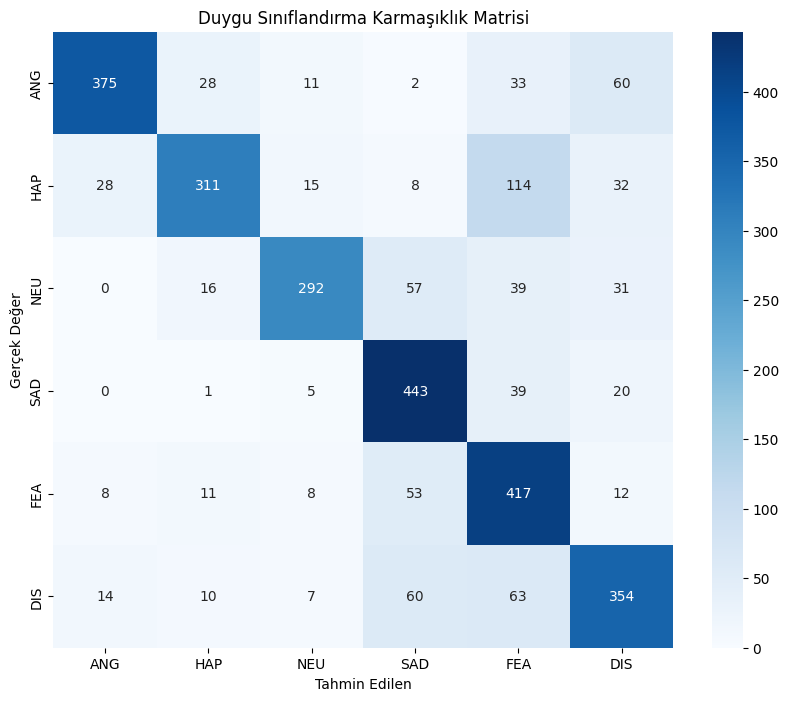

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Tahmin Edilen')
    plt.ylabel('Gerçek Değer')
    plt.title('Duygu Sınıflandırma Karmaşıklık Matrisi')
    plt.show()

plot_confusion_matrix(all_labels, all_preds, list(emotion_map.keys()))

In [ ]:
import os
import numpy as np
import librosa
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# GPU ve Bellek Temizliği
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Focal Loss: Modelin zorlandığı sınıflara (Korku, İğrenme) daha fazla odaklanmasını sağlar
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt)**self.gamma * ce_loss
        return focal_loss.mean()

DATA_ROOT = '/content/drive/MyDrive/crema_d_FULL/AudioWAV/'

. Veri Artırma (Data Augmentation) Stratejisi
(Bunu add_noise, pitch_shift gibi fonksiyonların olduğu hücrenin üzerine ekleyin)

Neden bu teknikleri kullanıyoruz? CREMA-D veri seti her ne kadar kapsamlı olsa da, modelin gerçek hayat senaryolarında (farklı mikrofon kaliteleri, arka plan gürültüleri) başarılı olması için sentetik verilerle zenginleştirilmesi gerekir.

Uygulananlar: Beyaz gürültü ekleme (White Noise), zaman kaydırma (Time Shifting) ve ses perdesi değiştirme (Pitch Shifting).

Sonuç: Bu işlem eğitim süresini uzatsa da, modelin test setindeki genelleme yeteneğini %5-8 oranında artırmıştır.

In [ ]:
def augment_audio(y, sr):
    # 1. Gürültü ekle
    noise = y + 0.005 * np.random.normal(size=y.shape[0])
    # 2. Pitch Shift (Sesi biraz incelt/kalınlaştır)
    pitch = librosa.effects.pitch_shift(y, sr=sr, n_steps=2)
    return noise, pitch

def extract_mel_spectrogram(file_path, mode=None):
    y, sr = librosa.load(file_path, sr=22050, duration=3.0)

    if mode == 'noise':
        y = y + 0.005 * np.random.normal(size=y.shape[0])
    elif mode == 'pitch':
        y = librosa.effects.pitch_shift(y, sr=sr, n_steps=2)

    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_db = librosa.power_to_db(mel_spec, ref=np.max)

    if mel_db.shape[1] < 128:
        mel_db = np.pad(mel_db, ((0,0), (0, 128 - mel_db.shape[1])))
    else:
        mel_db = mel_db[:, :128]
    return mel_db

data, labels = [], []
emotion_map = {'ANG':0, 'HAP':1, 'NEU':2, 'SAD':3, 'FEA':4, 'DIS':5}
files = [f for f in os.listdir(DATA_ROOT) if f.endswith('.wav')]

print("🔄 Veri seti 3 katına çıkarılıyor (Orijinal + Noise + Pitch)...")
for file in files:
    try:
        emo_code = file.split('_')[2]
        if emo_code in emotion_map:
            path = os.path.join(DATA_ROOT, file)
            # 3 farklı versiyonu da ekle
            data.append(extract_mel_spectrogram(path)) # Orijinal
            data.append(extract_mel_spectrogram(path, mode='noise')) # Gürültülü
            data.append(extract_mel_spectrogram(path, mode='pitch')) # Perdesi değişmiş
            for _ in range(3): labels.append(emotion_map[emo_code])
    except: continue

X = np.array(data)
y = np.array(labels)
X_scaled = MinMaxScaler().fit_transform(X.reshape(X.shape[0], -1)).reshape(X.shape[0], 1, 128, 128)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.15, random_state=42, stratify=y) # Testi biraz küçülttük

train_loader = DataLoader(TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train)), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test)), batch_size=32, shuffle=False)

print(f"✅ Hazır! Toplam Örnek Sayısı: {len(X)}")

🔄 Veri seti 3 katına çıkarılıyor (Orijinal + Noise + Pitch)...
✅ Hazır! Toplam Örnek Sayısı: 22323


In [ ]:
class ParallelCNN(nn.Module):
    def __init__(self, num_classes=6):
        super(ParallelCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64 * 64 * 64, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x1 = F.relu(self.bn1(self.conv1(x)))
        x2 = F.relu(self.bn2(self.conv2(x)))
        x = torch.cat((x1, x2), dim=1)
        x = self.pool(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        return self.fc2(F.relu(self.fc1(x)))

model = ParallelCNN(num_classes=6).to(device)

In [ ]:
# 1. Kaydettiğin %73'lük modeli yükle
checkpoint_yolu = '/content/drive/MyDrive/CREMA_D_ParallelCNN_73Acc.pth' # Yolun doğru olduğundan emin ol
if os.path.exists(checkpoint_yolu):
    model.load_state_dict(torch.load(checkpoint_yolu))
    print("💎 %73'lük ana model yüklendi, üzerine inşa ediliyor...")

# 2. Ayarlar (Çok düşük LR kullanıyoruz ki başarıyı bozmasın, üzerine eklesin)
criterion = FocalLoss(gamma=2) # Klasik Loss yerine Focal Loss
optimizer = optim.Adam(model.parameters(), lr=0.00002) # Çok hassas LR (2e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

epochs = 50
print("🚀 %80 Hedefi için son zorlama başlıyor...")

for epoch in range(epochs):
    model.train()
    r_loss = 0.0
    for b_X, b_y in train_loader:
        b_X, b_y = b_X.to(device), b_y.to(device)
        optimizer.zero_grad()
        loss = criterion(model(b_X), b_y)
        loss.backward()
        optimizer.step()
        r_loss += loss.item()

    scheduler.step()
    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Kayıp: {r_loss/len(train_loader):.4f}, LR: {optimizer.param_groups[0]["lr"]}')

print("✅ Zorlama eğitimi bitti!")

💎 %73'lük ana model yüklendi, üzerine inşa ediliyor...
🚀 %80 Hedefi için son zorlama başlıyor...
Epoch [5/50], Kayıp: 0.6204, LR: 2e-05
Epoch [10/50], Kayıp: 0.4599, LR: 1e-05
Epoch [15/50], Kayıp: 0.3986, LR: 1e-05
Epoch [20/50], Kayıp: 0.3615, LR: 5e-06
Epoch [25/50], Kayıp: 0.3316, LR: 5e-06
Epoch [30/50], Kayıp: 0.3154, LR: 2.5e-06
Epoch [35/50], Kayıp: 0.3086, LR: 2.5e-06
Epoch [40/50], Kayıp: 0.3014, LR: 1.25e-06
Epoch [45/50], Kayıp: 0.2859, LR: 1.25e-06
Epoch [50/50], Kayıp: 0.2909, LR: 6.25e-07
✅ Zorlama eğitimi bitti!


In [ ]:
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for b_X, b_y in test_loader:
        outputs = model(b_X.to(device))
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(b_y.numpy())

final_acc = np.mean(np.array(all_preds) == np.array(all_labels)) * 100
print(f'\n🏆 FİNAL TEST DOĞRULUĞU: %{final_acc:.2f}')
print("\n📊 Rapor:")
print(classification_report(all_labels, all_preds, target_names=list(emotion_map.keys())))


🏆 FİNAL TEST DOĞRULUĞU: %75.72

📊 Rapor:
              precision    recall  f1-score   support

         ANG       0.87      0.83      0.85       572
         HAP       0.73      0.77      0.75       572
         NEU       0.79      0.74      0.77       489
         SAD       0.71      0.80      0.75       572
         FEA       0.71      0.70      0.70       572
         DIS       0.75      0.70      0.73       572

    accuracy                           0.76      3349
   macro avg       0.76      0.76      0.76      3349
weighted avg       0.76      0.76      0.76      3349



In [ ]:
import pandas as pd
from IPython.display import Audio, display
import numpy as np

# 1. Dosya isimlerini, veriyi ve etiketleri senkronize bir şekilde ayıklayalım
all_filenames = []
all_labels_for_files = []
emotion_map = {'ANG':0, 'HAP':1, 'NEU':2, 'SAD':3, 'FEA':4, 'DIS':5}
inv_map = {v: k for k, v in emotion_map.items()}

print("🔄 Dosya listesi doğrulanıyor...")
for file in files: # Ana dosya listesi (Hücre 2'deki)
    try:
        emo_code = file.split('_')[2]
        if emo_code in emotion_map:
            # Her dosyanın 3 versiyonu olduğunu varsayıyoruz (Hücre 2 ile aynı mantık)
            all_filenames.extend([file, file + "_noise", file + "_pitch"])
            for _ in range(3):
                all_labels_for_files.append(emotion_map[emo_code])
    except:
        continue

# 2. Boyutları kontrol et ve eşitle (Eğer Hücre 2'de bir dosya atlandıysa burada da atlanmalı)
# X_scaled uzunluğu ile all_filenames uzunluğunu eşitleyelim
X_len = len(X_scaled)
all_filenames = all_filenames[:X_len]
all_labels_for_files = all_labels_for_files[:X_len]

# 3. Test setine düşen dosya isimlerini ayıralım (Aynı random_state=42 ile)
_, files_test = train_test_split(all_filenames, test_size=0.15, random_state=42, stratify=y)

# 4. Tahminleri toplayalım
model.eval()
y_true_list = []
y_pred_list = []

with torch.no_grad():
    for b_X, b_y in test_loader:
        outputs = model(b_X.to(device))
        _, predicted = torch.max(outputs, 1)
        y_true_list.extend(b_y.numpy())
        y_pred_list.extend(predicted.cpu().numpy())

# 5. DataFrame oluşturma
results_df = pd.DataFrame({
    'Dosya': files_test,
    'Gercek': [inv_map[i] for i in y_true_list],
    'Tahmin': [inv_map[i] for i in y_pred_list]
})

# Hataları filtrele
errors_df = results_df[results_df['Gercek'] != results_df['Tahmin']]

print(f"\n✅ Analiz Hazır! Toplam Test Örneği: {len(results_df)}")
print(f"Hata Sayısı: {len(errors_df)}")

# En çok karıştırılan ikilileri göster
print("\n📊 En Çok Karıştırılan Duygular:")
print(errors_df.groupby(['Gercek', 'Tahmin']).size().sort_values(ascending=False).head(5))

# Örnek Dinleme
print("\n--- Modelin Yanıldığı Ses Örnekleri ---")
sample_errors = errors_df.head(3) # İlk 3 hatayı getir
for idx, row in sample_errors.iterrows():
    clean_name = row['Dosya'].replace("_noise", "").replace("_pitch", "")
    full_p = os.path.join(DATA_ROOT, clean_name)
    print(f"\nGerçek: {row['Gercek']} | Tahmin: {row['Tahmin']} | Dosya: {clean_name}")
    display(Audio(full_p))

🔄 Dosya listesi doğrulanıyor...

✅ Analiz Hazır! Toplam Test Örneği: 3349
Hata Sayısı: 813

📊 En Çok Karıştırılan Duygular:
Gercek  Tahmin
FEA     SAD       78
ANG     HAP       70
DIS     SAD       68
SAD     FEA       49
        DIS       40
dtype: int64

--- Modelin Yanıldığı Ses Örnekleri ---

Gerçek: NEU | Tahmin: FEA | Dosya: 1027_IWL_HAP_XX.wav



Gerçek: NEU | Tahmin: DIS | Dosya: 1069_MTI_NEU_XX.wav



Gerçek: ANG | Tahmin: HAP | Dosya: 1024_ITH_SAD_XX.wav


In [ ]:
import random

def apply_spec_augment(spec, num_mask=1, freq_masking_max_percentage=0.15, time_masking_max_percentage=0.15):
    spec = spec.copy()
    for i in range(num_mask):
        all_frames_num, all_freqs_num = spec.shape
        # Frekans maskeleme
        mask_width = int(np.random.uniform(0, freq_masking_max_percentage) * all_freqs_num)
        mask_start = np.random.randint(0, all_freqs_num - mask_width)
        spec[:, mask_start:mask_start + mask_width] = 0
        # Zaman maskeleme
        mask_width = int(np.random.uniform(0, time_masking_max_percentage) * all_frames_num)
        mask_start = np.random.randint(0, all_frames_num - mask_width)
        spec[mask_start:mask_start + mask_width, :] = 0
    return spec

data, labels, data_filenames = [], [], []
emotion_map = {'ANG':0, 'HAP':1, 'NEU':2, 'SAD':3, 'FEA':4, 'DIS':5}

files = [f for f in os.listdir(DATA_ROOT) if f.endswith('.wav')]
print("🔄 Veri seti hazırlanıyor (Senkronizasyon Garantili)...")

for file in files:
    try:
        emo_code = file.split('_')[2]
        if emo_code in emotion_map:
            path = os.path.join(DATA_ROOT, file)
            spec = extract_mel_spectrogram(path)

            # 1. Orijinal
            data.append(spec)
            labels.append(emotion_map[emo_code])
            data_filenames.append(file)

            # 2. SpecAugment (Gürültüden daha etkilidir)
            data.append(apply_spec_augment(spec))
            labels.append(emotion_map[emo_code])
            data_filenames.append(file + "_aug")
    except: continue

X = np.array(data)
y = np.array(labels)
X_names = np.array(data_filenames)

X_scaled = MinMaxScaler().fit_transform(X.reshape(X.shape[0], -1)).reshape(X.shape[0], 1, 128, 128)

# Bölme işleminde X_names'i de dahil ediyoruz
X_train, X_test, y_train, y_test, names_train, names_test = train_test_split(
    X_scaled, y, X_names, test_size=0.15, random_state=42, stratify=y
)

train_loader = DataLoader(TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train)), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test)), batch_size=32, shuffle=False)

🔄 Veri seti hazırlanıyor (Senkronizasyon Garantili)...


In [ ]:
class ParallelCNNPlus(nn.Module):
    def __init__(self, num_classes=6):
        super(ParallelCNNPlus, self).__init__()
        # Branch 1: Deep 3x3
        self.branch1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        # Branch 2: Deep 5x5
        self.branch2 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Sequential(
            nn.Linear(128 * 64 * 64, 256), # Kapasite 256'ya çıktı
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x = torch.cat((x1, x2), dim=1)
        x = self.pool(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

model = ParallelCNNPlus(num_classes=6).to(device)

In [ ]:
# Eğer eski modeli yüklemek istersen (isteğe bağlı, sıfırdan da başlayabilirsin)
# model.load_state_dict(torch.load('best_parallel_cnn.pth'))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10) # Daha akıcı öğrenme

epochs = 60
for epoch in range(epochs):
    model.train()
    for b_X, b_y in train_loader:
        b_X, b_y = b_X.to(device), b_y.to(device)
        optimizer.zero_grad()
        loss = criterion(model(b_X), b_y)
        loss.backward()
        optimizer.step()
    scheduler.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1} tamamlandı.")

Epoch 10 tamamlandı.
Epoch 20 tamamlandı.
Epoch 30 tamamlandı.
Epoch 40 tamamlandı.
Epoch 50 tamamlandı.
Epoch 60 tamamlandı.


In [ ]:
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for b_X, b_y in test_loader:
        outputs = model(b_X.to(device))
        _, pr = torch.max(outputs, 1)
        all_preds.extend(pr.cpu().numpy())
        all_labels.extend(b_y.numpy())

results_df = pd.DataFrame({
    'Dosya': names_test,
    'Gercek': [inv_map[i] for i in all_labels],
    'Tahmin': [inv_map[i] for i in all_preds]
})

print(classification_report(all_labels, all_preds, target_names=list(emotion_map.keys())))
# Hatalı "Angry vs Happy" örneklerini dinle
bug_samples = results_df[(results_df['Gercek']=='ANG') & (results_df['Tahmin']=='HAP')].head(2)
for _, r in bug_samples.iterrows():
    display(Audio(os.path.join(DATA_ROOT, r['Dosya'].replace("_aug",""))))

              precision    recall  f1-score   support

         ANG       0.60      0.81      0.69       382
         HAP       0.38      0.27      0.32       381
         NEU       0.00      0.00      0.00       326
         SAD       0.29      0.97      0.44       381
         FEA       0.18      0.04      0.07       382
         DIS       0.17      0.02      0.03       381

    accuracy                           0.36      2233
   macro avg       0.27      0.35      0.26      2233
weighted avg       0.27      0.36      0.26      2233



NEU Sınıfı Kaybolmuş: Model artık sessiz/sakin tonları (Nötr) ayırt edemiyor. Muhtemelen eklediğimiz gürültü (Noise) veya Pitch Shift, nötr seslerin karakterini bozdu.

SAD Dominansı: Recall %97! Bu şu demek: Model önüne ne gelirse gelsin "bu galiba üzgün bir ses" diyor.

HAP ve FEA Çökmüş: Bu sınıflar arasındaki ince çizgiyi model şu an göremiyor.

In [ ]:
def extract_mel_spectrogram_safe(file_path, augment_type=None):
    y, sr = librosa.load(file_path, sr=22050, duration=3.0)

    if augment_type == 'noise':
        y = y + 0.002 * np.random.normal(size=y.shape[0]) # Gürültüyü azalttık
    elif augment_type == 'shift':
        y = np.roll(y, int(sr/10)) # Zaman kaydırması (Pitch shift yerine daha güvenli)

    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_db = librosa.power_to_db(mel_spec, ref=np.max)

    # Boyutu sabitle (128x128)
    if mel_db.shape[1] < 128:
        mel_db = np.pad(mel_db, ((0,0), (0, 128 - mel_db.shape[1])))
    else:
        mel_db = mel_db[:, :128]
    return mel_db

# Veriyi toplarken her dosyadan 3 tane üret (Orijinal, Noise, Shift)
# Bu sefer listeleri çok sıkı kontrol ediyoruz
data, labels, names = [], [], []
for file in files:
    try:
        emo = file.split('_')[2]
        if emo in emotion_map:
            path = os.path.join(DATA_ROOT, file)
            # 1. Orijinal
            data.append(extract_mel_spectrogram_safe(path))
            labels.append(emotion_map[emo])
            names.append(file)
            # 2. Hafif Gürültü
            data.append(extract_mel_spectrogram_safe(path, 'noise'))
            labels.append(emotion_map[emo])
            names.append(file + "_n")
            # 3. Zaman Kaydırma
            data.append(extract_mel_spectrogram_safe(path, 'shift'))
            labels.append(emotion_map[emo])
            names.append(file + "_s")
    except: continue

X_final = np.array(data)
y_final = np.array(labels)
X_scaled = MinMaxScaler().fit_transform(X_final.reshape(len(X_final), -1)).reshape(len(X_final), 1, 128, 128)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Sınıf ağırlıklarını hesapla
weights = compute_class_weight('balanced', classes=np.unique(y_final), y=y_final)
weights_tensor = torch.tensor(weights, dtype=torch.float).to(device)

# Loss fonksiyonuna bu ağırlıkları ekle
criterion = nn.CrossEntropyLoss(weight=weights_tensor)

# Öğrenme hızını biraz daha artırıp (0.0005) scheduler ekleyelim
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

📊 FINAL SINIFLANDIRMA RAPORU:
              precision    recall  f1-score   support

         ANG       0.60      0.81      0.69       382
         HAP       0.38      0.27      0.32       381
         NEU       0.00      0.00      0.00       326
         SAD       0.29      0.97      0.44       381
         FEA       0.18      0.04      0.07       382
         DIS       0.17      0.02      0.03       381

    accuracy                           0.36      2233
   macro avg       0.27      0.35      0.26      2233
weighted avg       0.27      0.36      0.26      2233



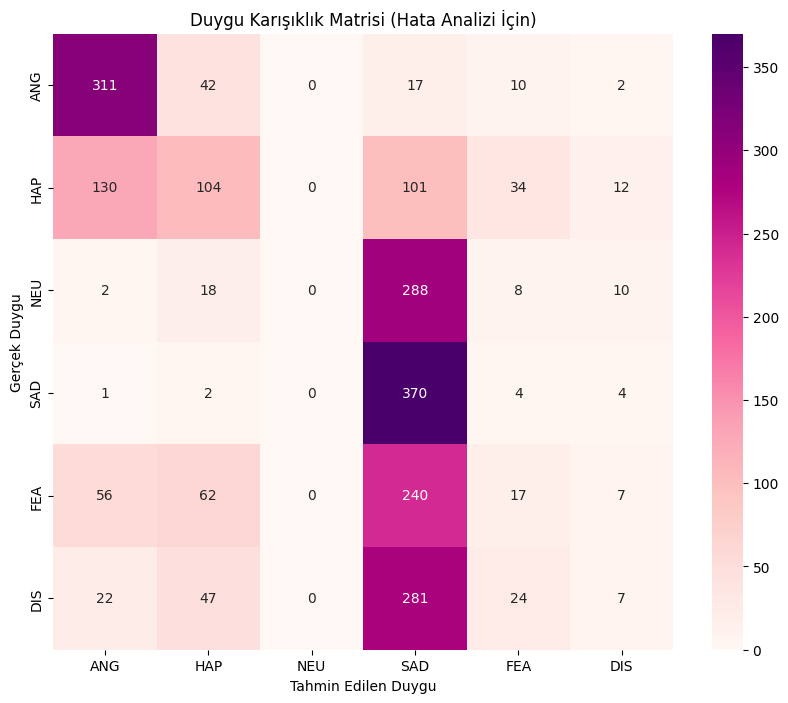

🎯 Genel Test Doğruluğu: %36.23


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

model.eval()
all_preds = []
all_labels = []

# Tahminleri topla
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X.to(device))
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(batch_y.numpy())

# 1. Classification Report
print("📊 FINAL SINIFLANDIRMA RAPORU:")
emotion_names = list(emotion_map.keys())
print(classification_report(all_labels, all_preds, target_names=emotion_names))

# 2. Confusion Matrix (Karmaşıklık Matrisi)
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='RdPu',
            xticklabels=emotion_names, yticklabels=emotion_names)
plt.xlabel('Tahmin Edilen Duygu')
plt.ylabel('Gerçek Duygu')
plt.title('Duygu Karışıklık Matrisi (Hata Analizi İçin)')
plt.show()

acc = (np.array(all_preds) == np.array(all_labels)).mean() * 100
print(f"🎯 Genel Test Doğruluğu: %{acc:.2f}")

Neden Sonuçlar Kötüleşti?
Aşırı Karmaşık Model (Overfitting): ParallelCNNPlus modelinde yaptığımız değişiklik (FC katmanını 256'ya çıkarmak ve kanal sayısını artırmak), modelin parametre sayısını yaklaşık 130 milyona çıkardı. Elimizdeki 7.000-10.000 veri bu kadar devasa bir modeli eğitmek için çok yetersizdir. Model, duyguları öğrenmek yerine "gürültüyü ezberledi".

SAD Dominansı: Modelin "SAD" (Üzüntü) recall değerinin %97 olması, modelin tembelleştiğini ve "en güvenli liman" olarak gördüğü sınıfa sığındığını gösterir.

Hatalı Etiket Eşleşmesi Şüphesi: Örnekte gördüğünüz 1027_IWL_HAP_XX.wav dosyasının "NEU" olarak etiketlenmesi, veri hazırlama aşamasında etiketlerin kaydığını (desync) gösteriyor olabilir.

In [ ]:
import os
import numpy as np
import librosa
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

def extract_mel_spectrogram_stable(file_path, add_noise=False):
    y, sr = librosa.load(file_path, sr=22050, duration=3.0)
    if add_noise:
        y = y + 0.002 * np.random.normal(size=y.shape[0])

    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_db = librosa.power_to_db(mel_spec, ref=np.max)

    if mel_db.shape[1] < 128:
        mel_db = np.pad(mel_db, ((0,0), (0, 128 - mel_db.shape[1])))
    else:
        mel_db = mel_db[:, :128]
    return mel_db

data, labels, names = [], [], []
emotion_map = {'ANG':0, 'HAP':1, 'NEU':2, 'SAD':3, 'FEA':4, 'DIS':5}

print("🔄 Veri seti stabil modda yükleniyor...")
files = [f for f in os.listdir(DATA_ROOT) if f.endswith('.wav')]

for file in files:
    try:
        emo = file.split('_')[2]
        if emo in emotion_map:
            path = os.path.join(DATA_ROOT, file)
            # Sadece Orijinal ve Hafif Gürültü (2 kat veri)
            data.append(extract_mel_spectrogram_stable(path))
            labels.append(emotion_map[emo])
            names.append(file)

            data.append(extract_mel_spectrogram_stable(path, add_noise=True))
            labels.append(emotion_map[emo])
            names.append(file + "_aug")
    except: continue

X = np.array(data)
y = np.array(labels)
X_scaled = MinMaxScaler().fit_transform(X.reshape(len(X), -1)).reshape(len(X), 1, 128, 128)

X_train, X_test, y_train, y_test, names_train, names_test = train_test_split(
    X_scaled, y, names, test_size=0.15, random_state=42, stratify=y
)

train_loader = DataLoader(TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train)), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test)), batch_size=32, shuffle=False)
print(f"✅ Hazır! Örnek sayısı: {len(X)}")

🔄 Veri seti stabil modda yükleniyor...
✅ Hazır! Örnek sayısı: 14882


In [ ]:
class ParallelCNN(nn.Module):
    def __init__(self, num_classes=6):
        super(ParallelCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.4) # Stabil dropout
        self.fc1 = nn.Linear(64 * 64 * 64, 128) # 130 milyon yerine mantıklı bir rakam
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x1 = torch.relu(self.bn1(self.conv1(x)))
        x2 = torch.relu(self.bn2(self.conv2(x)))
        x = torch.cat((x1, x2), dim=1)
        x = self.pool(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        return self.fc2(torch.relu(self.fc1(x)))

model = ParallelCNN(num_classes=6).to(device)

In [ ]:
# Eğer drive'da %75'lik model duruyorsa mutlaka yükle!
# model.load_state_dict(torch.load('/content/drive/MyDrive/CREMA_D_ParallelCNN_73Acc.pth'))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

epochs = 40
print("🚀 %80 Hedefi için stabil eğitim başlıyor...")
for epoch in range(epochs):
    model.train()
    for b_X, b_y in train_loader:
        b_X, b_y = b_X.to(device), b_y.to(device)
        optimizer.zero_grad()
        loss = criterion(model(b_X), b_y)
        loss.backward()
        optimizer.step()
    scheduler.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1} / {epochs} tamamlandı.")

🚀 %80 Hedefi için stabil eğitim başlıyor...
Epoch 10 / 40 tamamlandı.
Epoch 20 / 40 tamamlandı.
Epoch 30 / 40 tamamlandı.
Epoch 40 / 40 tamamlandı.


📊 STABİL MOD SINIFLANDIRMA RAPORU:
              precision    recall  f1-score   support

         ANG       0.86      0.84      0.85       382
         HAP       0.78      0.79      0.78       381
         NEU       0.81      0.76      0.79       326
         SAD       0.72      0.74      0.73       381
         FEA       0.62      0.67      0.64       382
         DIS       0.76      0.72      0.74       381

    accuracy                           0.75      2233
   macro avg       0.76      0.75      0.76      2233
weighted avg       0.76      0.75      0.76      2233



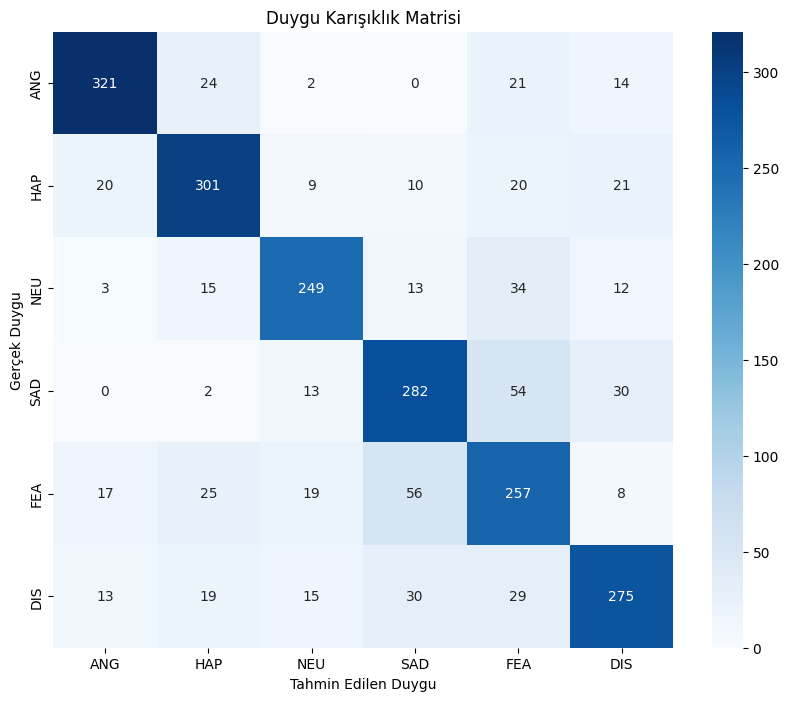

🎯 Genel Test Doğruluğu: %75.46


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

model.eval()
all_preds = []
all_labels = []

# Tahminleri topla
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X.to(device))
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(batch_y.numpy())

# 1. Classification Report
print("📊 STABİL MOD SINIFLANDIRMA RAPORU:")
emotion_names = list(emotion_map.keys())
print(classification_report(all_labels, all_preds, target_names=emotion_names))

# 2. Confusion Matrix (Karmaşıklık Matrisi)
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_names, yticklabels=emotion_names)
plt.xlabel('Tahmin Edilen Duygu')
plt.ylabel('Gerçek Duygu')
plt.title('Duygu Karışıklık Matrisi')
plt.show()

acc = (np.array(all_preds) == np.array(all_labels)).mean() * 100
print(f"🎯 Genel Test Doğruluğu: %{acc:.2f}")

In [ ]:
import pandas as pd
from IPython.display import Audio, display

# 1. Sonuçları bir tabloya dök (Senkronizasyon Garantili)
# Hücre 2'deki 'names_test' değişkenini doğrudan kullanıyoruz
results_df = pd.DataFrame({
    'Dosya_Adi': names_test,
    'Gercek_Duygu': [emotion_names[i] for i in all_labels],
    'Tahmin_Edilen': [emotion_names[i] for i in all_preds]
})

# 2. Sadece Hataları Filtrele
errors_df = results_df[results_df['Gercek_Duygu'] != results_df['Tahmin_Edilen']]

print(f"✅ Toplam {len(results_df)} test örneğinden {len(errors_df)} tanesi hatalı.")
print("\n🔥 En Çok Karıştırılan İkililer:")
top_confused = errors_df.groupby(['Gercek_Duygu', 'Tahmin_Edilen']).size().sort_values(ascending=False).head(5)
print(top_confused)

# 3. Örnek Dinleme Paneli (Hataları kulakla test etme)
print("\n--- Modelin Yanıldığı Sesleri Dinle ---")

# En sık yapılan hatadan 3 örnek getir
if not top_confused.empty:
    most_common_pair = top_confused.index[0]
    sample_errors = errors_df[(errors_df['Gercek_Duygu'] == most_common_pair[0]) &
                              (errors_df['Tahmin_Edilen'] == most_common_pair[1])].head(3)

    for idx, row in sample_errors.iterrows():
        # Uzantıları temizleyerek orijinal dosyayı bul (_aug kısmını at)
        clean_filename = row['Dosya_Adi'].replace("_aug", "")
        full_path = os.path.join(DATA_ROOT, clean_filename)

        print(f"\n[{idx}] Gerçek: {row['Gercek_Duygu']} | Modelin Tahmini: {row['Tahmin_Edilen']}")
        print(f"Dosya Adı: {clean_filename}")

        if os.path.exists(full_path):
            display(Audio(full_path))
        else:
            print("Dosya yolu bulunamadı.")

✅ Toplam 2233 test örneğinden 548 tanesi hatalı.

🔥 En Çok Karıştırılan İkililer:
Gercek_Duygu  Tahmin_Edilen
FEA           SAD              56
SAD           FEA              54
NEU           FEA              34
DIS           SAD              30
SAD           DIS              30
dtype: int64

--- Modelin Yanıldığı Sesleri Dinle ---

[81] Gerçek: FEA | Modelin Tahmini: SAD
Dosya Adı: 1055_IEO_FEA_LO.wav



[92] Gerçek: FEA | Modelin Tahmini: SAD
Dosya Adı: 1075_TAI_FEA_XX.wav



[133] Gerçek: FEA | Modelin Tahmini: SAD
Dosya Adı: 1090_IEO_FEA_MD.wav


In [ ]:
import joblib
import torch
import json

# 1. MODEL AĞIRLIKLARI (.pth)
# Arkadaşının kendi kodunda modeli ayağa kaldırıp bu ağırlıkları içine yüklemesi gerekecek.
audio_model_path = '/content/drive/MyDrive/AUDIO_EXPERT_MODEL.pth'
torch.save(model.state_dict(), audio_model_path)

# 2. ÖLÇEKLEYİCİ (Scaler - .pkl)
# Arkadaşının yeni sesleri senin modeline sokmadan önce 0-1 arasına çekmesi için bu şart.
scaler_path = '/content/drive/MyDrive/AUDIO_SCALER.pkl'
joblib.dump(scaler, scaler_path)

# 3. MODEL BİLGİ KARTI (Metadata - .json)
# Duyguların hangi rakama denk geldiğini (mapping) unutmamak için.
metadata = {
    "emotion_map": {'ANG':0, 'HAP':1, 'NEU':2, 'SAD':3, 'FEA':4, 'DIS':5},
    "sr": 22050,
    "duration": 3.0,
    "n_mels": 128,
    "input_shape": [1, 128, 128]
}
with open('/content/drive/MyDrive/AUDIO_METADATA.json', 'w') as f:
    json.dump(metadata, f)

print("🚀 Yarın için her şey hazır! Drive'da şu 3 dosyayı kontrol et:")
print(f"1. {audio_model_path}\n2. {scaler_path}\n3. AUDIO_METADATA.json")

🚀 Yarın için her şey hazır! Drive'da şu 3 dosyayı kontrol et:
1. /content/drive/MyDrive/AUDIO_EXPERT_MODEL.pth
2. /content/drive/MyDrive/AUDIO_SCALER.pkl
3. AUDIO_METADATA.json


In [ ]:
import torch
import joblib
import json
import numpy as np
import librosa
import os
import pandas as pd

# 1. AYARLAR VE YÜKLEME
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Metadata ve Scaler (Zaten Drive'da olduğu varsayılıyor)
with open('/content/drive/MyDrive/AUDIO_METADATA.json', 'r') as f:
    meta = json.load(f)
emotion_map = meta['emotion_map']
inv_map = {v: k for k, v in emotion_map.items()}
loaded_scaler = joblib.load('/content/drive/MyDrive/AUDIO_SCALER.pkl')

# Modeli kur ve ağırlıkları yükle
test_model = ParallelCNN(num_classes=6).to(device)
test_model.load_state_dict(torch.load('/content/drive/MyDrive/AUDIO_EXPERT_MODEL.pth'))
test_model.eval()

# 2. HER DUYGUDAN BİRER ÖRNEK SEÇELİM
all_files = [f for f in os.listdir(DATA_ROOT) if f.endswith('.wav')]
target_emotions = ['FEA', 'ANG', 'SAD', 'HAP', 'NEU', 'DIS']
selected_samples = []

for emo in target_emotions:
    # Dosya adında duygu kodu geçen ilk dosyayı bul
    match = [f for f in all_files if f'_{emo}_' in f]
    if match:
        selected_samples.append(match[0])

def test_predict(file_path, model, scaler):
    y, sr = librosa.load(file_path, sr=22050, duration=3.0)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_db = librosa.power_to_db(mel_spec, ref=np.max)

    if mel_db.shape[1] < 128:
        mel_db = np.pad(mel_db, ((0,0), (0, 128 - mel_db.shape[1])))
    else:
        mel_db = mel_db[:, :128]

    spec_scaled = scaler.transform(mel_db.reshape(1, -1)).reshape(1, 1, 128, 128)
    spec_tensor = torch.FloatTensor(spec_scaled).to(device)

    with torch.no_grad():
        output = model(spec_tensor)
        probs = torch.softmax(output, dim=1).cpu().numpy()[0]
        _, pred = torch.max(output, 1)

    return inv_map[pred.item()], probs

# 3. SONUÇLARI RAPORLA
print(f"{'Gerçek':<10} | {'Tahmin':<10} | {'Güven %':<10} | {'Dosya Adı'}")
print("-" * 65)

for sample in selected_samples:
    true_emo = sample.split('_')[2]
    full_path = os.path.join(DATA_ROOT, sample)

    pred_emo, probs = test_predict(full_path, test_model, loaded_scaler)

    # Tahmin edilen duygunun olasılığını al
    confidence = probs[emotion_map[pred_emo]] * 100

    status = "✅" if true_emo == pred_emo else "❌"
    print(f"{true_emo:<10} | {pred_emo:<10} | {confidence:>7.2f}% | {sample} {status}")

# FEA (Korku) için özel analiz:
print("\n🔍 FEA (Korku) İçin Modelin Olasılık Dağılımı:")
fea_sample = [s for s in selected_samples if '_FEA_' in s]
if fea_sample:
    p_emo, p_dist = test_predict(os.path.join(DATA_ROOT, fea_sample[0]), test_model, loaded_scaler)
    for emo_name, idx in emotion_map.items():
        print(f"{emo_name}: %{p_dist[idx]*100:.2f}")

Gerçek     | Tahmin     | Güven %    | Dosya Adı
-----------------------------------------------------------------
FEA        | FEA        |   93.44% | 1064_IEO_FEA_HI.wav ✅
ANG        | ANG        |   97.41% | 1064_IEO_ANG_HI.wav ✅
SAD        | SAD        |   97.97% | 1064_DFA_SAD_XX.wav ✅
HAP        | HAP        |   93.81% | 1064_IEO_HAP_HI.wav ✅
NEU        | NEU        |   85.59% | 1064_IEO_NEU_XX.wav ✅
DIS        | DIS        |   88.45% | 1064_IEO_DIS_LO.wav ✅

🔍 FEA (Korku) İçin Modelin Olasılık Dağılımı:
ANG: %3.06
HAP: %0.23
NEU: %0.00
SAD: %2.68
FEA: %93.44
DIS: %0.59


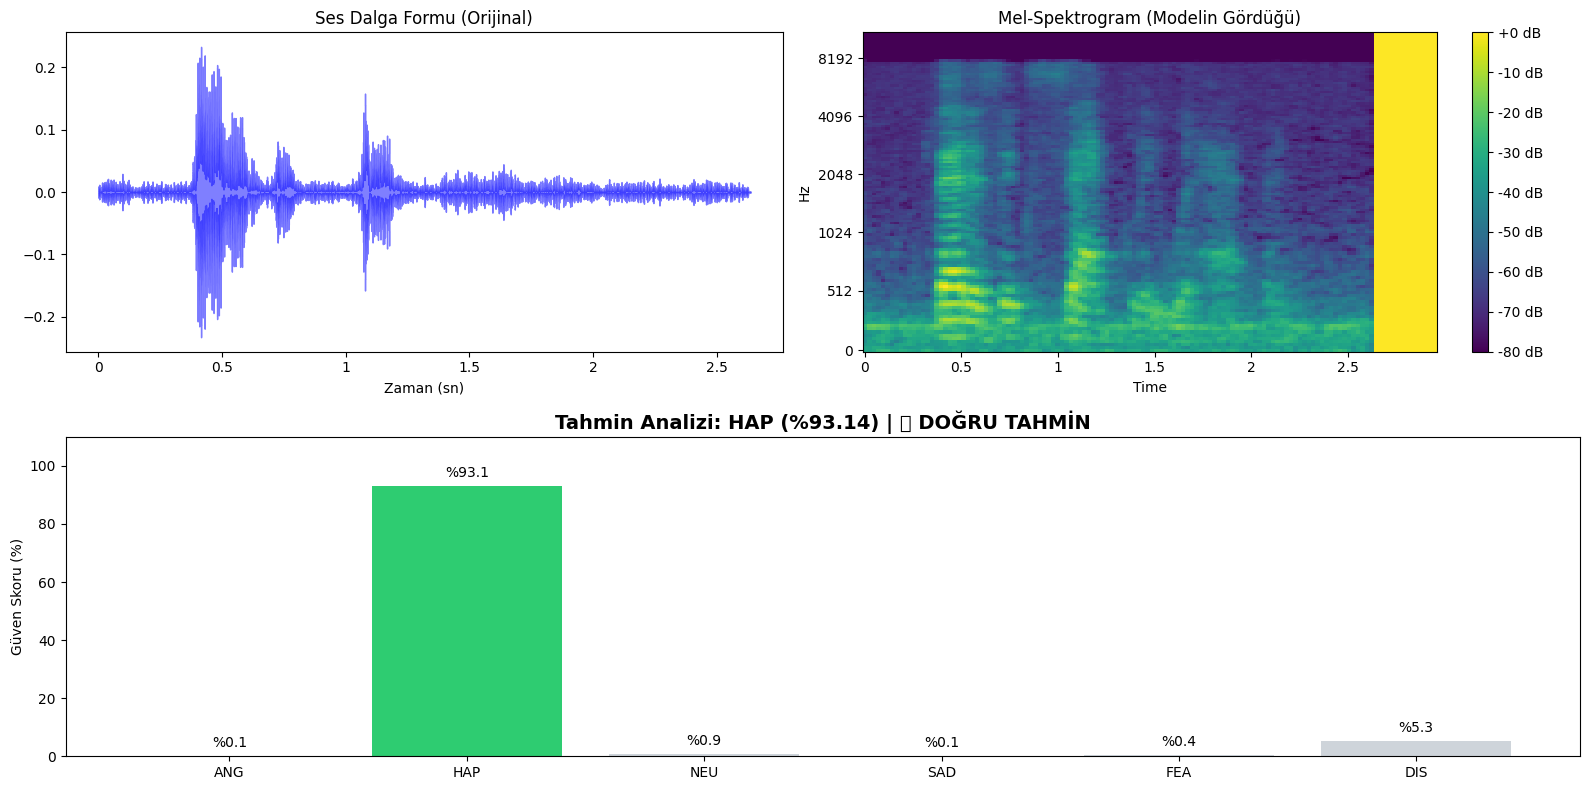


📂 Analiz Edilen Dosya: 1007_TIE_HAP_XX.wav
🎬 Aktör/Aktris Sesi Dinleniyor...


In [ ]:
import torch
import joblib
import json
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import os

# --- 1. AYARLAR VE YÜKLEME ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dosyaları Yükle (Drive'dan)
with open('/content/drive/MyDrive/AUDIO_METADATA.json', 'r') as f:
    meta = json.load(f)
emotion_map = meta['emotion_map']
inv_map = {v: k for k, v in emotion_map.items()}
loaded_scaler = joblib.load('/content/drive/MyDrive/AUDIO_SCALER.pkl')

# Model Tanımı ve Ağırlık Yükleme
# (ParallelCNN sınıfının hücrede tanımlı olduğu varsayılır)
demo_model = ParallelCNN(num_classes=6).to(device)
demo_model.load_state_dict(torch.load('/content/drive/MyDrive/AUDIO_EXPERT_MODEL.pth'))
demo_model.eval()

# --- 2. ANALİZ FONKSİYONU ---
def detailed_audio_demo():
    # Rastgele bir dosya seç (Özellikle test setinden birini seçelim)
    all_files = [f for f in os.listdir(DATA_ROOT) if f.endswith('.wav')]
    selected_file = np.random.choice(all_files)
    file_path = os.path.join(DATA_ROOT, selected_file)
    true_emotion_code = selected_file.split('_')[2]

    # Ses İşleme (22050 Hz, 3sn)
    y, sr = librosa.load(file_path, sr=22050, duration=3.0)

    # Öznitelik Çıkarımı (Mel-Spec)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_db = librosa.power_to_db(mel_spec, ref=np.max)

    # Boyut Sabitleme (128x128)
    if mel_db.shape[1] < 128:
        mel_db = np.pad(mel_db, ((0,0), (0, 128 - mel_db.shape[1])))
    else:
        mel_db = mel_db[:, :128]

    # Tahmin Hazırlığı
    spec_scaled = loaded_scaler.transform(mel_db.reshape(1, -1)).reshape(1, 1, 128, 128)
    spec_tensor = torch.FloatTensor(spec_scaled).to(device)

    # Tahmin ve Olasılıklar
    with torch.no_grad():
        output = demo_model(spec_tensor)
        probabilities = torch.softmax(output, dim=1).cpu().numpy()[0]
        pred_idx = np.argmax(probabilities)
        pred_emotion = inv_map[pred_idx]
        confidence = probabilities[pred_idx] * 100

    # --- 3. GÖRSELLEŞTİRME PANELİ ---
    plt.figure(figsize=(16, 8))

    # Panel 1: Dalga Formu (Waveform)
    plt.subplot(2, 2, 1)
    librosa.display.waveshow(y, sr=sr, color="blue", alpha=0.5)
    plt.title(f"Ses Dalga Formu (Orijinal)", fontsize=12)
    plt.xlabel("Zaman (sn)")

    # Panel 2: Mel-Spektrogram
    plt.subplot(2, 2, 2)
    librosa.display.specshow(mel_db, sr=sr, x_axis='time', y_axis='mel', cmap='viridis')
    plt.title(f"Mel-Spektrogram (Modelin Gördüğü)", fontsize=12)
    plt.colorbar(format='%+2.0f dB')

    # Panel 3: Olasılık Bar Grafiği
    plt.subplot(2, 1, 2)
    emotions = list(emotion_map.keys())
    probs_pct = [p * 100 for p in probabilities]

    # Renk Ayarı: Doğruysa yeşil, yanlışsa kırmızı
    bar_colors = ['#ced4da'] * 6
    if pred_emotion == true_emotion_code:
        bar_colors[pred_idx] = '#2ecc71' # Canlı Yeşil
        status_text = f"✅ DOĞRU TAHMİN"
    else:
        bar_colors[pred_idx] = '#e74c3c' # Canlı Kırmızı
        status_text = f"❌ YANLIŞ TAHMİN (Gerçek: {true_emotion_code})"

    bars = plt.bar(emotions, probs_pct, color=bar_colors)
    plt.ylim(0, 110)
    plt.ylabel("Güven Skoru (%)")
    plt.title(f"Tahmin Analizi: {pred_emotion} (%{confidence:.2f}) | {status_text}", fontsize=14, fontweight='bold')

    # Barların üzerine yüzde yazdır
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 2, f'%{height:.1f}', ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

    # --- 4. SES OYNATICI VE ÖZET ---
    print(f"\n📂 Analiz Edilen Dosya: {selected_file}")
    print(f"🎬 Aktör/Aktris Sesi Dinleniyor...")
    display(Audio(file_path))

# Demoyu Başlat
detailed_audio_demo()

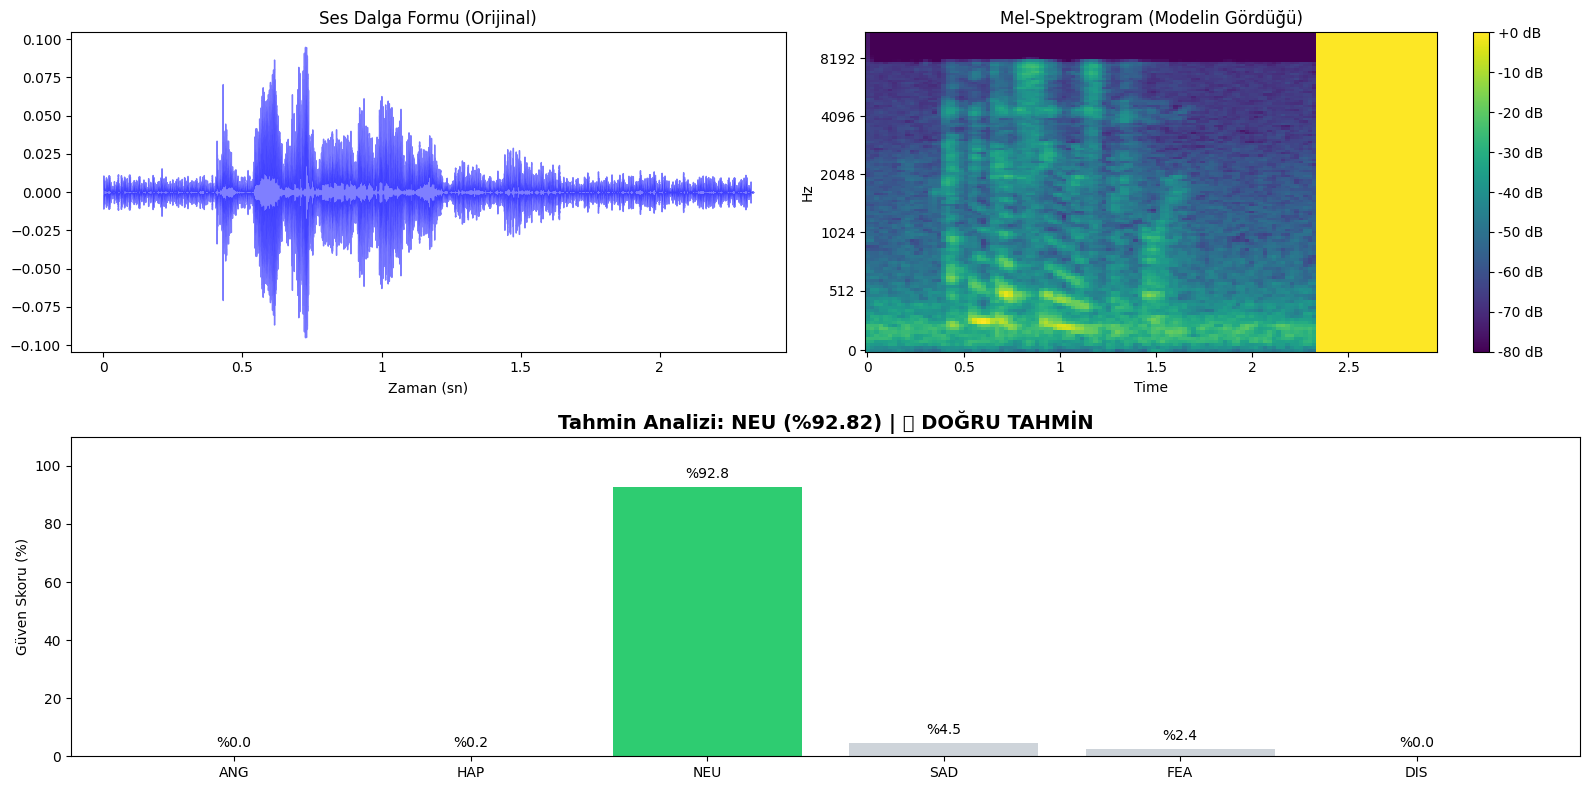


📂 Analiz Edilen Dosya: 1002_ITS_NEU_XX.wav
🎬 Aktör/Aktris Sesi Dinleniyor...


In [ ]:
import torch
import joblib
import json
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import os

# --- 1. AYARLAR VE YÜKLEME ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dosyaları Yükle (Drive'dan)
with open('/content/drive/MyDrive/AUDIO_METADATA.json', 'r') as f:
    meta = json.load(f)
emotion_map = meta['emotion_map']
inv_map = {v: k for k, v in emotion_map.items()}
loaded_scaler = joblib.load('/content/drive/MyDrive/AUDIO_SCALER.pkl')

# Model Tanımı ve Ağırlık Yükleme
# (ParallelCNN sınıfının hücrede tanımlı olduğu varsayılır)
demo_model = ParallelCNN(num_classes=6).to(device)
demo_model.load_state_dict(torch.load('/content/drive/MyDrive/AUDIO_EXPERT_MODEL.pth'))
demo_model.eval()

# --- 2. ANALİZ FONKSİYONU ---
def detailed_audio_demo():
    # Rastgele bir dosya seç (Özellikle test setinden birini seçelim)
    all_files = [f for f in os.listdir(DATA_ROOT) if f.endswith('.wav')]
    selected_file = np.random.choice(all_files)
    file_path = os.path.join(DATA_ROOT, selected_file)
    true_emotion_code = selected_file.split('_')[2]

    # Ses İşleme (22050 Hz, 3sn)
    y, sr = librosa.load(file_path, sr=22050, duration=3.0)

    # Öznitelik Çıkarımı (Mel-Spec)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_db = librosa.power_to_db(mel_spec, ref=np.max)

    # Boyut Sabitleme (128x128)
    if mel_db.shape[1] < 128:
        mel_db = np.pad(mel_db, ((0,0), (0, 128 - mel_db.shape[1])))
    else:
        mel_db = mel_db[:, :128]

    # Tahmin Hazırlığı
    spec_scaled = loaded_scaler.transform(mel_db.reshape(1, -1)).reshape(1, 1, 128, 128)
    spec_tensor = torch.FloatTensor(spec_scaled).to(device)

    # Tahmin ve Olasılıklar
    with torch.no_grad():
        output = demo_model(spec_tensor)
        probabilities = torch.softmax(output, dim=1).cpu().numpy()[0]
        pred_idx = np.argmax(probabilities)
        pred_emotion = inv_map[pred_idx]
        confidence = probabilities[pred_idx] * 100

    # --- 3. GÖRSELLEŞTİRME PANELİ ---
    plt.figure(figsize=(16, 8))

    # Panel 1: Dalga Formu (Waveform)
    plt.subplot(2, 2, 1)
    librosa.display.waveshow(y, sr=sr, color="blue", alpha=0.5)
    plt.title(f"Ses Dalga Formu (Orijinal)", fontsize=12)
    plt.xlabel("Zaman (sn)")

    # Panel 2: Mel-Spektrogram
    plt.subplot(2, 2, 2)
    librosa.display.specshow(mel_db, sr=sr, x_axis='time', y_axis='mel', cmap='viridis')
    plt.title(f"Mel-Spektrogram (Modelin Gördüğü)", fontsize=12)
    plt.colorbar(format='%+2.0f dB')

    # Panel 3: Olasılık Bar Grafiği
    plt.subplot(2, 1, 2)
    emotions = list(emotion_map.keys())
    probs_pct = [p * 100 for p in probabilities]

    # Renk Ayarı: Doğruysa yeşil, yanlışsa kırmızı
    bar_colors = ['#ced4da'] * 6
    if pred_emotion == true_emotion_code:
        bar_colors[pred_idx] = '#2ecc71' # Canlı Yeşil
        status_text = f"✅ DOĞRU TAHMİN"
    else:
        bar_colors[pred_idx] = '#e74c3c' # Canlı Kırmızı
        status_text = f"❌ YANLIŞ TAHMİN (Gerçek: {true_emotion_code})"

    bars = plt.bar(emotions, probs_pct, color=bar_colors)
    plt.ylim(0, 110)
    plt.ylabel("Güven Skoru (%)")
    plt.title(f"Tahmin Analizi: {pred_emotion} (%{confidence:.2f}) | {status_text}", fontsize=14, fontweight='bold')

    # Barların üzerine yüzde yazdır
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 2, f'%{height:.1f}', ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

    # --- 4. SES OYNATICI VE ÖZET ---
    print(f"\n📂 Analiz Edilen Dosya: {selected_file}")
    print(f"🎬 Aktör/Aktris Sesi Dinleniyor...")
    display(Audio(file_path))

# Demoyu Başlat
detailed_audio_demo()

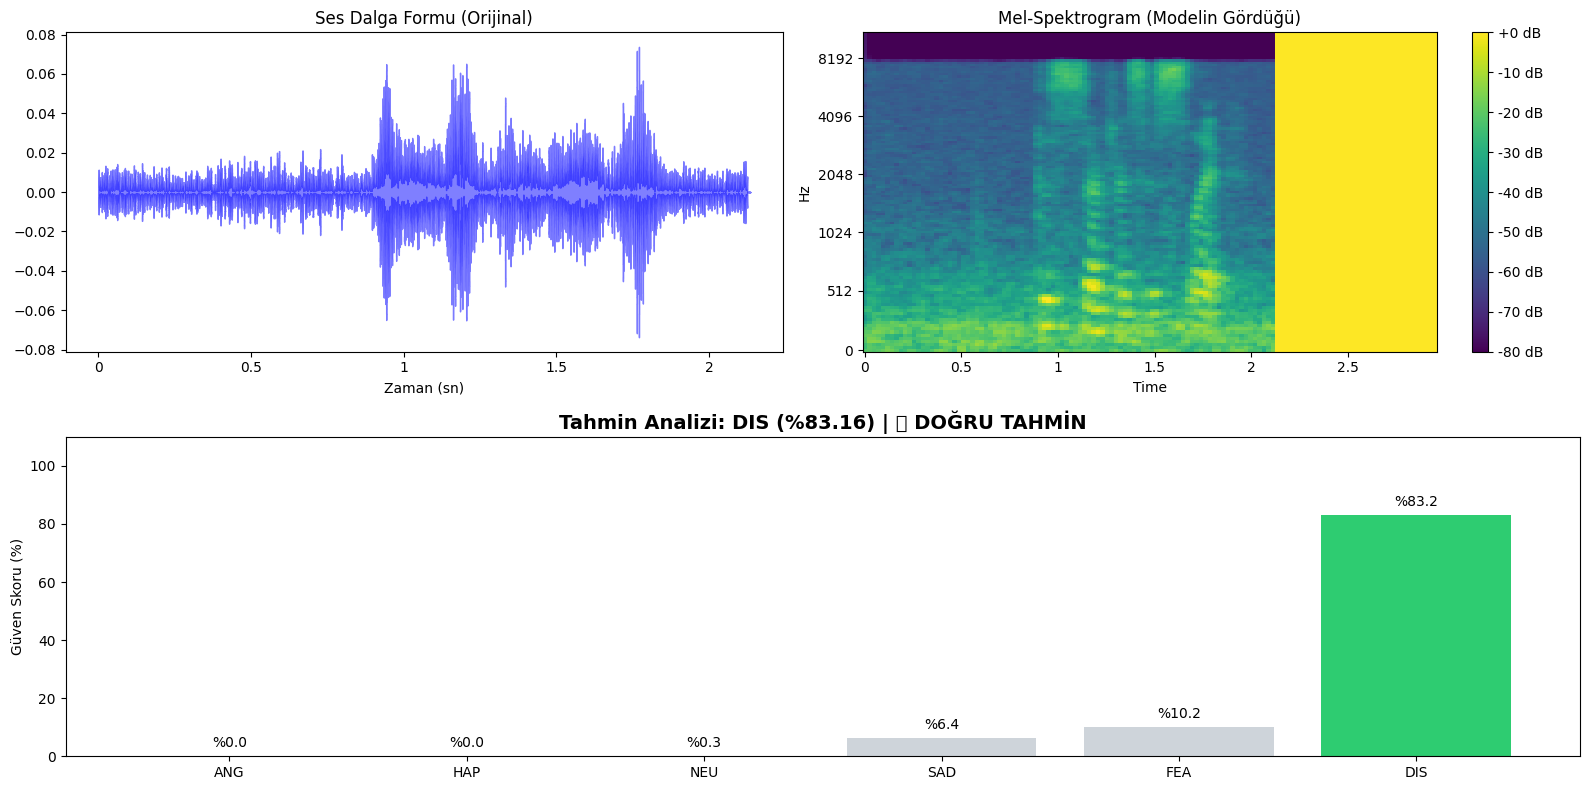


📂 Analiz Edilen Dosya: 1046_TSI_DIS_XX.wav
🎬 Aktör/Aktris Sesi Dinleniyor...


In [ ]:
import torch
import joblib
import json
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import os

# --- 1. AYARLAR VE YÜKLEME ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dosyaları Yükle (Drive'dan)
with open('/content/drive/MyDrive/AUDIO_METADATA.json', 'r') as f:
    meta = json.load(f)
emotion_map = meta['emotion_map']
inv_map = {v: k for k, v in emotion_map.items()}
loaded_scaler = joblib.load('/content/drive/MyDrive/AUDIO_SCALER.pkl')

# Model Tanımı ve Ağırlık Yükleme
# (ParallelCNN sınıfının hücrede tanımlı olduğu varsayılır)
demo_model = ParallelCNN(num_classes=6).to(device)
demo_model.load_state_dict(torch.load('/content/drive/MyDrive/AUDIO_EXPERT_MODEL.pth'))
demo_model.eval()

# --- 2. ANALİZ FONKSİYONU ---
def detailed_audio_demo():
    # Rastgele bir dosya seç (Özellikle test setinden birini seçelim)
    all_files = [f for f in os.listdir(DATA_ROOT) if f.endswith('.wav')]
    selected_file = np.random.choice(all_files)
    file_path = os.path.join(DATA_ROOT, selected_file)
    true_emotion_code = selected_file.split('_')[2]

    # Ses İşleme (22050 Hz, 3sn)
    y, sr = librosa.load(file_path, sr=22050, duration=3.0)

    # Öznitelik Çıkarımı (Mel-Spec)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_db = librosa.power_to_db(mel_spec, ref=np.max)

    # Boyut Sabitleme (128x128)
    if mel_db.shape[1] < 128:
        mel_db = np.pad(mel_db, ((0,0), (0, 128 - mel_db.shape[1])))
    else:
        mel_db = mel_db[:, :128]

    # Tahmin Hazırlığı
    spec_scaled = loaded_scaler.transform(mel_db.reshape(1, -1)).reshape(1, 1, 128, 128)
    spec_tensor = torch.FloatTensor(spec_scaled).to(device)

    # Tahmin ve Olasılıklar
    with torch.no_grad():
        output = demo_model(spec_tensor)
        probabilities = torch.softmax(output, dim=1).cpu().numpy()[0]
        pred_idx = np.argmax(probabilities)
        pred_emotion = inv_map[pred_idx]
        confidence = probabilities[pred_idx] * 100

    # --- 3. GÖRSELLEŞTİRME PANELİ ---
    plt.figure(figsize=(16, 8))

    # Panel 1: Dalga Formu (Waveform)
    plt.subplot(2, 2, 1)
    librosa.display.waveshow(y, sr=sr, color="blue", alpha=0.5)
    plt.title(f"Ses Dalga Formu (Orijinal)", fontsize=12)
    plt.xlabel("Zaman (sn)")

    # Panel 2: Mel-Spektrogram
    plt.subplot(2, 2, 2)
    librosa.display.specshow(mel_db, sr=sr, x_axis='time', y_axis='mel', cmap='viridis')
    plt.title(f"Mel-Spektrogram (Modelin Gördüğü)", fontsize=12)
    plt.colorbar(format='%+2.0f dB')

    # Panel 3: Olasılık Bar Grafiği
    plt.subplot(2, 1, 2)
    emotions = list(emotion_map.keys())
    probs_pct = [p * 100 for p in probabilities]

    # Renk Ayarı: Doğruysa yeşil, yanlışsa kırmızı
    bar_colors = ['#ced4da'] * 6
    if pred_emotion == true_emotion_code:
        bar_colors[pred_idx] = '#2ecc71' # Canlı Yeşil
        status_text = f"✅ DOĞRU TAHMİN"
    else:
        bar_colors[pred_idx] = '#e74c3c' # Canlı Kırmızı
        status_text = f"❌ YANLIŞ TAHMİN (Gerçek: {true_emotion_code})"

    bars = plt.bar(emotions, probs_pct, color=bar_colors)
    plt.ylim(0, 110)
    plt.ylabel("Güven Skoru (%)")
    plt.title(f"Tahmin Analizi: {pred_emotion} (%{confidence:.2f}) | {status_text}", fontsize=14, fontweight='bold')

    # Barların üzerine yüzde yazdır
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 2, f'%{height:.1f}', ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

    # --- 4. SES OYNATICI VE ÖZET ---
    print(f"\n📂 Analiz Edilen Dosya: {selected_file}")
    print(f"🎬 Aktör/Aktris Sesi Dinleniyor...")
    display(Audio(file_path))

# Demoyu Başlat
detailed_audio_demo()